In [2]:
from sklearn.naive_bayes import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from hyperopt import fmin, tpe, hp, Trials
from sklearn.model_selection import cross_val_score
from functools import partial
import pandas as pd
import numpy as np
import scipy
import random
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score 
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
import scipy.spatial.distance as dist
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt

# Domain Adaptation Techniques

## Bruakfilter

In [2]:
class Bruakfilter(object):
    def __init__(self, n_neighbors=10):
        self.n_neighbors = n_neighbors

    def run(self, Xsource, Ysource, Xtarget, Ytarget):
        Xsource = np.log(Xsource + 1)
        Xtarget = np.log(Xtarget + 1)

        if self.n_neighbors > Xsource.shape[0]:
            return 0, 0, 0, 0

        knn = NearestNeighbors()
        knn.fit(Xsource)
        data = []
        ysel = []

        for item in Xtarget:
            tmp = knn.kneighbors(item.reshape(1, -1), self.n_neighbors, return_distance=False)
            tmp = tmp[0]
            for i in tmp:
                if list(Xsource[i]) not in data:
                    data.append(list(Xsource[i]))
                    ysel.append(Ysource[i])
        Xsource = np.asanyarray(data)
        Ysource = np.asanyarray(ysel)

        return Xsource, Ysource, Xtarget, Ytarget

## Data Selection

In [3]:
class DataSelection(object):
    def __init__(self, topN=5, FSS=0.2):
        self.topN = topN
        self.FSS = FSS

    def _sample(self, Xsource, Xtarget):
        K = min(500, Xsource.shape[0], Xtarget.shape[0])
        Ltrain = np.ones(K)
        Ltest = np.ones(K) * -1

        Train = random.sample(range(Xsource.shape[0]), Xsource.shape[0] - K)
        Test = random.sample(range(Xtarget.shape[0]), Xtarget.shape[0] - K)
        Train = np.delete(Xsource, Train, axis=0)
        Test = np.delete(Xtarget, Test, axis=0)

        data = np.concatenate((Train, Test), axis=0)
        label = np.concatenate((Ltrain, Ltest), axis=0)

        return data, label

    def _calDistance(self, Xsource, Xtarget):
        acc = np.zeros(10)
        for i in range(10):
            x, y = self._sample(Xsource, Xtarget)
            lr = LogisticRegression(solver='lbfgs', max_iter=10000)
            acc[i] = np.mean(cross_val_score(lr, x, y, scoring='accuracy', cv=5))
        return 2 * abs((np.mean(acc) - 0.5))

    def run(self, Xsource, Ysource, Xtarget, Ytarget, loc):
        self.topN = min(self.topN, len(loc))
        dist = dict()

        for i in range(len(loc)):
            if i < len(loc) - 1:
                train = Xsource[loc[i]:loc[i + 1]]
                dist[i] = self._calDistance(train, Xtarget)
            else:
                train = Xsource[loc[i]:]
                dist[i] = self._calDistance(train, Xtarget)

        dist = sorted(dist.items(), key=lambda d: d[1])
        i = dist[0][0]
        if i != len(loc) - 1:
            x = Xsource[loc[i]:loc[i + 1] ]
            y = Ysource[loc[i]:loc[i + 1] ]
        else:
            x = Xsource[loc[i]:]
            y = Ysource[loc[i]:]

        for i in range(1, self.topN):
            index = dist[i][0]
            if index < len(loc) - 1:
                tmp = Xsource[loc[index]:loc[index + 1] ]
                temp = Ysource[loc[index]:loc[index + 1] ]
            else:
                tmp = Xsource[loc[index]:]
                temp = Ysource[loc[index]:]
            x = np.concatenate((x, tmp), axis=0)
            y = np.concatenate((y, temp), axis=0)

        fx, fy = self._sample(x, Xtarget)
        lr = LogisticRegression(solver='lbfgs', max_iter=10000)
        lr.fit(fx, fy)
        coef = dict()
        for i in range(Xsource.shape[1]):
            coef[i] = lr.coef_[0][i]
        coef = sorted(coef.items(), key=lambda d: d[1], reverse=True)

        dump = []
        for i in range(int(Xsource.shape[1] * self.FSS)):
            dump.append(coef[i][0])

        x = np.delete(x, dump, axis=1)
        Xtarget = np.delete(Xtarget, dump, axis=1)

        return x, y, Xtarget, Ytarget

## DSBF

In [4]:
#DSBF
class DSBF(object):
    def __init__(self, topK=1, neighbors=10):
        self.topK = int(topK)
        self.neighbors = neighbors

    def featureReduction(self, source, target):
        d = pdist(target.T, metric='euclidean')
        D = squareform(d)
        dist = D.copy()
        D = np.zeros(D.shape)

        for i in range(target.shape[1]):
            index = np.argsort(dist[i])
            count = 0
            for j in range(len(index)):
                if count < self.topK and index[j] != i:
                    D[i][index[j]] = 1
                    count += 1

        V = np.sum(D, axis=0)
        V[V < 1e-6] = 0
        index = np.where(V != 0)
        target = np.delete(target, index, axis=1)
        source = np.delete(source, index, axis=1)

        return source, target

    def outlierRemove(self, target, ys):
        d = pdist(target, metric='euclidean')
        D = squareform(d)
        dist = D.copy()
        D = np.zeros(D.shape)
        for i in range(target.shape[0]):
            index = np.argsort(dist[i])
            count = 0
            for j in range(len(index)):
                if count < self.topK and index[j] != i:
                    D[i][index[j]] = 1
                    count += 1
        V = np.sum(D, axis=0)
        V[V < 1e-6] = 0
        index = np.where(V == 0)
        target = np.delete(target, index, axis=0)
        ys = np.delete(ys, index, axis=0)
        return target, ys

    def Bruakfilter(self, Xsource, Ysource, Xtarget, Ytarget):
        Xsource = np.log(Xsource + 1)
        Xtarget = np.log(Xtarget + 1)

        if self.neighbors > Xsource.shape[0]:
            return 0, 0, 0, 0

        knn = NearestNeighbors()
        knn.fit(Xsource)
        data = []
        ysel = []

        for item in Xtarget:
            tmp = knn.kneighbors(item.reshape(1, -1), self.neighbors, return_distance=False)
            tmp = tmp[0]
            for i in tmp:
                if list(Xsource[i]) not in data:
                    data.append(list(Xsource[i]))
                    ysel.append(Ysource[i])
        Xsource = np.asanyarray(data)
        Ysource = np.asanyarray(ysel)

        return Xsource, Ysource, Xtarget, Ytarget

    def run(self, Xsource, Ysource, Xtarget, Ytarget):
        Xsource, Xtarget = self.featureReduction(Xsource, Xtarget)
        if Xsource.shape[1] == 0:
            return 0, 0, 0, 0
        Xsource, Ysource = self.outlierRemove(Xsource, Ysource)
        if len(Xsource) == 0:
            return 0, 0, 0, 0
        Xtarget, Ytarget = self.outlierRemove(Xtarget, Ytarget)
        if len(Xtarget) == 0:
            return 0, 0, 0, 0
        Xsource, Ysource, Xtarget, Ytarget = self.Bruakfilter(Xsource, Ysource, Xtarget, Ytarget)
        if len(Xsource) == 0 or len(Xtarget) == 0:
            return 0, 0, 0, 0
        Xsource, Ysource = self.outlierRemove(Xsource, Ysource)
        if len(Xsource) == 0 or len(Xtarget) == 0:
            return 0, 0, 0, 0

        return Xsource, Ysource, Xtarget, Ytarget

## DTB

In [5]:
class DTB(object):
    def __init__(self, n_neighbors=10, iter=20):
        self.n_neighbors = int(n_neighbors)
        self.iter = iter

    def _NNfilter(self, Xsource, Ysource, Xtarget, Ytarget):
        knn = NearestNeighbors()
        knn.fit(Xsource)
        data = []
        ysel = []

        for item in Xtarget:
            tmp = knn.kneighbors(item.reshape(1, -1), self.n_neighbors, return_distance=False)
            tmp = tmp[0]
            for i in tmp:
                if list(Xsource[i]) not in data:
                    data.append(list(Xsource[i]))
                    ysel.append(Ysource[i])
        Xsource = np.asanyarray(data)
        Ysource = np.asanyarray(ysel)
        return Xsource, Ysource

    # oversample for minor part
    def _SMOTE(self, Xsource, Ysource):
        smote = SMOTE()
        Xsource, Ysource = smote.fit_resample(Xsource, Ysource)
        return Xsource, Ysource

    def run(self, Xsource, Ysource, Xtarget, Ytarget):
      Xsource, Ysource = self._NNfilter(Xsource, Ysource, Xtarget, Ytarget)
      Xsource, Ysource = self._SMOTE(Xsource, Ysource)
      return Xsource, Ysource, Xtarget, Ytarget


## Peterfilter

In [6]:
class Peterfilter(object):
    def __init__(self, eachCluster=50):
        self.eachCluster = eachCluster

    def run(self, Xsource, Ysource, Xtarget, Ytarget):
        self.Xsource = Xsource
        self.Xtarget = Xtarget
        self.Ysource = Ysource
        self.Ytarget = Ytarget
        data = np.concatenate((self.Xsource, self.Xtarget), axis=0)
        if self.eachCluster == 0:
            return 0,0,0,0
        n_cluster = int(self.Xsource.shape[0] / self.eachCluster)
        if n_cluster == 0:
            return 0, 0, 0, 0
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        labels = kmeans.labels_

        # remove the clusters where have no test instance
        cluster = dict()
        for i in range(n_cluster):
            cluster[i] = []

        for i in range(len(labels)):
            cluster[labels[i]].append(i)

        chosenCluster = []
        for i in range(self.Xsource.shape[0], data.shape[0]):
            for j in range(n_cluster):
                if i in cluster[j] and (j not in chosenCluster):
                    chosenCluster.append(j)

        # choose train instance in each cluster
        out = []
        for i in range(len(chosenCluster)):
            test = []
            indexTest = []
            train = []
            indexTrain = []
            for item in cluster[chosenCluster[i]]:
                if item >= self.Xsource.shape[0] and item < data.shape[0]:
                    test.append(list(data[item]))
                    indexTest.append(item)
                else:
                    train.append(list(self.Xsource[item]))
                    indexTrain.append(item)

            if len(train) == 0:
                break
            Testfans = np.zeros((len(indexTest), len(indexTrain)))

            neigh = NearestNeighbors(n_neighbors=1)
            neigh.fit(np.asarray(test))
            for item in train:
                index = neigh.kneighbors(np.asarray(item).reshape(1, -1), return_distance=False)
                Testfans[index[0][0], train.index(item)] += 1

            for i in range(len(test)):
                index = np.argmax(Testfans[i])
                if indexTrain[index] not in out:
                    out.append(indexTrain[index])

        tmp = np.zeros((len(out), self.Xsource.shape[1]))
        tmpl = np.zeros(len(out))
        for i in range(len(out)):
            tmp[i] = self.Xsource[out[i]]
            tmpl[i] = self.Ysource[out[i]]

        return tmp, tmpl, Xtarget, Ytarget

## TCA

In [7]:
def kernel(ker, X, X2, gamma):
    if not ker or ker == 'primal':
        return X
    elif ker == 'linear':
        if not X2:
            K = np.dot(X.T, X)
        else:
            K = np.dot(X.T, X2)
    elif ker == 'rbf':
        n1sq = np.sum(X ** 2, axis=0)
        n1 = X.shape[1]
        if not X2:
            D = (np.ones((n1, 1)) * n1sq).T + np.ones((n1, 1)) * n1sq - 2 * np.dot(X.T, X)
        else:
            n2sq = np.sum(X2 ** 2, axis=0)
            n2 = X2.shape[1]
            D = (np.ones((n2, 1)) * n1sq).T + np.ones((n1, 1)) * n2sq - 2 * np.dot(X.T, X)
        K = np.exp(-gamma * D)
    elif ker == 'sam':
        if not X2:
            D = np.dot(X.T, X)
        else:
            D = np.dot(X.T, X2)
        K = np.exp(-gamma * np.arccos(D) ** 2)
        K[K != K] = 0
    return K


class TCA(object):
    def __init__(self, kernel_type='primal', dim=5, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf' | 'sam'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def _normalization(self, type):
        ss = self.Xsource.shape
        tt = self.Xtarget.shape

        if type == 'N1':
            # normalization for source data
            res = np.zeros((ss[0], ss[1]))
            for i in range(ss[1]):
                tmp = self.Xsource[:, i]
                minm = np.min(tmp)
                maxm = np.max(tmp)
                res[:, i] = (tmp - minm) / (maxm - minm)
            self.Xsource = res

            # normalization for target data
            res = np.zeros((tt[0], tt[1]))
            for i in range(tt[1]):
                tmp = self.Xtarget[:, i]
                minm = np.min(tmp)
                maxm = np.max(tmp)
                res[:, i] = (tmp - minm) / (maxm - minm)
            self.Xtarget = res

        elif type == 'N2':
            # normalization for source data
            res = np.zeros((ss[0], ss[1]))
            for i in range(ss[1]):
                tmp = self.Xsource[:, i]
                mean = np.mean(tmp)
                std = np.std(tmp)
                res[:, i] = (tmp - mean) / std
            self.Xsource = res

            # normalization for target data
            res = np.zeros((tt[0], tt[1]))
            for i in range(tt[1]):
                tmp = self.Xtarget[:, i]
                mean = np.mean(tmp)
                std = np.std(tmp)
                res[:, i] = (tmp - mean) / std
            self.Xtarget = res

        elif type == 'N3':
            Smean = []
            Sstd = []
            # normalization for source data
            res = np.zeros((ss[0], ss[1]))
            for i in range(ss[1]):
                tmp = self.Xsource[:, i]
                mean = np.mean(tmp)
                std = np.std(tmp)
                Smean.append(mean)
                Sstd.append(std)
                res[:, i] = (tmp - mean) / std
            self.Xsource = res

            # normalization for target data
            res = np.zeros((tt[0], tt[1]))
            for i in range(tt[1]):
                tmp = self.Xtarget[:, i]
                mean = Smean[i]
                std = Sstd
                res[:, i] = (tmp - mean) / std
            self.Xtarget = res

        elif type == 'N4':
            Smean = []
            Sstd = []

            # normalization for target data
            res = np.zeros((tt[0], tt[1]))
            for i in range(tt[1]):
                tmp = self.Xtarget[:, i]
                mean = np.mean(tmp)
                std = np.std(tmp)
                Smean.append(mean)
                Sstd.append(std)
                res[:, i] = (tmp - mean) / std
            self.Xtarget = res

            # normalization for source data
            res = np.zeros((ss[0], ss[1]))
            for i in range(ss[1]):
                tmp = self.Xsource[:, i]
                mean = Smean[i]
                std = Sstd
                res[:, i] = (tmp - mean) / std
            self.Xsource = res

        elif type == 'N0':
            return

    def _computDCV(self):
        ss = self.Xsource.shape
        tt = self.Xtarget.shape
        Sdist = []
        Tdist = []
        SDCV = []
        TDCV = []

        # compute DCV (dataset characteristic vector) of source dataset
        for i in range(ss[0]):
            for j in range(i + 1, ss[0]):
                Sdist.append(dist.euclidean(self.Xsource[i], self.Xsource[j]))
        SDCV.append(np.mean(np.asarray(Sdist)))
        SDCV.append((np.median(np.asarray(Sdist))))
        SDCV.append(np.min(np.asarray(Sdist)))
        SDCV.append(np.max(np.asarray(Sdist)))
        SDCV.append(np.std(np.asarray(Sdist)))
        SDCV.append(ss[0])

        # compute DCV (dataset characteristic vector) of target dataset
        for i in range(tt[0]):
            for j in range(i + 1, tt[0]):
                Tdist.append(dist.euclidean(self.Xtarget[i], self.Xtarget[j]))
        TDCV.append(np.mean(np.asarray(Tdist)))
        TDCV.append((np.median(np.asarray(Tdist))))
        TDCV.append(np.min(np.asarray(Tdist)))
        TDCV.append(np.max(np.asarray(Tdist)))
        TDCV.append(np.std(np.asarray(Tdist)))
        TDCV.append(ss[0])

        return np.asarray(SDCV), np.asarray(TDCV)

    def _chooseNormalization(self):
        SDCV, TDCV = self._computDCV()

        nominal = []
        for i in range(0, 6):
            if SDCV[i] * 1.6 < TDCV[i]:
                nominal.append('much-more')
            elif TDCV[i] < SDCV[i] * 0.4:
                nominal.append('much-less')
            elif (SDCV[i] * 1.3 < TDCV[i]) and (TDCV[i] <= SDCV[i] * 1.6):
                nominal.append('more')
            elif (SDCV[i] * 1.1 < TDCV[i]) and (TDCV[i] <= SDCV[i] * 1.3):
                nominal.append('slight-more')
            elif (SDCV[i] * 0.9 <= TDCV[i]) and (TDCV[i] <= SDCV[i] * 1.1):
                nominal.append('same')
            elif (SDCV[i] * 0.7 <= TDCV[i]) and (TDCV[i] < SDCV[i] * 0.9):
                nominal.append('slight-less')
            elif (SDCV[i] * 0.4 <= TDCV[i]) and (TDCV[i] < SDCV[i] * 0.7):
                nominal.append('less')

        if (nominal[5] == nominal[2] == nominal[3] == 'much-less') or (
                nominal[5] == nominal[2] == nominal[3] == 'much-more'):
            self._normalization('N1')

        elif ((nominal[4] == 'much-more') and ('less' in nominal[5])) or (
                (nominal[4] == 'much-less') and ('more' in nominal[5])):
            self._normalization('N3')

        elif (nominal[4] == nominal[5] == 'much-more') or (nominal[4] == nominal[5] == 'much-less'):
            self._normalization('N4')

        elif nominal[0] == nominal[4] == 'same':
            self._normalization('N0')

        else:
            self._normalization('N2')

    def run(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        self.Xsource = Xs
        self.Xtarget = Xt
        self._chooseNormalization()
        Xs = self.Xsource
        Xt = self.Xtarget

        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot([K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = np.dot(A.T, K)
        Z /= np.linalg.norm(Z, axis=0)
        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        return Xs_new, Ys, Xt_new, Yt

## Universal

In [8]:
def cliffsDelta(lst1, lst2, **dull):

    """Returns delta and true if there are more than 'dull' differences"""
    if not dull:
        dull = {'small': 0.147, 'medium': 0.33, 'large': 0.474} # effect sizes from (Hess and Kromrey, 2004)
    m, n = len(lst1), len(lst2)
    lst2 = sorted(lst2)
    j = more = less = 0
    for repeats, x in runs(sorted(lst1)):
        while j <= (n - 1) and lst2[j] < x:
            j += 1
        more += j*repeats
        while j <= (n - 1) and lst2[j] == x:
            j += 1
        less += (n - j)*repeats
    d = (more - less) / (m*n)
    size = lookup_size(d, dull)
    return d, size

def lookup_size(delta: float, dull: dict) -> str:
    """
    :type delta: float
    :type dull: dict, a dictionary of small, medium, large thresholds.
    """
    delta = abs(delta)
    if delta < dull['small']:
        return 'negligible'
    if dull['small'] <= delta < dull['medium']:
        return 'small'
    if dull['medium'] <= delta < dull['large']:
        return 'medium'
    if delta >= dull['large']:
        return 'large'


def runs(lst):
    """Iterator, chunks repeated values"""
    for j, two in enumerate(lst):
        if j == 0:
            one, i = two, 0
        if one != two:
            yield j - i, one
            i = j
        one = two
    yield j - i + 1, two


def cohen(c0, c1):
    cohens_d = (mean(c0) - mean(c1)) / (sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2))
    t = abs(cohens_d)
    if t <= 0.2:
        res = 'negligible'
    elif t <= 0.5:
        res = 'small'
    elif t <= 0.8:
        res = 'medium'
    else:
        res = 'large'

    return res
    
class Universal(object):
    def __init__(self, pvalue=0.05, QuantifyType='cliff'):
        self.p = pvalue
        self.type = QuantifyType

    def _compareMetricDistribution(self, x1, x2):
        s, p = mannwhitneyu(x1, x2)
        if p < self.p:
            sig_diff = 1
        else:
            sig_diff = 0
        return sig_diff

    def _quantifyDifference(self, x1, x2):
        if self.type == 'cliff':
            d, res = cliffsDelta(x1, x2)
        else:
            res = cohen(x1, x2)
        return res

    def cluster(self, No_metric, numGroup, group):
        indexOfCluster = 0
        clusterOfGroup = np.zeros(numGroup)

        for i in range(0, numGroup-1):
            indexNewCluster = indexOfCluster + 1
            for j in range(i+1, numGroup):
                if self._compareMetricDistribution(group[i][:, No_metric], group[j][:, No_metric]) == 1:
                    if self._quantifyDifference(group[i][:, No_metric], group[j][:, No_metric]) == 'large':
                        clusterOfGroup[j] = indexNewCluster
                        indexOfCluster = indexNewCluster

        return clusterOfGroup

    def rankTransform(self, xsource, xtarget):
        #xsource = xsource.to_numpy()
        #xtarget = xtarget.to_numpy()
        group = [xsource, xtarget]
        resGroup = group.copy()

        for i in range(xsource.shape[1]):
            clusterIndex = self.cluster(i, len(group), group)
            cluster = np.unique(clusterIndex)
            for item in cluster:
                tmp = np.asarray(np.where(clusterIndex == item))[0]
                tmp_data = np.asarray([])
                for ncs in tmp:
                    tmp_data = np.concatenate((tmp_data, group[int(ncs)][:, i]))

                percentiles = np.percentile(sorted(tmp_data), [10, 20, 30, 40, 50, 60, 70, 80, 90])
                for ncs in tmp:
                    ncs = int(ncs)
                    t = resGroup[ncs][:, i]
                    for it in range(len(t)):
                        if t[it] <= percentiles[0]:
                            resGroup[ncs][:, i][it] = 1
                        elif t[it] <= percentiles[1]:
                            resGroup[ncs][:, i][it] = 2
                        elif t[it] <= percentiles[2]:
                            resGroup[ncs][:, i][it] = 3
                        elif t[it] <= percentiles[3]:
                            resGroup[ncs][:, i][it] = 4
                        elif t[it] <= percentiles[4]:
                            resGroup[ncs][:, i][it] = 5
                        elif t[it] <= percentiles[5]:
                            resGroup[ncs][:, i][it] = 6
                        elif t[it] <= percentiles[6]:
                            resGroup[ncs][:, i][it] = 7
                        elif t[it] <= percentiles[7]:
                            resGroup[ncs][:, i][it] = 8
                        elif t[it] <= percentiles[8]:
                            resGroup[ncs][:, i][it] = 9
                        else:
                            resGroup[ncs][:, i][it] = 10
        return resGroup

    def run(self, Xsource, Ysource, Xtarget, Ytarget):
        res = self.rankTransform(Xsource, Xtarget)
        source = np.asarray(res[0])
        target = res[1]
        source = pd.DataFrame(data=source)
        target = pd.DataFrame(data=target)

        return source, Ysource, target, Ytarget

# Classifier's parameter space

In [9]:
# Define the search space for each classifier
rf_space = {
    'n_estimators': hp.randint('n_estimators', 1, 50),
    'max_depth': hp.randint('max_depth',1,10),
    'min_samples_split':hp.uniform('min_samples_split', 0, 1),
    'min_samples_leaf':hp.randint('min_samples_leaf',1,10),
    'criterion':hp.choice('criterion',['gini','entropy']),
    'max_features':hp.choice('max_features',['sqrt','log2'])
}

ada_space = {
    'n_estimators': hp.randint('n_estimators', 1, 50),
    'learning_rate': hp.uniform('learning_rate', 0.01, 1.0),
    'algorithm': hp.choice('algorithm', ['SAMME', 'SAMME.R'])
}

nb_space = {
    'var_smoothing': hp.choice('var_smoothing', [1e-09])
}

cart_space = {
    'criterion': hp.choice('criterion', ['gini', 'entropy', 'log_loss']),
    'max_features': hp.choice('max_features', [None, 'sqrt', 'log2']),
    'splitter': hp.choice('splitter', ['best', 'random']),
    'max_depth': hp.randint('max_depth',1,10),
    'min_samples_split': hp.randint('min_samples_split', 2, 10)
}

knn_space = {
    'n_neighbors': hp.randint('n_neighbors', 5, 17),
    'algorithm': hp.choice('algorithm', ['ball_tree', 'kd_tree', 'brute'])
}

ridge_space = {
    'alpha': hp.uniform('alpha', 0.1, 1.0),
    'solver': hp.choice('solver', ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
    'max_iter': hp.randint('max_iter', 1000,15000)
}

svm_space = {
    'C': hp.lognormal('C', 0.1, 1.0),
    # 'kernel': hp.choice('kernel', ['linear', 'rbf', 'poly', 'sigmoid']),
    'kernel': hp.choice('kernel', ['linear']),
    'degree': hp.randint('degree', 1,5),
    #'gamma': hp.choice('gamma', ['scale', 'auto'])
}

mlp_space = {
    'activation': hp.choice('activation', ['identity', 'logistic', 'tanh', 'relu']),
    'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [(50,), (100,), (50, 50)]),
    'alpha': hp.uniform('alpha', 0.0001, 0.01),
    'learning_rate': hp.choice('learning_rate', ['constant', 'invscaling', 'adaptive']),
    'max_iter': hp.randint('max_iter', 10, 100)
}


algorithm = tpe.suggest

# Classifier's objective function

In [49]:
# Define the objective function for hyperparameter optimization
def objective_rf(search_space):
    model = RandomForestClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)
    return {'loss': -roc_auc, 'status':STATUS_OK}

def objective_ada(search_space):
    model = AdaBoostClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)
    return {'loss': -roc_auc, 'status':STATUS_OK}

def objective_nb(search_space):
    model = GaussianNB(**search_space)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)
    return {'loss': -roc_auc, 'status':STATUS_OK}

def objective_cart(search_space):
    model = DecisionTreeClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)
    return {'loss': -roc_auc, 'status':STATUS_OK}

def objective_knn(search_space):
    model = KNeighborsClassifier(**search_space)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)
    return {'loss': -roc_auc, 'status':STATUS_OK}

def objective_ridge(search_space):
    model = RidgeClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)
    return {'loss': -roc_auc, 'status':STATUS_OK}

def objective_mlp(search_space):
    model = MLPClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)
    return {'loss': -roc_auc, 'status':STATUS_OK}

def objective_svm(search_space, X_source, Y_source, X_target, Y_target):
    model = SVC(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)
    return {'loss': -roc_auc, 'status':STATUS_OK}

# Data Loading

In [12]:
def data_loading():
    # Load your dataset (replace X and y with your features and labels)
    transformers_2_0 = pd.read_csv('../Dataset/transformers_2.0.0.csv')
    transformers_3_5 = pd.read_csv('../Dataset/transformers_3.5.0.csv')
    transformers_4_13 = pd.read_csv('../Dataset/transformers_4.13.0.csv')
    transformers_4_23 = pd.read_csv('../Dataset/transformers_4.23.0.csv')
    
    
    transformers_train_data = pd.concat([transformers_2_0, transformers_3_5, transformers_4_13, transformers_4_23])
    transformers_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    
    ray_0_3 = pd.read_csv('../Dataset/ray_0.3.0.csv')
    ray_0_6 = pd.read_csv('../Dataset/ray_0.6.1.csv')
    ray_0_8 = pd.read_csv('../Dataset/ray_0.8.0.csv')
    ray_1_1 = pd.read_csv('../Dataset/ray_1.1.0.csv')
    ray_1_9 = pd.read_csv('../Dataset/ray_1.9.0.csv')
    ray_2_0 = pd.read_csv('../Dataset/ray_2.0.0.csv')
    
    ray_test_data = pd.concat([ray_0_3, ray_0_6, ray_0_8, ray_1_1, ray_1_9, ray_2_0])
    ray_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = transformers_train_data.drop(columns='Buggy')
    Y_source = transformers_train_data['Buggy']
    X_target = ray_test_data.drop(columns='Buggy')
    Y_target = ray_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

# Calling hyperopt for each classifier

In [13]:
def hyperopt_classifier():
    #implement Hyperopt on Random Forest
    best_params_rf = fmin(
        fn=objective_rf,
        space=rf_space,
        algo=algorithm,
        max_evals=10)
    
    print("Random Forest: ", space_eval(rf_space, best_params_rf))
    
    #implement Hyperopt on Naive Bayes
    best_params_nb = fmin(
        fn=objective_nb,
        space=nb_space,
        algo=algorithm,
        max_evals=10)
    
    print("Naive Bayes: ", space_eval(nb_space, best_params_nb))
    
    #implement Hyperopt on AdaBoost
    best_params_ada = fmin(
        fn=objective_ada,
        space=ada_space,
        algo=algorithm,
        max_evals=10)
    
    print("AdaBoost: ", space_eval(ada_space, best_params_ada))
    
    #implement Hyperopt on CART
    best_params_cart = fmin(
        fn=objective_cart,
        space=cart_space,
        algo=algorithm,
        max_evals=10)
    
    print("CART: ", space_eval(cart_space, best_params_cart))
    
    #implement Hyperopt on KNN
    best_params_knn = fmin(
        fn=objective_knn,
        space=knn_space,
        algo=algorithm,
        max_evals=10)
    
    print("KNN: ", space_eval(knn_space, best_params_knn))
    
    #implement Hyperopt on Ridge
    best_params_ridge = fmin(
        fn=objective_ridge,
        space=ridge_space,
        algo=algorithm,
        max_evals=10)
    
    print("Ridge: ", space_eval(ridge_space, best_params_ridge))
    
    #implement Hyperopt on MLP
    best_params_mlp = fmin(
        fn=objective_mlp,
        space=mlp_space,
        algo=algorithm,
        max_evals=10)
    
    print("MLP: ", space_eval(mlp_space, best_params_mlp))
    
    #implement Hyperopt on SVM
    best_params_svm = fmin(
        fn=objective_svm,
        space=svm_space,
        algo=algorithm,
        max_evals=10)
    
    print("SVM: ", space_eval(svm_space, best_params_svm))

# Running each Domain Adaptation for each classifier - per project pair

## Target: Ray

### S:Transformer -> T:Ray 

In [25]:
# Domain Adaptation: Peterfilter
X_source, Y_source, X_target, Y_target = data_loading()
peterfilter = Peterfilter()
X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(6778, 17)
(6778,)


/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|███████████████████████| 10/10 [00:00<00:00, 21.50trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 0.339516655969867, 'n_estimators': 1}
100%|███████| 10/10 [00:00<00:00, 244.39trial/s, best loss: -0.7680452036630142]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 150.49trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.33803588607064866, 'n_estimators': 27}
100%|██████████████████████| 10/10 [00:00<00:00, 209.29trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 9, 'max_features': None, 'min_samples_split': 2, 'splitter': 'random'}
100%|████████| 10/10 [00:01<00:00,  5.87trial/s, best loss: -0.5009615890932939]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 7}
100%|████████| 10/10 [00:01<00:00,  5.42trial/s, best loss: -0.7881746681410634]
Ridge:  {'alpha': 0.19641169364362276, 'max_iter': 3

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:00<00:01,  4.63trial/s, best loss: -0.5652304462922274]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:01<00:01,  3.41trial/s, best loss: -0.5652304462922274]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:01<00:01,  2.62trial/s, best loss: -0.5652304462922274]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (93) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:02<00:01,  1.72trial/s, best loss: -0.5652304462922274]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (76) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:03<00:00,  2.13trial/s, best loss: -0.5652304462922274]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:03<00:00,  2.63trial/s, best loss: -0.5652304462922274]
MLP:  {'activation': 'identity', 'alpha': 0.0077680550613313405, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 48}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (95) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [15:21<00:00, 92.12s/trial, best loss: -0.8881947735508546]
SVM:  {'C': 2.6193154449617193, 'degree': 3, 'kernel': 'linear'}


In [26]:
# Domain Adaptation: TCA
X_source, Y_source, X_target, Y_target = data_loading()
tca = TCA()
X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(6778, 17)
(6778,)
100%|████████| 10/10 [00:00<00:00, 15.45trial/s, best loss: -0.7382716049382716]
Random Forest:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 0.03964762506431829, 'n_estimators': 34}
100%|███████| 10/10 [00:00<00:00, 269.66trial/s, best loss: -0.6520269364621181]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:01<00:00,  7.83trial/s, best loss: -0.7530864197530864]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.983532855890369, 'n_estimators': 3}
100%|███████| 10/10 [00:00<00:00, 122.94trial/s, best loss: -0.7891362572343572]
CART:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'min_samples_split': 2, 'splitter': 'best'}
100%|█████████| 10/10 [00:01<00:00,  6.00trial/s, best loss: -0.704320987654321]
KNN:  {'algorithm': 'brute', 'n_neighbors': 7}
100%|████████| 10/10 [00:00<00:00, 67.92trial/s, best loss: -0.6947530864197531]
Ridge:  {'alpha': 0.57

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:00<00:03,  2.10trial/s, best loss: -0.6811728395061728]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:02<00:05,  1.23trial/s, best loss: -0.7225308641975309]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (71) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:02<00:04,  1.41trial/s, best loss: -0.7225308641975309]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:03<00:03,  1.26trial/s, best loss: -0.7225308641975309]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:04<00:03,  1.33trial/s, best loss: -0.7225308641975309]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:07<00:00,  1.04trial/s, best loss: -0.7327160493827161]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (47) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:07<00:00,  1.28trial/s, best loss: -0.7327160493827161]
MLP:  {'activation': 'identity', 'alpha': 0.003403471619032188, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 47}
 20%|█▊       | 2/10 [00:00<00:00, 19.79trial/s, best loss: -0.7614197530864197]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 39.14trial/s, best loss: -0.7765432098765432]
SVM:  {'C': 2.814805469705815, 'degree': 3, 'kernel': 'linear'}


In [27]:
# Domain Adaptation: Data Selection
X_source, Y_source, X_target, Y_target = data_loading()
ds = DataSelection()
loc = [0]
X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
hyperopt_classifier()

(3839, 17)
(3839,)
(6778, 17)
(6778,)
100%|███████████████████████| 10/10 [00:00<00:00, 18.97trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 0.5804010250891207, 'n_estimators': 2}
100%|███████| 10/10 [00:00<00:00, 234.22trial/s, best loss: -0.5694668236803431]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 115.15trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.9860830765505643, 'n_estimators': 41}
100%|██████████████████████| 10/10 [00:00<00:00, 198.74trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 6, 'splitter': 'best'}
100%|████████| 10/10 [00:01<00:00,  6.19trial/s, best loss: -0.5007320523315094]
KNN:  {'algorithm': 'brute', 'n_neighbors': 7}
100%|████████| 10/10 [00:04<00:00,  2.20trial/s, best loss: -0.7774691358024691]
Ridge:  {'alpha': 0.

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 20%|████▊                   | 2/10 [00:01<00:06,  1.16trial/s, best loss: -0.5]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (58) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:02<00:03,  1.58trial/s, best loss: -0.6381970473769621]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:04<00:03,  1.32trial/s, best loss: -0.7942029401768319]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:05<00:02,  1.37trial/s, best loss: -0.7942029401768319]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (54) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:05<00:01,  1.51trial/s, best loss: -0.7942029401768319]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:06<00:00,  1.49trial/s, best loss: -0.7942029401768319]
MLP:  {'activation': 'identity', 'alpha': 0.003493362169483909, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 87}
100%|███████| 10/10 [34:50<00:00, 209.03s/trial, best loss: -0.7335294807538572]
SVM:  {'C': 6.024105565692674, 'degree': 4, 'kernel': 'linear'}


In [28]:
# Domain Adaptation: DSBF
X_source, Y_source, X_target, Y_target = data_loading()
dsbf = DSBF()
X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(6778, 17)
(6778,)
100%|███████████████████████| 10/10 [00:00<00:00, 29.00trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 0.5235601801386639, 'n_estimators': 37}
100%|███████| 10/10 [00:00<00:00, 312.03trial/s, best loss: -0.9985370611183355]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 198.39trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.8693735655303166, 'n_estimators': 31}
100%|██████████████████████| 10/10 [00:00<00:00, 253.71trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': None, 'min_samples_split': 5, 'splitter': 'random'}
100%|████████| 10/10 [00:00<00:00, 12.86trial/s, best loss: -0.7671933085501859]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 5}
100%|███████████████████████| 10/10 [00:00<00:00, 56.47trial/s, best loss: -1.0]
Ridge:  {'alph

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (81) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:00<00:03,  2.52trial/s, best loss: -0.7713754646840149]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (63) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:01<00:02,  2.38trial/s, best loss: -0.7713754646840149]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (76) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:01<00:01,  3.04trial/s, best loss: -0.9883828996282528]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (77) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:02<00:01,  2.81trial/s, best loss: -0.9883828996282528]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (63) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:02<00:01,  2.25trial/s, best loss: -0.9883828996282528]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (63) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:03<00:00,  3.15trial/s, best loss: -0.9883828996282528]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (29) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:03<00:00,  2.68trial/s, best loss: -1.0]
MLP:  {'activation': 'identity', 'alpha': 0.009438478814345352, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 75}
100%|██████████████████████| 10/10 [00:00<00:00, 100.73trial/s, best loss: -1.0]
SVM:  {'C': 6.481054183767967, 'degree': 4, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(



In [29]:
# Domain Adaptation: Universal
X_source, Y_source, X_target, Y_target = data_loading()
universal = Universal()
X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(6778, 17)
(6778,)
100%|███████████████████████| 10/10 [00:00<00:00, 28.39trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 0.4417351176489127, 'n_estimators': 12}
100%|██████████████████████| 10/10 [00:00<00:00, 179.34trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 133.11trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.11338493185220115, 'n_estimators': 26}
100%|██████████████████████| 10/10 [00:00<00:00, 162.20trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'min_samples_split': 6, 'splitter': 'best'}
100%|███████████████████████| 10/10 [00:02<00:00,  3.92trial/s, best loss: -1.0]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 13}
100%|███████████████████████| 10/10 [00:00<00:00, 36.70trial/s, best loss: -1.0]
Ridge:  {'alpha': 0.

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████████████████▏    | 8/10 [00:05<00:01,  1.31trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (58) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:07<00:00,  1.31trial/s, best loss: -1.0]
MLP:  {'activation': 'logistic', 'alpha': 0.0061816954327692224, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 77}
 50%|████████████            | 5/10 [00:00<00:00, 45.01trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:00<00:00, 55.88trial/s, best loss: -1.0]
SVM:  {'C': 2.3037600849746624, 'degree': 3, 'kernel': 'linear'}


In [30]:
# Domain Adaptation: Bruakfilter
X_source, Y_source, X_target, Y_target = data_loading()
bruakfilter = Bruakfilter()
X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(6778, 17)
(6778,)
100%|███████████████████████| 10/10 [00:00<00:00, 21.08trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 0.0828002800938965, 'n_estimators': 1}
100%|███████| 10/10 [00:00<00:00, 236.68trial/s, best loss: -0.9948623497479644]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 128.51trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.6067221703742288, 'n_estimators': 24}
100%|██████████████████████| 10/10 [00:00<00:00, 195.72trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'log2', 'min_samples_split': 5, 'splitter': 'best'}
100%|█████████| 10/10 [00:01<00:00,  6.12trial/s, best loss: -0.662037037037037]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 9}
100%|███████████████████████| 10/10 [00:00<00:00, 14.92trial/s, best loss: -1.0]
Ridge:  {'alpha': 0.

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|█████████▌              | 4/10 [00:01<00:02,  2.49trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (92) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████████████▍         | 6/10 [00:02<00:01,  2.98trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|████████████████▊       | 7/10 [00:02<00:01,  2.87trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|█████████████████████▌  | 9/10 [00:03<00:00,  2.43trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (64) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:04<00:00,  2.26trial/s, best loss: -1.0]
MLP:  {'activation': 'tanh', 'alpha': 0.002764397909373785, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'max_iter': 95}
 10%|██▍                     | 1/10 [00:00<00:01,  8.33trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (97) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:01<00:00,  8.34trial/s, best loss: -1.0]
SVM:  {'C': 0.4511514443818893, 'degree': 4, 'kernel': 'linear'}


In [31]:
# Domain Adaptation: DTB
X_source, Y_source, X_target, Y_target = data_loading()
dtb = DTB()
X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(6778, 17)
(6778,)
100%|███████████████████████| 10/10 [00:00<00:00, 12.85trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 0.09672632218335542, 'n_estimators': 48}
100%|███████| 10/10 [00:00<00:00, 213.65trial/s, best loss: -0.5523456311423224]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|███████████████████████| 10/10 [00:00<00:00, 73.23trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.0603899507532552, 'n_estimators': 9}
100%|██████████████████████| 10/10 [00:00<00:00, 153.13trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 4, 'splitter': 'best'}
100%|████████| 10/10 [00:01<00:00,  5.39trial/s, best loss: -0.5561122839266823]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 13}
 10%|▉        | 1/10 [00:01<00:09,  1.05s/trial, best loss: -0.5272399580658595]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 70%|███████   | 7/10 [00:05<00:02,  1.46trial/s, best loss: -0.851517599414071]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|█████████| 10/10 [00:11<00:00,  1.11s/trial, best loss: -0.851517599414071]
Ridge:  {'alpha': 0.5079647572541218, 'max_iter': 12891, 'solver': 'svd'}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 30%|██▋      | 3/10 [00:05<00:09,  1.42s/trial, best loss: -0.8314789683052577]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:06<00:07,  1.31s/trial, best loss: -0.8314789683052577]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:06<00:05,  1.04s/trial, best loss: -0.8314789683052577]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:11<00:00,  1.05trial/s, best loss: -0.8314789683052577]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:12<00:00,  1.22s/trial, best loss: -0.8314789683052577]
MLP:  {'activation': 'relu', 'alpha': 0.007137772525797421, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 31}
100%|███████| 10/10 [59:15<00:00, 355.52s/trial, best loss: -0.9300443037065759]
SVM:  {'C': 1.8715001035182366, 'degree': 3, 'kernel': 'linear'}


### S:Jax -> T:Ray

In [14]:
def data_loading():
    # Load your dataset (replace X and y with your features and labels)
    jax_1_73 = pd.read_csv('../Dataset/jax_0.1.73.csv')
    jax_2_21 = pd.read_csv('../Dataset/jax_0.2.21.csv')
    jax_2_28 = pd.read_csv('../Dataset/jax_0.2.28.csv')
    jax_3_15 = pd.read_csv('../Dataset/jax_0.3.15.csv')
    
    
    jax_train_data = pd.concat([jax_1_73, jax_2_21, jax_2_28, jax_3_15])
    jax_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    
    ray_0_3 = pd.read_csv('../Dataset/ray_0.3.0.csv')
    ray_0_6 = pd.read_csv('../Dataset/ray_0.6.1.csv')
    ray_0_8 = pd.read_csv('../Dataset/ray_0.8.0.csv')
    ray_1_1 = pd.read_csv('../Dataset/ray_1.1.0.csv')
    ray_1_9 = pd.read_csv('../Dataset/ray_1.9.0.csv')
    ray_2_0 = pd.read_csv('../Dataset/ray_2.0.0.csv')
    
    ray_test_data = pd.concat([ray_0_3, ray_0_6, ray_0_8, ray_1_1, ray_1_9, ray_2_0])
    ray_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = jax_train_data.drop(columns='Buggy')
    Y_source = jax_train_data['Buggy']
    X_target = ray_test_data.drop(columns='Buggy')
    Y_target = ray_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

In [33]:
# Domain Adaptation: Bruakfilter
X_source, Y_source, X_target, Y_target = data_loading()
bruakfilter = Bruakfilter()
X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(6778, 17)
(6778,)
100%|███████████████████████| 10/10 [00:00<00:00, 27.62trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.20085616428322395, 'n_estimators': 26}
100%|██████████████████████| 10/10 [00:00<00:00, 266.61trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 171.46trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.948901373886958, 'n_estimators': 24}
100%|██████████████████████| 10/10 [00:00<00:00, 224.59trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 6, 'max_features': None, 'min_samples_split': 2, 'splitter': 'best'}
100%|████████| 10/10 [00:01<00:00,  7.01trial/s, best loss: -0.6444444444444444]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 7}
100%|████████| 10/10 [00:00<00:00, 33.43trial/s, best loss: -0.7768518518518519]
Ridge:  {'alpha'

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (78) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|██        | 2/10 [00:00<00:02,  3.86trial/s, best loss: -0.942283950617284]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (56) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|███       | 3/10 [00:00<00:01,  3.56trial/s, best loss: -0.942283950617284]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (94) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|████      | 4/10 [00:01<00:01,  3.86trial/s, best loss: -0.942283950617284]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (57) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|█████     | 5/10 [00:01<00:01,  3.92trial/s, best loss: -0.942283950617284]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (56) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████    | 6/10 [00:01<00:00,  4.19trial/s, best loss: -0.942283950617284]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|████████████████▊       | 7/10 [00:01<00:00,  3.19trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (85) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████████████████▏    | 8/10 [00:02<00:00,  3.39trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|█████████████████████▌  | 9/10 [00:02<00:00,  3.42trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (66) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:02<00:00,  3.58trial/s, best loss: -1.0]
MLP:  {'activation': 'tanh', 'alpha': 0.002360840556520393, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 85}
 30%|███████▏                | 3/10 [00:00<00:00, 22.27trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:00<00:00, 33.64trial/s, best loss: -1.0]
SVM:  {'C': 0.4656732196268315, 'degree': 3, 'kernel': 'linear'}


In [34]:
# Domain Adaptation: Data Selection
X_source, Y_source, X_target, Y_target = data_loading()
ds = DataSelection()
loc = [0]
X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
hyperopt_classifier()

(1266, 17)
(1266,)
(6778, 17)
(6778,)
100%|███████████████████████| 10/10 [00:00<00:00, 16.85trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 0.028308447456604435, 'n_estimators': 47}
100%|███████| 10/10 [00:00<00:00, 258.75trial/s, best loss: -0.5394983939607179]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 160.83trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.12943004480362724, 'n_estimators': 47}
100%|██████████████████████| 10/10 [00:00<00:00, 217.18trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_split': 5, 'splitter': 'best'}
100%|████████| 10/10 [00:01<00:00,  6.93trial/s, best loss: -0.5003086419753087]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 9}
100%|████████| 10/10 [00:03<00:00,  2.56trial/s, best loss: -0.5481481481481482]
Ridge:  {'alpha': 0

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 20%|█▊       | 2/10 [00:00<00:03,  2.32trial/s, best loss: -0.5134398680702158]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (43) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:01<00:01,  3.96trial/s, best loss: -0.5314814814814814]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:01<00:02,  2.28trial/s, best loss: -0.5314814814814814]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (95) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:02<00:00,  2.78trial/s, best loss: -0.5499053370288991]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (82) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:03<00:00,  2.75trial/s, best loss: -0.5499053370288991]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (65) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:03<00:00,  2.82trial/s, best loss: -0.5499053370288991]
MLP:  {'activation': 'relu', 'alpha': 0.005281514698057529, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 60}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (87) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████| 10/10 [36:35<00:00, 219.51s/trial, best loss: -0.8566432821602783]
SVM:  {'C': 4.101850635752006, 'degree': 2, 'kernel': 'linear'}


In [35]:
# Domain Adaptation: DSBF
X_source, Y_source, X_target, Y_target = data_loading()
dsbf = DSBF()
X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(6778, 17)
(6778,)
100%|███████████████████████| 10/10 [00:00<00:00, 34.97trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 0.270727726851296, 'n_estimators': 20}
100%|██████████████████████| 10/10 [00:00<00:00, 325.01trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 220.40trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.07556354687990662, 'n_estimators': 17}
100%|██████████████████████| 10/10 [00:00<00:00, 258.79trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 4, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 17.34trial/s, best loss: -0.5929368029739777]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 7}
100%|████████| 10/10 [00:00<00:00, 65.84trial/s, best loss: -0.7713754646840149]
Ridge:  {'alph

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (52) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:00<00:01,  5.02trial/s, best loss: -0.7286245353159851]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (65) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (83) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:00<00:00,  8.21trial/s, best loss: -0.7286245353159851]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (29) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:00<00:00,  7.45trial/s, best loss: -0.7286245353159851]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (43) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:01<00:00,  7.74trial/s, best loss: -0.7286245353159851]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (77) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (29) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  7.45trial/s, best loss: -0.7286245353159851]
MLP:  {'activation': 'tanh', 'alpha': 0.0058224856874815, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 65}
100%|██████████████████████| 10/10 [00:00<00:00, 105.77trial/s, best loss: -1.0]
SVM:  {'C': 2.195039138041681, 'degree': 4, 'kernel': 'linear'}


In [36]:
# Domain Adaptation: DTB
X_source, Y_source, X_target, Y_target = data_loading()
dtb = DTB()
X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(6778, 17)
(6778,)
100%|███████████████████████| 10/10 [00:00<00:00, 17.94trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 0.3923090946346195, 'n_estimators': 24}
100%|████████| 10/10 [00:00<00:00, 253.61trial/s, best loss: -0.613829889085156]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 135.75trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.9395044971273746, 'n_estimators': 19}
100%|██████████████████████| 10/10 [00:00<00:00, 227.96trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5, 'splitter': 'best'}
100%|████████| 10/10 [00:01<00:00,  7.02trial/s, best loss: -0.5352359274098967]
KNN:  {'algorithm': 'brute', 'n_neighbors': 19}
 10%|▉        | 1/10 [00:00<00:05,  1.51trial/s, best loss: -0.5093409973240657]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 70%|██████▎  | 7/10 [00:02<00:01,  2.76trial/s, best loss: -0.7174823718639151]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:04<00:00,  2.09trial/s, best loss: -0.7174823718639151]
Ridge:  {'alpha': 0.27335216089805575, 'max_iter': 9500, 'solver': 'cholesky'}
 10%|▉        | 1/10 [00:00<00:03,  2.35trial/s, best loss: -0.6121344525344784]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (55) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:01<00:05,  1.40trial/s, best loss: -0.6778547288402529]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (84) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:02<00:03,  1.76trial/s, best loss: -0.7008890660079752]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (94) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:03<00:02,  1.59trial/s, best loss: -0.7206963652291299]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:03<00:01,  1.99trial/s, best loss: -0.7206963652291299]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:04<00:00,  2.37trial/s, best loss: -0.7206963652291299]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:05<00:00,  1.88trial/s, best loss: -0.7206963652291299]
MLP:  {'activation': 'relu', 'alpha': 0.007056393396354756, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 72}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (81) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████| 10/10 [31:54<00:00, 191.49s/trial, best loss: -0.9389158157770022]
SVM:  {'C': 0.6285278700752917, 'degree': 2, 'kernel': 'linear'}


In [37]:
# Domain Adaptation: Peterfilter
X_source, Y_source, X_target, Y_target = data_loading()
peterfilter = Peterfilter()
X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(6778, 17)
(6778,)


/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|███████████████████████| 10/10 [00:00<00:00, 28.73trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 0.37135189743888597, 'n_estimators': 37}
100%|███████| 10/10 [00:00<00:00, 264.95trial/s, best loss: -0.6347228804350428]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 175.27trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.6827795923106333, 'n_estimators': 5}
100%|██████████████████████| 10/10 [00:00<00:00, 221.92trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_split': 2, 'splitter': 'random'}
100%|███████████████████████| 10/10 [00:01<00:00,  7.78trial/s, best loss: -0.5]
KNN:  {'algorithm': 'brute', 'n_neighbors': 16}
100%|████████| 10/10 [00:01<00:00,  5.63trial/s, best loss: -0.5515610414602271]
Ridge:  {'alpha': 0.8804308720984664, 'max_iter': 7795, 'so

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (89) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:00<00:00,  9.10trial/s, best loss: -0.5506419370126233]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:01<00:00,  6.47trial/s, best loss: -0.5537996831004457]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (61) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  7.38trial/s, best loss: -0.5537996831004457]
MLP:  {'activation': 'relu', 'alpha': 0.006216357422097386, 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'max_iter': 99}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (68) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████| 10/10 [26:52<00:00, 161.25s/trial, best loss: -0.9033739989181375]
SVM:  {'C': 3.386702136156923, 'degree': 2, 'kernel': 'linear'}


In [38]:
# Domain Adaptation: TCA
X_source, Y_source, X_target, Y_target = data_loading()
tca = TCA()
X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(6778, 17)
(6778,)
100%|████████| 10/10 [00:00<00:00, 35.93trial/s, best loss: -0.6604938271604939]
Random Forest:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 0.06019461398660153, 'n_estimators': 18}
100%|███████| 10/10 [00:00<00:00, 296.17trial/s, best loss: -0.6705243921703791]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:00<00:00, 16.29trial/s, best loss: -0.7824074074074074]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.946699608910604, 'n_estimators': 42}
100%|███████| 10/10 [00:00<00:00, 181.76trial/s, best loss: -0.8217041488949205]
CART:  {'criterion': 'entropy', 'max_depth': 6, 'max_features': None, 'min_samples_split': 7, 'splitter': 'best'}
100%|████████| 10/10 [00:01<00:00,  7.56trial/s, best loss: -0.7762345679012346]
KNN:  {'algorithm': 'brute', 'n_neighbors': 7}
100%|███████| 10/10 [00:00<00:00, 105.80trial/s, best loss: -0.7530864197530864]
Ridge:  {'alpha': 0.

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:00<00:02,  2.94trial/s, best loss: -0.7728395061728395]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (89) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:01<00:02,  2.77trial/s, best loss: -0.7728395061728395]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (82) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:02<00:02,  2.06trial/s, best loss: -0.7728395061728395]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (66) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:02<00:01,  2.40trial/s, best loss: -0.7728395061728395]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:02<00:01,  2.52trial/s, best loss: -0.8015432098765432]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (42) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:02<00:00,  2.71trial/s, best loss: -0.8015432098765432]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:03<00:00,  2.96trial/s, best loss: -0.8015432098765432]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (51) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:03<00:00,  2.72trial/s, best loss: -0.8015432098765432]
MLP:  {'activation': 'tanh', 'alpha': 0.00478576105491579, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 42}
100%|████████| 10/10 [00:00<00:00, 60.52trial/s, best loss: -0.9191358024691358]
SVM:  {'C': 1.3184894814493433, 'degree': 2, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (54) reached and the optimization hasn't converged yet.
  warnings.warn(



In [39]:
# Domain Adaptation: Universal
X_source, Y_source, X_target, Y_target = data_loading()
universal = Universal()
X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(6778, 17)
(6778,)
100%|███████████████████████| 10/10 [00:00<00:00, 37.00trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 0.14231617943805608, 'n_estimators': 1}
100%|██████████████████████| 10/10 [00:00<00:00, 200.96trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 156.30trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.18158920261469136, 'n_estimators': 29}
100%|██████████████████████| 10/10 [00:00<00:00, 186.48trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 6, 'splitter': 'best'}
100%|████████| 10/10 [00:01<00:00,  5.99trial/s, best loss: -0.9987654320987654]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 5}
100%|███████████████████████| 10/10 [00:00<00:00, 62.82trial/s, best loss: -1.0]
Ridge:  {'al

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (84) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|███████▏                | 3/10 [00:01<00:03,  1.81trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|█████████▌              | 4/10 [00:01<00:02,  2.43trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████████████            | 5/10 [00:02<00:02,  2.45trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████████████████▏    | 8/10 [00:02<00:00,  3.77trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (29) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|█████████████████████▌  | 9/10 [00:03<00:00,  4.55trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:03<00:00,  2.97trial/s, best loss: -1.0]
MLP:  {'activation': 'identity', 'alpha': 0.006913784063047745, 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'max_iter': 73}
100%|███████████████████████| 10/10 [00:00<00:00, 86.19trial/s, best loss: -1.0]
SVM:  {'C': 0.31430675659916196, 'degree': 2, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(



### S:Lightning -> T:Ray

In [40]:
def data_loading():
    # Load your dataset (replace X and y with your features and labels)
    lightning_0_5 = pd.read_csv('../Dataset/lightning_0.5.1.csv')
    lightning_1_0 = pd.read_csv('../Dataset/lightning_1.0.0.csv')
    lightning_1_5 = pd.read_csv('../Dataset/lightning_1.5.0.csv')
    lightning_1_8 = pd.read_csv('../Dataset/lightning_1.8.0.csv')
    
    
    lightning_train_data = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5, lightning_1_8])
    lightning_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    
    ray_0_3 = pd.read_csv('../Dataset/ray_0.3.0.csv')
    ray_0_6 = pd.read_csv('../Dataset/ray_0.6.1.csv')
    ray_0_8 = pd.read_csv('../Dataset/ray_0.8.0.csv')
    ray_1_1 = pd.read_csv('../Dataset/ray_1.1.0.csv')
    ray_1_9 = pd.read_csv('../Dataset/ray_1.9.0.csv')
    ray_2_0 = pd.read_csv('../Dataset/ray_2.0.0.csv')
    
    ray_test_data = pd.concat([ray_0_3, ray_0_6, ray_0_8, ray_1_1, ray_1_9, ray_2_0])
    ray_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = lightning_train_data.drop(columns='Buggy')
    Y_source = lightning_train_data['Buggy']
    X_target = ray_test_data.drop(columns='Buggy')
    Y_target = ray_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

In [41]:
# Domain Adaptation: Bruakfilter
X_source, Y_source, X_target, Y_target = data_loading()
bruakfilter = Bruakfilter()
X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(6778, 17)
(6778,)
100%|███████████████████████| 10/10 [00:00<00:00, 25.42trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 0.007536770014021976, 'n_estimators': 36}
100%|██████████████████████| 10/10 [00:00<00:00, 250.03trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 160.42trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.37261498567155205, 'n_estimators': 33}
100%|██████████████████████| 10/10 [00:00<00:00, 223.62trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_split': 3, 'splitter': 'best'}
100%|████████| 10/10 [00:01<00:00,  6.15trial/s, best loss: -0.9192684024337119]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 7}
100%|████████| 10/10 [00:00<00:00, 10.50trial/s, best loss: -0.8135802469135802]
Ridge:  {'a

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|████▊                   | 2/10 [00:00<00:03,  2.41trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (58) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|███████▏                | 3/10 [00:01<00:03,  1.92trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (76) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|█████████▌              | 4/10 [00:01<00:02,  2.26trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (53) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████████████            | 5/10 [00:02<00:02,  2.35trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (54) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████████████▍         | 6/10 [00:02<00:01,  2.11trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████████████████▏    | 8/10 [00:03<00:00,  2.75trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (86) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:03<00:00,  2.70trial/s, best loss: -1.0]
MLP:  {'activation': 'relu', 'alpha': 0.00512891816243958, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 58}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:00<00:00, 38.80trial/s, best loss: -1.0]
SVM:  {'C': 3.467396739854255, 'degree': 4, 'kernel': 'linear'}


In [42]:
# Domain Adaptation: Data Selection
X_source, Y_source, X_target, Y_target = data_loading()
ds = DataSelection()
loc = [0]
X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
hyperopt_classifier()

(1820, 17)
(1820,)
(6778, 17)
(6778,)
100%|████████| 10/10 [00:00<00:00, 18.12trial/s, best loss: -0.6180880473338791]
Random Forest:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 0.010032975673458289, 'n_estimators': 31}
100%|███████| 10/10 [00:00<00:00, 265.57trial/s, best loss: -0.6022089622257647]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:00<00:00, 18.58trial/s, best loss: -0.6161925140857543]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.6950118894123529, 'n_estimators': 9}
100%|███████| 10/10 [00:00<00:00, 193.22trial/s, best loss: -0.6161925140857543]
CART:  {'criterion': 'log_loss', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_split': 9, 'splitter': 'best'}
100%|████████| 10/10 [00:01<00:00,  6.40trial/s, best loss: -0.5952077319661655]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 17}
100%|████████| 10/10 [00:05<00:00,  1.82trial/s, best loss: -0.6312371050124701]
Ridge:  {'alph

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 10%|▉        | 1/10 [00:00<00:05,  1.76trial/s, best loss: -0.6350935140905414]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (69) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:01<00:04,  1.75trial/s, best loss: -0.6522854345880066]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (73) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:01<00:02,  2.36trial/s, best loss: -0.6522854345880066]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:02<00:01,  2.56trial/s, best loss: -0.6586458049105068]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:02<00:01,  2.27trial/s, best loss: -0.6586458049105068]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (41) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:03<00:01,  2.37trial/s, best loss: -0.6586458049105068]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:04<00:00,  2.47trial/s, best loss: -0.6586458049105068]
MLP:  {'activation': 'relu', 'alpha': 0.0017749669890132185, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 56}
100%|███████| 10/10 [35:31<00:00, 213.11s/trial, best loss: -0.6256170446005007]
SVM:  {'C': 0.5089918523370821, 'degree': 2, 'kernel': 'linear'}


In [43]:
# Domain Adaptation: DSBF
X_source, Y_source, X_target, Y_target = data_loading()
dsbf = DSBF()
X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(6778, 17)
(6778,)
100%|███████████████████████| 10/10 [00:00<00:00, 25.23trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 0.28395485489073435, 'n_estimators': 37}
100%|██████████████████████| 10/10 [00:00<00:00, 325.72trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 212.57trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.24883308798651316, 'n_estimators': 49}
100%|██████████████████████| 10/10 [00:00<00:00, 254.92trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 1, 'max_features': None, 'min_samples_split': 7, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 21.74trial/s, best loss: -0.9442379182156133]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 6}
100%|███████| 10/10 [00:00<00:00, 118.42trial/s, best loss: -0.8113382899628252]
Ridge:  {'alp

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (58) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:00<00:02,  3.82trial/s, best loss: -0.9995353159851301]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (78) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (87) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████████████▍         | 6/10 [00:01<00:00,  5.53trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (90) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████████████████▏    | 8/10 [00:01<00:00,  5.76trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:01<00:00,  5.61trial/s, best loss: -1.0]
MLP:  {'activation': 'logistic', 'alpha': 0.007177274176790471, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 90}
100%|██████████████████████| 10/10 [00:00<00:00, 100.97trial/s, best loss: -1.0]
SVM:  {'C': 0.26654728683191115, 'degree': 3, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



In [44]:
# Domain Adaptation: DTB
X_source, Y_source, X_target, Y_target = data_loading()
dtb = DTB()
X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(6778, 17)
(6778,)
100%|███████████████████████| 10/10 [00:00<00:00, 19.45trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 0.4650579010440258, 'n_estimators': 40}
100%|███████| 10/10 [00:00<00:00, 249.36trial/s, best loss: -0.9873346689069838]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 138.16trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.5775573153470867, 'n_estimators': 45}
100%|██████████████████████| 10/10 [00:00<00:00, 202.81trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 2, 'splitter': 'best'}
100%|████████| 10/10 [00:01<00:00,  6.60trial/s, best loss: -0.6193678524071441]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 12}
100%|████████| 10/10 [00:02<00:00,  4.09trial/s, best loss: -0.6741957836083466]
Ridge:  {'alpha':

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (53) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:00<00:03,  2.33trial/s, best loss: -0.8547500227382612]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (69) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:01<00:05,  1.38trial/s, best loss: -0.8890656489499711]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (88) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:02<00:03,  1.59trial/s, best loss: -0.8890656489499711]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (59) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:02<00:02,  1.93trial/s, best loss: -0.8890656489499711]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:02<00:01,  2.44trial/s, best loss: -0.8890656489499711]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:04<00:00,  2.19trial/s, best loss: -0.8890656489499711]
MLP:  {'activation': 'logistic', 'alpha': 0.006699430476200976, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 88}
100%|███████| 10/10 [24:18<00:00, 145.88s/trial, best loss: -0.9842592592592593]
SVM:  {'C': 0.05646697600900133, 'degree': 3, 'kernel': 'linear'}


In [45]:
# Domain Adaptation: Peterfilter
X_source, Y_source, X_target, Y_target = data_loading()
peterfilter = Peterfilter()
X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(6778, 17)
(6778,)


/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|███████████████████████| 10/10 [00:00<00:00, 24.73trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 0.06812206040688218, 'n_estimators': 16}
100%|████████| 10/10 [00:00<00:00, 256.35trial/s, best loss: -0.979082714613282]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 165.15trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.15670930793228663, 'n_estimators': 43}
100%|██████████████████████| 10/10 [00:00<00:00, 226.31trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'min_samples_split': 4, 'splitter': 'best'}
100%|████████| 10/10 [00:01<00:00,  6.67trial/s, best loss: -0.5979813211169034]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 11}
100%|████████| 10/10 [00:06<00:00,  1.63trial/s, best loss: -0.6486221810540022]
Ridge:  {'alpha': 0.9972017521318277, 'max_iter': 9661

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:00<00:01,  6.47trial/s, best loss: -0.6249252030885739]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (41) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:00<00:02,  3.48trial/s, best loss: -0.7468215501270948]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (93) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:00<00:01,  3.75trial/s, best loss: -0.7468215501270948]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (64) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:01<00:01,  2.43trial/s, best loss: -0.7651228584148321]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (73) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:02<00:00,  2.98trial/s, best loss: -0.7651228584148321]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:03<00:00,  3.16trial/s, best loss: -0.7651228584148321]
MLP:  {'activation': 'logistic', 'alpha': 0.0003416018387475345, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 73}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [08:04<00:00, 48.43s/trial, best loss: -0.9947530864197531]
SVM:  {'C': 0.14832080389674854, 'degree': 3, 'kernel': 'linear'}


In [46]:
# Domain Adaptation: TCA
X_source, Y_source, X_target, Y_target = data_loading()
tca = TCA()
X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(6778, 17)
(6778,)
100%|████████| 10/10 [00:00<00:00, 23.39trial/s, best loss: -0.9265779156434449]
Random Forest:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 0.09454155483646354, 'n_estimators': 11}
100%|███████| 10/10 [00:00<00:00, 289.25trial/s, best loss: -0.8404499303491161]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:00<00:00, 13.12trial/s, best loss: -0.9711504124002508]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.9989119470019355, 'n_estimators': 44}
100%|████████| 10/10 [00:00<00:00, 76.85trial/s, best loss: -0.9587914494564359]
CART:  {'criterion': 'log_loss', 'max_depth': 9, 'max_features': None, 'min_samples_split': 4, 'splitter': 'best'}
100%|████████| 10/10 [00:01<00:00,  6.81trial/s, best loss: -0.9591691439403731]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 5}
100%|████████| 10/10 [00:00<00:00, 74.18trial/s, best loss: -0.9067901234567901]
Ridge:  {'alph

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:00<00:03,  2.04trial/s, best loss: -0.9906616355272164]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (79) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:01<00:03,  1.99trial/s, best loss: -0.9938628236611952]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (99) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:02<00:03,  1.80trial/s, best loss: -0.9960946438230915]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (54) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:02<00:02,  2.18trial/s, best loss: -0.9960946438230915]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (42) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:03<00:02,  1.88trial/s, best loss: -0.9977782325429992]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (59) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:03<00:01,  1.78trial/s, best loss: -0.9977782325429992]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:04<00:01,  1.82trial/s, best loss: -0.9977782325429992]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (83) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:04<00:00,  2.18trial/s, best loss: -0.9977782325429992]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:05<00:00,  1.93trial/s, best loss: -0.9977782325429992]
MLP:  {'activation': 'relu', 'alpha': 0.009936154429367535, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 59}
 10%|▉        | 1/10 [00:00<00:00,  9.65trial/s, best loss: -0.9949570127190651]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (86) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 15.23trial/s, best loss: -0.9951508863134816]
SVM:  {'C': 2.0397443844121623, 'degree': 1, 'kernel': 'linear'}


In [47]:
# Domain Adaptation: Universal
X_source, Y_source, X_target, Y_target = data_loading()
universal = Universal()
X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(6778, 17)
(6778,)
100%|███████████████████████| 10/10 [00:00<00:00, 23.59trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 0.23653110806112088, 'n_estimators': 46}
100%|██████████████████████| 10/10 [00:00<00:00, 194.65trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 149.09trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.5326519969372806, 'n_estimators': 4}
100%|██████████████████████| 10/10 [00:00<00:00, 181.88trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 1, 'max_features': 'log2', 'min_samples_split': 6, 'splitter': 'best'}
100%|███████████████████████| 10/10 [00:01<00:00,  6.31trial/s, best loss: -1.0]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 8}
100%|███████████████████████| 10/10 [00:00<00:00, 48.78trial/s, best loss: -1.0]
Ridge:  {'alpha

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|███████▏                | 3/10 [00:01<00:02,  2.75trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|████████████████▊       | 7/10 [00:02<00:00,  3.36trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████████████████▏    | 8/10 [00:02<00:00,  3.29trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (36) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:03<00:00,  2.78trial/s, best loss: -1.0]
MLP:  {'activation': 'logistic', 'alpha': 0.005557196969656327, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 31}
100%|██████████████████████| 10/10 [00:00<00:00, 102.01trial/s, best loss: -1.0]
SVM:  {'C': 1.0573218985223425, 'degree': 3, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (53) reached and the optimization hasn't converged yet.
  warnings.warn(



### S:Yolov5 -> T:Ray

In [48]:
def data_loading():
    # Load your dataset (replace X and y with your features and labels)
    yolov5_4_0 = pd.read_csv('../Dataset/yolov5_4.0.csv')
    yolov5_6_0 = pd.read_csv('../Dataset/yolov5_6.0.csv')
    yolov5_7_0 = pd.read_csv('../Dataset/yolov5_7.0.csv')
    
    yolov5_train_data = pd.concat([yolov5_4_0, yolov5_6_0, yolov5_7_0])
    yolov5_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    
    ray_0_3 = pd.read_csv('../Dataset/ray_0.3.0.csv')
    ray_0_6 = pd.read_csv('../Dataset/ray_0.6.1.csv')
    ray_0_8 = pd.read_csv('../Dataset/ray_0.8.0.csv')
    ray_1_1 = pd.read_csv('../Dataset/ray_1.1.0.csv')
    ray_1_9 = pd.read_csv('../Dataset/ray_1.9.0.csv')
    ray_2_0 = pd.read_csv('../Dataset/ray_2.0.0.csv')
    
    ray_test_data = pd.concat([ray_0_3, ray_0_6, ray_0_8, ray_1_1, ray_1_9, ray_2_0])
    ray_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = yolov5_train_data.drop(columns='Buggy')
    Y_source = yolov5_train_data['Buggy']
    X_target = ray_test_data.drop(columns='Buggy')
    Y_target = ray_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

In [49]:
# Domain Adaptation: Bruakfilter
X_source, Y_source, X_target, Y_target = data_loading()
bruakfilter = Bruakfilter()
X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(103, 17)
(103,)
(6778, 17)
(6778,)
100%|███████████████████████| 10/10 [00:00<00:00, 24.08trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.07376047445226186, 'n_estimators': 13}
100%|████████| 10/10 [00:00<00:00, 280.84trial/s, best loss: -0.952888716556805]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 203.13trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.675405173359281, 'n_estimators': 2}
100%|██████████████████████| 10/10 [00:00<00:00, 247.85trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 4, 'max_features': None, 'min_samples_split': 5, 'splitter': 'best'}
100%|████████| 10/10 [00:01<00:00,  8.40trial/s, best loss: -0.5951166592468131]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 7}
100%|████████| 10/10 [00:00<00:00, 23.61trial/s, best loss: -0.8388861363625484]
Ridge:  {'alpha': 0.9

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (86) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:00<00:00,  9.85trial/s, best loss: -0.8706392802263295]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (98) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (88) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 13.71trial/s, best loss: -0.8901125663598198]
MLP:  {'activation': 'identity', 'alpha': 0.005216061090433218, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 80}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (73) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:00<00:00, 78.75trial/s, best loss: -1.0]
SVM:  {'C': 1.436212841842739, 'degree': 1, 'kernel': 'linear'}


In [50]:
# Domain Adaptation: Data Selection
X_source, Y_source, X_target, Y_target = data_loading()
ds = DataSelection()
loc = [0]
X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
hyperopt_classifier()

(103, 17)
(103,)
(6778, 17)
(6778,)


/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


100%|████████| 10/10 [00:00<00:00, 59.80trial/s, best loss: -0.5978919238483669]
Random Forest:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 0.3269471824996413, 'n_estimators': 17}
100%|███████| 10/10 [00:00<00:00, 277.91trial/s, best loss: -0.5600523458704925]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:00<00:00, 20.08trial/s, best loss: -0.5980831645915011]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.2372652472446117, 'n_estimators': 9}
100%|███████| 10/10 [00:00<00:00, 228.36trial/s, best loss: -0.5762573061623081]
CART:  {'criterion': 'log_loss', 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 5, 'splitter': 'best'}
100%|█████████| 10/10 [00:01<00:00,  8.13trial/s, best loss: -0.591004624244252]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 19}
100%|████████| 10/10 [00:00<00:00, 39.79trial/s, best loss: -0.6421648739342936]
Ridge:  {'alpha': 0.18461498040224278, 'max_iter': 10

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 33.38trial/s, best loss: -0.6092628495110077]
MLP:  {'activation': 'relu', 'alpha': 0.009569994012479176, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 66}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████| 10/10 [21:36<00:00, 129.68s/trial, best loss: -0.6261924422807194]
SVM:  {'C': 0.11458534145542437, 'degree': 4, 'kernel': 'linear'}


In [51]:
# Domain Adaptation: DSBF
X_source, Y_source, X_target, Y_target = data_loading()
dsbf = DSBF()
X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(103, 17)
(103,)
(6778, 17)
(6778,)
100%|████████| 10/10 [00:00<00:00, 36.47trial/s, best loss: -0.7784460338101431]
Random Forest:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 0.5931928033484348, 'n_estimators': 32}
100%|███████| 10/10 [00:00<00:00, 334.89trial/s, best loss: -0.9609882964889467]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 229.10trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.14937698046612224, 'n_estimators': 4}
100%|██████████████████████| 10/10 [00:00<00:00, 265.59trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 4, 'max_features': None, 'min_samples_split': 9, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 19.06trial/s, best loss: -0.7291714001189205]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 7}
100%|███████| 10/10 [00:00<00:00, 133.50trial/s, best loss: -0.9403687742010335]
Ridge:  {'alpha':

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (95) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural

100%|████████| 10/10 [00:00<00:00, 27.64trial/s, best loss: -0.5434820966736118]
MLP:  {'activation': 'relu', 'alpha': 0.0022884653310093037, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 30}
100%|██████████████████████| 10/10 [00:00<00:00, 121.40trial/s, best loss: -1.0]
SVM:  {'C': 2.5147814275281095, 'degree': 2, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (61) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (69) reached and the optimization hasn't converged yet.
  warnings.warn(



In [52]:
# Domain Adaptation: DTB
X_source, Y_source, X_target, Y_target = data_loading()
dtb = DTB()
X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(103, 17)
(103,)
(6778, 17)
(6778,)
100%|███████████████████████| 10/10 [00:00<00:00, 24.35trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 0.46720419975828165, 'n_estimators': 15}
100%|████████| 10/10 [00:00<00:00, 272.45trial/s, best loss: -0.581928946524397]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 194.68trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.020251500441902257, 'n_estimators': 16}
100%|██████████████████████| 10/10 [00:00<00:00, 232.52trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 9, 'max_features': None, 'min_samples_split': 3, 'splitter': 'best'}
100%|████████| 10/10 [00:01<00:00,  7.97trial/s, best loss: -0.5573125050861899]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 10}
100%|████████| 10/10 [00:00<00:00, 10.95trial/s, best loss: -0.6495118454372687]
Ridge:  {'al

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (93) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|█████     | 5/10 [00:00<00:00, 12.40trial/s, best loss: -0.589674316296392]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (83) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|████████  | 8/10 [00:00<00:00, 16.68trial/s, best loss: -0.589674316296392]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|█████████| 10/10 [00:00<00:00, 12.38trial/s, best loss: -0.589674316296392]
MLP:  {'activation': 'tanh', 'alpha': 0.009672539807195764, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 83}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (89) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [08:26<00:00, 50.69s/trial, best loss: -0.9121950081139689]
SVM:  {'C': 0.15254529418489657, 'degree': 2, 'kernel': 'linear'}


In [53]:
# Domain Adaptation: Peterfilter
X_source, Y_source, X_target, Y_target = data_loading()
peterfilter = Peterfilter()
X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(103, 17)
(103,)
(6778, 17)
(6778,)


/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|███████████████████████| 10/10 [00:00<00:00, 28.67trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 0.12639265853965787, 'n_estimators': 14}
100%|███████| 10/10 [00:00<00:00, 198.72trial/s, best loss: -0.5781694742435339]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 196.05trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.8749131050149788, 'n_estimators': 47}
100%|██████████████████████| 10/10 [00:00<00:00, 235.33trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 2, 'splitter': 'best'}
100%|████████| 10/10 [00:01<00:00,  8.31trial/s, best loss: -0.5492479619337575]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 5}
100%|████████| 10/10 [00:00<00:00, 26.08trial/s, best loss: -0.6220922551089283]
Ridge:  {'alpha': 0.32571894406540725, 'max_iter': 

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (79) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (36) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|█████████| 10/10 [00:00<00:00, 24.39trial/s, best loss: -0.609788342691923]
MLP:  {'activation': 'relu', 'alpha': 0.008261639782230414, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 52}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [04:00<00:00, 24.09s/trial, best loss: -0.8903608921057543]
SVM:  {'C': 0.664255115095264, 'degree': 1, 'kernel': 'linear'}


In [54]:
# Domain Adaptation: TCA
X_source, Y_source, X_target, Y_target = data_loading()
tca = TCA()
X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(103, 17)
(103,)
(6778, 17)
(6778,)
100%|████████| 10/10 [00:00<00:00, 21.37trial/s, best loss: -0.6333850329585111]
Random Forest:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 0.1121185354564268, 'n_estimators': 48}
100%|███████| 10/10 [00:00<00:00, 304.57trial/s, best loss: -0.6886506158478499]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:00<00:00, 27.13trial/s, best loss: -0.6698309948826946]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.7224048113917313, 'n_estimators': 15}
100%|███████| 10/10 [00:00<00:00, 232.68trial/s, best loss: -0.6810798519858878]
CART:  {'criterion': 'log_loss', 'max_depth': 9, 'max_features': None, 'min_samples_split': 8, 'splitter': 'best'}
100%|█████████| 10/10 [00:01<00:00,  8.44trial/s, best loss: -0.703118492668706]
KNN:  {'algorithm': 'brute', 'n_neighbors': 6}
100%|███████| 10/10 [00:00<00:00, 132.49trial/s, best loss: -0.6441731410873197]
Ridge:  {'alpha': 0.8607

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (83) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (68) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|█████████▉ | 9/10 [00:00<00:00, 21.40trial/s, best loss: -0.62714242289336]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (52) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|██████████| 10/10 [00:00<00:00, 17.35trial/s, best loss: -0.62714242289336]
MLP:  {'activation': 'identity', 'alpha': 0.005921551856998165, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 52}
100%|████████| 10/10 [00:00<00:00, 72.27trial/s, best loss: -0.6773780630831168]
SVM:  {'C': 3.41991305855769, 'degree': 2, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (65) reached and the optimization hasn't converged yet.
  warnings.warn(



In [55]:
# Domain Adaptation: Universal
X_source, Y_source, X_target, Y_target = data_loading()
universal = Universal()
X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()


(103, 17)
(103,)
(6778, 17)
(6778,)
100%|███████████████████████| 10/10 [00:00<00:00, 25.88trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.30667782648088715, 'n_estimators': 35}
100%|███████| 10/10 [00:00<00:00, 151.84trial/s, best loss: -0.8414113997673517]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 160.60trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.9268882371862947, 'n_estimators': 18}
100%|██████████████████████| 10/10 [00:00<00:00, 183.16trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_split': 2, 'splitter': 'random'}
100%|████████| 10/10 [00:01<00:00,  7.97trial/s, best loss: -0.7589106458144845]
KNN:  {'algorithm': 'brute', 'n_neighbors': 18}
100%|████████| 10/10 [00:00<00:00, 59.70trial/s, best loss: -0.9329275152106998]
Ridge:  {'alpha'

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (76) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (54) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (98) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:00<00:00, 15.60trial/s, best loss: -0.8829003489724699]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (87) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (29) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (79) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 15.26trial/s, best loss: -0.8829003489724699]
MLP:  {'activation': 'identity', 'alpha': 0.0028515314818319936, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 98}
100%|███████████████████████| 10/10 [00:00<00:00, 80.38trial/s, best loss: -1.0]
SVM:  {'C': 0.6541770306619238, 'degree': 3, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (99) reached and the optimization hasn't converged yet.
  warnings.warn(



## Target: Transformers

### S:Jax -> T:Transformers

In [56]:
def data_loading():
    # Load your dataset (replace X and y with your features and labels)

    jax_1_73 = pd.read_csv('../Dataset/jax_0.1.73.csv')
    jax_2_21 = pd.read_csv('../Dataset/jax_0.2.21.csv')
    jax_2_28 = pd.read_csv('../Dataset/jax_0.2.28.csv')
    jax_3_15 = pd.read_csv('../Dataset/jax_0.3.15.csv')
    
    
    jax_train_data = pd.concat([jax_1_73, jax_2_21, jax_2_28, jax_3_15])
    jax_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    transformers_2_0 = pd.read_csv('../Dataset/transformers_2.0.0.csv')
    transformers_3_5 = pd.read_csv('../Dataset/transformers_3.5.0.csv')
    transformers_4_13 = pd.read_csv('../Dataset/transformers_4.13.0.csv')
    transformers_4_23 = pd.read_csv('../Dataset/transformers_4.23.0.csv')
    
    
    transformers_test_data = pd.concat([transformers_2_0, transformers_3_5, transformers_4_13, transformers_4_23])
    transformers_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = jax_train_data.drop(columns='Buggy')
    Y_source = jax_train_data['Buggy']
    X_target = transformers_test_data.drop(columns='Buggy')
    Y_target = transformers_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

In [57]:
# Domain Adaptation: Bruakfilter
X_source, Y_source, X_target, Y_target = data_loading()
bruakfilter = Bruakfilter()
X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(3839, 17)
(3839,)
100%|███████████████████████| 10/10 [00:00<00:00, 21.75trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 0.21295228960938617, 'n_estimators': 48}
100%|██████████████████████| 10/10 [00:00<00:00, 308.50trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 181.92trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.8563928018404351, 'n_estimators': 38}
100%|███████████████████████| 10/10 [00:00<00:00, 86.64trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 6, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 12.17trial/s, best loss: -0.5515873015873016]
KNN:  {'algorithm': 'brute', 'n_neighbors': 5}
100%|████████| 10/10 [00:00<00:00, 22.41trial/s, best loss: -0.5992063492063492]
Ridge:  {'alpha':

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (69) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:01<00:01,  3.73trial/s, best loss: -0.9166666666666667]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:01<00:01,  3.25trial/s, best loss: -0.9166666666666667]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:02<00:00,  3.22trial/s, best loss: -0.9166666666666667]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:02<00:00,  2.99trial/s, best loss: -0.9166666666666667]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (66) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:02<00:00,  3.62trial/s, best loss: -0.9166666666666667]
MLP:  {'activation': 'relu', 'alpha': 0.001518885171833838, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 69}
 20%|████▊                   | 2/10 [00:00<00:00, 18.01trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (92) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:00<00:00, 27.42trial/s, best loss: -1.0]
SVM:  {'C': 1.8356695836148818, 'degree': 4, 'kernel': 'linear'}


In [58]:
# Domain Adaptation: Data Selection
X_source, Y_source, X_target, Y_target = data_loading()
ds = DataSelection()
loc = [0]
X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
hyperopt_classifier()

(1266, 17)
(1266,)
(3839, 17)
(3839,)
100%|███████████████████████| 10/10 [00:00<00:00, 21.24trial/s, best loss: -0.5]
Random Forest:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.9524733290655395, 'n_estimators': 17}
100%|███████| 10/10 [00:00<00:00, 326.37trial/s, best loss: -0.5717222908120595]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:00<00:00, 13.56trial/s, best loss: -0.5056735964527991]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.6778961084598619, 'n_estimators': 35}
100%|███████| 10/10 [00:00<00:00, 195.17trial/s, best loss: -0.5375086843584195]
CART:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 3, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 12.20trial/s, best loss: -0.5119700328788702]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 5}
 10%|██▍                     | 1/10 [00:00<00:08,  1.03trial/s, best loss: -0.5]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 20%|████▊                   | 2/10 [00:01<00:07,  1.13trial/s, best loss: -0.5]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|███████████████████████| 10/10 [00:04<00:00,  2.28trial/s, best loss: -0.5]
Ridge:  {'alpha': 0.6965296802868228, 'max_iter': 5092, 'solver': 'saga'}
 10%|██▍                     | 1/10 [00:00<00:01,  7.80trial/s, best loss: -0.5]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|████▊                   | 2/10 [00:00<00:02,  2.73trial/s, best loss: -0.5]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (59) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████████████            | 5/10 [00:01<00:01,  3.96trial/s, best loss: -0.5]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (54) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████████████▍         | 6/10 [00:01<00:00,  4.19trial/s, best loss: -0.5]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|█████████████████████▌  | 9/10 [00:02<00:00,  4.85trial/s, best loss: -0.5]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (41) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:02<00:00,  4.57trial/s, best loss: -0.5]
MLP:  {'activation': 'logistic', 'alpha': 0.007595557008639653, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 12}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████| 10/10 [1:12:47<00:00, 436.73s/trial, best loss: -0.49891749748872694]
SVM:  {'C': 0.09927812826054443, 'degree': 2, 'kernel': 'linear'}


In [59]:
# Domain Adaptation: DSBF
X_source, Y_source, X_target, Y_target = data_loading()
dsbf = DSBF()
X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(3839, 17)
(3839,)
100%|███████████████████████| 10/10 [00:00<00:00, 58.68trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 0.32985430189469145, 'n_estimators': 2}
100%|██████████████████████| 10/10 [00:00<00:00, 382.53trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 243.75trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.998127499829266, 'n_estimators': 18}
100%|██████████████████████| 10/10 [00:00<00:00, 284.36trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 3, 'max_features': None, 'min_samples_split': 5, 'splitter': 'random'}
100%|████████| 10/10 [00:00<00:00, 32.30trial/s, best loss: -0.5451807228915663]
KNN:  {'algorithm': 'brute', 'n_neighbors': 6}
100%|███████| 10/10 [00:00<00:00, 144.63trial/s, best loss: -0.5903614457831325]
Ridge:  {'alpha': 0

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (62) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (98) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (18) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:00<00:00,  7.64trial/s, best loss: -0.5903614457831325]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (99) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:01<00:00,  6.51trial/s, best loss: -0.5903614457831325]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (91) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  7.11trial/s, best loss: -0.5903614457831325]
MLP:  {'activation': 'tanh', 'alpha': 0.009233873838921295, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 99}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (87) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (79) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|██████████████████████| 10/10 [00:00<00:00, 106.90trial/s, best loss: -1.0]
SVM:  {'C': 2.3986487557218052, 'degree': 1, 'kernel': 'linear'}


In [60]:
# Domain Adaptation: DTB
X_source, Y_source, X_target, Y_target = data_loading()
dtb = DTB()
X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(3839, 17)
(3839,)
100%|███████████████████████| 10/10 [00:00<00:00, 23.04trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 0.5859534320826002, 'n_estimators': 21}
100%|███████| 10/10 [00:00<00:00, 306.28trial/s, best loss: -0.7163472814086139]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 145.95trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.8564188551874844, 'n_estimators': 45}
100%|██████████████████████| 10/10 [00:00<00:00, 194.81trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 12.32trial/s, best loss: -0.6355473469008457]
KNN:  {'algorithm': 'brute', 'n_neighbors': 9}
 20%|█▊       | 2/10 [00:00<00:02,  2.95trial/s, best loss: -0.5987616215522543]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 70%|██████▎  | 7/10 [00:01<00:00,  4.40trial/s, best loss: -0.6157082896349694]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:03<00:00,  2.82trial/s, best loss: -0.6157082896349694]
Ridge:  {'alpha': 0.33354884287577746, 'max_iter': 9377, 'solver': 'sparse_cg'}
 10%|▉        | 1/10 [00:00<00:01,  6.96trial/s, best loss: -0.5418215469442121]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:00<00:01,  4.53trial/s, best loss: -0.6743254963912896]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (41) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:01<00:03,  1.94trial/s, best loss: -0.7269150946318497]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (74) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:02<00:01,  3.13trial/s, best loss: -0.7269150946318497]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:02<00:00,  3.95trial/s, best loss: -0.7269150946318497]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:02<00:00,  4.15trial/s, best loss: -0.7269150946318497]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:03<00:00,  3.10trial/s, best loss: -0.7269150946318497]
MLP:  {'activation': 'logistic', 'alpha': 0.00699067701949884, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 74}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (82) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████| 10/10 [38:49<00:00, 232.94s/trial, best loss: -0.6640065978998234]
SVM:  {'C': 1.947994507948272, 'degree': 4, 'kernel': 'linear'}


In [61]:
# Domain Adaptation: Peterfilter
X_source, Y_source, X_target, Y_target = data_loading()
peterfilter = Peterfilter()
X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(3839, 17)
(3839,)


/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|███████████████████████| 10/10 [00:00<00:00, 33.02trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 0.24927722032183552, 'n_estimators': 1}
100%|████████| 10/10 [00:00<00:00, 303.60trial/s, best loss: -0.645748978896456]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 189.01trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.7068881340209219, 'n_estimators': 39}
100%|██████████████████████| 10/10 [00:00<00:00, 247.68trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 8, 'splitter': 'best'}
100%|███████████████████████| 10/10 [00:00<00:00, 12.31trial/s, best loss: -0.5]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 18}
100%|████████| 10/10 [00:01<00:00,  6.30trial/s, best loss: -0.5038288617184631]
Ridge:  {'alpha': 0.3118353101254123, 'max_iter': 933

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (76) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|███████▏                | 3/10 [00:00<00:01,  4.22trial/s, best loss: -0.5]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (95) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████████████            | 5/10 [00:01<00:01,  4.75trial/s, best loss: -0.5]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (90) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:01<00:00,  8.07trial/s, best loss: -0.5321702930777367]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  6.22trial/s, best loss: -0.5321702930777367]
MLP:  {'activation': 'relu', 'alpha': 0.007345620697360186, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 88}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████| 10/10 [17:18<00:00, 103.89s/trial, best loss: -0.5653279479248254]
SVM:  {'C': 0.27487079995043456, 'degree': 4, 'kernel': 'linear'}


In [62]:
# Domain Adaptation: TCA
X_source, Y_source, X_target, Y_target = data_loading()
tca = TCA()
X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(3839, 17)
(3839,)
100%|████████| 10/10 [00:00<00:00, 17.53trial/s, best loss: -0.8605535421119476]
Random Forest:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 0.32167585466379567, 'n_estimators': 34}
100%|███████| 10/10 [00:00<00:00, 346.88trial/s, best loss: -0.8771146689323439]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:00<00:00, 16.72trial/s, best loss: -0.9859717188613202]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.9334919495169569, 'n_estimators': 26}
100%|████████| 10/10 [00:00<00:00, 206.77trial/s, best loss: -0.941623963961572]
CART:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 2, 'splitter': 'random'}
100%|████████| 10/10 [00:00<00:00, 12.30trial/s, best loss: -0.9146825396825398]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 8}
100%|███████| 10/10 [00:00<00:00, 122.26trial/s, best loss: -0.9305555555555556]
Ridge:  {'alpha':

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:00<00:02,  3.70trial/s, best loss: -0.9384920634920635]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (47) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|███       | 3/10 [00:01<00:02,  2.63trial/s, best loss: -0.996031746031746]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (63) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|████      | 4/10 [00:01<00:01,  3.03trial/s, best loss: -0.996031746031746]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (58) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████    | 6/10 [00:01<00:01,  3.69trial/s, best loss: -0.996031746031746]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|███████   | 7/10 [00:02<00:00,  3.31trial/s, best loss: -0.996031746031746]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (98) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|████████  | 8/10 [00:02<00:00,  2.56trial/s, best loss: -0.996031746031746]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|█████████ | 9/10 [00:03<00:00,  2.35trial/s, best loss: -0.996031746031746]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (69) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|█████████| 10/10 [00:04<00:00,  2.48trial/s, best loss: -0.998015873015873]
MLP:  {'activation': 'tanh', 'alpha': 0.008655976805567322, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 86}
100%|████████| 10/10 [00:00<00:00, 64.07trial/s, best loss: -0.9920634920634921]
SVM:  {'C': 2.906140998809424, 'degree': 3, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (86) reached and the optimization hasn't converged yet.
  warnings.warn(



In [63]:
# Domain Adaptation: Universal
X_source, Y_source, X_target, Y_target = data_loading()
universal = Universal()
X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()


(1266, 17)
(1266,)
(3839, 17)
(3839,)
100%|███████████████████████| 10/10 [00:00<00:00, 24.53trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.20710333727094377, 'n_estimators': 24}
100%|██████████████████████| 10/10 [00:00<00:00, 228.74trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 166.42trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.17664736419438562, 'n_estimators': 42}
100%|██████████████████████| 10/10 [00:00<00:00, 201.09trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 8, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 10.46trial/s, best loss: -0.9900793650793651]
KNN:  {'algorithm': 'brute', 'n_neighbors': 5}
100%|███████████████████████| 10/10 [00:00<00:00, 50.36trial/s, best loss: -1.0]
Ridge:  {'alpha'

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|████▊                   | 2/10 [00:00<00:02,  3.27trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████████████            | 5/10 [00:01<00:01,  4.18trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████████████▍         | 6/10 [00:01<00:01,  3.27trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (81) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:02<00:00,  3.58trial/s, best loss: -1.0]
MLP:  {'activation': 'identity', 'alpha': 0.006136574531923883, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 49}
100%|███████████████████████| 10/10 [00:00<00:00, 78.58trial/s, best loss: -1.0]
SVM:  {'C': 5.03096035844064, 'degree': 4, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(



### S:Lightning -> T:Transformers

In [14]:
def data_loading():
    # Load your dataset (replace X and y with your features and labels)
    lightning_0_5 = pd.read_csv('../Dataset/lightning_0.5.1.csv')
    lightning_1_0 = pd.read_csv('../Dataset/lightning_1.0.0.csv')
    lightning_1_5 = pd.read_csv('../Dataset/lightning_1.5.0.csv')
    lightning_1_8 = pd.read_csv('../Dataset/lightning_1.8.0.csv')
    
    
    lightning_train_data = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5, lightning_1_8])
    lightning_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    transformers_2_0 = pd.read_csv('../Dataset/transformers_2.0.0.csv')
    transformers_3_5 = pd.read_csv('../Dataset/transformers_3.5.0.csv')
    transformers_4_13 = pd.read_csv('../Dataset/transformers_4.13.0.csv')
    transformers_4_23 = pd.read_csv('../Dataset/transformers_4.23.0.csv')
    
    
    transformers_test_data = pd.concat([transformers_2_0, transformers_3_5, transformers_4_13, transformers_4_23])
    transformers_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = lightning_train_data.drop(columns='Buggy')
    Y_source = lightning_train_data['Buggy']
    X_target = transformers_test_data.drop(columns='Buggy')
    Y_target = transformers_test_data['Buggy']
    
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

In [65]:
# Domain Adaptation: Bruakfilter
X_source, Y_source, X_target, Y_target = data_loading()
bruakfilter = Bruakfilter()
X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(3839, 17)
(3839,)
100%|███████████████████████| 10/10 [00:00<00:00, 27.71trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 0.08599217744460008, 'n_estimators': 41}
100%|███████| 10/10 [00:00<00:00, 314.63trial/s, best loss: -0.9867577362698634]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 181.63trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.49166909649875296, 'n_estimators': 20}
100%|██████████████████████| 10/10 [00:00<00:00, 251.24trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 4, 'max_features': 'log2', 'min_samples_split': 9, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 11.23trial/s, best loss: -0.6632886171846306]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 5}
100%|█████████| 10/10 [00:00<00:00, 17.12trial/s, best loss: -0.746031746031746]
Ridge:  {'alp

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|███████▏                | 3/10 [00:01<00:02,  3.41trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (54) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|█████████▌              | 4/10 [00:01<00:01,  3.12trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (74) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████████████▍         | 6/10 [00:01<00:01,  3.91trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (36) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|████████████████▊       | 7/10 [00:01<00:00,  4.52trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████████████████▏    | 8/10 [00:02<00:00,  3.61trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (98) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:02<00:00,  3.56trial/s, best loss: -1.0]
MLP:  {'activation': 'identity', 'alpha': 0.003598663722423243, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 75}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (97) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (36) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:00<00:00, 26.94trial/s, best loss: -1.0]
SVM:  {'C': 1.1843636836162013, 'degree': 3, 'kernel': 'linear'}


In [66]:
# Domain Adaptation: Data Selection
X_source, Y_source, X_target, Y_target = data_loading()
ds = DataSelection()
loc = [0]
X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
hyperopt_classifier()

(1820, 17)
(1820,)
(3839, 17)
(3839,)
100%|███████████████████████| 10/10 [00:00<00:00, 23.05trial/s, best loss: -0.5]
Random Forest:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 0.40336549730654636, 'n_estimators': 29}
100%|████████| 10/10 [00:00<00:00, 319.47trial/s, best loss: -0.582112544859966]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:00<00:00, 14.80trial/s, best loss: -0.6908036516344295]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.7691717099087089, 'n_estimators': 40}
100%|████████| 10/10 [00:00<00:00, 163.15trial/s, best loss: -0.656076727689496]
CART:  {'criterion': 'log_loss', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 9, 'splitter': 'random'}
100%|████████| 10/10 [00:00<00:00, 11.53trial/s, best loss: -0.4879060628990933]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 10}
 40%|███▌     | 4/10 [00:00<00:01,  4.12trial/s, best loss: -0.7047688743743942]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 80%|███████▏ | 8/10 [00:03<00:00,  2.14trial/s, best loss: -0.7249514339701124]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:04<00:00,  2.44trial/s, best loss: -0.7249514339701124]
Ridge:  {'alpha': 0.6023265100287533, 'max_iter': 1214, 'solver': 'sparse_cg'}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 20%|█▊       | 2/10 [00:00<00:01,  4.06trial/s, best loss: -0.6869570893128183]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:01<00:00,  4.13trial/s, best loss: -0.6869570893128183]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:02<00:01,  2.63trial/s, best loss: -0.6869570893128183]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (74) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:03<00:01,  1.94trial/s, best loss: -0.6869570893128183]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|█████████ | 9/10 [00:03<00:00,  2.32trial/s, best loss: -0.705093016669543]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|█████████| 10/10 [00:03<00:00,  2.77trial/s, best loss: -0.705093016669543]
MLP:  {'activation': 'logistic', 'alpha': 0.0004149469553722137, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'max_iter': 38}
100%|███████| 10/10 [37:43<00:00, 226.30s/trial, best loss: -0.5020499511020837]
SVM:  {'C': 0.2227447796182637, 'degree': 2, 'kernel': 'linear'}


In [67]:
# Domain Adaptation: DSBF
X_source, Y_source, X_target, Y_target = data_loading()
dsbf = DSBF()
X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(3839, 17)
(3839,)
100%|███████████████████████| 10/10 [00:00<00:00, 22.11trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 0.26682295114143806, 'n_estimators': 26}
100%|███████| 10/10 [00:00<00:00, 374.38trial/s, best loss: -0.9898966165413533]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 232.93trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.07737934775082607, 'n_estimators': 34}
100%|███████████████████████| 10/10 [00:00<00:00, 91.01trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_split': 2, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 28.73trial/s, best loss: -0.7078313253012049]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 5}
100%|███████| 10/10 [00:00<00:00, 106.64trial/s, best loss: -0.6985602183168765]
Ridge:  {'alpha':

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (39) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|█████     | 5/10 [00:00<00:00,  8.59trial/s, best loss: -0.786144578313253]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (67) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:00<00:00,  7.96trial/s, best loss: -0.8431385315698886]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (63) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:01<00:00,  7.66trial/s, best loss: -0.8431385315698886]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (46) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  6.83trial/s, best loss: -0.9937409412084427]
MLP:  {'activation': 'identity', 'alpha': 0.008360452899720264, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 86}
100%|██████████████████████| 10/10 [00:00<00:00, 114.83trial/s, best loss: -1.0]
SVM:  {'C': 0.3145323368791784, 'degree': 4, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (86) reached and the optimization hasn't converged yet.
  warnings.warn(



In [17]:
# Domain Adaptation: DTB
X_source, Y_source, X_target, Y_target = data_loading()
dtb = DTB()
X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(3839, 17)
(3839,)
100%|███████████████████████| 10/10 [00:00<00:00, 20.75trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 0.06410573757304383, 'n_estimators': 28}
100%|███████| 10/10 [00:00<00:00, 290.49trial/s, best loss: -0.7364789517702814]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 151.31trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.4733931579860306, 'n_estimators': 41}
100%|██████████████████████| 10/10 [00:00<00:00, 213.83trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_split': 6, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 11.49trial/s, best loss: -0.4816666002894049]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 6}
 60%|█████▍   | 6/10 [00:10<00:07,  1.90s/trial, best loss: -0.6154743097871059]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:11<00:00,  1.11s/trial, best loss: -0.6154743097871059]
Ridge:  {'alpha': 0.8549415864713608, 'max_iter': 12117, 'solver': 'lsqr'}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 10%|▉        | 1/10 [00:00<00:04,  1.89trial/s, best loss: -0.7595627508507353]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (64) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:01<00:04,  1.93trial/s, best loss: -0.7595627508507353]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (62) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:02<00:03,  1.68trial/s, best loss: -0.7595627508507353]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:02<00:02,  2.08trial/s, best loss: -0.7595627508507353]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:02<00:01,  2.23trial/s, best loss: -0.7595627508507353]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:04<00:00,  1.97trial/s, best loss: -0.7741546855709108]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (90) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:04<00:00,  2.01trial/s, best loss: -0.7741546855709108]
MLP:  {'activation': 'logistic', 'alpha': 0.005792401684651191, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 90}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (36) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████| 10/10 [28:35<00:00, 171.56s/trial, best loss: -0.6771686557719454]
SVM:  {'C': 1.7051733885843372, 'degree': 4, 'kernel': 'linear'}


In [18]:
# Domain Adaptation: Peterfilter
X_source, Y_source, X_target, Y_target = data_loading()
peterfilter = Peterfilter()
X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(3839, 17)
(3839,)


/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|███████████████████████| 10/10 [00:00<00:00, 22.14trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 0.4288432732638512, 'n_estimators': 21}
100%|███████| 10/10 [00:00<00:00, 294.49trial/s, best loss: -0.7925356556524664]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 184.61trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1854064220888524, 'n_estimators': 38}
100%|██████████████████████| 10/10 [00:00<00:00, 247.33trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'log2', 'min_samples_split': 5, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 12.58trial/s, best loss: -0.4772027294330054]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 11}
 50%|████▌    | 5/10 [00:01<00:01,  3.57trial/s, best loss: -0.6939526995632377]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:04<00:00,  2.49trial/s, best loss: -0.7127441023802886]
Ridge:  {'alpha': 0.4366328140631299, 'max_iter': 4646, 'solver': 'sparse_cg'}
 10%|▉        | 1/10 [00:00<00:02,  3.89trial/s, best loss: -0.6837538332868692]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (68) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:00<00:00,  6.80trial/s, best loss: -0.7166061527296543]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:01<00:00,  5.95trial/s, best loss: -0.7166061527296543]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (53) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:01<00:00,  6.21trial/s, best loss: -0.7166061527296543]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:01<00:00,  4.32trial/s, best loss: -0.7166061527296543]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (59) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:01<00:00,  4.41trial/s, best loss: -0.7166061527296543]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (71) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:02<00:00,  4.77trial/s, best loss: -0.7166061527296543]
MLP:  {'activation': 'logistic', 'alpha': 0.004264119650486766, 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'max_iter': 44}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (53) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [05:45<00:00, 34.58s/trial, best loss: -0.6939670813032954]
SVM:  {'C': 1.3454146381617154, 'degree': 4, 'kernel': 'linear'}


In [19]:
# Domain Adaptation: TCA
X_source, Y_source, X_target, Y_target = data_loading()
tca = TCA()
X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(3839, 17)
(3839,)
100%|████████| 10/10 [00:00<00:00, 20.26trial/s, best loss: -0.9421638323575875]
Random Forest:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 0.40475452684008895, 'n_estimators': 35}
100%|███████| 10/10 [00:00<00:00, 347.93trial/s, best loss: -0.9180014027727995]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:00<00:00, 17.25trial/s, best loss: -0.9315257698656082]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.8007005998644288, 'n_estimators': 49}
100%|███████| 10/10 [00:00<00:00, 175.78trial/s, best loss: -0.9493143228855523]
CART:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 2, 'splitter': 'random'}
100%|████████| 10/10 [00:00<00:00, 11.89trial/s, best loss: -0.8847817958146924]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 17}
100%|████████| 10/10 [00:00<00:00, 54.05trial/s, best loss: -0.9662698412698413]
Ridge:  {'alpha

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:00<00:04,  1.95trial/s, best loss: -0.9603174603174602]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (55) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:01<00:04,  1.41trial/s, best loss: -0.9603174603174602]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (96) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:02<00:04,  1.45trial/s, best loss: -0.9603174603174602]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (71) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:03<00:03,  1.58trial/s, best loss: -0.9742063492063492]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (73) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:03<00:02,  1.69trial/s, best loss: -0.9742063492063492]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:03<00:01,  2.13trial/s, best loss: -0.9838808351144566]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:04<00:00,  2.01trial/s, best loss: -0.9838808351144566]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (57) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:05<00:00,  1.40trial/s, best loss: -0.9838808351144566]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (97) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:06<00:00,  1.62trial/s, best loss: -0.9933091720100363]
MLP:  {'activation': 'tanh', 'alpha': 0.007505577929805608, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 99}
 20%|█▊       | 2/10 [00:00<00:00, 12.56trial/s, best loss: -0.9880952380952381]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (99) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 17.64trial/s, best loss: -0.9940802545346733]
SVM:  {'C': 0.3644064142854401, 'degree': 1, 'kernel': 'linear'}


In [20]:
# Domain Adaptation: Universal
X_source, Y_source, X_target, Y_target = data_loading()
universal = Universal()
X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()


(1820, 17)
(1820,)
(3839, 17)
(3839,)
100%|███████████████████████| 10/10 [00:00<00:00, 32.44trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 0.00418597081822325, 'n_estimators': 2}
100%|██████████████████████| 10/10 [00:00<00:00, 219.69trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 161.70trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.17100472112110143, 'n_estimators': 33}
100%|██████████████████████| 10/10 [00:00<00:00, 191.97trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 7, 'max_features': None, 'min_samples_split': 7, 'splitter': 'best'}
100%|███████████████████████| 10/10 [00:01<00:00,  8.87trial/s, best loss: -1.0]
KNN:  {'algorithm': 'brute', 'n_neighbors': 5}
100%|███████████████████████| 10/10 [00:01<00:00,  8.87trial/s, best loss: -1.0]
Ridge:  {'alpha': 0.1

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|█████████▌              | 4/10 [00:01<00:02,  2.93trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████████████            | 5/10 [00:02<00:02,  2.28trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (57) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████████████▍         | 6/10 [00:02<00:02,  1.95trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (86) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|████████████████▊       | 7/10 [00:02<00:01,  2.39trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|█████████████████████▌  | 9/10 [00:03<00:00,  2.74trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:04<00:00,  2.46trial/s, best loss: -1.0]
MLP:  {'activation': 'relu', 'alpha': 0.006840711486685004, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 91}
100%|██████████████████████| 10/10 [00:00<00:00, 110.98trial/s, best loss: -1.0]
SVM:  {'C': 0.102385873344408, 'degree': 4, 'kernel': 'linear'}


### S:Ray -> T:Transformers

In [21]:
def data_loading():
    # Load your dataset (replace X and y with your features and labels)
    
    ray_0_3 = pd.read_csv('../Dataset/ray_0.3.0.csv')
    ray_0_6 = pd.read_csv('../Dataset/ray_0.6.1.csv')
    ray_0_8 = pd.read_csv('../Dataset/ray_0.8.0.csv')
    ray_1_1 = pd.read_csv('../Dataset/ray_1.1.0.csv')
    ray_1_9 = pd.read_csv('../Dataset/ray_1.9.0.csv')
    ray_2_0 = pd.read_csv('../Dataset/ray_2.0.0.csv')
    
    ray_train_data = pd.concat([ray_0_3, ray_0_6, ray_0_8, ray_1_1, ray_1_9, ray_2_0])
    ray_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    transformers_2_0 = pd.read_csv('../Dataset/transformers_2.0.0.csv')
    transformers_3_5 = pd.read_csv('../Dataset/transformers_3.5.0.csv')
    transformers_4_13 = pd.read_csv('../Dataset/transformers_4.13.0.csv')
    transformers_4_23 = pd.read_csv('../Dataset/transformers_4.23.0.csv')
    
    
    transformers_test_data = pd.concat([transformers_2_0, transformers_3_5, transformers_4_13, transformers_4_23])
    transformers_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = ray_train_data.drop(columns='Buggy')
    Y_source = ray_train_data['Buggy']
    X_target = transformers_test_data.drop(columns='Buggy')
    Y_target = transformers_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

In [22]:
# Domain Adaptation: Bruakfilter
X_source, Y_source, X_target, Y_target = data_loading()
bruakfilter = Bruakfilter()
X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(3839, 17)
(3839,)
100%|███████████████████████| 10/10 [00:00<00:00, 18.99trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 0.2795800903037585, 'n_estimators': 25}
100%|███████| 10/10 [00:00<00:00, 270.04trial/s, best loss: -0.9701700585447449]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 127.08trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.3530885509236029, 'n_estimators': 32}
100%|██████████████████████| 10/10 [00:00<00:00, 180.10trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'min_samples_split': 6, 'splitter': 'best'}
100%|████████| 10/10 [00:01<00:00,  9.74trial/s, best loss: -0.8749258787243176]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 5}
100%|████████| 10/10 [00:00<00:00, 10.47trial/s, best loss: -0.9700987029883043]
Ridge:  {'alpha': 0

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (97) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|███████▏                | 3/10 [00:04<00:09,  1.42s/trial, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|█████████▌              | 4/10 [00:05<00:08,  1.36s/trial, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (88) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████████████            | 5/10 [00:06<00:05,  1.15s/trial, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (65) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|████████████████▊       | 7/10 [00:09<00:03,  1.22s/trial, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:10<00:00,  1.06s/trial, best loss: -1.0]
MLP:  {'activation': 'tanh', 'alpha': 0.001188121574914473, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 87}
 20%|████▊                   | 2/10 [00:00<00:00, 17.20trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (26) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:00<00:00, 20.29trial/s, best loss: -1.0]
SVM:  {'C': 2.033735369413415, 'degree': 4, 'kernel': 'linear'}


In [23]:
# Domain Adaptation: Data Selection
X_source, Y_source, X_target, Y_target = data_loading()
ds = DataSelection()
loc = [0]
X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
hyperopt_classifier()

(6778, 17)
(6778,)
(3839, 17)
(3839,)
100%|███████████████████████| 10/10 [00:00<00:00, 12.20trial/s, best loss: -0.5]
Random Forest:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 0.9770802199450715, 'n_estimators': 5}
100%|███████| 10/10 [00:00<00:00, 250.91trial/s, best loss: -0.6655288497705559]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|█████████| 10/10 [00:01<00:00,  6.55trial/s, best loss: -0.605876710873923]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.7334513245026323, 'n_estimators': 35}
100%|████████| 10/10 [00:00<00:00, 91.33trial/s, best loss: -0.6564052951354318]
CART:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'splitter': 'best'}
100%|████████| 10/10 [00:01<00:00,  9.49trial/s, best loss: -0.5576143569592135]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 9}
 20%|█▊       | 2/10 [00:01<00:06,  1.20trial/s, best loss: -0.6395830844186016]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:05<00:00,  1.71trial/s, best loss: -0.7106084139817064]
Ridge:  {'alpha': 0.18864458651726973, 'max_iter': 4525, 'solver': 'lsqr'}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 30%|███       | 3/10 [00:04<00:08,  1.28s/trial, best loss: -0.516009642403565]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:05<00:05,  1.03s/trial, best loss: -0.5319954996216496]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:08<00:02,  1.02s/trial, best loss: -0.6601760767498153]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:13<00:00,  1.40s/trial, best loss: -0.6768694049499737]
MLP:  {'activation': 'logistic', 'alpha': 0.005250855615603801, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 68}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (68) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███| 10/10 [3:16:32<00:00, 1179.21s/trial, best loss: -0.49577176842300896]
SVM:  {'C': 1.0579240592930232, 'degree': 2, 'kernel': 'linear'}


In [24]:
# Domain Adaptation: DSBF
X_source, Y_source, X_target, Y_target = data_loading()
dsbf = DSBF()
X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(3839, 17)
(3839,)
100%|███████████████████████| 10/10 [00:00<00:00, 25.69trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 0.03407876966347079, 'n_estimators': 32}
100%|███████| 10/10 [00:00<00:00, 347.79trial/s, best loss: -0.9917763157894737]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 207.26trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.9035814329697326, 'n_estimators': 31}
100%|██████████████████████| 10/10 [00:00<00:00, 245.97trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_split': 8, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 29.21trial/s, best loss: -0.8097710390433916]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 6}
100%|███████| 10/10 [00:00<00:00, 122.69trial/s, best loss: -0.9728915662650602]
Ridge:  {'alpha': 

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (62) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|███████▏                | 3/10 [00:00<00:01,  3.73trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████████████            | 5/10 [00:02<00:02,  2.09trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (59) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████████████▍         | 6/10 [00:02<00:01,  2.42trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (61) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████████████████▏    | 8/10 [00:02<00:00,  3.57trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|█████████████████████▌  | 9/10 [00:03<00:00,  2.85trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:03<00:00,  2.72trial/s, best loss: -1.0]
MLP:  {'activation': 'relu', 'alpha': 0.00999368763382883, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'max_iter': 62}
100%|███████████████████████| 10/10 [00:00<00:00, 94.61trial/s, best loss: -1.0]
SVM:  {'C': 5.204816187372024, 'degree': 2, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(



In [25]:
# Domain Adaptation: DTB
X_source, Y_source, X_target, Y_target = data_loading()
dtb = DTB()
X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(3839, 17)
(3839,)
100%|███████████████████████| 10/10 [00:00<00:00, 20.10trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 0.4741299142768455, 'n_estimators': 49}
100%|███████| 10/10 [00:00<00:00, 231.56trial/s, best loss: -0.7040392776383855]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|███████████████████████| 10/10 [00:00<00:00, 79.09trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.0659765675385719, 'n_estimators': 44}
100%|██████████████████████| 10/10 [00:00<00:00, 159.96trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 9, 'splitter': 'best'}
100%|████████| 10/10 [00:01<00:00,  9.76trial/s, best loss: -0.5545455148884199]
KNN:  {'algorithm': 'brute', 'n_neighbors': 10}
100%|████████| 10/10 [00:05<00:00,  1.76trial/s, best loss: -0.6981411047831455]
Ridge:  {'alpha':

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:03<00:09,  1.42s/trial, best loss: -0.8606580862992906]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (65) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:06<00:11,  1.91s/trial, best loss: -0.8606580862992906]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (74) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:08<00:09,  1.91s/trial, best loss: -0.8606580862992906]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:08<00:05,  1.47s/trial, best loss: -0.8606580862992906]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:10<00:03,  1.33s/trial, best loss: -0.8606580862992906]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:10<00:02,  1.22s/trial, best loss: -0.8606580862992906]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:11<00:01,  1.06s/trial, best loss: -0.8606580862992906]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:12<00:00,  1.23s/trial, best loss: -0.8606580862992906]
MLP:  {'activation': 'logistic', 'alpha': 0.0017651146805771928, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 65}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████| 10/10 [26:56<00:00, 161.62s/trial, best loss: -0.8809108951637526]
SVM:  {'C': 0.2699771541097176, 'degree': 3, 'kernel': 'linear'}


In [26]:
# Domain Adaptation: Peterfilter
X_source, Y_source, X_target, Y_target = data_loading()
peterfilter = Peterfilter()
X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(3839, 17)
(3839,)


/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|███████████████████████| 10/10 [00:00<00:00, 33.65trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 0.035601909361236195, 'n_estimators': 20}
100%|███████| 10/10 [00:00<00:00, 307.03trial/s, best loss: -0.8310239577663608]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 199.15trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.8207456103239493, 'n_estimators': 23}
100%|██████████████████████| 10/10 [00:00<00:00, 261.60trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 3, 'splitter': 'best'}
100%|███████| 10/10 [00:00<00:00, 12.59trial/s, best loss: -0.46099727410711516]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 19}
 20%|██        | 2/10 [00:00<00:02,  3.87trial/s, best loss: -0.792779038945752]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 50%|█████     | 5/10 [00:01<00:01,  4.46trial/s, best loss: -0.792779038945752]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|█████████| 10/10 [00:02<00:00,  4.98trial/s, best loss: -0.792918431195543]
Ridge:  {'alpha': 0.3461862636779112, 'max_iter': 2069, 'solver': 'lsqr'}
 20%|█▊       | 2/10 [00:00<00:00, 10.83trial/s, best loss: -0.6295650961806525]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:00<00:00,  7.46trial/s, best loss: -0.7360884322133276]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (61) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (87) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:00<00:00,  8.77trial/s, best loss: -0.7360884322133276]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (18) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (67) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:00<00:00, 10.01trial/s, best loss: -0.7360884322133276]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  9.04trial/s, best loss: -0.7360884322133276]
MLP:  {'activation': 'identity', 'alpha': 0.0018510769693431122, 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'max_iter': 87}
100%|████████| 10/10 [08:40<00:00, 52.03s/trial, best loss: -0.7607603072824706]
SVM:  {'C': 0.560948543600836, 'degree': 4, 'kernel': 'linear'}


In [27]:
# Domain Adaptation: TCA
X_source, Y_source, X_target, Y_target = data_loading()
tca = TCA()
X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(3839, 17)
(3839,)
100%|████████| 10/10 [00:00<00:00, 16.11trial/s, best loss: -0.9506551435740173]
Random Forest:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 0.3624826801037896, 'n_estimators': 28}
100%|████████| 10/10 [00:00<00:00, 287.03trial/s, best loss: -0.924668445577283]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:02<00:00,  5.00trial/s, best loss: -0.9866924652957549]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.8021180782111869, 'n_estimators': 34}
100%|███████| 10/10 [00:00<00:00, 138.88trial/s, best loss: -0.9066602944495333]
CART:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 6, 'splitter': 'best'}
100%|████████| 10/10 [00:01<00:00,  9.15trial/s, best loss: -0.9837414428646657]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 6}
100%|████████| 10/10 [00:00<00:00, 57.36trial/s, best loss: -0.9676963992548046]
Ridge:  {'alpha': 0.

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (93) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:02<00:09,  1.16s/trial, best loss: -0.9980485085029273]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (61) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:03<00:06,  1.01trial/s, best loss: -0.9980485085029273]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (43) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:04<00:06,  1.13s/trial, best loss: -0.9988848620016727]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (58) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:06<00:07,  1.47s/trial, best loss: -0.9988848620016727]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (43) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:10<00:08,  2.19s/trial, best loss: -0.9988848620016727]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (94) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:10<00:05,  1.76s/trial, best loss: -0.9988848620016727]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (71) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:14<00:04,  2.20s/trial, best loss: -0.9988848620016727]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (78) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:15<00:02,  2.01s/trial, best loss: -0.9988848620016727]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (76) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:17<00:00,  1.70s/trial, best loss: -0.9988848620016727]
MLP:  {'activation': 'logistic', 'alpha': 0.004407426453599633, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 58}
 10%|▉        | 1/10 [00:00<00:01,  6.11trial/s, best loss: -0.9994424310008363]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (63) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 11.52trial/s, best loss: -0.9994424310008363]
SVM:  {'C': 0.38589512369170786, 'degree': 3, 'kernel': 'linear'}


In [28]:
# Domain Adaptation: Universal
X_source, Y_source, X_target, Y_target = data_loading()
universal = Universal()
X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(3839, 17)
(3839,)
100%|███████████████████████| 10/10 [00:00<00:00, 19.86trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 0.2696969835197459, 'n_estimators': 48}
100%|██████████████████████| 10/10 [00:00<00:00, 191.06trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 130.48trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.6719928532241233, 'n_estimators': 33}
100%|██████████████████████| 10/10 [00:00<00:00, 174.89trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_split': 2, 'splitter': 'best'}
100%|███████████████████████| 10/10 [00:01<00:00,  5.42trial/s, best loss: -1.0]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 10}
100%|███████████████████████| 10/10 [00:00<00:00, 21.65trial/s, best loss: -1.0]
Ridge:  {'alpha': 0.3

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████████████            | 5/10 [00:05<00:04,  1.14trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:11<00:00,  1.12s/trial, best loss: -1.0]
MLP:  {'activation': 'tanh', 'alpha': 0.0029878617510035116, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 20}
100%|███████████████████████| 10/10 [00:00<00:00, 52.99trial/s, best loss: -1.0]
SVM:  {'C': 2.466584799176326, 'degree': 3, 'kernel': 'linear'}


### S:Yolov5 -> T:Transformers

In [29]:
def data_loading():
    # Load your dataset (replace X and y with your features and labels)
    yolov5_4_0 = pd.read_csv('../Dataset/yolov5_4.0.csv')
    yolov5_6_0 = pd.read_csv('../Dataset/yolov5_6.0.csv')
    yolov5_7_0 = pd.read_csv('../Dataset/yolov5_7.0.csv')
    
    yolov5_train_data = pd.concat([yolov5_4_0, yolov5_6_0, yolov5_7_0])
    yolov5_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    transformers_2_0 = pd.read_csv('../Dataset/transformers_2.0.0.csv')
    transformers_3_5 = pd.read_csv('../Dataset/transformers_3.5.0.csv')
    transformers_4_13 = pd.read_csv('../Dataset/transformers_4.13.0.csv')
    transformers_4_23 = pd.read_csv('../Dataset/transformers_4.23.0.csv')
    
    
    transformers_test_data = pd.concat([transformers_2_0, transformers_3_5, transformers_4_13, transformers_4_23])
    transformers_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = yolov5_train_data.drop(columns='Buggy')
    Y_source = yolov5_train_data['Buggy']
    X_target = transformers_test_data.drop(columns='Buggy')
    Y_target = transformers_test_data['Buggy']
    
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

In [30]:
# Domain Adaptation: Bruakfilter
X_source, Y_source, X_target, Y_target = data_loading()
bruakfilter = Bruakfilter()
X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(103, 17)
(103,)
(3839, 17)
(3839,)
100%|███████████████████████| 10/10 [00:00<00:00, 37.48trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 0.15786813345381856, 'n_estimators': 6}
100%|███████| 10/10 [00:00<00:00, 342.23trial/s, best loss: -0.8666016169500976]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 231.55trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.1623509922396968, 'n_estimators': 42}
100%|██████████████████████| 10/10 [00:00<00:00, 272.19trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 2, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 15.07trial/s, best loss: -0.6689638730689749]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 6}
100%|████████| 10/10 [00:00<00:00, 64.31trial/s, best loss: -0.8388979604480022]
Ridge:  {'alpha': 0.98

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (26) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (77) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (63) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (59) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 20.80trial/s, best loss: -0.8717264947053069]
MLP:  {'activation': 'tanh', 'alpha': 0.009436384906538113, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 77}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (68) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (87) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:00<00:00, 92.39trial/s, best loss: -1.0]
SVM:  {'C': 1.9993331199016982, 'degree': 3, 'kernel': 'linear'}


In [31]:
# Domain Adaptation: Data Selection
X_source, Y_source, X_target, Y_target = data_loading()
ds = DataSelection()
loc = [0]
X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
hyperopt_classifier()

(103, 17)
(103,)
(3839, 17)
(3839,)
100%|████████| 10/10 [00:00<00:00, 30.06trial/s, best loss: -0.6605616180121338]
Random Forest:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 0.48335988310626965, 'n_estimators': 10}
100%|███████| 10/10 [00:00<00:00, 342.38trial/s, best loss: -0.7382208017488195]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:00<00:00, 22.54trial/s, best loss: -0.7114547240697227]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.5513465158653922, 'n_estimators': 25}
100%|███████| 10/10 [00:00<00:00, 262.56trial/s, best loss: -0.6887575725392843]
CART:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 8, 'splitter': 'random'}
100%|████████| 10/10 [00:00<00:00, 14.95trial/s, best loss: -0.6115342661551193]
KNN:  {'algorithm': 'brute', 'n_neighbors': 5}
100%|████████| 10/10 [00:00<00:00, 32.45trial/s, best loss: -0.6800975524490998]
Ridge:  {'alpha': 0.

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (53) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (94) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (64) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 24.03trial/s, best loss: -0.6787091613896744]
MLP:  {'activation': 'relu', 'alpha': 0.003433992011932142, 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'max_iter': 71}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (64) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [07:11<00:00, 43.12s/trial, best loss: -0.6887990583279124]
SVM:  {'C': 0.5625409628875736, 'degree': 4, 'kernel': 'linear'}


In [32]:
# Domain Adaptation: DSBF
X_source, Y_source, X_target, Y_target = data_loading()
dsbf = DSBF()
X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(103, 17)
(103,)
(3839, 17)
(3839,)
100%|████████| 10/10 [00:00<00:00, 28.94trial/s, best loss: -0.9175281954887218]
Random Forest:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 0.06626855537552767, 'n_estimators': 25}
100%|███████| 10/10 [00:00<00:00, 381.15trial/s, best loss: -0.9344454887218044]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 249.10trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.7119757111159172, 'n_estimators': 31}
100%|██████████████████████| 10/10 [00:00<00:00, 283.09trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 4, 'splitter': 'best'}
100%|█████████| 10/10 [00:00<00:00, 43.03trial/s, best loss: -0.717589342331733]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 8}
100%|████████| 10/10 [00:00<00:00, 104.15trial/s, best loss: -0.602667247939125]
Ridge:  {'alpha': 0.9

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (56) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (64) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural

100%|████████| 10/10 [00:00<00:00, 28.43trial/s, best loss: -0.9597336715282181]
MLP:  {'activation': 'tanh', 'alpha': 0.005497428824018738, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 64}
100%|██████████████████████| 10/10 [00:00<00:00, 218.30trial/s, best loss: -1.0]
SVM:  {'C': 0.9622804017091562, 'degree': 1, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (97) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(



In [33]:
# Domain Adaptation: DTB
X_source, Y_source, X_target, Y_target = data_loading()
dtb = DTB()
X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(103, 17)
(103,)
(3839, 17)
(3839,)
100%|███████████████████████| 10/10 [00:00<00:00, 35.56trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.3093174431751191, 'n_estimators': 14}
100%|███████| 10/10 [00:00<00:00, 328.86trial/s, best loss: -0.7539394904881384]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 224.94trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.5265163580836104, 'n_estimators': 7}
100%|██████████████████████| 10/10 [00:00<00:00, 266.63trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_split': 8, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 14.59trial/s, best loss: -0.7033279346493733]
KNN:  {'algorithm': 'brute', 'n_neighbors': 18}
 20%|█▊       | 2/10 [00:00<00:00, 11.42trial/s, best loss: -0.7376986339559519]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 23.70trial/s, best loss: -0.7376986339559519]
Ridge:  {'alpha': 0.45485374269977885, 'max_iter': 2098, 'solver': 'sag'}
 60%|█████▍   | 6/10 [00:00<00:00, 16.31trial/s, best loss: -0.7192335860094433]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (39) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (88) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 18.40trial/s, best loss: -0.7192335860094433]
MLP:  {'activation': 'identity', 'alpha': 0.009049191790117884, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 74}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (29) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [07:05<00:00, 42.55s/trial, best loss: -0.7422576455542722]
SVM:  {'C': 0.15499894162952976, 'degree': 1, 'kernel': 'linear'}


In [34]:
# Domain Adaptation: Peterfilter
X_source, Y_source, X_target, Y_target = data_loading()
peterfilter = Peterfilter()
X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(103, 17)
(103,)
(3839, 17)
(3839,)


/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|████████| 10/10 [00:00<00:00, 26.33trial/s, best loss: -0.9442431000836353]
Random Forest:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 0.2785243804953783, 'n_estimators': 19}
100%|███████| 10/10 [00:00<00:00, 321.29trial/s, best loss: -0.7509231970829405]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 221.24trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.5921011933268309, 'n_estimators': 41}
100%|██████████████████████| 10/10 [00:00<00:00, 265.04trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'min_samples_split': 6, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 14.52trial/s, best loss: -0.5614006266013514]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 5}
 40%|███▌     | 4/10 [00:00<00:00, 12.57trial/s, best loss: -0.6121543404091494]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 15.87trial/s, best loss: -0.6121543404091494]
Ridge:  {'alpha': 0.577983370046019, 'max_iter': 4971, 'solver': 'cholesky'}
 50%|████▌    | 5/10 [00:00<00:00, 17.57trial/s, best loss: -0.5785934436965939]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (55) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 17.14trial/s, best loss: -0.6376863541625181]
MLP:  {'activation': 'identity', 'alpha': 0.008987253855026378, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'max_iter': 51}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (51) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (84) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [11:01<00:00, 66.12s/trial, best loss: -0.7347216137639889]
SVM:  {'C': 0.5637115031984578, 'degree': 1, 'kernel': 'linear'}


In [35]:
# Domain Adaptation: TCA
X_source, Y_source, X_target, Y_target = data_loading()
tca = TCA()
X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(103, 17)
(103,)
(3839, 17)
(3839,)
100%|████████| 10/10 [00:00<00:00, 35.33trial/s, best loss: -0.7518817953721773]
Random Forest:  {'criterion': 'entropy', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 0.20036108528840202, 'n_estimators': 1}
100%|███████| 10/10 [00:00<00:00, 369.28trial/s, best loss: -0.6962642877056036]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:00<00:00, 21.22trial/s, best loss: -0.5034848062447728]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.3827975061681017, 'n_estimators': 14}
100%|███████| 10/10 [00:00<00:00, 272.70trial/s, best loss: -0.6468541603055125]
CART:  {'criterion': 'log_loss', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 6, 'splitter': 'random'}
100%|████████| 10/10 [00:00<00:00, 14.70trial/s, best loss: -0.6996097017005855]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 18}
100%|███████| 10/10 [00:00<00:00, 143.63trial/s, best loss: -0.6792584332311123]
Ridge:  {'alph

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (99) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (78) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural

 70%|███████   | 7/10 [00:00<00:00, 18.88trial/s, best loss: -0.689294675216058]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (78) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (67) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|█████████| 10/10 [00:00<00:00, 19.20trial/s, best loss: -0.689294675216058]
MLP:  {'activation': 'tanh', 'alpha': 0.004047715817641411, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 48}
100%|████████| 10/10 [00:00<00:00, 94.75trial/s, best loss: -0.7387789238918316]
SVM:  {'C': 0.43339979974148224, 'degree': 4, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (52) reached and the optimization hasn't converged yet.
  warnings.warn(



In [36]:
# Domain Adaptation: Universal
X_source, Y_source, X_target, Y_target = data_loading()
universal = Universal()
X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()


(103, 17)
(103,)
(3839, 17)
(3839,)
100%|███████████████████████| 10/10 [00:00<00:00, 26.35trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 0.3528821027455473, 'n_estimators': 13}
100%|███████| 10/10 [00:00<00:00, 233.52trial/s, best loss: -0.8118204627822693]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 178.69trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.707087470547724, 'n_estimators': 7}
100%|██████████████████████| 10/10 [00:00<00:00, 204.10trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 4, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 14.28trial/s, best loss: -0.8163075656803005]
KNN:  {'algorithm': 'brute', 'n_neighbors': 8}
100%|████████| 10/10 [00:00<00:00, 20.76trial/s, best loss: -0.9469004031312368]
Ridge:  {'alpha': 0.89

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (65) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:00<00:00, 18.40trial/s, best loss: -0.9965151937552272]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (88) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (82) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (73) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 17.04trial/s, best loss: -0.9965151937552272]
MLP:  {'activation': 'identity', 'alpha': 0.009201977784945187, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 82}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (51) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (87) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|██████████████████████| 10/10 [00:00<00:00, 111.97trial/s, best loss: -1.0]
SVM:  {'C': 0.7017207183619735, 'degree': 2, 'kernel': 'linear'}


## Target: Lightning

### S:Jax -> T:Lightning

In [37]:
def data_loading():
    # Load your dataset (replace X and y with your features and labels)
    jax_1_73 = pd.read_csv('../Dataset/jax_0.1.73.csv')
    jax_2_21 = pd.read_csv('../Dataset/jax_0.2.21.csv')
    jax_2_28 = pd.read_csv('../Dataset/jax_0.2.28.csv')
    jax_3_15 = pd.read_csv('../Dataset/jax_0.3.15.csv')
    
    
    jax_train_data = pd.concat([jax_1_73, jax_2_21, jax_2_28, jax_3_15])
    jax_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    lightning_0_5 = pd.read_csv('../Dataset/lightning_0.5.1.csv')
    lightning_1_0 = pd.read_csv('../Dataset/lightning_1.0.0.csv')
    lightning_1_5 = pd.read_csv('../Dataset/lightning_1.5.0.csv')
    lightning_1_8 = pd.read_csv('../Dataset/lightning_1.8.0.csv')
    
    
    lightning_test_data = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5, lightning_1_8])
    lightning_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = jax_train_data.drop(columns='Buggy')
    Y_source = jax_train_data['Buggy']
    X_target = lightning_test_data.drop(columns='Buggy')
    Y_target = lightning_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

In [38]:
# Domain Adaptation: Bruakfilter
X_source, Y_source, X_target, Y_target = data_loading()
bruakfilter = Bruakfilter()
X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(1820, 17)
(1820,)
100%|███████████████████████| 10/10 [00:00<00:00, 23.30trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 0.0010231640658663332, 'n_estimators': 20}
100%|███████| 10/10 [00:00<00:00, 378.35trial/s, best loss: -0.9988104678826328]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 205.30trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.8259858227837247, 'n_estimators': 37}
100%|██████████████████████| 10/10 [00:00<00:00, 277.63trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_split': 7, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 25.23trial/s, best loss: -0.6610017889087656]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 6}
100%|████████| 10/10 [00:00<00:00, 23.67trial/s, best loss: -0.8193202146690519]
Ridge:  {'alph

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:00<00:00,  9.17trial/s, best loss: -0.7093023255813954]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (36) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (62) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:01<00:00,  6.84trial/s, best loss: -0.9543828264758497]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (59) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  5.97trial/s, best loss: -0.9543828264758497]
MLP:  {'activation': 'tanh', 'alpha': 0.001738264196093273, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 59}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (81) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:00<00:00, 54.66trial/s, best loss: -1.0]
SVM:  {'C': 2.001010192595377, 'degree': 2, 'kernel': 'linear'}


In [39]:
# Domain Adaptation: Data Selection
X_source, Y_source, X_target, Y_target = data_loading()
ds = DataSelection()
loc = [0]
X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
hyperopt_classifier()

(1266, 17)
(1266,)
(1820, 17)
(1820,)
100%|████████| 10/10 [00:00<00:00, 24.24trial/s, best loss: -0.9892665474060822]
Random Forest:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 0.2649350718887751, 'n_estimators': 48}
100%|███████| 10/10 [00:00<00:00, 376.98trial/s, best loss: -0.5802058167198422]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 196.35trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.43252352931162413, 'n_estimators': 30}
100%|██████████████████████| 10/10 [00:00<00:00, 276.18trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 9, 'max_features': None, 'min_samples_split': 4, 'splitter': 'random'}
100%|████████| 10/10 [00:00<00:00, 25.44trial/s, best loss: -0.5023882854139388]
KNN:  {'algorithm': 'brute', 'n_neighbors': 5}
100%|████████| 10/10 [00:02<00:00,  4.26trial/s, best loss: -0.5974955277280859]
Ridge:  {'alpha'

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 10%|██▍                     | 1/10 [00:00<00:02,  3.43trial/s, best loss: -0.5]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (52) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|████▊                   | 2/10 [00:01<00:05,  1.45trial/s, best loss: -0.5]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (74) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|███████▏                | 3/10 [00:01<00:04,  1.71trial/s, best loss: -0.5]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (81) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:02<00:02,  2.26trial/s, best loss: -0.6625970529111262]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (18) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:02<00:00,  3.20trial/s, best loss: -0.6625970529111262]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:03<00:00,  3.05trial/s, best loss: -0.7218523504785791]
MLP:  {'activation': 'identity', 'alpha': 0.008689851952169168, 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'max_iter': 38}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (26) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████| 10/10 [38:00<00:00, 228.07s/trial, best loss: -0.9235748667539605]
SVM:  {'C': 6.671082706068476, 'degree': 3, 'kernel': 'linear'}


In [40]:
# Domain Adaptation: DSBF
X_source, Y_source, X_target, Y_target = data_loading()
dsbf = DSBF()
X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(1820, 17)
(1820,)
100%|████████| 10/10 [00:00<00:00, 26.02trial/s, best loss: -0.5352112676056338]
Random Forest:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 0.15111283926308694, 'n_estimators': 47}
100%|██████████████████████| 10/10 [00:00<00:00, 406.05trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 249.09trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.9547300304435994, 'n_estimators': 46}
100%|██████████████████████| 10/10 [00:00<00:00, 287.84trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_split': 8, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 62.08trial/s, best loss: -0.6408450704225352]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 5}
100%|███████| 10/10 [00:00<00:00, 213.95trial/s, best loss: -0.8154929577464789]
Ridge:  {'alpha

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:00<00:00,  9.86trial/s, best loss: -0.5028169014084507]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:00<00:00,  7.21trial/s, best loss: -0.5661971830985916]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (91) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:01<00:00,  6.67trial/s, best loss: -0.5661971830985916]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (63) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (74) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  7.25trial/s, best loss: -0.5661971830985916]
MLP:  {'activation': 'tanh', 'alpha': 0.00455269788585599, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 91}
100%|███████████████████████| 10/10 [00:00<00:00, 96.76trial/s, best loss: -1.0]
SVM:  {'C': 4.793260662692282, 'degree': 4, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (92) reached and the optimization hasn't converged yet.
  warnings.warn(



In [41]:
# Domain Adaptation: DTB
X_source, Y_source, X_target, Y_target = data_loading()
dtb = DTB()
X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(1820, 17)
(1820,)
100%|███████████████████████| 10/10 [00:00<00:00, 22.52trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 0.005347035322147753, 'n_estimators': 35}
100%|███████| 10/10 [00:00<00:00, 361.74trial/s, best loss: -0.7293030632757317]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 160.56trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.8462154739266967, 'n_estimators': 18}
100%|██████████████████████| 10/10 [00:00<00:00, 250.00trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 4, 'splitter': 'best'}
100%|█████████| 10/10 [00:00<00:00, 24.91trial/s, best loss: -0.544888700367003]
KNN:  {'algorithm': 'brute', 'n_neighbors': 5}
100%|████████| 10/10 [00:01<00:00,  5.61trial/s, best loss: -0.8551076111613154]
Ridge:  {'alpha'

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:00<00:01,  3.91trial/s, best loss: -0.8052763587407558]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (77) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:01<00:00,  4.18trial/s, best loss: -0.8052763587407558]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:01<00:00,  4.09trial/s, best loss: -0.8494273647714069]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:02<00:00,  3.34trial/s, best loss: -0.8494273647714069]
MLP:  {'activation': 'identity', 'alpha': 0.006873174494584188, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 83}
100%|███████| 10/10 [34:08<00:00, 204.82s/trial, best loss: -0.9810320343765563]
SVM:  {'C': 0.41650524095691766, 'degree': 2, 'kernel': 'linear'}


In [42]:
# Domain Adaptation: Peterfilter
X_source, Y_source, X_target, Y_target = data_loading()
peterfilter = Peterfilter()
X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(1820, 17)
(1820,)


/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|███████████████████████| 10/10 [00:00<00:00, 37.94trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 0.30513607978552804, 'n_estimators': 25}
100%|███████| 10/10 [00:00<00:00, 359.25trial/s, best loss: -0.7315991368976265]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 209.42trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.693488619196436, 'n_estimators': 2}
100%|██████████████████████| 10/10 [00:00<00:00, 276.30trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 2, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 26.05trial/s, best loss: -0.5009958873540749]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 9}
 30%|██▋      | 3/10 [00:01<00:02,  2.88trial/s, best loss: -0.5084558213304318]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:02<00:00,  3.49trial/s, best loss: -0.5953101082566439]
Ridge:  {'alpha': 0.4570623580498323, 'max_iter': 3947, 'solver': 'svd'}
 20%|█▊       | 2/10 [00:00<00:00, 15.31trial/s, best loss: -0.6062925326890802]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:00<00:00, 10.45trial/s, best loss: -0.6062925326890802]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (63) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 12.29trial/s, best loss: -0.6062925326890802]
MLP:  {'activation': 'relu', 'alpha': 0.008876794945841286, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'max_iter': 45}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [08:18<00:00, 49.81s/trial, best loss: -0.9509248842742011]
SVM:  {'C': 0.26297601845667756, 'degree': 4, 'kernel': 'linear'}


In [43]:
# Domain Adaptation: TCA
X_source, Y_source, X_target, Y_target = data_loading()
tca = TCA()
X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(1820, 17)
(1820,)
100%|█████████| 10/10 [00:00<00:00, 25.03trial/s, best loss: -0.595033472880512]
Random Forest:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 0.302822337403053, 'n_estimators': 33}
100%|███████| 10/10 [00:00<00:00, 388.63trial/s, best loss: -0.6260996256201243]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:00<00:00, 13.86trial/s, best loss: -0.7066189624329159]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.8043943981645643, 'n_estimators': 36}
100%|███████| 10/10 [00:00<00:00, 240.96trial/s, best loss: -0.7233369603304871]
CART:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 3, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 25.12trial/s, best loss: -0.6493738819320215]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 5}
100%|███████| 10/10 [00:00<00:00, 226.20trial/s, best loss: -0.6288014311270125]
Ridge:  {'alpha': 0.2

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:00<00:00,  7.06trial/s, best loss: -0.6162790697674418]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (46) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:01<00:01,  3.56trial/s, best loss: -0.7164579606440071]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (93) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:01<00:01,  3.43trial/s, best loss: -0.7164579606440071]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (55) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:01<00:00,  4.89trial/s, best loss: -0.7164579606440071]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:02<00:00,  2.80trial/s, best loss: -0.7200357781753131]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (95) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|█████████| 10/10 [00:03<00:00,  2.97trial/s, best loss: -0.721824686940966]
MLP:  {'activation': 'relu', 'alpha': 0.0023933238150534576, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 80}
100%|████████| 10/10 [00:00<00:00, 82.42trial/s, best loss: -0.7280858676207513]
SVM:  {'C': 3.310807030467598, 'degree': 1, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(



In [44]:
# Domain Adaptation: Universal
X_source, Y_source, X_target, Y_target = data_loading()
universal = Universal()
X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()


(1266, 17)
(1266,)
(1820, 17)
(1820,)
100%|███████████████████████| 10/10 [00:00<00:00, 25.55trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 0.35192405388795944, 'n_estimators': 14}
100%|██████████████████████| 10/10 [00:00<00:00, 253.48trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 181.61trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.021249910780745708, 'n_estimators': 32}
100%|██████████████████████| 10/10 [00:00<00:00, 212.05trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 8, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 17.51trial/s, best loss: -0.9847942754919499]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 6}
100%|███████████████████████| 10/10 [00:00<00:00, 38.90trial/s, best loss: -1.0]
Ridge:  {'alpha': 0

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|████▊                   | 2/10 [00:00<00:03,  2.24trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (77) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|█████████▌              | 4/10 [00:01<00:01,  3.37trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████████████▍         | 6/10 [00:02<00:01,  2.71trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|████████████████▊       | 7/10 [00:02<00:01,  2.90trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (72) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|█████████████████████▌  | 9/10 [00:02<00:00,  3.80trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (43) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:03<00:00,  3.24trial/s, best loss: -1.0]
MLP:  {'activation': 'logistic', 'alpha': 0.0011765764711063878, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 77}
100%|██████████████████████| 10/10 [00:00<00:00, 105.66trial/s, best loss: -1.0]
SVM:  {'C': 0.4933444557066719, 'degree': 2, 'kernel': 'linear'}


### S:Ray -> T:Lightning

In [45]:
def data_loading():
    # Load your dataset (replace X and y with your features and labels)
    ray_0_3 = pd.read_csv('../Dataset/ray_0.3.0.csv')
    ray_0_6 = pd.read_csv('../Dataset/ray_0.6.1.csv')
    ray_0_8 = pd.read_csv('../Dataset/ray_0.8.0.csv')
    ray_1_1 = pd.read_csv('../Dataset/ray_1.1.0.csv')
    ray_1_9 = pd.read_csv('../Dataset/ray_1.9.0.csv')
    ray_2_0 = pd.read_csv('../Dataset/ray_2.0.0.csv')
    
    ray_train_data = pd.concat([ray_0_3, ray_0_6, ray_0_8, ray_1_1, ray_1_9, ray_2_0])
    ray_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)

    lightning_0_5 = pd.read_csv('../Dataset/lightning_0.5.1.csv')
    lightning_1_0 = pd.read_csv('../Dataset/lightning_1.0.0.csv')
    lightning_1_5 = pd.read_csv('../Dataset/lightning_1.5.0.csv')
    lightning_1_8 = pd.read_csv('../Dataset/lightning_1.8.0.csv')
    
    
    lightning_test_data = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5, lightning_1_8])
    lightning_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = ray_train_data.drop(columns='Buggy')
    Y_source = ray_train_data['Buggy']
    X_target = lightning_test_data.drop(columns='Buggy')
    Y_target = lightning_test_data['Buggy']
    

    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

In [46]:
# Domain Adaptation: Bruakfilter
X_source, Y_source, X_target, Y_target = data_loading()
bruakfilter = Bruakfilter()
X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(1820, 17)
(1820,)
100%|███████████████████████| 10/10 [00:00<00:00, 17.23trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 0.2263682677963036, 'n_estimators': 35}
100%|███████| 10/10 [00:00<00:00, 290.97trial/s, best loss: -0.9992069785884219]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 123.41trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.5807511051619009, 'n_estimators': 47}
100%|██████████████████████| 10/10 [00:00<00:00, 200.66trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_split': 5, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 15.40trial/s, best loss: -0.9879755823174667]
KNN:  {'algorithm': 'brute', 'n_neighbors': 5}
100%|████████| 10/10 [00:02<00:00,  3.87trial/s, best loss: -0.9749552772808587]
Ridge:  {'alpha': 0.1

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|███████▏                | 3/10 [00:02<00:05,  1.21trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|█████████▌              | 4/10 [00:02<00:03,  1.63trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████████████            | 5/10 [00:03<00:03,  1.48trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (61) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████████████▍         | 6/10 [00:06<00:05,  1.37s/trial, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (78) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████████████████▏    | 8/10 [00:08<00:02,  1.17s/trial, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (36) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:10<00:00,  1.09s/trial, best loss: -1.0]
MLP:  {'activation': 'identity', 'alpha': 0.0026376796819370086, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 74}
100%|███████████████████████| 10/10 [00:00<00:00, 14.57trial/s, best loss: -1.0]
SVM:  {'C': 2.0610834986851088, 'degree': 1, 'kernel': 'linear'}


In [47]:
# Domain Adaptation: Data Selection
X_source, Y_source, X_target, Y_target = data_loading()
ds = DataSelection()
loc = [0]
X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
hyperopt_classifier()

(6778, 17)
(6778,)
(1820, 17)
(1820,)
100%|████████| 10/10 [00:00<00:00, 20.28trial/s, best loss: -0.9973166368515205]
Random Forest:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 0.0437738107607315, 'n_estimators': 4}
100%|███████| 10/10 [00:00<00:00, 284.81trial/s, best loss: -0.9789849325931801]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 110.36trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.3469280611041682, 'n_estimators': 46}
100%|██████████████████████| 10/10 [00:00<00:00, 197.18trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 8, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 16.19trial/s, best loss: -0.5899526031388894]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 5}
 40%|███▌     | 4/10 [00:00<00:00, 36.84trial/s, best loss: -0.7182468694096601]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:05<00:00,  1.82trial/s, best loss: -0.7182468694096601]
Ridge:  {'alpha': 0.6095952182119357, 'max_iter': 5949, 'solver': 'svd'}
 10%|▉        | 1/10 [00:02<00:18,  2.04s/trial, best loss: -0.9740608228980322]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (78) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:05<00:23,  2.94s/trial, best loss: -0.9808199472548549]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (67) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|███       | 3/10 [00:08<00:21,  3.14s/trial, best loss: -0.991654832820021]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (84) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|████      | 4/10 [00:09<00:13,  2.23s/trial, best loss: -0.991654832820021]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|████████  | 8/10 [00:15<00:03,  1.56s/trial, best loss: -0.991654832820021]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|█████████ | 9/10 [00:18<00:02,  2.05s/trial, best loss: -0.991654832820021]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (61) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|█████████| 10/10 [00:19<00:00,  1.94s/trial, best loss: -0.991654832820021]
MLP:  {'activation': 'tanh', 'alpha': 0.005546402013775788, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 84}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (26) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████| 10/10 [39:33<00:00, 237.30s/trial, best loss: -0.9973166368515205]
SVM:  {'C': 0.27691367352268526, 'degree': 3, 'kernel': 'linear'}


In [48]:
# Domain Adaptation: DSBF
X_source, Y_source, X_target, Y_target = data_loading()
dsbf = DSBF()
X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(1820, 17)
(1820,)
100%|███████████████████████| 10/10 [00:00<00:00, 25.81trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 0.2618506737801548, 'n_estimators': 5}
100%|██████████████████████| 10/10 [00:00<00:00, 375.29trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 208.85trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.10607484789840231, 'n_estimators': 4}
100%|██████████████████████| 10/10 [00:00<00:00, 273.19trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_split': 4, 'splitter': 'random'}
100%|█████████| 10/10 [00:00<00:00, 43.19trial/s, best loss: -0.995774647887324]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 7}
100%|███████| 10/10 [00:00<00:00, 106.22trial/s, best loss: -0.9605633802816902]
Ridge:  {'alpha': 0.8

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (71) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|███████▏                | 3/10 [00:01<00:03,  2.00trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (51) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|█████████▌              | 4/10 [00:01<00:02,  2.53trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████████████            | 5/10 [00:02<00:02,  2.35trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (53) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████████████▍         | 6/10 [00:02<00:01,  2.47trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████████████████▏    | 8/10 [00:04<00:01,  1.73trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (95) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:04<00:00,  2.12trial/s, best loss: -1.0]
MLP:  {'activation': 'relu', 'alpha': 0.0053528676839364455, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 86}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:00<00:00, 85.68trial/s, best loss: -1.0]
SVM:  {'C': 0.4033963598741121, 'degree': 1, 'kernel': 'linear'}


In [49]:
# Domain Adaptation: DTB
X_source, Y_source, X_target, Y_target = data_loading()
dtb = DTB()
X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(1820, 17)
(1820,)
100%|███████████████████████| 10/10 [00:00<00:00, 13.21trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 0.46742218206974584, 'n_estimators': 31}
100%|███████| 10/10 [00:00<00:00, 254.12trial/s, best loss: -0.9694686756542427]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|███████████████████████| 10/10 [00:00<00:00, 79.61trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.3211395137626808, 'n_estimators': 6}
100%|███████████████████████| 10/10 [00:00<00:00, 75.22trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 5, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 16.36trial/s, best loss: -0.5883112332405068]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 13}
 60%|█████▍   | 6/10 [00:22<00:15,  3.89s/trial, best loss: -0.8772937683270936]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:32<00:00,  3.23s/trial, best loss: -0.8772937683270936]
Ridge:  {'alpha': 0.8191042520874076, 'max_iter': 2533, 'solver': 'lsqr'}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 10%|▉        | 1/10 [00:01<00:10,  1.17s/trial, best loss: -0.8720561385389964]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (26) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:05<00:13,  1.99s/trial, best loss: -0.9892665474060822]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (78) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:09<00:10,  2.19s/trial, best loss: -0.9892665474060822]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (63) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:09<00:06,  1.57s/trial, best loss: -0.9892665474060822]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:12<00:02,  1.31s/trial, best loss: -0.9892665474060822]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:14<00:00,  1.43s/trial, best loss: -0.9892665474060822]
MLP:  {'activation': 'logistic', 'alpha': 0.001617747489795298, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 78}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (47) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [24:12<00:00, 145.23s/trial, best loss: -0.999603489294211]
SVM:  {'C': 0.6271413751351366, 'degree': 3, 'kernel': 'linear'}


In [50]:
# Domain Adaptation: Peterfilter
X_source, Y_source, X_target, Y_target = data_loading()
peterfilter = Peterfilter()
X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(1820, 17)
(1820,)


/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|███████████████████████| 10/10 [00:00<00:00, 27.65trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 0.09096014677560615, 'n_estimators': 29}
100%|███████| 10/10 [00:00<00:00, 343.98trial/s, best loss: -0.9599524187153052]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 190.98trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.13292451964706212, 'n_estimators': 9}
100%|██████████████████████| 10/10 [00:00<00:00, 258.04trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'min_samples_split': 7, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 22.37trial/s, best loss: -0.5809527322353982]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 11}
 40%|███▌     | 4/10 [00:03<00:04,  1.42trial/s, best loss: -0.7563118971654095]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:03<00:00,  2.87trial/s, best loss: -0.7567084078711985]
Ridge:  {'alpha': 0.751969338967894, 'max_iter': 10516, 'solver': 'sparse_cg'}
 10%|▉        | 1/10 [00:00<00:01,  8.70trial/s, best loss: -0.5368109473839515]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (18) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:00<00:03,  2.35trial/s, best loss: -0.8648636187595671]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (97) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:01<00:00,  5.89trial/s, best loss: -0.8648636187595671]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:01<00:00,  6.28trial/s, best loss: -0.8648636187595671]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:02<00:00,  4.79trial/s, best loss: -0.8648636187595671]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:02<00:00,  4.16trial/s, best loss: -0.8648636187595671]
MLP:  {'activation': 'logistic', 'alpha': 0.009918318100571675, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 97}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [14:45<00:00, 88.50s/trial, best loss: -0.9969201261457314]
SVM:  {'C': 0.29764540151529745, 'degree': 3, 'kernel': 'linear'}


In [51]:
# Domain Adaptation: TCA
X_source, Y_source, X_target, Y_target = data_loading()
tca = TCA()
X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(1820, 17)
(1820,)
100%|████████| 10/10 [00:00<00:00, 14.92trial/s, best loss: -0.7321892923667079]
Random Forest:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 0.426018248905652, 'n_estimators': 7}
100%|███████| 10/10 [00:00<00:00, 315.00trial/s, best loss: -0.6824779152758055]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:01<00:00,  6.92trial/s, best loss: -0.8023440237537577]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.7885815684558997, 'n_estimators': 32}
100%|████████| 10/10 [00:00<00:00, 97.05trial/s, best loss: -0.8493720376961805]
CART:  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 3, 'splitter': 'best'}
100%|█████████| 10/10 [00:00<00:00, 19.41trial/s, best loss: -0.809582649429209]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 5}
100%|████████| 10/10 [00:00<00:00, 78.57trial/s, best loss: -0.7119856887298748]
Ridge:  {'alpha': 0

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|██        | 2/10 [00:01<00:07,  1.11trial/s, best loss: -0.822206443760028]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (62) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|███       | 3/10 [00:02<00:05,  1.26trial/s, best loss: -0.822206443760028]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|████      | 4/10 [00:04<00:08,  1.47s/trial, best loss: -0.822206443760028]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|█████     | 5/10 [00:05<00:06,  1.23s/trial, best loss: -0.822206443760028]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████    | 6/10 [00:07<00:05,  1.29s/trial, best loss: -0.822206443760028]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (51) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:07<00:03,  1.18s/trial, best loss: -0.8311509875882928]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:09<00:02,  1.16s/trial, best loss: -0.8311509875882928]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (39) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:09<00:00,  1.10trial/s, best loss: -0.8311509875882928]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:10<00:00,  1.08s/trial, best loss: -0.8311509875882928]
MLP:  {'activation': 'identity', 'alpha': 0.0038088282282226597, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 28}
 20%|█▊       | 2/10 [00:00<00:00, 14.59trial/s, best loss: -0.8343322944138096]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (65) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 14.47trial/s, best loss: -0.8365177138852516]
SVM:  {'C': 3.1674110574827994, 'degree': 4, 'kernel': 'linear'}


In [52]:
# Domain Adaptation: Universal
X_source, Y_source, X_target, Y_target = data_loading()
universal = Universal()
X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()


(6778, 17)
(6778,)
(1820, 17)
(1820,)
100%|███████████████████████| 10/10 [00:00<00:00, 18.31trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 0.055797094649934875, 'n_estimators': 23}
100%|██████████████████████| 10/10 [00:00<00:00, 199.73trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 134.70trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.3657882091704065, 'n_estimators': 5}
100%|██████████████████████| 10/10 [00:00<00:00, 169.59trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'min_samples_split': 2, 'splitter': 'best'}
100%|███████████████████████| 10/10 [00:00<00:00, 12.08trial/s, best loss: -1.0]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 13}
100%|███████████████████████| 10/10 [00:00<00:00, 28.72trial/s, best loss: -1.0]
Ridge:  {'alpha':

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████████████▍         | 6/10 [00:06<00:04,  1.05s/trial, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:10<00:00,  1.01s/trial, best loss: -1.0]
MLP:  {'activation': 'identity', 'alpha': 0.007325775350802649, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 54}
 30%|███████▏                | 3/10 [00:00<00:00, 27.11trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:00<00:00, 37.29trial/s, best loss: -1.0]
SVM:  {'C': 1.394480993815964, 'degree': 1, 'kernel': 'linear'}


### S:Transformers -> T:Lightning

In [12]:
def data_loading():
    # Load your dataset (replace X and y with your features and labels)
    transformers_2_0 = pd.read_csv('../Dataset/transformers_2.0.0.csv')
    transformers_3_5 = pd.read_csv('../Dataset/transformers_3.5.0.csv')
    transformers_4_13 = pd.read_csv('../Dataset/transformers_4.13.0.csv')
    transformers_4_23 = pd.read_csv('../Dataset/transformers_4.23.0.csv')
    
    
    transformers_train_data = pd.concat([transformers_2_0, transformers_3_5, transformers_4_13, transformers_4_23])
    transformers_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
      
    lightning_0_5 = pd.read_csv('../Dataset/lightning_0.5.1.csv')
    lightning_1_0 = pd.read_csv('../Dataset/lightning_1.0.0.csv')
    lightning_1_5 = pd.read_csv('../Dataset/lightning_1.5.0.csv')
    lightning_1_8 = pd.read_csv('../Dataset/lightning_1.8.0.csv')
    
    
    lightning_test_data = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5, lightning_1_8])
    lightning_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
   
    
    X_source = transformers_train_data.drop(columns='Buggy')
    Y_source = transformers_train_data['Buggy']
    X_target = lightning_test_data.drop(columns='Buggy')
    Y_target = lightning_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

In [54]:
# Domain Adaptation: Bruakfilter
X_source, Y_source, X_target, Y_target = data_loading()
bruakfilter = Bruakfilter()
X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(1820, 17)
(1820,)
100%|███████████████████████| 10/10 [00:00<00:00, 18.73trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 0.24177089812452635, 'n_estimators': 33}
100%|████████| 10/10 [00:00<00:00, 347.55trial/s, best loss: -0.992862807295797]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 163.74trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.4589371209035216, 'n_estimators': 14}
100%|██████████████████████| 10/10 [00:00<00:00, 250.35trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'min_samples_split': 5, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 19.04trial/s, best loss: -0.6949910554561718]
KNN:  {'algorithm': 'brute', 'n_neighbors': 5}
100%|███████████████████████| 10/10 [00:00<00:00, 11.56trial/s, best loss: -1.0]
Ridge:  {'alpha': 0.352

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (95) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|███████▏                | 3/10 [00:01<00:02,  2.34trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (86) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|█████████▌              | 4/10 [00:02<00:04,  1.29trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (79) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████████████            | 5/10 [00:03<00:04,  1.25trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (89) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|████████████████▊       | 7/10 [00:04<00:01,  1.61trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (18) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████████████████▏    | 8/10 [00:05<00:01,  1.84trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|█████████████████████▌  | 9/10 [00:06<00:00,  1.43trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (88) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:06<00:00,  1.54trial/s, best loss: -1.0]
MLP:  {'activation': 'relu', 'alpha': 0.004295170624436081, 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'max_iter': 95}
 10%|██▍                     | 1/10 [00:00<00:01,  7.13trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (53) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:00<00:00, 11.16trial/s, best loss: -1.0]
SVM:  {'C': 0.654616499139688, 'degree': 2, 'kernel': 'linear'}


In [55]:
# Domain Adaptation: Data Selection
X_source, Y_source, X_target, Y_target = data_loading()
ds = DataSelection()
loc = [0]
X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
hyperopt_classifier()

(3839, 17)
(3839,)
(1820, 17)
(1820,)
100%|███████████████████████| 10/10 [00:00<00:00, 21.69trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 0.5546660950740367, 'n_estimators': 1}
100%|███████| 10/10 [00:00<00:00, 323.38trial/s, best loss: -0.6266344540139793]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 138.56trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.441809557744831, 'n_estimators': 1}
100%|██████████████████████| 10/10 [00:00<00:00, 226.57trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 4, 'splitter': 'best'}
100%|███████████████████████| 10/10 [00:00<00:00, 18.29trial/s, best loss: -0.5]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 12}
 20%|█▊       | 2/10 [00:03<00:12,  1.60s/trial, best loss: -0.5062611806797853]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:16<00:00,  1.63s/trial, best loss: -0.8211091234347048]
Ridge:  {'alpha': 0.9506835215105244, 'max_iter': 13838, 'solver': 'cholesky'}
 40%|███▌     | 4/10 [00:02<00:03,  1.80trial/s, best loss: -0.6783007210962138]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:03<00:01,  1.99trial/s, best loss: -0.6783007210962138]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:04<00:00,  2.19trial/s, best loss: -0.6788908765652952]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (39) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:05<00:00,  1.86trial/s, best loss: -0.6788908765652952]
MLP:  {'activation': 'identity', 'alpha': 0.0017489385609617749, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 77}
100%|███████| 10/10 [36:40<00:00, 220.02s/trial, best loss: -0.8111779134315698]
SVM:  {'C': 0.48457823069896844, 'degree': 1, 'kernel': 'linear'}


In [56]:
# Domain Adaptation: DSBF
X_source, Y_source, X_target, Y_target = data_loading()
dsbf = DSBF()
X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(1820, 17)
(1820,)
100%|███████████████████████| 10/10 [00:00<00:00, 33.36trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 0.12010315097607493, 'n_estimators': 40}
100%|███████| 10/10 [00:00<00:00, 396.93trial/s, best loss: -0.9965986394557823]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 232.16trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.336320003520127, 'n_estimators': 30}
100%|██████████████████████| 10/10 [00:00<00:00, 274.08trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 9, 'max_features': None, 'min_samples_split': 8, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 44.80trial/s, best loss: -0.7140845070422535]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 7}
100%|██████████████████████| 10/10 [00:00<00:00, 206.46trial/s, best loss: -1.0]
Ridge:  {'alpha': 0

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:00<00:01,  3.94trial/s, best loss: -0.6676056338028169]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (83) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (51) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:01<00:01,  3.76trial/s, best loss: -0.6676056338028169]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (57) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:01<00:01,  3.60trial/s, best loss: -0.7008239915684583]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (53) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:01<00:01,  2.94trial/s, best loss: -0.7008239915684583]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (51) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:02<00:00,  3.20trial/s, best loss: -0.8042253521126761]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (68) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:02<00:00,  3.98trial/s, best loss: -0.8042253521126761]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:03<00:00,  3.17trial/s, best loss: -0.8873239436619718]
MLP:  {'activation': 'relu', 'alpha': 0.007110417123685092, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 98}
100%|██████████████████████| 10/10 [00:00<00:00, 109.75trial/s, best loss: -1.0]
SVM:  {'C': 0.7557197068210375, 'degree': 2, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (98) reached and the optimization hasn't converged yet.
  warnings.warn(



In [ ]:
# Domain Adaptation: DTB
X_source, Y_source, X_target, Y_target = data_loading()
dtb = DTB()
X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(1820, 17)
(1820,)
100%|███████████████████████| 10/10 [00:00<00:00, 16.03trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 0.3743038990957539, 'n_estimators': 15}
100%|███████| 10/10 [00:00<00:00, 288.86trial/s, best loss: -0.6974254467661325]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|███████████████████████| 10/10 [00:00<00:00, 86.91trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.036353354353834674, 'n_estimators': 18}
100%|██████████████████████| 10/10 [00:00<00:00, 168.70trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 1, 'max_features': 'log2', 'min_samples_split': 6, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 18.52trial/s, best loss: -0.5353078951736349]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 7}
 50%|████▌    | 5/10 [00:08<00:08,  1.72s/trial, best loss: -0.9969201261457314]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 70%|██████▎  | 7/10 [00:10<00:04,  1.42s/trial, best loss: -0.9969201261457314]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:22<00:00,  2.26s/trial, best loss: -0.9969201261457314]
Ridge:  {'alpha': 0.5168513377635835, 'max_iter': 8226, 'solver': 'svd'}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 20%|█▊       | 2/10 [00:01<00:06,  1.29trial/s, best loss: -0.8767497187540343]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:03<00:09,  1.31s/trial, best loss: -0.8767497187540343]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (54) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:03<00:05,  1.09trial/s, best loss: -0.8767497187540343]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:04<00:02,  1.42trial/s, best loss: -0.8767497187540343]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:08<00:02,  1.49s/trial, best loss: -0.8767497187540343]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (86) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:12<00:00,  1.21s/trial, best loss: -0.8767497187540343]
MLP:  {'activation': 'identity', 'alpha': 0.0035667485493636806, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 66}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

In [13]:
# Domain Adaptation: Peterfilter
X_source, Y_source, X_target, Y_target = data_loading()
peterfilter = Peterfilter()
X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(1820, 17)
(1820,)


/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|███████████████████████| 10/10 [00:00<00:00, 20.73trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 0.1503718602896601, 'n_estimators': 45}
100%|███████| 10/10 [00:00<00:00, 341.32trial/s, best loss: -0.8025837744130719]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 193.90trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.5291878875945015, 'n_estimators': 14}
100%|██████████████████████| 10/10 [00:00<00:00, 254.82trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 5, 'max_features': None, 'min_samples_split': 4, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 22.61trial/s, best loss: -0.5010973203253232]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 5}
 80%|███████▏ | 8/10 [00:00<00:00, 11.71trial/s, best loss: -0.8202146690518783]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:02<00:00,  4.97trial/s, best loss: -0.8202146690518783]
Ridge:  {'alpha': 0.281236640744133, 'max_iter': 13951, 'solver': 'svd'}
 30%|██▋      | 3/10 [00:00<00:01,  6.24trial/s, best loss: -0.6357173155303101]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (63) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (41) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:00<00:00,  8.23trial/s, best loss: -0.6357173155303101]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:01<00:00,  6.71trial/s, best loss: -0.6357173155303101]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (43) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  6.74trial/s, best loss: -0.6472806742526235]
MLP:  {'activation': 'relu', 'alpha': 0.0008676742787577667, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 49}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [14:38<00:00, 87.81s/trial, best loss: -0.9712852479575088]
SVM:  {'C': 1.0409770808676877, 'degree': 2, 'kernel': 'linear'}


In [14]:
# Domain Adaptation: TCA
X_source, Y_source, X_target, Y_target = data_loading()
tca = TCA()
X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(1820, 17)
(1820,)
100%|████████| 10/10 [00:00<00:00, 15.80trial/s, best loss: -0.6475849731663685]
Random Forest:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 0.01694525375568956, 'n_estimators': 47}
100%|███████| 10/10 [00:00<00:00, 348.72trial/s, best loss: -0.6074636224480388]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:00<00:00, 11.67trial/s, best loss: -0.6771019677996422]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.5415509495460703, 'n_estimators': 37}
100%|███████| 10/10 [00:00<00:00, 184.67trial/s, best loss: -0.7310827508621802]
CART:  {'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'min_samples_split': 9, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 21.01trial/s, best loss: -0.6234347048300537]
KNN:  {'algorithm': 'brute', 'n_neighbors': 6}
100%|████████| 10/10 [00:00<00:00, 87.41trial/s, best loss: -0.6305903398926654]
Ridge:  {'alpha': 0.19211

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:02<00:03,  1.58trial/s, best loss: -0.6502683363148479]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:05<00:01,  1.62trial/s, best loss: -0.6502683363148479]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (61) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:05<00:01,  1.95trial/s, best loss: -0.6502683363148479]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:05<00:00,  1.97trial/s, best loss: -0.6502683363148479]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:08<00:00,  1.21trial/s, best loss: -0.6502683363148479]
MLP:  {'activation': 'identity', 'alpha': 0.00033152287013095866, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 60}
100%|████████| 10/10 [00:00<00:00, 58.61trial/s, best loss: -0.7110912343470484]
SVM:  {'C': 6.060642260431502, 'degree': 2, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (79) reached and the optimization hasn't converged yet.
  warnings.warn(



In [15]:
# Domain Adaptation: Universal
X_source, Y_source, X_target, Y_target = data_loading()
universal = Universal()
X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()


(3839, 17)
(3839,)
(1820, 17)
(1820,)
100%|███████████████████████| 10/10 [00:00<00:00, 25.99trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 0.09137105349764274, 'n_estimators': 42}
100%|██████████████████████| 10/10 [00:00<00:00, 220.10trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 153.99trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.26066402801018285, 'n_estimators': 36}
100%|██████████████████████| 10/10 [00:00<00:00, 193.25trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_split': 7, 'splitter': 'best'}
100%|███████████████████████| 10/10 [00:00<00:00, 14.70trial/s, best loss: -1.0]
KNN:  {'algorithm': 'brute', 'n_neighbors': 12}
100%|███████████████████████| 10/10 [00:00<00:00, 40.84trial/s, best loss: -1.0]
Ridge:  {'alpha'

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:08<00:00,  1.23trial/s, best loss: -1.0]
MLP:  {'activation': 'identity', 'alpha': 0.008496448080081128, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 61}
100%|███████████████████████| 10/10 [00:00<00:00, 69.95trial/s, best loss: -1.0]
SVM:  {'C': 1.3482009916572386, 'degree': 2, 'kernel': 'linear'}


### S:Yolov5 -> T:Lightning

In [16]:
def data_loading():
    # Load your dataset (replace X and y with your features and labels)
    yolov5_4_0 = pd.read_csv('../Dataset/yolov5_4.0.csv')
    yolov5_6_0 = pd.read_csv('../Dataset/yolov5_6.0.csv')
    yolov5_7_0 = pd.read_csv('../Dataset/yolov5_7.0.csv')
    
    yolov5_train_data = pd.concat([yolov5_4_0, yolov5_6_0, yolov5_7_0])
    yolov5_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    lightning_0_5 = pd.read_csv('../Dataset/lightning_0.5.1.csv')
    lightning_1_0 = pd.read_csv('../Dataset/lightning_1.0.0.csv')
    lightning_1_5 = pd.read_csv('../Dataset/lightning_1.5.0.csv')
    lightning_1_8 = pd.read_csv('../Dataset/lightning_1.8.0.csv')
    
    
    lightning_test_data = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5, lightning_1_8])
    lightning_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = yolov5_train_data.drop(columns='Buggy')
    Y_source = yolov5_train_data['Buggy']
    X_target = lightning_test_data.drop(columns='Buggy')
    Y_target = lightning_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

In [17]:
# Domain Adaptation: Bruakfilter
X_source, Y_source, X_target, Y_target = data_loading()
bruakfilter = Bruakfilter()
X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(103, 17)
(103,)
(1820, 17)
(1820,)
100%|███████████████████████| 10/10 [00:00<00:00, 45.41trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 0.10630966476538983, 'n_estimators': 2}
100%|████████| 10/10 [00:00<00:00, 389.57trial/s, best loss: -0.964710547184774]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 245.81trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.544031184617449, 'n_estimators': 43}
100%|██████████████████████| 10/10 [00:00<00:00, 284.78trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 3, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 28.09trial/s, best loss: -0.6000682367261125]
KNN:  {'algorithm': 'brute', 'n_neighbors': 7}
100%|█████████| 10/10 [00:00<00:00, 30.69trial/s, best loss: -0.862678199288125]
Ridge:  {'alpha': 0.6317281

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (71) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:00<00:00, 23.81trial/s, best loss: -0.8883591833723697]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (59) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (82) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 20.54trial/s, best loss: -0.8883591833723697]
MLP:  {'activation': 'tanh', 'alpha': 0.00875656317936526, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 71}
100%|██████████████████████| 10/10 [00:00<00:00, 113.58trial/s, best loss: -1.0]
SVM:  {'C': 0.44977267302176543, 'degree': 4, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (96) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (26) reached and the optimization hasn't converged yet.
  warnings.warn(



In [18]:
# Domain Adaptation: Data Selection
X_source, Y_source, X_target, Y_target = data_loading()
ds = DataSelection()
loc = [0]
X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
hyperopt_classifier()

(103, 17)
(103,)
(1820, 17)
(1820,)
100%|█████████| 10/10 [00:00<00:00, 30.48trial/s, best loss: -0.964221824686941]
Random Forest:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 0.27318017685601115, 'n_estimators': 38}
100%|████████| 10/10 [00:00<00:00, 399.77trial/s, best loss: -0.614213525625657]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 244.71trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.9299525033017547, 'n_estimators': 34}
100%|██████████████████████| 10/10 [00:00<00:00, 284.60trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 2, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 28.71trial/s, best loss: -0.5803441344079081]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 15}
100%|████████| 10/10 [00:00<00:00, 57.00trial/s, best loss: -0.6929900595688178]
Ridge:  {'alpha':

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (18) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (74) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (63) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 30.37trial/s, best loss: -0.6209910923408886]
MLP:  {'activation': 'relu', 'alpha': 0.006242287984168215, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 55}
100%|████████| 10/10 [14:47<00:00, 88.73s/trial, best loss: -0.9544473747302805]
SVM:  {'C': 0.2828665284504838, 'degree': 4, 'kernel': 'linear'}


In [19]:
# Domain Adaptation: DSBF
X_source, Y_source, X_target, Y_target = data_loading()
dsbf = DSBF()
X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(103, 17)
(103,)
(1820, 17)
(1820,)
100%|███████████████████████| 10/10 [00:00<00:00, 45.06trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.328673641472053, 'n_estimators': 6}
100%|███████| 10/10 [00:00<00:00, 414.19trial/s, best loss: -0.9605442176870748]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 261.66trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.011343409631655362, 'n_estimators': 9}
100%|██████████████████████| 10/10 [00:00<00:00, 300.74trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_split': 3, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 66.48trial/s, best loss: -0.6622017821212993]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 8}
100%|███████| 10/10 [00:00<00:00, 223.27trial/s, best loss: -0.9645875251509055]
Ridge:  {'alpha': 0.45

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (84) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (92) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (83) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 24.73trial/s, best loss: -0.9958225543738622]
MLP:  {'activation': 'identity', 'alpha': 0.003423833194219599, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 84}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (54) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (67) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (46) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (99) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural

100%|██████████████████████| 10/10 [00:00<00:00, 240.27trial/s, best loss: -1.0]
SVM:  {'C': 13.282564871069997, 'degree': 1, 'kernel': 'linear'}


In [20]:
# Domain Adaptation: DTB
X_source, Y_source, X_target, Y_target = data_loading()
dtb = DTB()
X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(103, 17)
(103,)
(1820, 17)
(1820,)
100%|███████████████████████| 10/10 [00:00<00:00, 38.26trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.556781782949546, 'n_estimators': 18}
100%|███████| 10/10 [00:00<00:00, 350.61trial/s, best loss: -0.6465060951994541]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 240.05trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.6993073037370626, 'n_estimators': 28}
100%|██████████████████████| 10/10 [00:00<00:00, 288.83trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_split': 2, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 26.88trial/s, best loss: -0.5501355513343046]
KNN:  {'algorithm': 'brute', 'n_neighbors': 9}
 70%|██████▎  | 7/10 [00:01<00:00,  6.09trial/s, best loss: -0.6733581690426571]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  9.42trial/s, best loss: -0.6733581690426571]
Ridge:  {'alpha': 0.27845269105250925, 'max_iter': 1066, 'solver': 'cholesky'}
 60%|█████▍   | 6/10 [00:00<00:00, 26.03trial/s, best loss: -0.5818103019014073]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (86) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (46) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 24.91trial/s, best loss: -0.5818103019014073]
MLP:  {'activation': 'identity', 'alpha': 0.001227961713798087, 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'max_iter': 80}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (47) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [06:52<00:00, 41.27s/trial, best loss: -0.8989635394574259]
SVM:  {'C': 0.3923422445081089, 'degree': 1, 'kernel': 'linear'}


In [21]:
# Domain Adaptation: Peterfilter
X_source, Y_source, X_target, Y_target = data_loading()
peterfilter = Peterfilter()
X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(103, 17)
(103,)
(1820, 17)
(1820,)


/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|███████████████████████| 10/10 [00:00<00:00, 32.08trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 0.601341957887429, 'n_estimators': 2}
100%|███████| 10/10 [00:00<00:00, 365.70trial/s, best loss: -0.6308854176272062]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 238.35trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.4444452831875309, 'n_estimators': 43}
100%|██████████████████████| 10/10 [00:00<00:00, 279.14trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_split': 8, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 28.64trial/s, best loss: -0.5461888866348229]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 6}
100%|████████| 10/10 [00:00<00:00, 18.72trial/s, best loss: -0.6512550024897183]
Ridge:  {'alpha': 0.36644414845476614, 'max_iter': 12510,

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (66) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 23.61trial/s, best loss: -0.6031757741179942]
MLP:  {'activation': 'relu', 'alpha': 0.005645372473174076, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 66}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (55) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [08:04<00:00, 48.40s/trial, best loss: -0.9302602216771482]
SVM:  {'C': 0.14821836950452108, 'degree': 4, 'kernel': 'linear'}


In [22]:
# Domain Adaptation: TCA
X_source, Y_source, X_target, Y_target = data_loading()
tca = TCA()
X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(103, 17)
(103,)
(1820, 17)
(1820,)
100%|█████████| 10/10 [00:00<00:00, 25.43trial/s, best loss: -0.532753628534017]
Random Forest:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 0.6309204836240538, 'n_estimators': 9}
100%|███████| 10/10 [00:00<00:00, 400.88trial/s, best loss: -0.6699739962746436]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:00<00:00, 38.18trial/s, best loss: -0.6517990520627778]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.3620447969362864, 'n_estimators': 6}
100%|███████| 10/10 [00:00<00:00, 288.17trial/s, best loss: -0.6147299116611032]
CART:  {'criterion': 'log_loss', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 9, 'splitter': 'random'}
100%|████████| 10/10 [00:00<00:00, 28.64trial/s, best loss: -0.6492079007063423]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 12}
100%|███████| 10/10 [00:00<00:00, 249.14trial/s, best loss: -0.6266344540139793]
Ridge:  {'al

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (56) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (73) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (92) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural

 90%|████████ | 9/10 [00:00<00:00, 21.26trial/s, best loss: -0.6352839201077033]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (68) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (47) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (54) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (77) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 21.07trial/s, best loss: -0.6352839201077033]
MLP:  {'activation': 'identity', 'alpha': 0.008115345551296069, 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'max_iter': 73}
100%|███████| 10/10 [00:00<00:00, 123.49trial/s, best loss: -0.6490880253766852]
SVM:  {'C': 4.977428226714868, 'degree': 3, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (58) reached and the optimization hasn't converged yet.
  warnings.warn(



In [23]:
# Domain Adaptation: Universal
X_source, Y_source, X_target, Y_target = data_loading()
universal = Universal()
X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()


(103, 17)
(103,)
(1820, 17)
(1820,)
100%|███████████████████████| 10/10 [00:00<00:00, 33.74trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 0.32823278544413004, 'n_estimators': 12}
100%|███████| 10/10 [00:00<00:00, 266.05trial/s, best loss: -0.8667724028548771]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 193.90trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.7192177017216449, 'n_estimators': 14}
100%|██████████████████████| 10/10 [00:00<00:00, 217.05trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 2, 'max_features': 'log2', 'min_samples_split': 4, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 27.11trial/s, best loss: -0.9211865813400216]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 8}
100%|████████| 10/10 [00:00<00:00, 37.15trial/s, best loss: -0.9992069785884219]
Ridge:  {'alpha': 0

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (72) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (67) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (62) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (62) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:00<00:00, 21.47trial/s, best loss: -1.0]
MLP:  {'activation': 'identity', 'alpha': 0.0014536590895164873, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 67}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (52) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural

100%|██████████████████████| 10/10 [00:00<00:00, 114.48trial/s, best loss: -1.0]
SVM:  {'C': 3.2591152351211856, 'degree': 1, 'kernel': 'linear'}


## Target: Yolov5

### S:Jax -> T:Yolov5

In [24]:
def data_loading():
    # Load your dataset (replace X and y with your features and labels)
    jax_1_73 = pd.read_csv('../Dataset/jax_0.1.73.csv')
    jax_2_21 = pd.read_csv('../Dataset/jax_0.2.21.csv')
    jax_2_28 = pd.read_csv('../Dataset/jax_0.2.28.csv')
    jax_3_15 = pd.read_csv('../Dataset/jax_0.3.15.csv')
    
    
    jax_train_data = pd.concat([jax_1_73, jax_2_21, jax_2_28, jax_3_15])
    jax_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    yolov5_4_0 = pd.read_csv('../Dataset/yolov5_4.0.csv')
    yolov5_6_0 = pd.read_csv('../Dataset/yolov5_6.0.csv')
    yolov5_7_0 = pd.read_csv('../Dataset/yolov5_7.0.csv')
    
    yolov5_test_data = pd.concat([yolov5_4_0, yolov5_6_0, yolov5_7_0])
    yolov5_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = jax_train_data.drop(columns='Buggy')
    Y_source = jax_train_data['Buggy']
    X_target = yolov5_test_data.drop(columns='Buggy')
    Y_target = yolov5_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

In [25]:
# Domain Adaptation: Bruakfilter
X_source, Y_source, X_target, Y_target = data_loading()
bruakfilter = Bruakfilter()
X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(103, 17)
(103,)
100%|███████████████████████| 10/10 [00:00<00:00, 26.57trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 0.22730425385750497, 'n_estimators': 16}
100%|██████████████████████| 10/10 [00:00<00:00, 433.74trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 250.91trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.09149800770642137, 'n_estimators': 39}
100%|██████████████████████| 10/10 [00:00<00:00, 301.03trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 1, 'max_features': 'log2', 'min_samples_split': 4, 'splitter': 'best'}
100%|███████| 10/10 [00:00<00:00, 168.25trial/s, best loss: -0.8108108108108107]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 5}
100%|████████| 10/10 [00:00<00:00, 43.04trial/s, best loss: -0.8716216216216216]
Ridge:  {'alpha

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (99) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:00<00:00,  8.93trial/s, best loss: -0.8648648648648649]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:00<00:00,  6.08trial/s, best loss: -0.8783783783783784]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (98) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (89) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:01<00:00,  9.34trial/s, best loss: -0.8783783783783784]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (54) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  7.53trial/s, best loss: -0.8783783783783784]
MLP:  {'activation': 'identity', 'alpha': 0.008897727330154573, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 89}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (89) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (55) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:00<00:00, 69.07trial/s, best loss: -1.0]
SVM:  {'C': 0.8123071670971431, 'degree': 4, 'kernel': 'linear'}


In [26]:
# Domain Adaptation: Data Selection
X_source, Y_source, X_target, Y_target = data_loading()
ds = DataSelection()
loc = [0]
X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
hyperopt_classifier()

(1266, 17)
(1266,)
(103, 17)
(103,)
100%|████████| 10/10 [00:00<00:00, 28.63trial/s, best loss: -0.8108108108108107]
Random Forest:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 0.14189275103267873, 'n_estimators': 43}
100%|███████| 10/10 [00:00<00:00, 426.58trial/s, best loss: -0.6621621621621622]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 211.22trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.11580519226571856, 'n_estimators': 11}
100%|██████████████████████| 10/10 [00:00<00:00, 288.32trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 8, 'splitter': 'best'}
100%|██████████████████████| 10/10 [00:00<00:00, 129.75trial/s, best loss: -0.5]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 7}
 80%|███████▏ | 8/10 [00:00<00:00, 12.27trial/s, best loss: -0.6689189189189189]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  5.51trial/s, best loss: -0.6689189189189189]
Ridge:  {'alpha': 0.8391450127970801, 'max_iter': 3420, 'solver': 'svd'}
 30%|██▋      | 3/10 [00:00<00:01,  6.97trial/s, best loss: -0.8327120223671948]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:01<00:01,  4.32trial/s, best loss: -0.8327120223671948]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (59) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:01<00:00,  4.72trial/s, best loss: -0.8327120223671948]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:01<00:00,  4.03trial/s, best loss: -0.8327120223671948]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:01<00:00,  3.89trial/s, best loss: -0.8327120223671948]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:02<00:00,  4.10trial/s, best loss: -0.8327120223671948]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:02<00:00,  4.05trial/s, best loss: -0.8327120223671948]
MLP:  {'activation': 'identity', 'alpha': 0.0015784699274648116, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 21}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████| 10/10 [50:12<00:00, 301.24s/trial, best loss: -0.8310810810810811]
SVM:  {'C': 0.592746767618406, 'degree': 1, 'kernel': 'linear'}


In [27]:
# Domain Adaptation: DSBF
X_source, Y_source, X_target, Y_target = data_loading()
dsbf = DSBF()
X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(103, 17)
(103,)
100%|███████████████████████| 10/10 [00:00<00:00, 28.85trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 0.48357647472807863, 'n_estimators': 32}
100%|██████████████████████| 10/10 [00:00<00:00, 449.47trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 269.74trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.6150883822895927, 'n_estimators': 17}
100%|██████████████████████| 10/10 [00:00<00:00, 311.19trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 4, 'splitter': 'best'}
100%|██████████████████████| 10/10 [00:00<00:00, 241.48trial/s, best loss: -0.8]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 5}
100%|███████| 10/10 [00:00<00:00, 252.15trial/s, best loss: -0.8818181818181818]
Ridge:  {'alpha'

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (51) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (81) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (68) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (56) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 24.60trial/s, best loss: -0.6363636363636364]
MLP:  {'activation': 'tanh', 'alpha': 0.007698232779771741, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 51}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (29) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (42) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|██████████████████████| 10/10 [00:00<00:00, 117.93trial/s, best loss: -1.0]
SVM:  {'C': 1.1819242974651498, 'degree': 2, 'kernel': 'linear'}


In [28]:
# Domain Adaptation: DTB
X_source, Y_source, X_target, Y_target = data_loading()
dtb = DTB()
X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(103, 17)
(103,)
100%|███████████████████████| 10/10 [00:00<00:00, 33.43trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 0.22643194079129758, 'n_estimators': 1}
100%|███████| 10/10 [00:00<00:00, 431.24trial/s, best loss: -0.8296831314072692]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 205.15trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.35763878905468793, 'n_estimators': 25}
100%|██████████████████████| 10/10 [00:00<00:00, 288.28trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'min_samples_split': 9, 'splitter': 'best'}
100%|███████| 10/10 [00:00<00:00, 162.38trial/s, best loss: -0.7087604846225535]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 5}
 30%|██▋      | 3/10 [00:01<00:02,  3.26trial/s, best loss: -0.8678937558247903]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:02<00:00,  4.66trial/s, best loss: -0.8678937558247903]
Ridge:  {'alpha': 0.14330158860814804, 'max_iter': 7175, 'solver': 'cholesky'}
 20%|█▊       | 2/10 [00:00<00:00, 15.60trial/s, best loss: -0.7360205032618825]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████    | 6/10 [00:00<00:00,  8.74trial/s, best loss: -0.787744641192917]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (42) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:00<00:00,  7.84trial/s, best loss: -0.7914725069897484]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (72) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:01<00:00,  7.12trial/s, best loss: -0.7914725069897484]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (42) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (61) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  7.89trial/s, best loss: -0.7914725069897484]
MLP:  {'activation': 'logistic', 'alpha': 0.005860135982933575, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 72}
100%|████████| 10/10 [14:56<00:00, 89.60s/trial, best loss: -0.8867660764212489]
SVM:  {'C': 1.365326756897423, 'degree': 2, 'kernel': 'linear'}


In [29]:
# Domain Adaptation: Peterfilter
X_source, Y_source, X_target, Y_target = data_loading()
peterfilter = Peterfilter()
X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(103, 17)
(103,)


/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|████████| 10/10 [00:00<00:00, 36.12trial/s, best loss: -0.8040540540540541]
Random Forest:  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 0.49277899246475554, 'n_estimators': 11}
100%|███████| 10/10 [00:00<00:00, 270.05trial/s, best loss: -0.8445945945945945]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 260.74trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.21236962138513077, 'n_estimators': 23}
100%|██████████████████████| 10/10 [00:00<00:00, 307.97trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 5, 'splitter': 'best'}
100%|██████████████████████| 10/10 [00:00<00:00, 202.03trial/s, best loss: -0.5]
KNN:  {'algorithm': 'brute', 'n_neighbors': 10}
100%|██████████████████████| 10/10 [00:00<00:00, 42.33trial/s, best loss: -0.75]
Ridge:  {'alpha': 0.5065091039245277, 'max_iter': 

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (89) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-

100%|████████| 10/10 [00:00<00:00, 52.43trial/s, best loss: -0.5608108108108109]
MLP:  {'activation': 'identity', 'alpha': 0.0006251871466842754, 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'max_iter': 11}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████| 10/10 [25:13<00:00, 151.36s/trial, best loss: -0.9121621621621622]
SVM:  {'C': 0.4338810767913887, 'degree': 1, 'kernel': 'linear'}


In [30]:
# Domain Adaptation: TCA
X_source, Y_source, X_target, Y_target = data_loading()
tca = TCA()
X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1266, 17)
(1266,)
(103, 17)
(103,)
100%|████████| 10/10 [00:00<00:00, 27.73trial/s, best loss: -0.6621621621621622]
Random Forest:  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 0.07076418584150257, 'n_estimators': 44}
100%|███████| 10/10 [00:00<00:00, 404.66trial/s, best loss: -0.6756756756756757]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:00<00:00, 14.44trial/s, best loss: -0.6891891891891893]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.8052986547557551, 'n_estimators': 39}
100%|███████| 10/10 [00:00<00:00, 250.68trial/s, best loss: -0.6486486486486487]
CART:  {'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'min_samples_split': 9, 'splitter': 'best'}
100%|███████| 10/10 [00:00<00:00, 161.19trial/s, best loss: -0.6148648648648649]
KNN:  {'algorithm': 'brute', 'n_neighbors': 5}
100%|███████| 10/10 [00:00<00:00, 199.72trial/s, best loss: -0.6148648648648649]
Ridge:  {'alpha': 0.76

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (52) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:01<00:04,  1.77trial/s, best loss: -0.6959459459459459]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (81) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:02<00:05,  1.28trial/s, best loss: -0.6959459459459459]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (77) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:03<00:02,  1.81trial/s, best loss: -0.6959459459459459]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (69) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (53) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:03<00:01,  2.61trial/s, best loss: -0.6959459459459459]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (68) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:03<00:00,  2.79trial/s, best loss: -0.6959459459459459]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (53) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:04<00:00,  3.06trial/s, best loss: -0.6959459459459459]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:04<00:00,  2.10trial/s, best loss: -0.6959459459459459]
MLP:  {'activation': 'identity', 'alpha': 0.00957721951247579, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 81}
100%|███████| 10/10 [00:00<00:00, 103.11trial/s, best loss: -0.7027027027027027]
SVM:  {'C': 2.69537375994563, 'degree': 1, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (87) reached and the optimization hasn't converged yet.
  warnings.warn(



In [31]:
# Domain Adaptation: Universal
X_source, Y_source, X_target, Y_target = data_loading()
universal = Universal()
X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()


(1266, 17)
(1266,)
(103, 17)
(103,)
100%|████████| 10/10 [00:00<00:00, 33.35trial/s, best loss: -0.8243243243243243]
Random Forest:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 0.03666303753148836, 'n_estimators': 44}
100%|███████| 10/10 [00:00<00:00, 224.29trial/s, best loss: -0.8243243243243243]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|███████| 10/10 [00:00<00:00, 184.29trial/s, best loss: -0.8243243243243243]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.5753964400628175, 'n_estimators': 46}
100%|████████| 10/10 [00:00<00:00, 84.10trial/s, best loss: -0.8881640260950606]
CART:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'min_samples_split': 9, 'splitter': 'random'}
100%|███████| 10/10 [00:00<00:00, 117.04trial/s, best loss: -0.8108108108108107]
KNN:  {'algorithm': 'brute', 'n_neighbors': 9}
100%|████████| 10/10 [00:00<00:00, 43.87trial/s, best loss: -0.8243243243243243]
Ridge:  {'alpha': 

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (86) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:01<00:02,  2.70trial/s, best loss: -0.7837837837837838]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (47) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:02<00:00,  3.91trial/s, best loss: -0.7837837837837838]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:03<00:00,  3.11trial/s, best loss: -0.7837837837837838]
MLP:  {'activation': 'logistic', 'alpha': 0.005210132031269053, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 86}
100%|███████| 10/10 [00:00<00:00, 156.28trial/s, best loss: -0.8243243243243243]
SVM:  {'C': 0.5625207671924385, 'degree': 1, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (61) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  warnings.warn(



### S:Lightning -> T:Yolov5

In [32]:
def data_loading():
    # Load your dataset (replace X and y with your features and labels)
    lightning_0_5 = pd.read_csv('../Dataset/lightning_0.5.1.csv')
    lightning_1_0 = pd.read_csv('../Dataset/lightning_1.0.0.csv')
    lightning_1_5 = pd.read_csv('../Dataset/lightning_1.5.0.csv')
    lightning_1_8 = pd.read_csv('../Dataset/lightning_1.8.0.csv')
    
    
    lightning_train_data = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5, lightning_1_8])
    lightning_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    yolov5_4_0 = pd.read_csv('../Dataset/yolov5_4.0.csv')
    yolov5_6_0 = pd.read_csv('../Dataset/yolov5_6.0.csv')
    yolov5_7_0 = pd.read_csv('../Dataset/yolov5_7.0.csv')
    
    yolov5_test_data = pd.concat([yolov5_4_0, yolov5_6_0, yolov5_7_0])
    yolov5_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = lightning_train_data.drop(columns='Buggy')
    Y_source = lightning_train_data['Buggy']
    X_target = yolov5_test_data.drop(columns='Buggy')
    Y_target = yolov5_test_data['Buggy']
    
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

In [33]:
# Domain Adaptation: Bruakfilter
X_source, Y_source, X_target, Y_target = data_loading()
bruakfilter = Bruakfilter()
X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(103, 17)
(103,)
100%|███████████████████████| 10/10 [00:00<00:00, 34.69trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 0.6605415011049879, 'n_estimators': 49}
100%|██████████████████████| 10/10 [00:00<00:00, 461.41trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 244.80trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.19630047584556665, 'n_estimators': 20}
100%|██████████████████████| 10/10 [00:00<00:00, 304.92trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_split': 2, 'splitter': 'best'}
100%|███████| 10/10 [00:00<00:00, 164.43trial/s, best loss: -0.8986486486486487]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 13}
100%|████████| 10/10 [00:00<00:00, 34.79trial/s, best loss: -0.8783783783783784]
Ridge:  {'alpha': 0.42

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (53) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (67) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (18) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:00<00:00, 17.85trial/s, best loss: -0.9594594594594594]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (54) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (47) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (29) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 16.52trial/s, best loss: -0.9594594594594594]
MLP:  {'activation': 'relu', 'alpha': 0.007247872565513732, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 53}
100%|██████████████████████| 10/10 [00:00<00:00, 109.25trial/s, best loss: -1.0]
SVM:  {'C': 3.080506403592277, 'degree': 4, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(



In [34]:
# Domain Adaptation: Data Selection
X_source, Y_source, X_target, Y_target = data_loading()
ds = DataSelection()
loc = [0]
X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
hyperopt_classifier()

(1820, 17)
(1820,)
(103, 17)
(103,)
100%|███████████████████████| 10/10 [00:00<00:00, 31.09trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 0.25862088197686206, 'n_estimators': 32}
100%|███████| 10/10 [00:00<00:00, 401.73trial/s, best loss: -0.9347623485554521]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 196.36trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.7202266789381194, 'n_estimators': 41}
100%|██████████████████████| 10/10 [00:00<00:00, 278.15trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'min_samples_split': 6, 'splitter': 'best'}
100%|███████| 10/10 [00:00<00:00, 154.19trial/s, best loss: -0.5931966449207828]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 13}
 30%|██▋      | 3/10 [00:00<00:01,  6.41trial/s, best loss: -0.7327586206896551]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 40%|███▌     | 4/10 [00:01<00:03,  1.67trial/s, best loss: -0.7327586206896551]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:03<00:00,  3.22trial/s, best loss: -0.7327586206896551]
Ridge:  {'alpha': 0.5804672388621298, 'max_iter': 11804, 'solver': 'lsqr'}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 20%|█▊       | 2/10 [00:00<00:01,  4.85trial/s, best loss: -0.5060577819198508]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:01<00:02,  2.22trial/s, best loss: -0.8350419384902144]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:01<00:01,  2.66trial/s, best loss: -0.8350419384902144]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (67) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:02<00:00,  4.06trial/s, best loss: -0.8350419384902144]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:03<00:00,  3.16trial/s, best loss: -0.8350419384902144]
MLP:  {'activation': 'tanh', 'alpha': 0.004906931917445395, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 97}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (84) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [16:24<00:00, 98.42s/trial, best loss: -0.9256756756756757]
SVM:  {'C': 1.2575296685866124, 'degree': 1, 'kernel': 'linear'}


In [35]:
# Domain Adaptation: DSBF
X_source, Y_source, X_target, Y_target = data_loading()
dsbf = DSBF()
X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(103, 17)
(103,)
100%|███████████████████████| 10/10 [00:00<00:00, 41.38trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 0.5467959150052346, 'n_estimators': 45}
100%|██████████████████████| 10/10 [00:00<00:00, 450.59trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 268.82trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.7363453522996518, 'n_estimators': 20}
100%|██████████████████████| 10/10 [00:00<00:00, 309.20trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 5, 'splitter': 'best'}
100%|███████| 10/10 [00:00<00:00, 262.13trial/s, best loss: -0.8636363636363636]
KNN:  {'algorithm': 'brute', 'n_neighbors': 8}
100%|██████████████████████| 10/10 [00:00<00:00, 148.62trial/s, best loss: -0.9]
Ridge:  {'alpha':

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (42) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:00<00:00, 12.91trial/s, best loss: -0.9090909090909092]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (93) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (79) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (93) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|█████████| 10/10 [00:00<00:00, 16.64trial/s, best loss: -0.990909090909091]
MLP:  {'activation': 'tanh', 'alpha': 0.008955070869515743, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 93}
100%|██████████████████████| 10/10 [00:00<00:00, 180.09trial/s, best loss: -1.0]
SVM:  {'C': 2.243369272772435, 'degree': 4, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(



In [36]:
# Domain Adaptation: DTB
X_source, Y_source, X_target, Y_target = data_loading()
dtb = DTB()
X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(103, 17)
(103,)
100%|███████████████████████| 10/10 [00:00<00:00, 29.55trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 0.2171729800784491, 'n_estimators': 32}
100%|███████| 10/10 [00:00<00:00, 439.52trial/s, best loss: -0.9391891891891893]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 227.16trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.13202791888282772, 'n_estimators': 44}
100%|██████████████████████| 10/10 [00:00<00:00, 294.50trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 1, 'max_features': None, 'min_samples_split': 9, 'splitter': 'best'}
100%|███████| 10/10 [00:00<00:00, 177.17trial/s, best loss: -0.6022833178005592]
KNN:  {'algorithm': 'brute', 'n_neighbors': 15}
 30%|██▋      | 3/10 [00:00<00:00, 14.62trial/s, best loss: -0.6742777260018639]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 12.15trial/s, best loss: -0.6742777260018639]
Ridge:  {'alpha': 0.44648772746784615, 'max_iter': 14235, 'solver': 'svd'}
 20%|██        | 2/10 [00:00<00:00,  8.96trial/s, best loss: -0.787744641192917]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (47) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████    | 6/10 [00:00<00:00, 10.06trial/s, best loss: -0.787744641192917]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (39) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|████████  | 8/10 [00:00<00:00,  7.52trial/s, best loss: -0.787744641192917]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (95) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (73) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  7.31trial/s, best loss: -0.8087138863000932]
MLP:  {'activation': 'logistic', 'alpha': 0.002176171448740656, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 46}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (69) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (46) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████| 10/10 [17:54<00:00, 107.42s/trial, best loss: -0.8851351351351351]
SVM:  {'C': 0.36337628783232573, 'degree': 1, 'kernel': 'linear'}


In [40]:
# Domain Adaptation: Peterfilter
X_source, Y_source, X_target, Y_target = data_loading()
peterfilter = Peterfilter()
X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(103, 17)
(103,)


/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|████████| 10/10 [00:00<00:00, 35.71trial/s, best loss: -0.9932432432432432]
Random Forest:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.5345529398858861, 'n_estimators': 12}
100%|████████| 10/10 [00:00<00:00, 443.87trial/s, best loss: -0.896551724137931]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 269.08trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.3805397861079691, 'n_estimators': 41}
100%|██████████████████████| 10/10 [00:00<00:00, 306.13trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'min_samples_split': 5, 'splitter': 'best'}
100%|██████████████████████| 10/10 [00:00<00:00, 205.83trial/s, best loss: -0.5]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 12}
100%|████████| 10/10 [00:00<00:00, 129.21trial/s, best loss: -0.841798695246971]
Ridge:  {'alpha': 0.3464192440596723, 'max_iter': 1

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (97) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (66) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural

100%|███████| 10/10 [00:00<00:00, 331.34trial/s, best loss: -0.7075955265610437]
SVM:  {'C': 2.87819921717081, 'degree': 3, 'kernel': 'linear'}


In [41]:
# Domain Adaptation: TCA
X_source, Y_source, X_target, Y_target = data_loading()
tca = TCA()
X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(103, 17)
(103,)
100%|████████| 10/10 [00:00<00:00, 20.37trial/s, best loss: -0.6891891891891893]
Random Forest:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 0.03791223959566292, 'n_estimators': 12}
100%|███████| 10/10 [00:00<00:00, 404.64trial/s, best loss: -0.6756756756756757]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:00<00:00, 13.06trial/s, best loss: -0.7364864864864865]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.07941254376727862, 'n_estimators': 28}
100%|███████| 10/10 [00:00<00:00, 182.33trial/s, best loss: -0.7432432432432432]
CART:  {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_split': 8, 'splitter': 'random'}
100%|███████| 10/10 [00:00<00:00, 160.39trial/s, best loss: -0.7297297297297297]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 5}
100%|███████| 10/10 [00:00<00:00, 193.80trial/s, best loss: -0.6824324324324325]
Ridge:  {'alph

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:00<00:03,  2.29trial/s, best loss: -0.7567567567567568]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (85) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:01<00:02,  2.43trial/s, best loss: -0.7567567567567568]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (64) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:02<00:04,  1.42trial/s, best loss: -0.7567567567567568]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (96) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:02<00:02,  1.71trial/s, best loss: -0.7567567567567568]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (99) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:04<00:01,  1.73trial/s, best loss: -0.7567567567567568]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (82) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:04<00:01,  1.91trial/s, best loss: -0.7567567567567568]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (97) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:04<00:00,  2.08trial/s, best loss: -0.7567567567567568]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (61) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:05<00:00,  1.82trial/s, best loss: -0.7567567567567568]
MLP:  {'activation': 'tanh', 'alpha': 0.001986258225812804, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 85}
 30%|██▋      | 3/10 [00:00<00:00, 26.96trial/s, best loss: -0.7567567567567568]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (84) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 37.05trial/s, best loss: -0.7567567567567568]
SVM:  {'C': 2.5396020698581037, 'degree': 1, 'kernel': 'linear'}


In [42]:
# Domain Adaptation: Universal
X_source, Y_source, X_target, Y_target = data_loading()
universal = Universal()
X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(103, 17)
(103,)
100%|███████████████████████| 10/10 [00:00<00:00, 25.99trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 0.09373686713537088, 'n_estimators': 12}
100%|██████████████████████| 10/10 [00:00<00:00, 265.35trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 182.08trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.057316318169970695, 'n_estimators': 33}
100%|██████████████████████| 10/10 [00:00<00:00, 215.58trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 6, 'max_features': 'log2', 'min_samples_split': 4, 'splitter': 'best'}
100%|██████████████████████| 10/10 [00:00<00:00, 119.60trial/s, best loss: -1.0]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 14}
100%|███████████████████████| 10/10 [00:00<00:00, 23.47trial/s, best loss: -1.0]
Ridge:  {'alpha'

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (93) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|███████▏                | 3/10 [00:01<00:02,  2.51trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (39) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|█████████▌              | 4/10 [00:01<00:01,  3.09trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (26) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|████████████████▊       | 7/10 [00:02<00:00,  3.01trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (36) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████████████████▏    | 8/10 [00:02<00:00,  3.44trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:04<00:00,  2.47trial/s, best loss: -1.0]
MLP:  {'activation': 'logistic', 'alpha': 0.0044423332424045146, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 93}
100%|██████████████████████| 10/10 [00:00<00:00, 129.84trial/s, best loss: -1.0]
SVM:  {'C': 5.1508438783788, 'degree': 1, 'kernel': 'linear'}


### S:Ray -> T:Yolov5

In [59]:
def data_loading():
    # Load your dataset (replace X and y with your features and labels)    
    ray_0_3 = pd.read_csv('../Dataset/ray_0.3.0.csv')
    ray_0_6 = pd.read_csv('../Dataset/ray_0.6.1.csv')
    ray_0_8 = pd.read_csv('../Dataset/ray_0.8.0.csv')
    ray_1_1 = pd.read_csv('../Dataset/ray_1.1.0.csv')
    ray_1_9 = pd.read_csv('../Dataset/ray_1.9.0.csv')
    ray_2_0 = pd.read_csv('../Dataset/ray_2.0.0.csv')
    
    ray_train_data = pd.concat([ray_0_3, ray_0_6, ray_0_8, ray_1_1, ray_1_9, ray_2_0])
    ray_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)

    yolov5_4_0 = pd.read_csv('../Dataset/yolov5_4.0.csv')
    yolov5_6_0 = pd.read_csv('../Dataset/yolov5_6.0.csv')
    yolov5_7_0 = pd.read_csv('../Dataset/yolov5_7.0.csv')
    
    yolov5_test_data = pd.concat([yolov5_4_0, yolov5_6_0, yolov5_7_0])
    yolov5_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = ray_train_data.drop(columns='Buggy')
    Y_source = ray_train_data['Buggy']
    X_target = yolov5_test_data.drop(columns='Buggy')
    Y_target = yolov5_test_data['Buggy']
    
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

In [44]:
# Domain Adaptation: Bruakfilter
X_source, Y_source, X_target, Y_target = data_loading()
bruakfilter = Bruakfilter()
X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(103, 17)
(103,)
100%|███████████████████████| 10/10 [00:00<00:00, 24.47trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.5977806332780713, 'n_estimators': 37}
100%|██████████████████████| 10/10 [00:00<00:00, 445.63trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 227.89trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.8577691470449591, 'n_estimators': 10}
100%|██████████████████████| 10/10 [00:00<00:00, 299.35trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 2, 'splitter': 'best'}
100%|███████| 10/10 [00:00<00:00, 180.88trial/s, best loss: -0.9256756756756757]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 14}
100%|████████| 10/10 [00:00<00:00, 59.22trial/s, best loss: -0.7900745573159367]
Ridge:  {'alpha

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (92) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (59) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|█████████▌              | 4/10 [00:00<00:01,  4.97trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (82) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (59) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|████████████████▊       | 7/10 [00:01<00:00,  8.47trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (72) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (26) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:01<00:00,  6.52trial/s, best loss: -1.0]
MLP:  {'activation': 'tanh', 'alpha': 0.0010418105536834346, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 92}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (88) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (46) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|██████████████████████| 10/10 [00:00<00:00, 110.68trial/s, best loss: -1.0]
SVM:  {'C': 0.24952913742684096, 'degree': 3, 'kernel': 'linear'}


In [45]:
# Domain Adaptation: Data Selection
X_source, Y_source, X_target, Y_target = data_loading()
ds = DataSelection()
loc = [0]
X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
hyperopt_classifier()

(6778, 17)
(6778,)
(103, 17)
(103,)


/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


100%|███████████████████████| 10/10 [00:00<00:00, 14.96trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 0.11798266608544883, 'n_estimators': 45}
100%|███████| 10/10 [00:00<00:00, 305.04trial/s, best loss: -0.9107642124883504]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 114.74trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.021325757779333883, 'n_estimators': 8}
100%|██████████████████████| 10/10 [00:00<00:00, 218.24trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_split': 7, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 92.67trial/s, best loss: -0.5803821062441752]
KNN:  {'algorithm': 'brute', 'n_neighbors': 7}
100%|████████| 10/10 [00:10<00:00,  1.06s/trial, best loss: -0.8040540540540541]
Ridge:  {'alpha': 0.7565959448714329, 'max_iter': 60

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:05<00:12,  1.72s/trial, best loss: -0.8918918918918919]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (57) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:11<00:07,  1.88s/trial, best loss: -0.8918918918918919]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:12<00:04,  1.48s/trial, best loss: -0.8918918918918919]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:12<00:02,  1.15s/trial, best loss: -0.8918918918918919]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:16<00:01,  1.98s/trial, best loss: -0.9384902143522834]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (72) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:17<00:00,  1.76s/trial, best loss: -0.9384902143522834]
MLP:  {'activation': 'logistic', 'alpha': 0.0027600073761627156, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 72}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (42) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|█████| 10/10 [1:06:41<00:00, 400.11s/trial, best loss: -0.9324324324324325]
SVM:  {'C': 1.2838642035992582, 'degree': 1, 'kernel': 'linear'}


In [46]:
# Domain Adaptation: DSBF
X_source, Y_source, X_target, Y_target = data_loading()
dsbf = DSBF()
X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(103, 17)
(103,)
100%|███████████████████████| 10/10 [00:00<00:00, 32.88trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 0.19352441366220585, 'n_estimators': 45}
100%|██████████████████████| 10/10 [00:00<00:00, 441.00trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 256.95trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.881058465122201, 'n_estimators': 47}
100%|██████████████████████| 10/10 [00:00<00:00, 307.34trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 4, 'splitter': 'random'}
100%|███████| 10/10 [00:00<00:00, 204.99trial/s, best loss: -0.8878787878787879]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 5}
100%|███████| 10/10 [00:00<00:00, 194.63trial/s, best loss: -0.8696969696969697]
Ridge:  {'al

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (62) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|████      | 4/10 [00:00<00:00, 11.59trial/s, best loss: -0.990909090909091]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████    | 6/10 [00:00<00:00,  7.40trial/s, best loss: -0.990909090909091]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|█████████ | 9/10 [00:01<00:00,  7.25trial/s, best loss: -0.990909090909091]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (69) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (82) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|█████████| 10/10 [00:01<00:00,  7.76trial/s, best loss: -0.990909090909091]
MLP:  {'activation': 'tanh', 'alpha': 0.006957287116914084, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'max_iter': 62}
100%|██████████████████████| 10/10 [00:00<00:00, 132.22trial/s, best loss: -1.0]
SVM:  {'C': 2.4238985416753507, 'degree': 3, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (82) reached and the optimization hasn't converged yet.
  warnings.warn(



In [47]:
# Domain Adaptation: DTB
X_source, Y_source, X_target, Y_target = data_loading()
dtb = DTB()
X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(103, 17)
(103,)
100%|███████████████████████| 10/10 [00:00<00:00, 26.69trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 0.6037795085444015, 'n_estimators': 41}
100%|███████| 10/10 [00:00<00:00, 429.57trial/s, best loss: -0.8634669151910531]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 213.09trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.19596183112925913, 'n_estimators': 28}
100%|██████████████████████| 10/10 [00:00<00:00, 283.90trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_split': 2, 'splitter': 'best'}
100%|███████| 10/10 [00:00<00:00, 164.88trial/s, best loss: -0.6773066169617894]
KNN:  {'algorithm': 'brute', 'n_neighbors': 13}
 90%|█████████ | 9/10 [00:02<00:00,  5.06trial/s, best loss: -0.798928238583411]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|█████████| 10/10 [00:02<00:00,  3.88trial/s, best loss: -0.798928238583411]
Ridge:  {'alpha': 0.6652150192149621, 'max_iter': 6945, 'solver': 'sparse_cg'}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 30%|███▎       | 3/10 [00:00<00:01,  4.59trial/s, best loss: -0.81547064305685]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:01<00:00,  6.61trial/s, best loss: -0.8161696178937557]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:01<00:00,  4.61trial/s, best loss: -0.8161696178937557]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (69) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  5.04trial/s, best loss: -0.8161696178937557]
MLP:  {'activation': 'logistic', 'alpha': 0.0074654176454279535, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 54}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (96) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████| 10/10 [28:22<00:00, 170.25s/trial, best loss: -0.9391891891891893]
SVM:  {'C': 1.08548370421866, 'degree': 1, 'kernel': 'linear'}


In [65]:
# Domain Adaptation: Peterfilter
X_source, Y_source, X_target, Y_target = data_loading()
peterfilter = Peterfilter()
X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(103, 17)
(103,)


/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|███████████████████████| 10/10 [00:00<00:00, 34.42trial/s, best loss: -0.5]
Random Forest:  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 0.14337937413921753, 'n_estimators': 45}
100%|██████████████████████| 10/10 [00:00<00:00, 307.31trial/s, best loss: -0.5]
CART:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_split': 7, 'splitter': 'random'}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

job exception: Expected n_neighbors <= n_samples,  but n_samples = 3, n_neighbors = 13



  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 3, n_neighbors = 13

In [52]:
# Domain Adaptation: TCA
X_source, Y_source, X_target, Y_target = data_loading()
tca = TCA()
X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(103, 17)
(103,)
100%|████████| 10/10 [00:00<00:00, 13.22trial/s, best loss: -0.6621621621621622]
Random Forest:  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 0.07914607951075137, 'n_estimators': 40}
100%|███████| 10/10 [00:00<00:00, 327.84trial/s, best loss: -0.6891891891891893]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:01<00:00,  5.66trial/s, best loss: -0.7162162162162162]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.6831787514868233, 'n_estimators': 49}
100%|████████| 10/10 [00:00<00:00, 96.33trial/s, best loss: -0.7364864864864865]
CART:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_split': 6, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 119.02trial/s, best loss: -0.722972972972973]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 7}
100%|████████| 10/10 [00:00<00:00, 52.05trial/s, best loss: -0.6486486486486487]
Ridge:  {'alpha': 

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (55) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:03<00:12,  1.60s/trial, best loss: -0.7364864864864865]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:05<00:13,  1.96s/trial, best loss: -0.7364864864864865]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (48) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:06<00:09,  1.51s/trial, best loss: -0.7364864864864865]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:07<00:06,  1.35s/trial, best loss: -0.7432432432432432]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (74) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:07<00:02,  1.41trial/s, best loss: -0.7432432432432432]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:08<00:01,  1.18trial/s, best loss: -0.7432432432432432]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (68) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:12<00:01,  1.79s/trial, best loss: -0.7432432432432432]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (77) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:13<00:00,  1.32s/trial, best loss: -0.7432432432432432]
MLP:  {'activation': 'identity', 'alpha': 0.0015845977115890308, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 74}
 10%|▉        | 1/10 [00:00<00:00,  9.06trial/s, best loss: -0.7364864864864865]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (18) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|██████████████████████| 10/10 [00:00<00:00, 20.21trial/s, best loss: -0.75]
SVM:  {'C': 4.338174335885853, 'degree': 1, 'kernel': 'linear'}


In [67]:
# Domain Adaptation: Universal
X_source, Y_source, X_target, Y_target = data_loading()
universal = Universal()
X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()


(6778, 17)
(6778,)
(103, 17)
(103,)
100%|████████| 10/10 [00:00<00:00, 25.04trial/s, best loss: -0.8716216216216216]
Random Forest:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 0.5106771781620997, 'n_estimators': 43}
100%|██████████████████████| 10/10 [00:00<00:00, 213.24trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|███████| 10/10 [00:00<00:00, 137.63trial/s, best loss: -0.8716216216216216]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.3978434749589512, 'n_estimators': 28}
100%|███████| 10/10 [00:00<00:00, 191.54trial/s, best loss: -0.8716216216216216]
CART:  {'criterion': 'log_loss', 'max_depth': 2, 'max_features': 'log2', 'min_samples_split': 4, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 57.77trial/s, best loss: -0.8648648648648649]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 13}
100%|████████| 10/10 [00:00<00:00, 25.17trial/s, best loss: -0.8513513513513513]
Ridge:  {'alph

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:08<00:01,  1.01trial/s, best loss: -0.8581081081081081]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:10<00:00,  1.04s/trial, best loss: -0.8581081081081081]
MLP:  {'activation': 'relu', 'alpha': 0.008443998844650418, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 51}
100%|████████| 10/10 [00:00<00:00, 50.13trial/s, best loss: -0.8716216216216216]
SVM:  {'C': 5.815974819729837, 'degree': 2, 'kernel': 'linear'}


### S:Transformers -> T:Yolov5

In [19]:
def data_loading():
    # Load your dataset (replace X and y with your features and labels)
    transformers_2_0 = pd.read_csv('../Dataset/transformers_2.0.0.csv')
    transformers_3_5 = pd.read_csv('../Dataset/transformers_3.5.0.csv')
    transformers_4_13 = pd.read_csv('../Dataset/transformers_4.13.0.csv')
    transformers_4_23 = pd.read_csv('../Dataset/transformers_4.23.0.csv')
    
    
    transformers_train_data = pd.concat([transformers_2_0, transformers_3_5, transformers_4_13, transformers_4_23])
    transformers_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    
    yolov5_4_0 = pd.read_csv('../Dataset/yolov5_4.0.csv')
    yolov5_6_0 = pd.read_csv('../Dataset/yolov5_6.0.csv')
    yolov5_7_0 = pd.read_csv('../Dataset/yolov5_7.0.csv')
    
    yolov5_test_data = pd.concat([yolov5_4_0, yolov5_6_0, yolov5_7_0])
    yolov5_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = transformers_train_data.drop(columns='Buggy')
    Y_source = transformers_train_data['Buggy']
    X_target = yolov5_test_data.drop(columns='Buggy')
    Y_target = yolov5_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

In [69]:
# Domain Adaptation: Bruakfilter
X_source, Y_source, X_target, Y_target = data_loading()
bruakfilter = Bruakfilter()
X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(103, 17)
(103,)
100%|███████████████████████| 10/10 [00:00<00:00, 26.79trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 0.19945104058903707, 'n_estimators': 17}
100%|██████████████████████| 10/10 [00:00<00:00, 440.11trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 232.20trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.7556627854755213, 'n_estimators': 19}
100%|██████████████████████| 10/10 [00:00<00:00, 307.92trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_split': 3, 'splitter': 'best'}
100%|███████| 10/10 [00:00<00:00, 170.40trial/s, best loss: -0.8175675675675675]
KNN:  {'algorithm': 'brute', 'n_neighbors': 5}
100%|███████████████████████| 10/10 [00:00<00:00, 76.01trial/s, best loss: -1.0]
Ridge:  {'alpha': 0

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (85) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:00<00:00,  8.45trial/s, best loss: -0.8445945945945945]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (97) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:00<00:00,  7.69trial/s, best loss: -0.8986486486486487]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (90) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (88) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:01<00:00,  7.42trial/s, best loss: -0.8986486486486487]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (73) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  6.74trial/s, best loss: -0.8986486486486487]
MLP:  {'activation': 'identity', 'alpha': 0.000978535452599318, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 88}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (77) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (57) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:00<00:00, 78.12trial/s, best loss: -1.0]
SVM:  {'C': 2.9794065292497414, 'degree': 2, 'kernel': 'linear'}


In [70]:
# Domain Adaptation: Data Selection
X_source, Y_source, X_target, Y_target = data_loading()
ds = DataSelection()
loc = [0]
X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
hyperopt_classifier()

(3839, 17)
(3839,)
(103, 17)
(103,)
100%|████████| 10/10 [00:00<00:00, 24.24trial/s, best loss: -0.8716216216216216]
Random Forest:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 0.3143453563031734, 'n_estimators': 25}
100%|███████| 10/10 [00:00<00:00, 347.18trial/s, best loss: -0.7837837837837838]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 137.96trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.7634552793671858, 'n_estimators': 6}
100%|██████████████████████| 10/10 [00:00<00:00, 211.36trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'min_samples_split': 5, 'splitter': 'best'}
100%|██████████████████████| 10/10 [00:00<00:00, 117.23trial/s, best loss: -0.5]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 15}
 40%|███▌     | 4/10 [00:05<00:07,  1.23s/trial, best loss: -0.8716216216216216]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 70%|██████▎  | 7/10 [00:05<00:01,  1.56trial/s, best loss: -0.8716216216216216]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:09<00:00,  1.08trial/s, best loss: -0.8716216216216216]
Ridge:  {'alpha': 0.6519291068293467, 'max_iter': 2050, 'solver': 'svd'}
 40%|███▌     | 4/10 [00:01<00:02,  2.92trial/s, best loss: -0.8236253494874185]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:03<00:00,  2.23trial/s, best loss: -0.8236253494874185]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (41) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:04<00:00,  2.17trial/s, best loss: -0.8236253494874185]
MLP:  {'activation': 'identity', 'alpha': 0.007946100123124474, 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'max_iter': 20}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████| 10/10 [24:44<00:00, 148.46s/trial, best loss: -0.7432432432432432]
SVM:  {'C': 1.321834323523943, 'degree': 4, 'kernel': 'linear'}


In [71]:
# Domain Adaptation: DSBF
X_source, Y_source, X_target, Y_target = data_loading()
dsbf = DSBF()
X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(103, 17)
(103,)
100%|███████████████████████| 10/10 [00:00<00:00, 55.19trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 0.5911396153597731, 'n_estimators': 1}
100%|██████████████████████| 10/10 [00:00<00:00, 443.80trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 263.64trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.4977766881831266, 'n_estimators': 31}
100%|██████████████████████| 10/10 [00:00<00:00, 311.08trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 5, 'splitter': 'best'}
100%|███████| 10/10 [00:00<00:00, 239.74trial/s, best loss: -0.8818181818181818]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 7}
100%|██████████████████████| 10/10 [00:00<00:00, 241.31trial/s, best loss: -1.0]
Ridge:  {'alpha': 

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (76) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (47) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:00<00:00, 14.37trial/s, best loss: -0.9272727272727272]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (91) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (43) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (53) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 16.85trial/s, best loss: -0.9272727272727272]
MLP:  {'activation': 'relu', 'alpha': 0.003242469578996133, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 76}
100%|██████████████████████| 10/10 [00:00<00:00, 165.47trial/s, best loss: -1.0]
SVM:  {'C': 1.0489930223798927, 'degree': 3, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (90) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(



In [ ]:
# Domain Adaptation: DTB
X_source, Y_source, X_target, Y_target = data_loading()
dtb = DTB()
X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(103, 17)
(103,)
100%|███████████████████████| 10/10 [00:00<00:00, 27.47trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 0.580700675061076, 'n_estimators': 20}
100%|███████| 10/10 [00:00<00:00, 417.32trial/s, best loss: -0.6959459459459459]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 176.44trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.6429668187792251, 'n_estimators': 38}
100%|██████████████████████| 10/10 [00:00<00:00, 245.17trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 1, 'max_features': None, 'min_samples_split': 8, 'splitter': 'best'}
100%|███████| 10/10 [00:00<00:00, 155.54trial/s, best loss: -0.6209226467847156]
KNN:  {'algorithm': 'brute', 'n_neighbors': 13}
 50%|████▌    | 5/10 [00:01<00:01,  2.81trial/s, best loss: -0.8918918918918919]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 70%|██████▎  | 7/10 [00:04<00:01,  1.55trial/s, best loss: -0.8918918918918919]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:05<00:00,  1.78trial/s, best loss: -0.8918918918918919]
Ridge:  {'alpha': 0.4232043189828121, 'max_iter': 2828, 'solver': 'cholesky'}
 30%|██▋      | 3/10 [00:00<00:01,  4.32trial/s, best loss: -0.6787045666356012]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:01<00:01,  3.83trial/s, best loss: -0.7523299161230196]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:02<00:00,  3.80trial/s, best loss: -0.7532618825722274]
MLP:  {'activation': 'tanh', 'alpha': 0.004417445593841909, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 59}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

In [13]:
# Domain Adaptation: Peterfilter
X_source, Y_source, X_target, Y_target = data_loading()
peterfilter = Peterfilter()
X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(103, 17)
(103,)


/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|███████████████████████| 10/10 [00:00<00:00, 40.70trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 0.3517233674303837, 'n_estimators': 15}
100%|███████| 10/10 [00:00<00:00, 398.44trial/s, best loss: -0.6148648648648649]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 251.16trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.46661931840418724, 'n_estimators': 40}
100%|██████████████████████| 10/10 [00:00<00:00, 297.99trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 2, 'splitter': 'best'}
100%|██████████████████████| 10/10 [00:00<00:00, 205.74trial/s, best loss: -0.5]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 11}
 50%|████████████            | 5/10 [00:00<00:00, 18.25trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|███████████████████████| 10/10 [00:00<00:00, 25.15trial/s, best loss: -1.0]
Ridge:  {'alpha': 0.6321586467320347, 'max_iter': 12385, 'solver': 'svd'}
 50%|████████████            | 5/10 [00:00<00:00, 48.14trial/s, best loss: -0.5]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (54) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:00<00:00, 35.39trial/s, best loss: -0.5]
MLP:  {'activation': 'logistic', 'alpha': 0.0015310385654893465, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'max_iter': 38}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (95) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [04:41<00:00, 28.19s/trial, best loss: -0.5097856477166821]
SVM:  {'C': 0.33207058029764264, 'degree': 3, 'kernel': 'linear'}


In [20]:
# Domain Adaptation: TCA
X_source, Y_source, X_target, Y_target = data_loading()
tca = TCA()
X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(103, 17)
(103,)
100%|████████| 10/10 [00:00<00:00, 17.81trial/s, best loss: -0.6418918918918919]
Random Forest:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.022036040142707325, 'n_estimators': 35}
100%|███████| 10/10 [00:00<00:00, 352.58trial/s, best loss: -0.6486486486486487]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:01<00:00,  8.76trial/s, best loss: -0.6756756756756757]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.8247461272993816, 'n_estimators': 23}
100%|███████| 10/10 [00:00<00:00, 150.04trial/s, best loss: -0.6621621621621622]
CART:  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 7, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 33.83trial/s, best loss: -0.6216216216216216]
KNN:  {'algorithm': 'brute', 'n_neighbors': 7}
100%|███████| 10/10 [00:00<00:00, 129.14trial/s, best loss: -0.6013513513513513]
Ridge:  {'alpha': 0

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (53) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:02<00:06,  1.12trial/s, best loss: -0.6486486486486487]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (74) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:03<00:03,  1.52trial/s, best loss: -0.6486486486486487]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:03<00:03,  1.38trial/s, best loss: -0.6486486486486487]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (85) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:04<00:03,  1.29trial/s, best loss: -0.6486486486486487]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (95) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:05<00:01,  1.62trial/s, best loss: -0.6486486486486487]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:05<00:01,  1.65trial/s, best loss: -0.6486486486486487]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (68) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:07<00:00,  1.42trial/s, best loss: -0.6486486486486487]
MLP:  {'activation': 'identity', 'alpha': 0.0024105512888939265, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 74}
100%|████████| 10/10 [00:00<00:00, 67.12trial/s, best loss: -0.6891891891891893]
SVM:  {'C': 9.170812297124504, 'degree': 3, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



In [21]:
# Domain Adaptation: Universal
X_source, Y_source, X_target, Y_target = data_loading()
universal = Universal()
X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(103, 17)
(103,)
100%|████████| 10/10 [00:00<00:00, 27.90trial/s, best loss: -0.8243243243243243]
Random Forest:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 0.08004381930103932, 'n_estimators': 38}
100%|███████| 10/10 [00:00<00:00, 235.36trial/s, best loss: -0.8243243243243243]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|███████| 10/10 [00:00<00:00, 159.64trial/s, best loss: -0.8243243243243243]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.7910485722775137, 'n_estimators': 23}
100%|███████| 10/10 [00:00<00:00, 200.25trial/s, best loss: -0.8243243243243243]
CART:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'min_samples_split': 2, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 90.52trial/s, best loss: -0.7972972972972974]
KNN:  {'algorithm': 'brute', 'n_neighbors': 5}
100%|████████| 10/10 [00:00<00:00, 37.58trial/s, best loss: -0.8243243243243243]
Ridge:  {'alpha': 0.3744

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|█████████ | 9/10 [00:05<00:00,  1.55trial/s, best loss: -0.777027027027027]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|█████████| 10/10 [00:05<00:00,  1.69trial/s, best loss: -0.777027027027027]
MLP:  {'activation': 'logistic', 'alpha': 0.009199529513614751, 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'max_iter': 68}
100%|████████| 10/10 [00:00<00:00, 93.34trial/s, best loss: -0.8243243243243243]
SVM:  {'C': 0.2822467987203296, 'degree': 2, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (26) reached and the optimization hasn't converged yet.
  warnings.warn(



## Target: Jax

### S:Lightning -> T:Jax

In [22]:
def data_loading():
    # Load your dataset (replace X and y with your features and labels)
    lightning_0_5 = pd.read_csv('../Dataset/lightning_0.5.1.csv')
    lightning_1_0 = pd.read_csv('../Dataset/lightning_1.0.0.csv')
    lightning_1_5 = pd.read_csv('../Dataset/lightning_1.5.0.csv')
    lightning_1_8 = pd.read_csv('../Dataset/lightning_1.8.0.csv')
    
    
    lightning_train_data = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5, lightning_1_8])
    lightning_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    jax_1_73 = pd.read_csv('../Dataset/jax_0.1.73.csv')
    jax_2_21 = pd.read_csv('../Dataset/jax_0.2.21.csv')
    jax_2_28 = pd.read_csv('../Dataset/jax_0.2.28.csv')
    jax_3_15 = pd.read_csv('../Dataset/jax_0.3.15.csv')
    
    
    jax_test_data = pd.concat([jax_1_73, jax_2_21, jax_2_28, jax_3_15])
    jax_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = lightning_train_data.drop(columns='Buggy')
    Y_source = lightning_train_data['Buggy']
    X_target = jax_test_data.drop(columns='Buggy')
    Y_target = jax_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

In [23]:
# Domain Adaptation: Bruakfilter
X_source, Y_source, X_target, Y_target = data_loading()
bruakfilter = Bruakfilter()
X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|███████████████████████| 10/10 [00:00<00:00, 32.63trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 0.11883963792898833, 'n_estimators': 46}
100%|████████| 10/10 [00:00<00:00, 364.72trial/s, best loss: -0.967741935483871]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 195.47trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.8299475752408366, 'n_estimators': 1}
100%|██████████████████████| 10/10 [00:00<00:00, 259.75trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'min_samples_split': 6, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 32.00trial/s, best loss: -0.7556818181818181]
KNN:  {'algorithm': 'brute', 'n_neighbors': 9}
100%|████████| 10/10 [00:00<00:00, 92.99trial/s, best loss: -0.8295454545454546]
Ridge:  {'alpha': 0.215594

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:00<00:01,  6.66trial/s, best loss: -0.9829545454545454]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (77) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|███████▏                | 3/10 [00:01<00:02,  2.45trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (96) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|█████████▌              | 4/10 [00:01<00:02,  2.73trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (78) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████████████            | 5/10 [00:01<00:01,  3.07trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (87) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|████████████████▊       | 7/10 [00:02<00:01,  2.89trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (79) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████████████████▏    | 8/10 [00:02<00:00,  2.68trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (92) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:03<00:00,  2.79trial/s, best loss: -1.0]
MLP:  {'activation': 'relu', 'alpha': 0.0056743397490398055, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 96}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (63) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (32) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:00<00:00, 22.01trial/s, best loss: -1.0]
SVM:  {'C': 1.738950555314686, 'degree': 3, 'kernel': 'linear'}


In [24]:
# Domain Adaptation: Data Selection
X_source, Y_source, X_target, Y_target = data_loading()
ds = DataSelection()
loc = [0]
X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
hyperopt_classifier()

(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|████████| 10/10 [00:00<00:00, 23.51trial/s, best loss: -0.5334445902145393]
Random Forest:  {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 0.22664059858290397, 'n_estimators': 8}
100%|███████| 10/10 [00:00<00:00, 353.82trial/s, best loss: -0.5617379225189072]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:00<00:00, 14.52trial/s, best loss: -0.5991472449452075]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.6630101847962837, 'n_estimators': 42}
100%|████████| 10/10 [00:00<00:00, 180.17trial/s, best loss: -0.606382157740392]
CART:  {'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'min_samples_split': 2, 'splitter': 'best'}
100%|███████| 10/10 [00:00<00:00, 29.41trial/s, best loss: -0.48316676956320415]
KNN:  {'algorithm': 'brute', 'n_neighbors': 7}
100%|████████| 10/10 [00:01<00:00,  5.82trial/s, best loss: -0.6105398209600248]
Ridge:  {'alpha': 

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 10%|▉        | 1/10 [00:00<00:04,  2.20trial/s, best loss: -0.5332516592066676]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:00<00:02,  2.98trial/s, best loss: -0.6237652415496219]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:01<00:01,  3.75trial/s, best loss: -0.6373958172557493]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:01<00:01,  3.41trial/s, best loss: -0.6373958172557493]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:02<00:00,  3.51trial/s, best loss: -0.6373958172557493]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (39) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:02<00:00,  3.17trial/s, best loss: -0.6373958172557493]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (29) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:03<00:00,  2.15trial/s, best loss: -0.6373958172557493]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (72) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:03<00:00,  2.76trial/s, best loss: -0.6373958172557493]
MLP:  {'activation': 'relu', 'alpha': 0.0023290319998282615, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 78}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (29) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████| 10/10 [50:54<00:00, 305.45s/trial, best loss: -0.5428499768482791]
SVM:  {'C': 0.4625041148052726, 'degree': 4, 'kernel': 'linear'}


In [25]:
# Domain Adaptation: DSBF
X_source, Y_source, X_target, Y_target = data_loading()
dsbf = DSBF()
X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|███████████████████████| 10/10 [00:00<00:00, 35.09trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 0.41581487459800626, 'n_estimators': 14}
100%|███████| 10/10 [00:00<00:00, 414.91trial/s, best loss: -0.9653225806451613]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 247.71trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.6406575127329324, 'n_estimators': 13}
100%|██████████████████████| 10/10 [00:00<00:00, 298.74trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 8, 'max_features': None, 'min_samples_split': 6, 'splitter': 'random'}
100%|████████| 10/10 [00:00<00:00, 95.10trial/s, best loss: -0.7765957446808511]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 9}
100%|███████| 10/10 [00:00<00:00, 224.53trial/s, best loss: -0.7446808510638298]
Ridge:  {'alpha

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (66) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:00<00:00,  9.71trial/s, best loss: -0.7659574468085106]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (63) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:00<00:00, 11.65trial/s, best loss: -0.7659574468085106]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (66) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:00<00:00,  9.58trial/s, best loss: -0.7659574468085106]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  8.63trial/s, best loss: -0.7659574468085106]
MLP:  {'activation': 'identity', 'alpha': 0.0042406858538636535, 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'max_iter': 63}
100%|██████████████████████| 10/10 [00:00<00:00, 145.76trial/s, best loss: -1.0]
SVM:  {'C': 0.847913050741563, 'degree': 4, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  warnings.warn(



In [26]:
# Domain Adaptation: DTB
X_source, Y_source, X_target, Y_target = data_loading()
dtb = DTB()
X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|███████████████████████| 10/10 [00:00<00:00, 23.50trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 0.3763469553047254, 'n_estimators': 19}
100%|███████| 10/10 [00:00<00:00, 367.44trial/s, best loss: -0.8799969131038741]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 174.19trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.9198585307305244, 'n_estimators': 32}
100%|██████████████████████| 10/10 [00:00<00:00, 243.44trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 2, 'splitter': 'best'}
100%|███████| 10/10 [00:00<00:00, 31.76trial/s, best loss: -0.48996758759067754]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 9}
 50%|████▌    | 5/10 [00:03<00:03,  1.55trial/s, best loss: -0.6624672017286618]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:10<00:00,  1.05s/trial, best loss: -0.6624672017286618]
Ridge:  {'alpha': 0.7872027665240117, 'max_iter': 9149, 'solver': 'sag'}
 20%|█▊       | 2/10 [00:00<00:01,  4.75trial/s, best loss: -0.7282952616144467]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (63) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:00<00:01,  4.42trial/s, best loss: -0.7282952616144467]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (63) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:01<00:01,  3.95trial/s, best loss: -0.7282952616144467]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (54) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:02<00:01,  2.78trial/s, best loss: -0.7955703040592684]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (78) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:03<00:00,  3.20trial/s, best loss: -0.7955703040592684]
MLP:  {'activation': 'logistic', 'alpha': 0.0039248408176727305, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 78}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (74) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████| 10/10 [26:25<00:00, 158.55s/trial, best loss: -0.8319956783454235]
SVM:  {'C': 0.35098102042246415, 'degree': 2, 'kernel': 'linear'}


In [27]:
# Domain Adaptation: Peterfilter
X_source, Y_source, X_target, Y_target = data_loading()
peterfilter = Peterfilter()
X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(1266, 17)
(1266,)


/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|███████████████████████| 10/10 [00:00<00:00, 33.79trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 0.1861587649174652, 'n_estimators': 9}
100%|███████| 10/10 [00:00<00:00, 380.51trial/s, best loss: -0.8752122241086587]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 225.13trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.09273689051649235, 'n_estimators': 32}
100%|██████████████████████| 10/10 [00:00<00:00, 273.30trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_split': 9, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 36.23trial/s, best loss: -0.6219516900756289]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 10}
 20%|█▊       | 2/10 [00:00<00:00, 11.43trial/s, best loss: -0.6653418737459484]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  5.21trial/s, best loss: -0.6734063898749807]
Ridge:  {'alpha': 0.5600321627038474, 'max_iter': 12562, 'solver': 'saga'}
 10%|▉        | 1/10 [00:00<00:00,  9.66trial/s, best loss: -0.4988906467047384]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:00<00:00, 12.21trial/s, best loss: -0.7034939805525543]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (63) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:00<00:00,  6.95trial/s, best loss: -0.7034939805525543]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (90) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  8.60trial/s, best loss: -0.7034939805525543]
MLP:  {'activation': 'identity', 'alpha': 0.00421555558696089, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 40}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (76) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [03:00<00:00, 18.09s/trial, best loss: -0.9431818181818181]
SVM:  {'C': 0.11462182917480836, 'degree': 2, 'kernel': 'linear'}


In [28]:
# Domain Adaptation: TCA
X_source, Y_source, X_target, Y_target = data_loading()
tca = TCA()
X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|████████| 10/10 [00:00<00:00, 26.21trial/s, best loss: -0.8923734372588362]
Random Forest:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 0.5231486300628357, 'n_estimators': 37}
100%|███████| 10/10 [00:00<00:00, 384.07trial/s, best loss: -0.8766013273653341]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:00<00:00, 11.17trial/s, best loss: -0.8782123012810621]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.49078948177934084, 'n_estimators': 24}
100%|███████| 10/10 [00:00<00:00, 243.58trial/s, best loss: -0.8449992282759686]
CART:  {'criterion': 'gini', 'max_depth': 6, 'max_features': None, 'min_samples_split': 9, 'splitter': 'random'}
100%|█████████| 10/10 [00:00<00:00, 31.39trial/s, best loss: -0.792898209600247]
KNN:  {'algorithm': 'brute', 'n_neighbors': 12}
100%|███████| 10/10 [00:00<00:00, 210.71trial/s, best loss: -0.8698101558882544]
Ridge:  {'alpha': 0.

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:00<00:01,  4.32trial/s, best loss: -0.9310078715851211]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (52) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:00<00:02,  3.40trial/s, best loss: -0.9310078715851211]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:01<00:01,  3.55trial/s, best loss: -0.9310078715851211]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:01<00:01,  2.79trial/s, best loss: -0.9310078715851211]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (92) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:01<00:00,  3.96trial/s, best loss: -0.9327056644543911]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:02<00:00,  3.67trial/s, best loss: -0.9327056644543911]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (26) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:03<00:00,  2.37trial/s, best loss: -0.9327056644543911]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (78) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|█████████| 10/10 [00:03<00:00,  2.74trial/s, best loss: -0.941194628800741]
MLP:  {'activation': 'logistic', 'alpha': 0.006174721770611445, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 93}
 20%|█▊       | 2/10 [00:00<00:00, 19.33trial/s, best loss: -0.9010360395122704]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (93) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 27.34trial/s, best loss: -0.9301589751504862]
SVM:  {'C': 0.24665430090913532, 'degree': 1, 'kernel': 'linear'}


In [29]:
# Domain Adaptation: Universal
X_source, Y_source, X_target, Y_target = data_loading()
universal = Universal()
X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()


(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|███████████████████████| 10/10 [00:00<00:00, 22.80trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 0.03306522641353815, 'n_estimators': 41}
100%|██████████████████████| 10/10 [00:00<00:00, 250.41trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 172.94trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.025280845614934128, 'n_estimators': 28}
100%|██████████████████████| 10/10 [00:00<00:00, 207.32trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'min_samples_split': 7, 'splitter': 'best'}
100%|███████████████████████| 10/10 [00:00<00:00, 24.68trial/s, best loss: -1.0]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 5}
100%|███████████████████████| 10/10 [00:00<00:00, 51.39trial/s, best loss: -1.0]
Ridge:  {'a

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (26) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|█████████▌              | 4/10 [00:01<00:01,  3.57trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████████████            | 5/10 [00:01<00:01,  2.98trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|█████████████████████▌  | 9/10 [00:02<00:00,  3.26trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:03<00:00,  3.15trial/s, best loss: -1.0]
MLP:  {'activation': 'logistic', 'alpha': 0.0066153172041213655, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 26}
100%|██████████████████████| 10/10 [00:00<00:00, 118.97trial/s, best loss: -1.0]
SVM:  {'C': 2.4813722669589513, 'degree': 4, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(



### S:Ray -> T:Jax

In [30]:
def data_loading():
    # Load your dataset (replace X and y with your features and labels)
    ray_0_3 = pd.read_csv('../Dataset/ray_0.3.0.csv')
    ray_0_6 = pd.read_csv('../Dataset/ray_0.6.1.csv')
    ray_0_8 = pd.read_csv('../Dataset/ray_0.8.0.csv')
    ray_1_1 = pd.read_csv('../Dataset/ray_1.1.0.csv')
    ray_1_9 = pd.read_csv('../Dataset/ray_1.9.0.csv')
    ray_2_0 = pd.read_csv('../Dataset/ray_2.0.0.csv')
    
    ray_train_data = pd.concat([ray_0_3, ray_0_6, ray_0_8, ray_1_1, ray_1_9, ray_2_0])
    ray_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    
    jax_1_73 = pd.read_csv('../Dataset/jax_0.1.73.csv')
    jax_2_21 = pd.read_csv('../Dataset/jax_0.2.21.csv')
    jax_2_28 = pd.read_csv('../Dataset/jax_0.2.28.csv')
    jax_3_15 = pd.read_csv('../Dataset/jax_0.3.15.csv')
    
    
    jax_test_data = pd.concat([jax_1_73, jax_2_21, jax_2_28, jax_3_15])
    jax_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = ray_train_data.drop(columns='Buggy')
    Y_source = ray_train_data['Buggy']
    X_target = jax_test_data.drop(columns='Buggy')
    Y_target = jax_test_data['Buggy']
    
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

In [31]:
# Domain Adaptation: Bruakfilter
X_source, Y_source, X_target, Y_target = data_loading()
bruakfilter = Bruakfilter()
X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(1266, 17)
(1266,)
100%|███████████████████████| 10/10 [00:00<00:00, 21.33trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 0.21344017506641488, 'n_estimators': 35}
100%|███████| 10/10 [00:00<00:00, 337.99trial/s, best loss: -0.9651952461799661]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 147.61trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.2469846641499082, 'n_estimators': 22}
100%|██████████████████████| 10/10 [00:00<00:00, 220.78trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_split': 5, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 26.02trial/s, best loss: -0.9034090909090908]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 7}
100%|████████| 10/10 [00:02<00:00,  3.53trial/s, best loss: -0.8579545454545454]
Ridge:  {'alpha':

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (52) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|████▊                   | 2/10 [00:01<00:07,  1.14trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (57) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|█████████▌              | 4/10 [00:03<00:04,  1.39trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████████████            | 5/10 [00:03<00:03,  1.49trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (52) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████████████▍         | 6/10 [00:04<00:02,  1.59trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|█████████████████████▌  | 9/10 [00:06<00:00,  1.32trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (56) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:07<00:00,  1.26trial/s, best loss: -1.0]
MLP:  {'activation': 'tanh', 'alpha': 0.00523074030611946, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 57}
100%|███████████████████████| 10/10 [00:00<00:00, 16.13trial/s, best loss: -1.0]
SVM:  {'C': 2.5168376711451144, 'degree': 4, 'kernel': 'linear'}


In [32]:
# Domain Adaptation: Data Selection
X_source, Y_source, X_target, Y_target = data_loading()
ds = DataSelection()
loc = [0]
X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
hyperopt_classifier()

(6778, 17)
(6778,)
(1266, 17)
(1266,)
100%|████████| 10/10 [00:00<00:00, 15.42trial/s, best loss: -0.5190712301281063]
Random Forest:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 0.04356008344876483, 'n_estimators': 27}
100%|███████| 10/10 [00:00<00:00, 279.86trial/s, best loss: -0.5863559191233215]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:02<00:00,  4.68trial/s, best loss: -0.5737382312085199]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.640805353436923, 'n_estimators': 15}
100%|████████| 10/10 [00:00<00:00, 74.07trial/s, best loss: -0.5897418583114679]
CART:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_split': 8, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 24.69trial/s, best loss: -0.5645354221330452]
KNN:  {'algorithm': 'brute', 'n_neighbors': 5}
 20%|█▊       | 2/10 [00:01<00:07,  1.06trial/s, best loss: -0.5773942738076863]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:14<00:00,  1.46s/trial, best loss: -0.5773942738076863]
Ridge:  {'alpha': 0.8721884966464274, 'max_iter': 10617, 'solver': 'lsqr'}
 10%|▉        | 1/10 [00:00<00:05,  1.80trial/s, best loss: -0.5136498688069147]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:05<00:13,  1.98s/trial, best loss: -0.5299139527704892]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (55) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:12<00:05,  1.92s/trial, best loss: -0.6420647476462417]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (53) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:13<00:03,  1.59s/trial, best loss: -0.6420647476462417]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:15<00:00,  1.51s/trial, best loss: -0.6420647476462417]
MLP:  {'activation': 'identity', 'alpha': 0.007222135192016054, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 74}
100%|████| 10/10 [3:27:19<00:00, 1243.99s/trial, best loss: -0.5787737305139682]
SVM:  {'C': 10.372733187960261, 'degree': 4, 'kernel': 'linear'}


In [33]:
# Domain Adaptation: DSBF
X_source, Y_source, X_target, Y_target = data_loading()
dsbf = DSBF()
X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(1266, 17)
(1266,)
100%|███████████████████████| 10/10 [00:00<00:00, 41.35trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 0.2964126068351466, 'n_estimators': 17}
100%|████████| 10/10 [00:00<00:00, 379.36trial/s, best loss: -0.967741935483871]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 227.11trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.7247507730769208, 'n_estimators': 43}
100%|██████████████████████| 10/10 [00:00<00:00, 257.95trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 7, 'max_features': None, 'min_samples_split': 9, 'splitter': 'best'}
100%|█████████| 10/10 [00:00<00:00, 68.21trial/s, best loss: -0.851063829787234]
KNN:  {'algorithm': 'brute', 'n_neighbors': 13}
100%|███████| 10/10 [00:00<00:00, 201.80trial/s, best loss: -0.7553191489361701]
Ridge:  {'alpha': 0

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (67) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|████▊                   | 2/10 [00:00<00:02,  3.26trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (46) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|█████████▌              | 4/10 [00:01<00:01,  3.82trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (73) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (47) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████████████            | 5/10 [00:01<00:01,  4.12trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████████████▍         | 6/10 [00:01<00:01,  3.44trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (93) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████████████████▏    | 8/10 [00:02<00:00,  4.13trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (84) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:02<00:00,  3.87trial/s, best loss: -1.0]
MLP:  {'activation': 'tanh', 'alpha': 0.0004278045362554682, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 46}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (94) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|██████████████████████| 10/10 [00:00<00:00, 117.71trial/s, best loss: -1.0]
SVM:  {'C': 0.625009184848561, 'degree': 1, 'kernel': 'linear'}


In [34]:
# Domain Adaptation: DTB
X_source, Y_source, X_target, Y_target = data_loading()
dtb = DTB()
X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(1266, 17)
(1266,)
100%|███████████████████████| 10/10 [00:00<00:00, 15.39trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 0.3070034138219079, 'n_estimators': 33}
100%|███████| 10/10 [00:00<00:00, 305.93trial/s, best loss: -0.8506135206050316]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 107.19trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.04397442296891781, 'n_estimators': 33}
100%|██████████████████████| 10/10 [00:00<00:00, 216.29trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'min_samples_split': 7, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 28.33trial/s, best loss: -0.5597796727890106]
KNN:  {'algorithm': 'brute', 'n_neighbors': 5}
100%|████████| 10/10 [00:08<00:00,  1.18trial/s, best loss: -0.6756829757678654]
Ridge:  {'alpha': 0.

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:02<00:06,  1.11trial/s, best loss: -0.8562953387868497]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (59) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:03<00:05,  1.15trial/s, best loss: -0.8562953387868497]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:05<00:05,  1.10s/trial, best loss: -0.8623726655348047]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (93) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:08<00:00,  1.23trial/s, best loss: -0.8623726655348047]
MLP:  {'activation': 'logistic', 'alpha': 0.00892917406390933, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 93}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (36) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [29:07<00:00, 174.71s/trial, best loss: -0.915949606420744]
SVM:  {'C': 2.0271158112558267, 'degree': 3, 'kernel': 'linear'}


In [35]:
# Domain Adaptation: Peterfilter
X_source, Y_source, X_target, Y_target = data_loading()
peterfilter = Peterfilter()
X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(1266, 17)
(1266,)


/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|███████████████████████| 10/10 [00:00<00:00, 39.19trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 0.05272904179947502, 'n_estimators': 16}
100%|███████| 10/10 [00:00<00:00, 387.93trial/s, best loss: -0.8578098471986417]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 230.44trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.5763442894843321, 'n_estimators': 33}
100%|██████████████████████| 10/10 [00:00<00:00, 285.48trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'min_samples_split': 9, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 34.27trial/s, best loss: -0.5035692236456244]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 5}
100%|████████| 10/10 [00:01<00:00,  7.58trial/s, best loss: -0.6514508411791943]
Ridge:  {'alpha': 0.2161848022529982, 'max_iter': 1362, 'solv

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (47) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (72) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:00<00:00,  9.38trial/s, best loss: -0.6309905077944128]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (17) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (86) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  9.89trial/s, best loss: -0.6309905077944128]
MLP:  {'activation': 'identity', 'alpha': 0.0046700565779890565, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 28}
100%|████████| 10/10 [04:10<00:00, 25.03s/trial, best loss: -0.8782701805834233]
SVM:  {'C': 2.849678685964366, 'degree': 4, 'kernel': 'linear'}


In [36]:
# Domain Adaptation: TCA
X_source, Y_source, X_target, Y_target = data_loading()
tca = TCA()
X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(6778, 17)
(6778,)
(1266, 17)
(1266,)
100%|████████| 10/10 [00:01<00:00,  9.57trial/s, best loss: -0.8871546534959098]
Random Forest:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 0.021323735594438897, 'n_estimators': 10}
100%|███████| 10/10 [00:00<00:00, 312.63trial/s, best loss: -0.8420859700571076]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:01<00:00,  6.18trial/s, best loss: -0.9440693008180274]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.9200056919417959, 'n_estimators': 45}
100%|████████| 10/10 [00:00<00:00, 87.34trial/s, best loss: -0.9060329526161445]
CART:  {'criterion': 'entropy', 'max_depth': 9, 'max_features': None, 'min_samples_split': 3, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 24.97trial/s, best loss: -0.9804078561506404]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 14}
100%|████████| 10/10 [00:00<00:00, 66.41trial/s, best loss: -0.9545454545454546]
Ridge:  {'alp

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (77) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:05<00:11,  1.64s/trial, best loss: -0.9987266553480476]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (56) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:11<00:07,  1.82s/trial, best loss: -0.9987266553480476]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (59) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:13<00:05,  1.85s/trial, best loss: -0.9987266553480476]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (41) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:14<00:03,  1.57s/trial, best loss: -0.9987266553480476]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:15<00:01,  1.66s/trial, best loss: -0.9987266553480476]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (41) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:18<00:00,  1.83s/trial, best loss: -0.9987266553480476]
MLP:  {'activation': 'logistic', 'alpha': 0.005421390174416767, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'max_iter': 77}
100%|█████████| 10/10 [00:00<00:00, 18.92trial/s, best loss: -0.993469285383547]
SVM:  {'C': 0.22290078200559532, 'degree': 2, 'kernel': 'linear'}


In [37]:
# Domain Adaptation: Universal
X_source, Y_source, X_target, Y_target = data_loading()
universal = Universal()
X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()


(6778, 17)
(6778,)
(1266, 17)
(1266,)
100%|███████████████████████| 10/10 [00:00<00:00, 27.76trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 0.24169079412775873, 'n_estimators': 15}
100%|██████████████████████| 10/10 [00:00<00:00, 199.60trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 135.22trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.7918338550062306, 'n_estimators': 40}
100%|██████████████████████| 10/10 [00:00<00:00, 175.44trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'min_samples_split': 9, 'splitter': 'random'}
100%|███████████████████████| 10/10 [00:00<00:00, 14.84trial/s, best loss: -1.0]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 10}
100%|███████████████████████| 10/10 [00:00<00:00, 17.55trial/s, best loss: -1.0]
Ridge:  {'alpha': 0.

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|████▊                   | 2/10 [00:01<00:06,  1.25trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|████████████████▊       | 7/10 [00:05<00:01,  1.63trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:07<00:00,  1.28trial/s, best loss: -1.0]
MLP:  {'activation': 'relu', 'alpha': 0.004710241591952054, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 19}
100%|███████████████████████| 10/10 [00:00<00:00, 68.82trial/s, best loss: -1.0]
SVM:  {'C': 0.14887056019952064, 'degree': 3, 'kernel': 'linear'}


### S:Transformers -> T:Jax

In [38]:
def data_loading():
    # Load your dataset (replace X and y with your features and labels)
    transformers_2_0 = pd.read_csv('../Dataset/transformers_2.0.0.csv')
    transformers_3_5 = pd.read_csv('../Dataset/transformers_3.5.0.csv')
    transformers_4_13 = pd.read_csv('../Dataset/transformers_4.13.0.csv')
    transformers_4_23 = pd.read_csv('../Dataset/transformers_4.23.0.csv')
    
    
    transformers_train_data = pd.concat([transformers_2_0, transformers_3_5, transformers_4_13, transformers_4_23])
    transformers_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    
    jax_1_73 = pd.read_csv('../Dataset/jax_0.1.73.csv')
    jax_2_21 = pd.read_csv('../Dataset/jax_0.2.21.csv')
    jax_2_28 = pd.read_csv('../Dataset/jax_0.2.28.csv')
    jax_3_15 = pd.read_csv('../Dataset/jax_0.3.15.csv')
    
    
    jax_test_data = pd.concat([jax_1_73, jax_2_21, jax_2_28, jax_3_15])
    jax_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = transformers_train_data.drop(columns='Buggy')
    Y_source = transformers_train_data['Buggy']
    X_target = jax_test_data.drop(columns='Buggy')
    Y_target = jax_test_data['Buggy']
    
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

In [39]:
# Domain Adaptation: Bruakfilter
X_source, Y_source, X_target, Y_target = data_loading()
bruakfilter = Bruakfilter()
X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(1266, 17)
(1266,)
100%|███████████████████████| 10/10 [00:00<00:00, 25.34trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 0.16143313074952936, 'n_estimators': 38}
100%|███████| 10/10 [00:00<00:00, 354.17trial/s, best loss: -0.9702886247877759]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 161.04trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.6186245510752796, 'n_estimators': 2}
100%|██████████████████████| 10/10 [00:00<00:00, 254.78trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_split': 3, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 28.58trial/s, best loss: -0.7045454545454546]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 7}
100%|███████████████████████| 10/10 [00:00<00:00, 13.98trial/s, best loss: -1.0]
Ridge:  {'alpha': 0.62

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (44) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:00<00:02,  3.75trial/s, best loss: -0.8068181818181819]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:01<00:03,  2.17trial/s, best loss: -0.9943181818181819]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (59) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:02<00:03,  1.57trial/s, best loss: -0.9943181818181819]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (77) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:02<00:02,  1.97trial/s, best loss: -0.9943181818181819]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (41) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:03<00:02,  1.76trial/s, best loss: -0.9943181818181819]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (59) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:03<00:00,  2.57trial/s, best loss: -0.9943181818181819]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (52) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:03<00:00,  3.30trial/s, best loss: -0.9943181818181819]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:04<00:00,  2.18trial/s, best loss: -1.0]
MLP:  {'activation': 'relu', 'alpha': 0.006659733637931966, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 94}
 40%|█████████▌              | 4/10 [00:00<00:00, 35.32trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (94) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:00<00:00, 32.98trial/s, best loss: -1.0]
SVM:  {'C': 0.4016875537261773, 'degree': 4, 'kernel': 'linear'}


In [40]:
# Domain Adaptation: Data Selection
X_source, Y_source, X_target, Y_target = data_loading()
ds = DataSelection()
loc = [0]
X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
hyperopt_classifier()

(3839, 17)
(3839,)
(1266, 17)
(1266,)
100%|████████| 10/10 [00:00<00:00, 22.60trial/s, best loss: -0.8465909090909092]
Random Forest:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 0.16129955688974418, 'n_estimators': 44}
100%|███████| 10/10 [00:00<00:00, 336.18trial/s, best loss: -0.6499556258681896]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 140.42trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME.R', 'learning_rate': 0.17474996554085093, 'n_estimators': 20}
100%|██████████████████████| 10/10 [00:00<00:00, 256.64trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 9, 'max_features': 'log2', 'min_samples_split': 4, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 27.81trial/s, best loss: -0.5054213613211915]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 5}
100%|██████████████████████| 10/10 [00:06<00:00,  1.61trial/s, best loss: -0.75]
Ridge:  {'alph

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|█████     | 5/10 [00:02<00:02,  2.46trial/s, best loss: -0.570960024695169]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████    | 6/10 [00:02<00:01,  2.88trial/s, best loss: -0.570960024695169]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|███████   | 7/10 [00:03<00:02,  1.41trial/s, best loss: -0.570960024695169]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (58) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:05<00:00,  1.83trial/s, best loss: -0.6619462880074085]
MLP:  {'activation': 'identity', 'alpha': 0.004333147294213654, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 56}
100%|███████| 10/10 [41:29<00:00, 248.94s/trial, best loss: -0.6636633739774656]
SVM:  {'C': 2.07385713938116, 'degree': 1, 'kernel': 'linear'}


In [41]:
# Domain Adaptation: DSBF
X_source, Y_source, X_target, Y_target = data_loading()
dsbf = DSBF()
X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(1266, 17)
(1266,)
100%|███████████████████████| 10/10 [00:00<00:00, 35.47trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 0.3486089498855218, 'n_estimators': 4}
100%|███████| 10/10 [00:00<00:00, 404.01trial/s, best loss: -0.9766129032258065]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 237.13trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.1849987928143459, 'n_estimators': 31}
100%|██████████████████████| 10/10 [00:00<00:00, 283.73trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_split': 3, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 71.01trial/s, best loss: -0.8297872340425532]
KNN:  {'algorithm': 'brute', 'n_neighbors': 7}
100%|██████████████████████| 10/10 [00:00<00:00, 209.73trial/s, best loss: -1.0]
Ridge:  {'alpha': 0.2221

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (31) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|██        | 2/10 [00:00<00:01,  4.33trial/s, best loss: -0.851063829787234]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (69) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:00<00:01,  4.06trial/s, best loss: -0.8829787234042553]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████████████            | 5/10 [00:01<00:01,  4.24trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (86) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|██████████████▍         | 6/10 [00:01<00:01,  3.19trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (96) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|████████████████▊       | 7/10 [00:01<00:00,  3.35trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████████████████▏    | 8/10 [00:02<00:00,  2.38trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (82) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|█████████████████████▌  | 9/10 [00:02<00:00,  2.70trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (76) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:03<00:00,  3.15trial/s, best loss: -1.0]
MLP:  {'activation': 'identity', 'alpha': 0.005354447666448392, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 86}
100%|██████████████████████| 10/10 [00:00<00:00, 128.04trial/s, best loss: -1.0]
SVM:  {'C': 2.7536107693348333, 'degree': 4, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (73) reached and the optimization hasn't converged yet.
  warnings.warn(



In [42]:
# Domain Adaptation: DTB
X_source, Y_source, X_target, Y_target = data_loading()
dtb = DTB()
X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(1266, 17)
(1266,)
100%|███████████████████████| 10/10 [00:00<00:00, 14.83trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 0.173089266297195, 'n_estimators': 29}
100%|███████| 10/10 [00:00<00:00, 301.03trial/s, best loss: -0.6272283531409168]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|███████████████████████| 10/10 [00:00<00:00, 90.99trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.9387246936571053, 'n_estimators': 44}
100%|██████████████████████| 10/10 [00:00<00:00, 201.18trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': None, 'min_samples_split': 3, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 29.21trial/s, best loss: -0.6178615527087514]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 13}
 10%|▉        | 1/10 [00:01<00:10,  1.22s/trial, best loss: -0.5817738076863714]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:10<00:00,  1.01s/trial, best loss: -0.7798464269177343]
Ridge:  {'alpha': 0.9996177473032422, 'max_iter': 2479, 'solver': 'svd'}
 10%|▉        | 1/10 [00:00<00:01,  5.35trial/s, best loss: -0.5444513042136132]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|█▊       | 2/10 [00:01<00:09,  1.14s/trial, best loss: -0.6420551010958482]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (66) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|███▌     | 4/10 [00:04<00:07,  1.20s/trial, best loss: -0.7344979935175182]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (69) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████▍   | 6/10 [00:05<00:03,  1.08trial/s, best loss: -0.7344979935175182]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|███████▏ | 8/10 [00:07<00:01,  1.22trial/s, best loss: -0.7344979935175182]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (29) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:08<00:00,  1.19trial/s, best loss: -0.7344979935175182]
MLP:  {'activation': 'identity', 'alpha': 0.004200581542146908, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 91}
100%|███████| 10/10 [56:01<00:00, 336.17s/trial, best loss: -0.7427554406544219]
SVM:  {'C': 0.5410932984797815, 'degree': 3, 'kernel': 'linear'}


In [43]:
# Domain Adaptation: Peterfilter
X_source, Y_source, X_target, Y_target = data_loading()
peterfilter = Peterfilter()
X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(1266, 17)
(1266,)


/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|████████| 10/10 [00:00<00:00, 43.39trial/s, best loss: -0.9592529711375213]
Random Forest:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 0.36901268532768605, 'n_estimators': 5}
100%|███████| 10/10 [00:00<00:00, 385.16trial/s, best loss: -0.8841256366723259]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 222.38trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.2551641297230794, 'n_estimators': 27}
100%|██████████████████████| 10/10 [00:00<00:00, 280.60trial/s, best loss: -1.0]
CART:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_split': 9, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 36.33trial/s, best loss: -0.6139064670473839]
KNN:  {'algorithm': 'brute', 'n_neighbors': 7}
100%|████████| 10/10 [00:00<00:00, 11.22trial/s, best loss: -0.9352812934094767]
Ridge:  {'alpha': 0.25674508215536, 'max_iter': 9320, 'solver'

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██▋      | 3/10 [00:00<00:00,  7.06trial/s, best loss: -0.5071191541904615]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (77) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|██████▎  | 7/10 [00:00<00:00, 10.85trial/s, best loss: -0.6026103565365025]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████ | 9/10 [00:01<00:00,  8.72trial/s, best loss: -0.6026103565365025]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (84) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:01<00:00,  8.09trial/s, best loss: -0.6026103565365025]
MLP:  {'activation': 'relu', 'alpha': 0.007049957922605321, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 34}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (92) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|█████████| 10/10 [03:19<00:00, 19.95s/trial, best loss: -0.870070612748881]
SVM:  {'C': 0.11305225669413291, 'degree': 1, 'kernel': 'linear'}


In [44]:
# Domain Adaptation: TCA
X_source, Y_source, X_target, Y_target = data_loading()
tca = TCA()
X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(3839, 17)
(3839,)
(1266, 17)
(1266,)
100%|████████| 10/10 [00:00<00:00, 12.68trial/s, best loss: -0.8011363636363636]
Random Forest:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 0.17602365042058843, 'n_estimators': 46}
100%|███████| 10/10 [00:00<00:00, 357.24trial/s, best loss: -0.7312567525852754]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████████████████| 10/10 [00:00<00:00, 10.07trial/s, best loss: -0.8125]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.6399855982509144, 'n_estimators': 27}
100%|███████| 10/10 [00:00<00:00, 185.23trial/s, best loss: -0.8339539280753202]
CART:  {'criterion': 'log_loss', 'max_depth': 4, 'max_features': 'log2', 'min_samples_split': 7, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 30.35trial/s, best loss: -0.7272727272727273]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 13}
100%|████████| 10/10 [00:00<00:00, 84.20trial/s, best loss: -0.7954545454545454]
Ridge:  {'alp

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(



 20%|████▌                  | 2/10 [00:01<00:06,  1.24trial/s, best loss: -0.75]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (73) reached and the optimization hasn't converged yet.
  warnings.warn(



 30%|██████▉                | 3/10 [00:01<00:03,  1.81trial/s, best loss: -0.75]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(



 40%|█████████▏             | 4/10 [00:02<00:03,  1.82trial/s, best loss: -0.75]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (36) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|███████████▌           | 5/10 [00:02<00:02,  1.99trial/s, best loss: -0.75]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(



 60%|█████████████▊         | 6/10 [00:03<00:02,  1.53trial/s, best loss: -0.75]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (58) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|████████████████       | 7/10 [00:04<00:01,  1.92trial/s, best loss: -0.75]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(



 80%|██████████████████▍    | 8/10 [00:04<00:00,  2.21trial/s, best loss: -0.75]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|████████████████████▋  | 9/10 [00:05<00:00,  1.48trial/s, best loss: -0.75]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (72) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|██████████████████████| 10/10 [00:05<00:00,  1.67trial/s, best loss: -0.75]
MLP:  {'activation': 'tanh', 'alpha': 0.004660999033381398, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 80}
100%|████████| 10/10 [00:00<00:00, 63.55trial/s, best loss: -0.9829545454545454]
SVM:  {'C': 2.723829659054652, 'degree': 3, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (46) reached and the optimization hasn't converged yet.
  warnings.warn(



In [45]:
# Domain Adaptation: Universal
X_source, Y_source, X_target, Y_target = data_loading()
universal = Universal()
X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()


(3839, 17)
(3839,)
(1266, 17)
(1266,)
100%|███████████████████████| 10/10 [00:00<00:00, 26.78trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 0.2818815060225537, 'n_estimators': 40}
100%|██████████████████████| 10/10 [00:00<00:00, 227.42trial/s, best loss: -1.0]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 147.68trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.8745980057168294, 'n_estimators': 40}
100%|██████████████████████| 10/10 [00:00<00:00, 196.24trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 8, 'splitter': 'best'}
100%|███████████████████████| 10/10 [00:00<00:00, 18.17trial/s, best loss: -1.0]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 16}
100%|███████████████████████| 10/10 [00:00<00:00, 54.30trial/s, best loss: -1.0]
Ridge:  {'alpha'

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (16) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████████████            | 5/10 [00:03<00:03,  1.28trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (58) reached and the optimization hasn't converged yet.
  warnings.warn(



 70%|████████████████▊       | 7/10 [00:04<00:01,  1.79trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(



 90%|█████████████████████▌  | 9/10 [00:05<00:00,  2.08trial/s, best loss: -1.0]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|███████████████████████| 10/10 [00:05<00:00,  1.76trial/s, best loss: -1.0]
MLP:  {'activation': 'tanh', 'alpha': 0.008521218105800563, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 94}
100%|███████████████████████| 10/10 [00:00<00:00, 69.72trial/s, best loss: -1.0]
SVM:  {'C': 0.22574411880674047, 'degree': 3, 'kernel': 'linear'}


### S:Yolov5 -> T:Jax

In [46]:
def data_loading():
    # Load your dataset (replace X and y with your features and labels)
    yolov5_4_0 = pd.read_csv('../Dataset/yolov5_4.0.csv')
    yolov5_6_0 = pd.read_csv('../Dataset/yolov5_6.0.csv')
    yolov5_7_0 = pd.read_csv('../Dataset/yolov5_7.0.csv')
    
    yolov5_train_data = pd.concat([yolov5_4_0, yolov5_6_0, yolov5_7_0])
    yolov5_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    jax_1_73 = pd.read_csv('../Dataset/jax_0.1.73.csv')
    jax_2_21 = pd.read_csv('../Dataset/jax_0.2.21.csv')
    jax_2_28 = pd.read_csv('../Dataset/jax_0.2.28.csv')
    jax_3_15 = pd.read_csv('../Dataset/jax_0.3.15.csv')
    
    
    jax_test_data = pd.concat([jax_1_73, jax_2_21, jax_2_28, jax_3_15])
    jax_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = yolov5_train_data.drop(columns='Buggy')
    Y_source = yolov5_train_data['Buggy']
    X_target = jax_test_data.drop(columns='Buggy')
    Y_target = jax_test_data['Buggy']
    
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

In [47]:
# Domain Adaptation: Bruakfilter
X_source, Y_source, X_target, Y_target = data_loading()
bruakfilter = Bruakfilter()
X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(103, 17)
(103,)
(1266, 17)
(1266,)
100%|████████| 10/10 [00:00<00:00, 29.37trial/s, best loss: -0.9176570458404074]
Random Forest:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 0.012986557272759436, 'n_estimators': 33}
100%|███████| 10/10 [00:00<00:00, 410.44trial/s, best loss: -0.8790322580645161]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 250.91trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.8021434105174583, 'n_estimators': 39}
100%|██████████████████████| 10/10 [00:00<00:00, 294.27trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 9, 'max_features': None, 'min_samples_split': 2, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 39.65trial/s, best loss: -0.6254244482173175]
KNN:  {'algorithm': 'brute', 'n_neighbors': 8}
100%|█████████| 10/10 [00:00<00:00, 53.41trial/s, best loss: -0.708664531563513]
Ridge:  {'alpha': 0.93

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (88) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (77) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural

100%|████████| 10/10 [00:00<00:00, 31.15trial/s, best loss: -0.7515338015125792]
MLP:  {'activation': 'relu', 'alpha': 0.009390789706680856, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 77}
100%|██████████████████████| 10/10 [00:00<00:00, 122.22trial/s, best loss: -1.0]
SVM:  {'C': 0.7024169870608294, 'degree': 4, 'kernel': 'linear'}


/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(



In [48]:
# Domain Adaptation: Data Selection
X_source, Y_source, X_target, Y_target = data_loading()
ds = DataSelection()
loc = [0]
X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
hyperopt_classifier()

(103, 17)
(103,)
(1266, 17)
(1266,)
100%|████████| 10/10 [00:00<00:00, 41.94trial/s, best loss: -0.6126524154962186]
Random Forest:  {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 0.49604059540472045, 'n_estimators': 10}
100%|███████| 10/10 [00:00<00:00, 409.84trial/s, best loss: -0.6062760456860627]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|█████████| 10/10 [00:00<00:00, 27.54trial/s, best loss: -0.620388948911869]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.5800932587686565, 'n_estimators': 6}
100%|███████| 10/10 [00:00<00:00, 282.40trial/s, best loss: -0.6217587590677575]
CART:  {'criterion': 'entropy', 'max_depth': 1, 'max_features': None, 'min_samples_split': 6, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 40.03trial/s, best loss: -0.5905232288933477]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 13}
 40%|███▌     | 4/10 [00:00<00:00, 10.59trial/s, best loss: -0.6136363636363636]

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 13.07trial/s, best loss: -0.6136363636363636]
Ridge:  {'alpha': 0.3416580380495726, 'max_iter': 5435, 'solver': 'cholesky'}
 30%|██▋      | 3/10 [00:00<00:00, 23.48trial/s, best loss: -0.5775968513659516]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (96) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (72) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural

 90%|████████ | 9/10 [00:00<00:00, 18.93trial/s, best loss: -0.6151991048001235]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (69) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (96) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 17.94trial/s, best loss: -0.6151991048001235]
MLP:  {'activation': 'relu', 'alpha': 0.009397201826314039, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'max_iter': 88}
100%|████████| 10/10 [16:33<00:00, 99.38s/trial, best loss: -0.6438107732674796]
SVM:  {'C': 0.43605001803453863, 'degree': 1, 'kernel': 'linear'}


In [49]:
# Domain Adaptation: DSBF
X_source, Y_source, X_target, Y_target = data_loading()
dsbf = DSBF()
X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(103, 17)
(103,)
(1266, 17)
(1266,)
100%|███████████████████████| 10/10 [00:00<00:00, 32.71trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 0.520584151595054, 'n_estimators': 5}
100%|███████| 10/10 [00:00<00:00, 426.17trial/s, best loss: -0.8741935483870968]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 262.03trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.23748376032395363, 'n_estimators': 1}
100%|██████████████████████| 10/10 [00:00<00:00, 305.33trial/s, best loss: -0.8]
CART:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'min_samples_split': 9, 'splitter': 'random'}
100%|████████| 10/10 [00:00<00:00, 121.83trial/s, best loss: -0.604066575154427]
KNN:  {'algorithm': 'brute', 'n_neighbors': 8}
100%|████████| 10/10 [00:00<00:00, 208.67trial/s, best loss: -0.775531914893617]
Ridge:  {'alpha': 0.40433

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (41) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (39) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 22.89trial/s, best loss: -0.9104838709677419]
MLP:  {'activation': 'tanh', 'alpha': 0.008807416157068731, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 85}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (85) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural

100%|██████████████████████| 10/10 [00:00<00:00, 173.51trial/s, best loss: -1.0]
SVM:  {'C': 0.4512532572546901, 'degree': 4, 'kernel': 'linear'}


In [50]:
# Domain Adaptation: DTB
X_source, Y_source, X_target, Y_target = data_loading()
dtb = DTB()
X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(103, 17)
(103,)
(1266, 17)
(1266,)
100%|███████████████████████| 10/10 [00:00<00:00, 29.60trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 0.5676171484789554, 'n_estimators': 11}
100%|███████| 10/10 [00:00<00:00, 411.51trial/s, best loss: -0.6176396820496991]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 238.76trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.4477906281272683, 'n_estimators': 19}
100%|██████████████████████| 10/10 [00:00<00:00, 292.23trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_split': 4, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 39.16trial/s, best loss: -0.6285788701960179]
KNN:  {'algorithm': 'brute', 'n_neighbors': 14}
100%|████████| 10/10 [00:00<00:00, 18.04trial/s, best loss: -0.6481710140453775]
Ridge:  {'alpha': 0.9550

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (33) reached and the optimization hasn't converged yet.
  warnings.warn(



 50%|████▌    | 5/10 [00:00<00:00, 20.50trial/s, best loss: -0.6431451612903226]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (64) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 16.64trial/s, best loss: -0.6431451612903226]
MLP:  {'activation': 'tanh', 'alpha': 0.00036438784401110756, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 64}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (96) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (88) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [08:19<00:00, 49.91s/trial, best loss: -0.7960622781293409]
SVM:  {'C': 0.08170231896654463, 'degree': 2, 'kernel': 'linear'}


In [51]:
# Domain Adaptation: Peterfilter
X_source, Y_source, X_target, Y_target = data_loading()
peterfilter = Peterfilter()
X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(103, 17)
(103,)
(1266, 17)
(1266,)


/home/user/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


100%|███████████████████████| 10/10 [00:00<00:00, 36.37trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 0.5664486252958774, 'n_estimators': 12}
100%|███████| 10/10 [00:00<00:00, 379.57trial/s, best loss: -0.6246237845346505]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 236.85trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.42811869154654975, 'n_estimators': 42}
100%|██████████████████████| 10/10 [00:00<00:00, 284.87trial/s, best loss: -1.0]
CART:  {'criterion': 'entropy', 'max_depth': 9, 'max_features': None, 'min_samples_split': 7, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 39.45trial/s, best loss: -0.5909476771106652]
KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 6}
100%|█████████| 10/10 [00:00<00:00, 14.57trial/s, best loss: -0.567844188918043]
Ridge:  {'alpha': 0.28252662874702106, 'max_iter': 1313

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (97) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (93) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 26.83trial/s, best loss: -0.5892498842413953]
MLP:  {'activation': 'tanh', 'alpha': 0.0013900596134676347, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 58}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (58) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (51) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [06:08<00:00, 36.87s/trial, best loss: -0.7948853989813243]
SVM:  {'C': 0.5258165269401519, 'degree': 3, 'kernel': 'linear'}


In [52]:
# Domain Adaptation: TCA
X_source, Y_source, X_target, Y_target = data_loading()
tca = TCA()
X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()

(103, 17)
(103,)
(1266, 17)
(1266,)
100%|████████| 10/10 [00:00<00:00, 30.49trial/s, best loss: -0.5046689303904923]
Random Forest:  {'criterion': 'gini', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 0.26985154487799556, 'n_estimators': 3}
100%|███████| 10/10 [00:00<00:00, 418.23trial/s, best loss: -0.7287775891341257]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|████████| 10/10 [00:00<00:00, 25.92trial/s, best loss: -0.5008488964346349]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.19572487200809052, 'n_estimators': 23}
100%|███████| 10/10 [00:00<00:00, 294.52trial/s, best loss: -0.6120157431702424]
CART:  {'criterion': 'log_loss', 'max_depth': 1, 'max_features': 'sqrt', 'min_samples_split': 9, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 39.89trial/s, best loss: -0.6617051242475691]
KNN:  {'algorithm': 'ball_tree', 'n_neighbors': 6}
100%|████████| 10/10 [00:00<00:00, 267.28trial/s, best loss: -0.640222256521068]
Ridge:  {'alpha':

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (59) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (49) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████| 10/10 [00:00<00:00, 23.69trial/s, best loss: -0.7092529711375213]
MLP:  {'activation': 'identity', 'alpha': 0.006521726408834202, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 30}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (66) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (51) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (47) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural

100%|████████| 10/10 [00:00<00:00, 136.22trial/s, best loss: -0.700339558573854]
SVM:  {'C': 3.254792505813339, 'degree': 2, 'kernel': 'linear'}


In [53]:
# Domain Adaptation: Universal
X_source, Y_source, X_target, Y_target = data_loading()
universal = Universal()
X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
hyperopt_classifier()


(103, 17)
(103,)
(1266, 17)
(1266,)
100%|███████████████████████| 10/10 [00:00<00:00, 30.59trial/s, best loss: -1.0]
Random Forest:  {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 0.3638853943845124, 'n_estimators': 6}
100%|███████| 10/10 [00:00<00:00, 270.62trial/s, best loss: -0.8238539898132428]
Naive Bayes:  {'var_smoothing': 1e-09}
100%|██████████████████████| 10/10 [00:00<00:00, 196.82trial/s, best loss: -1.0]
AdaBoost:  {'algorithm': 'SAMME', 'learning_rate': 0.46021287795596433, 'n_estimators': 43}
100%|██████████████████████| 10/10 [00:00<00:00, 220.58trial/s, best loss: -1.0]
CART:  {'criterion': 'log_loss', 'max_depth': 9, 'max_features': 'log2', 'min_samples_split': 5, 'splitter': 'best'}
100%|████████| 10/10 [00:00<00:00, 37.41trial/s, best loss: -0.7414338632505016]
KNN:  {'algorithm': 'brute', 'n_neighbors': 6}
100%|████████| 10/10 [00:00<00:00, 37.89trial/s, best loss: -0.9078947368421052]
Ridge:  {'alpha': 0

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (64) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (27) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (66) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (28) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural

100%|████████| 10/10 [00:00<00:00, 24.31trial/s, best loss: -0.9061969439728353]
MLP:  {'activation': 'identity', 'alpha': 0.0027688804516557805, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 64}
  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (13) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (94) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(

/home/user/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|██████████████████████| 10/10 [00:00<00:00, 113.36trial/s, best loss: -1.0]
SVM:  {'C': 1.7456064678686147, 'degree': 1, 'kernel': 'linear'}


# RQ2

## Classifier Objective Function

### ROC_AUC

In [10]:
# Define the objective function for hyperparameter optimization
def objective_rf(search_space, X_source, Y_source, X_target, Y_target):
    model = RandomForestClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)
    return {'loss': -roc_auc, 'status':STATUS_OK}

def objective_ada(search_space, X_source, Y_source, X_target, Y_target):
    model = AdaBoostClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)
    return {'loss': -roc_auc, 'status':STATUS_OK}

def objective_nb(search_space, X_source, Y_source, X_target, Y_target):
    model = GaussianNB(**search_space)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)
    return {'loss': -roc_auc, 'status':STATUS_OK}

def objective_cart(search_space, X_source, Y_source, X_target, Y_target):
    model = DecisionTreeClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)
    return {'loss': -roc_auc, 'status':STATUS_OK}

def objective_knn(search_space, X_source, Y_source, X_target, Y_target):
    model = KNeighborsClassifier(**search_space)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)
    return {'loss': -roc_auc, 'status':STATUS_OK}

def objective_ridge(search_space, X_source, Y_source, X_target, Y_target):
    model = RidgeClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)
    return {'loss': -roc_auc, 'status':STATUS_OK}

def objective_mlp(search_space, X_source, Y_source, X_target, Y_target):
    model = MLPClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)
    return {'loss': -roc_auc, 'status':STATUS_OK}

def objective_svm(search_space, X_source, Y_source, X_target, Y_target):
    model = SVC(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    roc_auc = roc_auc_score(Y_target, y_pred)
    return {'loss': -roc_auc, 'status':STATUS_OK}

### Precision

In [11]:
# Define the objective function for hyperparameter optimization
def objective_rf_pre(search_space, X_source, Y_source, X_target, Y_target):
    model = RandomForestClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    precision = precision_score(Y_target, y_pred)
    return {'loss': -precision, 'status':STATUS_OK}

def objective_ada_pre(search_space, X_source, Y_source, X_target, Y_target):
    model = AdaBoostClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    precision = precision_score(Y_target, y_pred)
    return {'loss': -precision, 'status':STATUS_OK}

def objective_nb_pre(search_space, X_source, Y_source, X_target, Y_target):
    model = GaussianNB(**search_space)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    precision = precision_score(Y_target, y_pred)
    return {'loss': -precision, 'status':STATUS_OK}

def objective_cart_pre(search_space, X_source, Y_source, X_target, Y_target):
    model = DecisionTreeClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    precision = precision_score(Y_target, y_pred)
    return {'loss': -precision, 'status':STATUS_OK}

def objective_knn_pre(search_space, X_source, Y_source, X_target, Y_target):
    model = KNeighborsClassifier(**search_space)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    precision = precision_score(Y_target, y_pred)
    return {'loss': -precision, 'status':STATUS_OK}

def objective_ridge_pre(search_space, X_source, Y_source, X_target, Y_target):
    model = RidgeClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    precision = precision_score(Y_target, y_pred)
    return {'loss': -precision, 'status':STATUS_OK}

def objective_mlp_pre(search_space, X_source, Y_source, X_target, Y_target):
    model = MLPClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    precision = precision_score(Y_target, y_pred)
    return {'loss': -precision, 'status':STATUS_OK}

def objective_svm_pre(search_space, X_source, Y_source, X_target, Y_target):
    model = SVC(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    precision = precision_score(Y_target, y_pred)
    return {'loss': -precision, 'status':STATUS_OK}

### Recall

In [12]:
# Define the objective function for hyperparameter optimization
def objective_rf_re(search_space, X_source, Y_source, X_target, Y_target):
    model = RandomForestClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    recall = recall_score(Y_target, y_pred)
    return {'loss': -recall, 'status':STATUS_OK}

def objective_ada_re(search_space, X_source, Y_source, X_target, Y_target):
    model = AdaBoostClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    recall = recall_score(Y_target, y_pred)
    return {'loss': -recall, 'status':STATUS_OK}

def objective_nb_re(search_space, X_source, Y_source, X_target, Y_target):
    model = GaussianNB(**search_space)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    recall = recall_score(Y_target, y_pred)
    return {'loss': -recall, 'status':STATUS_OK}

def objective_cart_re(search_space, X_source, Y_source, X_target, Y_target):
    model = DecisionTreeClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    recall = recall_score(Y_target, y_pred)
    return {'loss': -recall, 'status':STATUS_OK}

def objective_knn_re(search_space, X_source, Y_source, X_target, Y_target):
    model = KNeighborsClassifier(**search_space)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    recall = recall_score(Y_target, y_pred)
    return {'loss': -recall, 'status':STATUS_OK}

def objective_ridge_re(search_space, X_source, Y_source, X_target, Y_target):
    model = RidgeClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    recall = recall_score(Y_target, y_pred)
    return {'loss': -recall, 'status':STATUS_OK}

def objective_mlp_re(search_space, X_source, Y_source, X_target, Y_target):
    model = MLPClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    recall = recall_score(Y_target, y_pred)
    return {'loss': -recall, 'status':STATUS_OK}

def objective_svm_re(search_space, X_source, Y_source, X_target, Y_target):
    model = SVC(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    recall = recall_score(Y_target, y_pred)
    return {'loss': -recall, 'status':STATUS_OK}

### F1

In [13]:
# Define the objective function for hyperparameter optimization
def objective_rf_f1(search_space, X_source, Y_source, X_target, Y_target):
    model = RandomForestClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    f1 = f1_score(Y_target, y_pred)
    return {'loss': -f1, 'status':STATUS_OK}

def objective_ada_f1(search_space, X_source, Y_source, X_target, Y_target):
    model = AdaBoostClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    f1 = f1_score(Y_target, y_pred)
    return {'loss': -f1, 'status':STATUS_OK}

def objective_nb_f1(search_space, X_source, Y_source, X_target, Y_target):
    model = GaussianNB(**search_space)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    f1 = f1_score(Y_target, y_pred)
    return {'loss': -f1, 'status':STATUS_OK}

def objective_cart_f1(search_space, X_source, Y_source, X_target, Y_target):
    model = DecisionTreeClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    f1 = f1_score(Y_target, y_pred)
    return {'loss': -f1, 'status':STATUS_OK}

def objective_knn_f1(search_space, X_source, Y_source, X_target, Y_target):
    model = KNeighborsClassifier(**search_space)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    f1 = f1_score(Y_target, y_pred)
    return {'loss': -f1, 'status':STATUS_OK}

def objective_ridge_f1(search_space, X_source, Y_source, X_target, Y_target):
    model = RidgeClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    f1 = f1_score(Y_target, y_pred)
    return {'loss': -f1, 'status':STATUS_OK}

def objective_mlp_f1(search_space, X_source, Y_source, X_target, Y_target):
    model = MLPClassifier(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    f1 = f1_score(Y_target, y_pred)
    return {'loss': -f1, 'status':STATUS_OK}

def objective_svm_f1(search_space, X_source, Y_source, X_target, Y_target):
    model = SVC(**search_space, random_state=42)
    model.fit(X_source, Y_source)
    y_pred = model.predict(X_target)

    f1 = f1_score(Y_target, y_pred)
    return {'loss': -f1, 'status':STATUS_OK}

## TargetProject: Jax

In [53]:
def hyperopt_classifier():
    #implement Hyperopt on Random Forest
    best_params_rf = fmin(
        fn=objective_rf,
        space=rf_space,
        algo=algorithm,
        max_evals=10)
    
    print("Random Forest: ", space_eval(rf_space, best_params_rf))
    
    #implement Hyperopt on Naive Bayes
    best_params_nb = fmin(
        fn=objective_nb,
        space=nb_space,
        algo=algorithm,
        max_evals=10)
    
    print("Naive Bayes: ", space_eval(nb_space, best_params_nb))
    
    #implement Hyperopt on AdaBoost
    best_params_ada = fmin(
        fn=objective_ada,
        space=ada_space,
        algo=algorithm,
        max_evals=10)
    
    print("AdaBoost: ", space_eval(ada_space, best_params_ada))
    
    #implement Hyperopt on CART
    best_params_cart = fmin(
        fn=objective_cart,
        space=cart_space,
        algo=algorithm,
        max_evals=10)
    
    print("CART: ", space_eval(cart_space, best_params_cart))
    
    #implement Hyperopt on KNN
    best_params_knn = fmin(
        fn=objective_knn,
        space=knn_space,
        algo=algorithm,
        max_evals=10)
    
    print("KNN: ", space_eval(knn_space, best_params_knn))
    
    #implement Hyperopt on Ridge
    best_params_ridge = fmin(
        fn=objective_ridge,
        space=ridge_space,
        algo=algorithm,
        max_evals=10)
    
    print("Ridge: ", space_eval(ridge_space, best_params_ridge))
    
    #implement Hyperopt on MLP
    best_params_mlp = fmin(
        fn=objective_mlp,
        space=mlp_space,
        algo=algorithm,
        max_evals=10)
    
    print("MLP: ", space_eval(mlp_space, best_params_mlp))
    
    #implement Hyperopt on SVM
    best_params_svm = fmin(
        fn=objective_svm,
        space=svm_space,
        algo=algorithm,
        max_evals=10)
    
    print("SVM: ", space_eval(svm_space, best_params_svm))

In [63]:
# Data loading functions
def data_loading_lj():
    # Load your dataset (replace X and y with your features and labels)
    lightning_0_5 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/lightning_0.5.1.csv')
    lightning_1_0 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/lightning_1.0.0.csv')
    lightning_1_5 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/lightning_1.5.0.csv')
    lightning_1_8 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/lightning_1.8.0.csv')
    
    
    lightning_train_data = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5, lightning_1_8])
    lightning_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    jax_1_73 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/jax_0.1.73.csv')
    jax_2_21 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/jax_0.2.21.csv')
    jax_2_28 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/jax_0.2.28.csv')
    jax_3_15 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/jax_0.3.15.csv')
    
    
    jax_test_data = pd.concat([jax_1_73, jax_2_21, jax_2_28, jax_3_15])
    jax_test_data1 = pd.concat([jax_1_73, jax_2_21, jax_2_28, jax_3_15])
    jax_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = lightning_train_data.drop(columns='Buggy')
    Y_source = lightning_train_data['Buggy']
    X_target = jax_test_data.drop(columns='Buggy')
    Y_target = jax_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target        # for RQ2
    # return X_source, Y_source, X_target, Y_target, jax_test_data1     # for RQ3

def data_loading_rj():
    # Load your dataset (replace X and y with your features and labels)
    ray_0_3 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/ray_0.3.0.csv')
    ray_0_6 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/ray_0.6.1.csv')
    ray_0_8 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/ray_0.8.0.csv')
    ray_1_1 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/ray_1.1.0.csv')
    ray_1_9 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/ray_1.9.0.csv')
    ray_2_0 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/ray_2.0.0.csv')
    
    ray_train_data = pd.concat([ray_0_3, ray_0_6, ray_0_8, ray_1_1, ray_1_9, ray_2_0])
    ray_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    
    jax_1_73 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/jax_0.1.73.csv')
    jax_2_21 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/jax_0.2.21.csv')
    jax_2_28 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/jax_0.2.28.csv')
    jax_3_15 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/jax_0.3.15.csv')
    
    
    jax_test_data = pd.concat([jax_1_73, jax_2_21, jax_2_28, jax_3_15])
    jax_test_data1 = pd.concat([jax_1_73, jax_2_21, jax_2_28, jax_3_15])
    jax_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = ray_train_data.drop(columns='Buggy')
    Y_source = ray_train_data['Buggy']
    X_target = jax_test_data.drop(columns='Buggy')
    Y_target = jax_test_data['Buggy']
    
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target          # RQ2
    # return X_source, Y_source, X_target, Y_target, jax_test_data1               # RQ3

def data_loading_tj():
    # Load your dataset (replace X and y with your features and labels)
    transformers_2_0 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/transformers_2.0.0.csv')
    transformers_3_5 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/transformers_3.5.0.csv')
    transformers_4_13 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/transformers_4.13.0.csv')
    transformers_4_23 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/transformers_4.23.0.csv')
    
    
    transformers_train_data = pd.concat([transformers_2_0, transformers_3_5, transformers_4_13, transformers_4_23])
    transformers_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    
    jax_1_73 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/jax_0.1.73.csv')
    jax_2_21 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/jax_0.2.21.csv')
    jax_2_28 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/jax_0.2.28.csv')
    jax_3_15 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/jax_0.3.15.csv')
    
    
    jax_test_data = pd.concat([jax_1_73, jax_2_21, jax_2_28, jax_3_15])
    jax_test_data1 = pd.concat([jax_1_73, jax_2_21, jax_2_28, jax_3_15])
    jax_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = transformers_train_data.drop(columns='Buggy')
    Y_source = transformers_train_data['Buggy']
    X_target = jax_test_data.drop(columns='Buggy')
    Y_target = jax_test_data['Buggy']
    
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target                    #RQ2
    # return X_source, Y_source, X_target, Y_target, jax_test_data1        # RQ3

def data_loading_yj():
    # Load your dataset (replace X and y with your features and labels)
    yolov5_4_0 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/yolov5_4.0.csv')
    yolov5_6_0 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/yolov5_6.0.csv')
    yolov5_7_0 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/yolov5_7.0.csv')
    
    yolov5_train_data = pd.concat([yolov5_4_0, yolov5_6_0, yolov5_7_0])
    yolov5_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    jax_1_73 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/jax_0.1.73.csv')
    jax_2_21 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/jax_0.2.21.csv')
    jax_2_28 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/jax_0.2.28.csv')
    jax_3_15 = pd.read_csv('/home/user/CS21D002_Eashaan/MSR_2024_Experiments/Experiment_Type1/MSR_2024/Dataset/jax_0.3.15.csv')
    
    
    jax_test_data = pd.concat([jax_1_73, jax_2_21, jax_2_28, jax_3_15])
    jax_test_data1 = pd.concat([jax_1_73, jax_2_21, jax_2_28, jax_3_15])
    jax_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = yolov5_train_data.drop(columns='Buggy')
    Y_source = yolov5_train_data['Buggy']
    X_target = jax_test_data.drop(columns='Buggy')
    Y_target = jax_test_data['Buggy']
    
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target                      # RQ2
    # return X_source, Y_source, X_target, Y_target, jax_test_data1      # RQ3

### Jax - ROC_AUC

In [64]:
# Top 10 selected CPDP techniques
# Peterfilter-SVM
# TCA-MLP
# TCA-SVM
# Peterfilter-Ridge
# DTB-Naive Bayes
# BruakFilter-Random Forest
# Peterfilter-Naive Bayes
# DSBF-MLP
# DTB-MLP
# TCA-Naive Bayes
def jax_roc_auc():
    
    # Peterfilter-SVM
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    peterfilter = Peterfilter()
    
    #implement Hyperopt on SVM
    svm_trials = Trials()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    print("X_source size) ", X_source.shape)
    best_params_svm = fmin(
      fn=lambda search_space: objective_svm(search_space, X_source, Y_source, X_target, Y_target),
      space=svm_space,
      algo=algorithm,
      max_evals=50,
      trials=svm_trials)
    print("Peterfilter-SVM: ", space_eval(svm_space, best_params_svm))
    peterfilter_svm = [format(-result['loss'], '.2f') for result in svm_trials.results]

    #TCA-MLP
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("TCA-MLP: ", space_eval(mlp_space, best_params_mlp))
    tca_mlp = [format(-result['loss'], '.2f') for result in mlp_trials.results]

    # TCA-SVM
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on SVM
    svm_trials = Trials()
    best_params_svm = fmin(
      fn=lambda search_space: objective_svm(search_space, X_source, Y_source, X_target, Y_target),
      space=svm_space,
      algo=algorithm,
      max_evals=50,
      trials=svm_trials)
    print("TCA-SVM: ", space_eval(svm_space, best_params_svm))
    tca_svm = [format(-result['loss'], '.2f') for result in svm_trials.results]

    # Peterfilter-ridge
    X_source, Y_source, X_target, Y_target = data_loading_tj()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("Peterfilter-Ridge: ", space_eval(ridge_space, best_params_ridge))
    peterfilter_ridge = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    # DTB-Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("DTB - Naive Bayes: ", space_eval(nb_space, best_params_nb))
    dtb_nb = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # Bruakfilter- Random Forest
    X_source, Y_source, X_target, Y_target = data_loading_yj()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Random Forest
    rf_trials = Trials()
    best_params_rf = fmin(
        fn=lambda search_space: objective_rf(search_space, X_source, Y_source, X_target, Y_target),
        space=rf_space,
        algo=algorithm,
        max_evals=50,
        trials=rf_trials)
    
    print("Bruakfilter - Random Forest: ", space_eval(rf_space, best_params_rf))
    bruakfilter_rf = [format(-result['loss'], '.2f') for result in rf_trials.results]
    
    # Peterfilter - Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("Peterfilter - Naive Bayes: ", space_eval(nb_space, best_params_nb))
    peterfilter_nb = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # DSBF - MLP
    X_source, Y_source, X_target, Y_target = data_loading_yj()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DSBF-MLP: ", space_eval(mlp_space, best_params_mlp))
    dsbf_mlp = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # DTB - MLP
    X_source, Y_source, X_target, Y_target = data_loading_rj()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DTB-MLP: ", space_eval(mlp_space, best_params_mlp))
    dtb_mlp = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # TCA - Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("TCA - Naive Bayes: ", space_eval(nb_space, best_params_nb))
    tca_nb = [format(-result['loss'], '.2f') for result in nb_trials.results]

    return peterfilter_svm, tca_mlp, tca_svm, peterfilter_ridge, dtb_nb, bruakfilter_rf, peterfilter_nb, dsbf_mlp, dtb_mlp, tca_nb

In [65]:
peterfilter_svm, tca_mlp, tca_svm, peterfilter_ridge, dtb_nb, bruakfilter_rf, peterfilter_nb, dsbf_mlp, dtb_mlp, tca_nb = jax_roc_auc()
data_jax_roc = pd.DataFrame({
      'Classifier': ['Peterfilter_SVM'] * len(peterfilter_svm) +
                    ['TCA_MLP'] * len(tca_mlp) +
                    ['TCA_SVM'] * len(tca_svm) +
                    ['Peterfilter_Ridge'] * len(peterfilter_ridge) +
                    ['DTB_NB'] * len(dtb_nb) +
                    ['Bruakfilter_RF'] * len(bruakfilter_rf) +
                    ['Peterfilter_NB'] * len(peterfilter_nb) +
                    ['DSBF_MLP'] * len(dsbf_mlp) +
                    ['DTB_MLP'] * len(dtb_mlp) +
                    ['TCA_NB'] * len(tca_nb),
      'ROC AUC': peterfilter_svm + tca_mlp + tca_svm + peterfilter_ridge + dtb_nb + bruakfilter_rf + peterfilter_nb + dsbf_mlp + dtb_mlp + tca_nb
  })

data_jax_roc['ROC AUC'] = pd.to_numeric(data_jax_roc['ROC AUC'])

(1820, 17)
(1820,)
(1266, 17)
(1266,)
X_source size)  (466, 17)
100%|████████| 50/50 [25:21<00:00, 30.43s/trial, best loss: -0.7621870036438382]
Peterfilter-SVM:  {'C': 0.05004296320214691, 'degree': 2, 'kernel': 'linear'}
(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|████████| 50/50 [00:22<00:00,  2.20trial/s, best loss: -0.7557869288984397]
TCA-MLP:  {'activation': 'relu', 'alpha': 0.008534327790116033, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 27}
(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|████████| 50/50 [00:02<00:00, 24.34trial/s, best loss: -0.7631855554517425]
TCA-SVM:  {'C': 0.12394376634342379, 'degree': 4, 'kernel': 'linear'}
(3839, 17)
(3839,)
(1266, 17)
(1266,)
100%|████████| 50/50 [00:05<00:00,  9.94trial/s, best loss: -0.6560894141829394]
Peterfilter-Ridge:  {'alpha': 0.47070335743646785, 'max_iter': 2828, 'solver': 'svd'}
(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|███████| 50/50 [00:00<00:00, 312.02trial/s, best loss: -0.7269223582173223]
DTB - 

### Jax - Precision

In [69]:
# Top 10 selected CPDP techniques
# Peterfilter-SVM
# TCA-MLP
# TCA-SVM
# Peterfilter-Ridge
# DTB-Naive Bayes
# BruakFilter-Random Forest
# Peterfilter-Naive Bayes
# DSBF-MLP
# DTB-MLP
# TCA-Naive Bayes
def jax_precision():
    
    # Peterfilter-SVM
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    peterfilter = Peterfilter()
    
    #implement Hyperopt on SVM
    svm_trials = Trials()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #print("X_source size) ", X_source.shape)
    best_params_svm = fmin(
      fn=lambda search_space: objective_svm_pre(search_space, X_source, Y_source, X_target, Y_target),
      space=svm_space,
      algo=algorithm,
      max_evals=50,
      trials=svm_trials)
    print("Peterfilter-SVM Precision: ", space_eval(svm_space, best_params_svm))
    peterfilter_svm_pre = [format(-result['loss'], '.2f') for result in svm_trials.results]

    #TCA-MLP
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("TCA-MLP Precision: ", space_eval(mlp_space, best_params_mlp))
    tca_mlp_pre = [format(-result['loss'], '.2f') for result in mlp_trials.results]

    # TCA-SVM
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on SVM
    svm_trials = Trials()
    best_params_svm = fmin(
      fn=lambda search_space: objective_svm_pre(search_space, X_source, Y_source, X_target, Y_target),
      space=svm_space,
      algo=algorithm,
      max_evals=50,
      trials=svm_trials)
    print("TCA-SVM Precision: ", space_eval(svm_space, best_params_svm))
    tca_svm_pre = [format(-result['loss'], '.2f') for result in svm_trials.results]

    # Peterfilter-ridge
    X_source, Y_source, X_target, Y_target = data_loading_tj()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("Peterfilter-Ridge Precision: ", space_eval(ridge_space, best_params_ridge))
    peterfilter_ridge_pre = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    # DTB-Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("DTB - Naive Bayes Precision: ", space_eval(nb_space, best_params_nb))
    dtb_nb_pre = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # Bruakfilter- Random Forest
    X_source, Y_source, X_target, Y_target = data_loading_yj()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Random Forest
    rf_trials = Trials()
    best_params_rf = fmin(
        fn=lambda search_space: objective_rf_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=rf_space,
        algo=algorithm,
        max_evals=50,
        trials=rf_trials)
    
    print("Bruakfilter - Random Forest Precision: ", space_eval(rf_space, best_params_rf))
    bruakfilter_rf_pre = [format(-result['loss'], '.2f') for result in rf_trials.results]
    
    # Peterfilter - Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("Peterfilter - Naive Bayes Precision: ", space_eval(nb_space, best_params_nb))
    peterfilter_nb_pre = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # DSBF - MLP
    X_source, Y_source, X_target, Y_target = data_loading_yj()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DSBF-MLP Precision: ", space_eval(mlp_space, best_params_mlp))
    dsbf_mlp_pre = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # DTB - MLP
    X_source, Y_source, X_target, Y_target = data_loading_rj()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DTB-MLP Precision: ", space_eval(mlp_space, best_params_mlp))
    dtb_mlp_pre = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # TCA - Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("TCA - Naive Bayes Precision: ", space_eval(nb_space, best_params_nb))
    tca_nb_pre = [format(-result['loss'], '.2f') for result in nb_trials.results]

    return peterfilter_svm_pre, tca_mlp_pre, tca_svm_pre, peterfilter_ridge_pre, dtb_nb_pre, bruakfilter_rf_pre, peterfilter_nb_pre, dsbf_mlp_pre, dtb_mlp_pre, tca_nb_pre

In [70]:
peterfilter_svm_pre, tca_mlp_pre, tca_svm_pre, peterfilter_ridge_pre, dtb_nb_pre, bruakfilter_rf_pre, peterfilter_nb_pre, dsbf_mlp_pre, dtb_mlp_pre, tca_nb_pre = jax_precision()
data_jax_precision = pd.DataFrame({
      'Classifier': ['Peterfilter_SVM'] * len(peterfilter_svm_pre) +
                    ['TCA_MLP'] * len(tca_mlp_pre) +
                    ['TCA_SVM'] * len(tca_svm_pre) +
                    ['Peterfilter_Ridge'] * len(peterfilter_ridge_pre) +
                    ['DTB_NB'] * len(dtb_nb_pre) +
                    ['Bruakfilter_RF'] * len(bruakfilter_rf_pre) +
                    ['Peterfilter_NB'] * len(peterfilter_nb_pre) +
                    ['DSBF_MLP'] * len(dsbf_mlp_pre) +
                    ['DTB_MLP'] * len(dtb_mlp_pre) +
                    ['TCA_NB'] * len(tca_nb_pre),
      'Precision': peterfilter_svm_pre + tca_mlp_pre + tca_svm_pre + peterfilter_ridge_pre + dtb_nb_pre + bruakfilter_rf_pre + peterfilter_nb_pre + dsbf_mlp_pre + dtb_mlp_pre + tca_nb_pre
  })

data_jax_precision['Precision'] = pd.to_numeric(data_jax_precision['Precision'])

(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|███████████████████████| 50/50 [22:07<00:00, 26.55s/trial, best loss: -1.0]
Peterfilter-SVM Precision:  {'C': 0.1064166747732202, 'degree': 2, 'kernel': 'linear'}
(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|███████████████████████| 50/50 [00:24<00:00,  2.05trial/s, best loss: -1.0]
TCA-MLP Precision:  {'activation': 'logistic', 'alpha': 0.000449627559259312, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'max_iter': 30}
(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|███████████████████████| 50/50 [00:02<00:00, 20.34trial/s, best loss: -1.0]
TCA-SVM Precision:  {'C': 0.015461199405133417, 'degree': 3, 'kernel': 'linear'}
(3839, 17)
(3839,)
(1266, 17)
(1266,)
100%|████████| 50/50 [00:08<00:00,  5.56trial/s, best loss: -0.7346938775510204]
Peterfilter-Ridge Precision:  {'alpha': 0.42677904327223815, 'max_iter': 8315, 'solver': 'svd'}
(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|███████| 50/50 [00:00<00:00, 284.07trial/s, best loss: -0.9333333

### Jax - Recall

In [71]:
# Top 10 selected CPDP techniques
# Peterfilter-SVM
# TCA-MLP
# TCA-SVM
# Peterfilter-Ridge
# DTB-Naive Bayes
# BruakFilter-Random Forest
# Peterfilter-Naive Bayes
# DSBF-MLP
# DTB-MLP
# TCA-Naive Bayes
def jax_recall():
    
    # Peterfilter-SVM
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    peterfilter = Peterfilter()
    
    #implement Hyperopt on SVM
    svm_trials = Trials()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #print("X_source size) ", X_source.shape)
    best_params_svm = fmin(
      fn=lambda search_space: objective_svm_re(search_space, X_source, Y_source, X_target, Y_target),
      space=svm_space,
      algo=algorithm,
      max_evals=50,
      trials=svm_trials)
    print("Peterfilter-SVM Recall: ", space_eval(svm_space, best_params_svm))
    peterfilter_svm_re = [format(-result['loss'], '.2f') for result in svm_trials.results]

    #TCA-MLP
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_re(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("TCA-MLP Recall: ", space_eval(mlp_space, best_params_mlp))
    tca_mlp_re = [format(-result['loss'], '.2f') for result in mlp_trials.results]

    # TCA-SVM
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on SVM
    svm_trials = Trials()
    best_params_svm = fmin(
      fn=lambda search_space: objective_svm_re(search_space, X_source, Y_source, X_target, Y_target),
      space=svm_space,
      algo=algorithm,
      max_evals=50,
      trials=svm_trials)
    print("TCA-SVM Recall: ", space_eval(svm_space, best_params_svm))
    tca_svm_re = [format(-result['loss'], '.2f') for result in svm_trials.results]

    # Peterfilter-ridge
    X_source, Y_source, X_target, Y_target = data_loading_tj()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_re(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("Peterfilter-Ridge Recall: ", space_eval(ridge_space, best_params_ridge))
    peterfilter_ridge_re = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    # DTB-Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_re(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("DTB - Naive Bayes Recall: ", space_eval(nb_space, best_params_nb))
    dtb_nb_re = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # Bruakfilter- Random Forest
    X_source, Y_source, X_target, Y_target = data_loading_yj()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Random Forest
    rf_trials = Trials()
    best_params_rf = fmin(
        fn=lambda search_space: objective_rf_re(search_space, X_source, Y_source, X_target, Y_target),
        space=rf_space,
        algo=algorithm,
        max_evals=50,
        trials=rf_trials)
    
    print("Bruakfilter - Random Forest Recall: ", space_eval(rf_space, best_params_rf))
    bruakfilter_rf_re = [format(-result['loss'], '.2f') for result in rf_trials.results]
    
    # Peterfilter - Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_re(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("Peterfilter - Naive Bayes Recall: ", space_eval(nb_space, best_params_nb))
    peterfilter_nb_re = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # DSBF - MLP
    X_source, Y_source, X_target, Y_target = data_loading_yj()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_re(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DSBF-MLP Recall: ", space_eval(mlp_space, best_params_mlp))
    dsbf_mlp_re = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # DTB - MLP
    X_source, Y_source, X_target, Y_target = data_loading_rj()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_re(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DTB-MLP Recall: ", space_eval(mlp_space, best_params_mlp))
    dtb_mlp_re = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # TCA - Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_re(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("TCA - Naive Bayes Recall: ", space_eval(nb_space, best_params_nb))
    tca_nb_re = [format(-result['loss'], '.2f') for result in nb_trials.results]

    return peterfilter_svm_re, tca_mlp_re, tca_svm_re, peterfilter_ridge_re, dtb_nb_re, bruakfilter_rf_re, peterfilter_nb_re, dsbf_mlp_re, dtb_mlp_re, tca_nb_re

In [72]:
peterfilter_svm_re, tca_mlp_re, tca_svm_re, peterfilter_ridge_re, dtb_nb_re, bruakfilter_rf_re, peterfilter_nb_re, dsbf_mlp_re, dtb_mlp_re, tca_nb_re = jax_recall()
data_jax_recall = pd.DataFrame({
      'Classifier': ['Peterfilter_SVM'] * len(peterfilter_svm_re) +
                    ['TCA_MLP'] * len(tca_mlp_re) +
                    ['TCA_SVM'] * len(tca_svm_re) +
                    ['Peterfilter_Ridge'] * len(peterfilter_ridge_re) +
                    ['DTB_NB'] * len(dtb_nb_re) +
                    ['Bruakfilter_RF'] * len(bruakfilter_rf_re) +
                    ['Peterfilter_NB'] * len(peterfilter_nb_re) +
                    ['DSBF_MLP'] * len(dsbf_mlp_re) +
                    ['DTB_MLP'] * len(dtb_mlp_re) +
                    ['TCA_NB'] * len(tca_nb_re),
      'Recall': peterfilter_svm_re + tca_mlp_re + tca_svm_re + peterfilter_ridge_re + dtb_nb_re + bruakfilter_rf_re + peterfilter_nb_re + dsbf_mlp_re + dtb_mlp_re + tca_nb_re
  })

data_jax_recall['Recall'] = pd.to_numeric(data_jax_recall['Recall'])

(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|█████████| 50/50 [30:26<00:00, 36.52s/trial, best loss: -0.538961038961039]
Peterfilter-SVM Recall:  {'C': 0.5981741931932242, 'degree': 3, 'kernel': 'linear'}
(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|████████| 50/50 [00:32<00:00,  1.53trial/s, best loss: -0.7077922077922078]
TCA-MLP Recall:  {'activation': 'relu', 'alpha': 0.00283174975905526, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 88}
(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|████████| 50/50 [00:57<00:00,  1.16s/trial, best loss: -0.9025974025974026]
TCA-SVM Recall:  {'C': 5158.722712001399, 'degree': 1, 'kernel': 'linear'}
(3839, 17)
(3839,)
(1266, 17)
(1266,)
100%|████████| 50/50 [00:06<00:00,  8.32trial/s, best loss: -0.4805194805194805]
Peterfilter-Ridge Recall:  {'alpha': 0.3156997400400111, 'max_iter': 11016, 'solver': 'svd'}
(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|██████| 50/50 [00:00<00:00, 280.19trial/s, best loss: -0.45454545454545453]
DTB - 

### Jax - F1

In [74]:
# Top 10 selected CPDP techniques
# Peterfilter-SVM
# TCA-MLP
# TCA-SVM
# Peterfilter-Ridge
# DTB-Naive Bayes
# BruakFilter-Random Forest
# Peterfilter-Naive Bayes
# DSBF-MLP
# DTB-MLP
# TCA-Naive Bayes
def jax_f1():
    
    # Peterfilter-SVM
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    peterfilter = Peterfilter()
    
    #implement Hyperopt on SVM
    svm_trials = Trials()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #print("X_source size) ", X_source.shape)
    best_params_svm = fmin(
      fn=lambda search_space: objective_svm_f1(search_space, X_source, Y_source, X_target, Y_target),
      space=svm_space,
      algo=algorithm,
      max_evals=50,
      trials=svm_trials)
    print("Peterfilter-SVM F1: ", space_eval(svm_space, best_params_svm))
    peterfilter_svm_f1 = [format(-result['loss'], '.2f') for result in svm_trials.results]

    #TCA-MLP
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("TCA-MLP F1: ", space_eval(mlp_space, best_params_mlp))
    tca_mlp_f1 = [format(-result['loss'], '.2f') for result in mlp_trials.results]

    # TCA-SVM
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on SVM
    svm_trials = Trials()
    best_params_svm = fmin(
      fn=lambda search_space: objective_svm_f1(search_space, X_source, Y_source, X_target, Y_target),
      space=svm_space,
      algo=algorithm,
      max_evals=50,
      trials=svm_trials)
    print("TCA-SVM F1: ", space_eval(svm_space, best_params_svm))
    tca_svm_f1 = [format(-result['loss'], '.2f') for result in svm_trials.results]

    # Peterfilter-ridge
    X_source, Y_source, X_target, Y_target = data_loading_tj()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("Peterfilter-Ridge F1: ", space_eval(ridge_space, best_params_ridge))
    peterfilter_ridge_f1 = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    # DTB-Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("DTB - Naive Bayes F1: ", space_eval(nb_space, best_params_nb))
    dtb_nb_f1 = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # Bruakfilter- Random Forest
    X_source, Y_source, X_target, Y_target = data_loading_yj()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Random Forest
    rf_trials = Trials()
    best_params_rf = fmin(
        fn=lambda search_space: objective_rf_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=rf_space,
        algo=algorithm,
        max_evals=50,
        trials=rf_trials)
    
    print("Bruakfilter - Random Forest F1: ", space_eval(rf_space, best_params_rf))
    bruakfilter_rf_f1 = [format(-result['loss'], '.2f') for result in rf_trials.results]
    
    # Peterfilter - Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("Peterfilter - Naive Bayes F1: ", space_eval(nb_space, best_params_nb))
    peterfilter_nb_f1 = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # DSBF - MLP
    X_source, Y_source, X_target, Y_target = data_loading_yj()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DSBF-MLP F1: ", space_eval(mlp_space, best_params_mlp))
    dsbf_mlp_f1 = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # DTB - MLP
    X_source, Y_source, X_target, Y_target = data_loading_rj()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DTB-MLP F1: ", space_eval(mlp_space, best_params_mlp))
    dtb_mlp_f1 = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # TCA - Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_lj()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("TCA - Naive Bayes F1: ", space_eval(nb_space, best_params_nb))
    tca_nb_f1 = [format(-result['loss'], '.2f') for result in nb_trials.results]

    return peterfilter_svm_f1, tca_mlp_f1, tca_svm_f1, peterfilter_ridge_f1, dtb_nb_f1, bruakfilter_rf_f1, peterfilter_nb_f1, dsbf_mlp_f1, dtb_mlp_f1, tca_nb_f1

In [75]:
peterfilter_svm_f1, tca_mlp_f1, tca_svm_f1, peterfilter_ridge_f1, dtb_nb_f1, bruakfilter_rf_f1, peterfilter_nb_f1, dsbf_mlp_f1, dtb_mlp_f1, tca_nb_f1 = jax_f1()
data_jax_f1 = pd.DataFrame({
      'Classifier': ['Peterfilter_SVM'] * len(peterfilter_svm_f1) +
                    ['TCA_MLP'] * len(tca_mlp_f1) +
                    ['TCA_SVM'] * len(tca_svm_f1) +
                    ['Peterfilter_Ridge'] * len(peterfilter_ridge_f1) +
                    ['DTB_NB'] * len(dtb_nb_f1) +
                    ['Bruakfilter_RF'] * len(bruakfilter_rf_f1) +
                    ['Peterfilter_NB'] * len(peterfilter_nb_f1) +
                    ['DSBF_MLP'] * len(dsbf_mlp_f1) +
                    ['DTB_MLP'] * len(dtb_mlp_f1) +
                    ['TCA_NB'] * len(tca_nb_f1),
      'F1': peterfilter_svm_f1 + tca_mlp_f1 + tca_svm_f1 + peterfilter_ridge_f1 + dtb_nb_f1 + bruakfilter_rf_f1 + peterfilter_nb_f1 + dsbf_mlp_f1 + dtb_mlp_f1 + tca_nb_f1
  })

data_jax_f1['F1'] = pd.to_numeric(data_jax_f1['F1'])

(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|████████| 50/50 [18:32<00:00, 22.24s/trial, best loss: -0.6752136752136753]
Peterfilter-SVM F1:  {'C': 0.05700879559192272, 'degree': 1, 'kernel': 'linear'}
(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|████████| 50/50 [00:26<00:00,  1.88trial/s, best loss: -0.5537459283387622]
TCA-MLP F1:  {'activation': 'identity', 'alpha': 0.005838387637672103, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 11}
(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|████████| 50/50 [00:02<00:00, 23.61trial/s, best loss: -0.6835443037974684]
TCA-SVM F1:  {'C': 0.08961048684326717, 'degree': 3, 'kernel': 'linear'}
(3839, 17)
(3839,)
(1266, 17)
(1266,)
100%|███████| 50/50 [00:05<00:00,  8.86trial/s, best loss: -0.45226130653266333]
Peterfilter-Ridge F1:  {'alpha': 0.5822426088176605, 'max_iter': 9446, 'solver': 'svd'}
(1820, 17)
(1820,)
(1266, 17)
(1266,)
100%|███████| 50/50 [00:00<00:00, 280.12trial/s, best loss: -0.6026200873362445]
DTB - Naive Bay

In [ ]:
print(data_jax_roc.shape)
print(data_jax_precision.shape)
print(data_jax_recall.shape)
print(data_jax_f1.shape)

In [3]:
data_jax_roc = pd.read_csv('../Code/data_jax_roc.csv')
data_jax_precision = pd.read_csv('../Code/data_jax_precision.csv')
data_jax_recall = pd.read_csv('../Code/data_jax_recall.csv')
data_jax_f1 = pd.read_csv('../Code/data_jax_f1.csv')

In [9]:
def box_plots_jax(data_jax_roc, data_jax_precision, data_jax_recall, data_jax_f1):
  
    classifier_order = data_jax_roc['Classifier'].unique()
    num_classifiers = len(classifier_order)
    color_palette = sns.color_palette("deep", num_classifiers)
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30, 4))
    sns.set(style='whitegrid')
    # sns.color_palette("pastel")

    

    # Plot box plots
    sns.boxplot(x='Classifier', y='ROC AUC', data=data_jax_roc, order=classifier_order, palette=color_palette, ax=axes[0], linewidth=0.75, medianprops={"linewidth": 3})
    axes[0].set_title('Target: Jax', fontsize=20)
    axes[0].set_ylim(0, 1)
    axes[0].set_ylabel('ROC AUC', fontsize=15)

    sns.boxplot(x='Classifier', y='Precision', data=data_jax_precision, order=classifier_order, palette=color_palette, ax=axes[1], linewidth=0.75, medianprops={"linewidth": 3})
    axes[1].set_title('Target: Jax', fontsize=20)
    axes[1].set_ylim(0, 1)
    axes[1].set_ylabel('Precision', fontsize=15)

    sns.boxplot(x='Classifier', y='Recall', data=data_jax_recall, order=classifier_order, palette=color_palette, ax=axes[2], linewidth=0.75, medianprops={"linewidth": 3})
    axes[2].set_title('Target: Jax', fontsize=20)
    axes[2].set_ylim(0, 1)
    axes[2].set_ylabel('Recall', fontsize=15)

    sns.boxplot(x='Classifier', y='F1', data=data_jax_f1, order=classifier_order, palette=color_palette, ax=axes[3], linewidth=0.75, medianprops={"linewidth": 3})
    axes[3].set_title('Target: Jax', fontsize=20)
    axes[3].set_ylim(0, 1)
    axes[3].set_ylabel('F1', fontsize=15)

    for ax in axes:
        for line in ax.lines:
            if np.array_equal(line.get_xdata(), [0, 1]):  # Check if the line represents the median
                line.set_linewidth(2)  # Set line width to bold


    # Tilt x-axis labels
    for ax in axes:
        ax.tick_params(axis='x', rotation=55)
        
    plt.savefig('cpdp_results_jax_boxplots.png', bbox_inches='tight')
    plt.show()

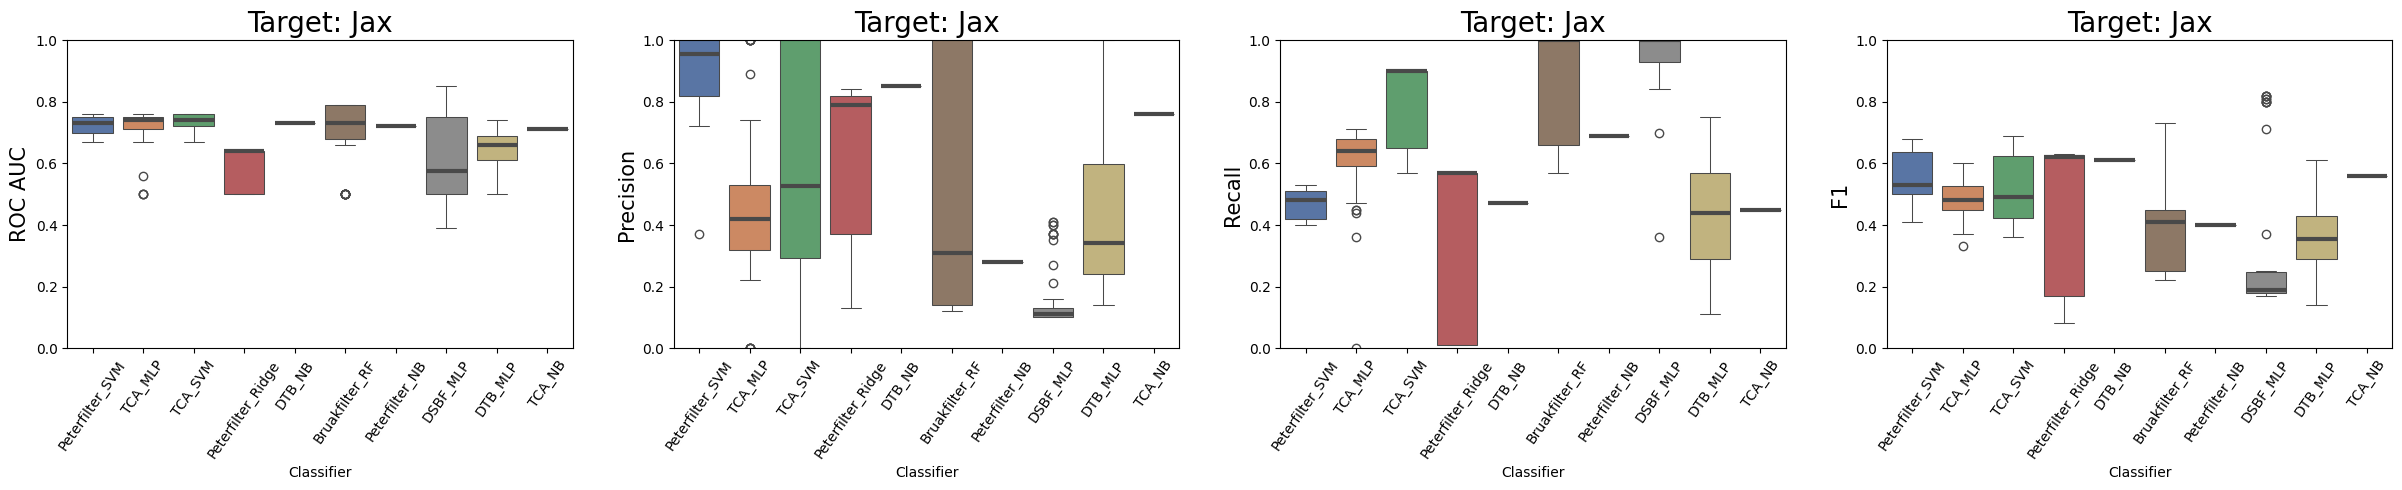

In [10]:
box_plots_jax(data_jax_roc, data_jax_precision, data_jax_recall, data_jax_f1)

## Target Project: Lightning

In [14]:
def data_loading_jl():
    # Load your dataset (replace X and y with your features and labels)
    jax_1_73 = pd.read_csv('../Dataset/jax_0.1.73.csv')
    jax_2_21 = pd.read_csv('../Dataset/jax_0.2.21.csv')
    jax_2_28 = pd.read_csv('../Dataset/jax_0.2.28.csv')
    jax_3_15 = pd.read_csv('../Dataset/jax_0.3.15.csv')
    
    
    jax_train_data = pd.concat([jax_1_73, jax_2_21, jax_2_28, jax_3_15])
    jax_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    lightning_0_5 = pd.read_csv('../Dataset/lightning_0.5.1.csv')
    lightning_1_0 = pd.read_csv('../Dataset/lightning_1.0.0.csv')
    lightning_1_5 = pd.read_csv('../Dataset/lightning_1.5.0.csv')
    lightning_1_8 = pd.read_csv('../Dataset/lightning_1.8.0.csv')
    
    
    lightning_test_data = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5, lightning_1_8])
    lightning_test_data1 = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5, lightning_1_8])
    lightning_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = jax_train_data.drop(columns='Buggy')
    Y_source = jax_train_data['Buggy']
    X_target = lightning_test_data.drop(columns='Buggy')
    Y_target = lightning_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target              # RQ2
    # return X_source, Y_source, X_target, Y_target, lightning_test_data1     # RQ3

def data_loading_rl():
    # Load your dataset (replace X and y with your features and labels)
    ray_0_3 = pd.read_csv('../Dataset/ray_0.3.0.csv')
    ray_0_6 = pd.read_csv('../Dataset/ray_0.6.1.csv')
    ray_0_8 = pd.read_csv('../Dataset/ray_0.8.0.csv')
    ray_1_1 = pd.read_csv('../Dataset/ray_1.1.0.csv')
    ray_1_9 = pd.read_csv('../Dataset/ray_1.9.0.csv')
    ray_2_0 = pd.read_csv('../Dataset/ray_2.0.0.csv')
    
    ray_train_data = pd.concat([ray_0_3, ray_0_6, ray_0_8, ray_1_1, ray_1_9, ray_2_0])
    ray_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)

    lightning_0_5 = pd.read_csv('../Dataset/lightning_0.5.1.csv')
    lightning_1_0 = pd.read_csv('../Dataset/lightning_1.0.0.csv')
    lightning_1_5 = pd.read_csv('../Dataset/lightning_1.5.0.csv')
    lightning_1_8 = pd.read_csv('../Dataset/lightning_1.8.0.csv')
    
    
    lightning_test_data = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5, lightning_1_8])
    lightning_test_data1 = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5, lightning_1_8])
    lightning_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = ray_train_data.drop(columns='Buggy')
    Y_source = ray_train_data['Buggy']
    X_target = lightning_test_data.drop(columns='Buggy')
    Y_target = lightning_test_data['Buggy']
    

    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target              # RQ2
    # return X_source, Y_source, X_target, Y_target, lightning_test_data1     # RQ3

def data_loading_tl():
    # Load your dataset (replace X and y with your features and labels)
    transformers_2_0 = pd.read_csv('../Dataset/transformers_2.0.0.csv')
    transformers_3_5 = pd.read_csv('../Dataset/transformers_3.5.0.csv')
    transformers_4_13 = pd.read_csv('../Dataset/transformers_4.13.0.csv')
    transformers_4_23 = pd.read_csv('../Dataset/transformers_4.23.0.csv')
    
    
    transformers_train_data = pd.concat([transformers_2_0, transformers_3_5, transformers_4_13, transformers_4_23])
    transformers_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
      
    lightning_0_5 = pd.read_csv('../Dataset/lightning_0.5.1.csv')
    lightning_1_0 = pd.read_csv('../Dataset/lightning_1.0.0.csv')
    lightning_1_5 = pd.read_csv('../Dataset/lightning_1.5.0.csv')
    lightning_1_8 = pd.read_csv('../Dataset/lightning_1.8.0.csv')
    
    
    lightning_test_data = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5, lightning_1_8])
    lightning_test_data1 = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5, lightning_1_8])
    lightning_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
   
    
    X_source = transformers_train_data.drop(columns='Buggy')
    Y_source = transformers_train_data['Buggy']
    X_target = lightning_test_data.drop(columns='Buggy')
    Y_target = lightning_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target   #RQ2
    # return X_source, Y_source, X_target, Y_target, lightning_test_data1     #RQ3

def data_loading_yl():
    # Load your dataset (replace X and y with your features and labels)
    yolov5_4_0 = pd.read_csv('../Dataset/yolov5_4.0.csv')
    yolov5_6_0 = pd.read_csv('../Dataset/yolov5_6.0.csv')
    yolov5_7_0 = pd.read_csv('../Dataset/yolov5_7.0.csv')
    
    yolov5_train_data = pd.concat([yolov5_4_0, yolov5_6_0, yolov5_7_0])
    yolov5_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    lightning_0_5 = pd.read_csv('../Dataset/lightning_0.5.1.csv')
    lightning_1_0 = pd.read_csv('../Dataset/lightning_1.0.0.csv')
    lightning_1_5 = pd.read_csv('../Dataset/lightning_1.5.0.csv')
    lightning_1_8 = pd.read_csv('../Dataset/lightning_1.8.0.csv')
    
    
    lightning_test_data = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5, lightning_1_8])
    lightning_test_data1 = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5, lightning_1_8])
    lightning_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = yolov5_train_data.drop(columns='Buggy')
    Y_source = yolov5_train_data['Buggy']
    X_target = lightning_test_data.drop(columns='Buggy')
    Y_target = lightning_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target   # RQ2
    # return X_source, Y_source, X_target, Y_target, lightning_test_data1   # RQ3

### Lightning - ROC_AUC

In [17]:
# Top 10 selected CPDP techniques
# DS-MLP
# Universal-KNN
# Bruakfilter-MLP
# DTB-Ridge
# DSBF-MLP
# DTB-MLP
# TCA-CART
# DS-Ridge
# Peterfilter_Ridge
# Bruakfilter-Naive Bayes
def lightning_roc_auc():
    # DS-MLP
    X_source, Y_source, X_target, Y_target = data_loading_jl()
    ds = DataSelection()
    loc = [0]
    X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
      fn=lambda search_space: objective_mlp(search_space, X_source, Y_source, X_target, Y_target),
      space=mlp_space,
      algo=algorithm,
      max_evals=50,
      trials=mlp_trials)
    print("Data Selection-MLP: ", space_eval(mlp_space, best_params_mlp))
    ds_mlp = [format(-result['loss'], '.2f') for result in mlp_trials.results]

    #Universal-KNN
    X_source, Y_source, X_target, Y_target = data_loading_yl()
    universal = Universal()
    X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    knn_trials = Trials()
    best_params_knn = fmin(
        fn=lambda search_space: objective_knn(search_space, X_source, Y_source, X_target, Y_target),
        space=knn_space,
        algo=algorithm,
        max_evals=50,
        trials=knn_trials)
    
    print("Universal-KNN: ", space_eval(knn_space, best_params_knn))
    universal_knn = [format(-result['loss'], '.2f') for result in knn_trials.results]

    # Bruakfilter-MLP
    X_source, Y_source, X_target, Y_target = data_loading_yl()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
      fn=lambda search_space: objective_mlp(search_space, X_source, Y_source, X_target, Y_target),
      space=mlp_space,
      algo=algorithm,
      max_evals=50,
      trials=mlp_trials)
    print("Bruakfilter MLP: ", space_eval(mlp_space, best_params_mlp))
    bruakfilter_mlp = [format(-result['loss'], '.2f') for result in mlp_trials.results]

    # DTB-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_rl()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("DTB-Ridge: ", space_eval(ridge_space, best_params_ridge))
    dtb_ridge = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    # DSBF-MLP
    X_source, Y_source, X_target, Y_target = data_loading_tl()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DSBF-MLP: ", space_eval(mlp_space, best_params_mlp))
    dsbf_mlp = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # DTB-MLP
    X_source, Y_source, X_target, Y_target = data_loading_tl()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DTB-MLP: ", space_eval(mlp_space, best_params_mlp))
    dtb_mlp = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # TCA-CART
    X_source, Y_source, X_target, Y_target = data_loading_rl()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on CART
    cart_trials = Trials()
    best_params_cart = fmin(
        fn=lambda search_space: objective_cart(search_space, X_source, Y_source, X_target, Y_target),
        space=cart_space,
        algo=algorithm,
        max_evals=50,
        trials=cart_trials)
    
    print("TCA_CART: ", space_eval(cart_space, best_params_cart))
    tca_cart = [format(-result['loss'], '.2f') for result in cart_trials.results]
    
    # DS-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_tl()
    ds = DataSelection()
    loc = [0]
    X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("DS-Ridge: ", space_eval(ridge_space, best_params_ridge))
    ds_ridge = [format(-result['loss'], '.2f') for result in ridge_trials.results]
    
    # Peterfilter_Ridge
    X_source, Y_source, X_target, Y_target = data_loading_tl()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("Peterfilter_Ridge", space_eval(ridge_space, best_params_ridge))
    peterfilter_ridge = [format(-result['loss'], '.2f') for result in ridge_trials.results]
    
    # Bruakfilter-Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_rl()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("Bruakfilter- Naive Bayes: ", space_eval(nb_space, best_params_nb))
    bruakfilter_nb = [format(-result['loss'], '.2f') for result in nb_trials.results]

    return ds_mlp, universal_knn, bruakfilter_mlp, dtb_ridge, dsbf_mlp, dtb_mlp, tca_cart, ds_ridge, peterfilter_ridge, bruakfilter_nb

In [18]:
ds_mlp, universal_knn, bruakfilter_mlp, dtb_ridge, dsbf_mlp, dtb_mlp, tca_cart, ds_ridge, peterfilter_ridge, bruakfilter_nb = lightning_roc_auc()
data_lightning_roc = pd.DataFrame({
      'Classifier': ['DataSelection_MLP'] * len(ds_mlp) +
                    ['Universal_KNN'] * len(universal_knn) +
                    ['Bruakfilter_MLP'] * len(bruakfilter_mlp) +
                    ['DTB_ridge'] * len(dtb_ridge) +
                    ['DSBF_MLP'] * len(dsbf_mlp) +
                    ['DTB_MLP'] * len(dtb_mlp) +
                    ['TCA_CART'] * len(tca_cart) +
                    ['DataSelection_Ridge'] * len(ds_ridge) +
                    ['Peterfilter_Ridge'] * len(peterfilter_ridge) +
                    ['Bruakfilter_NB'] * len(bruakfilter_nb),
      'ROC AUC': ds_mlp + universal_knn + bruakfilter_mlp + dtb_ridge + dsbf_mlp + dtb_mlp + tca_cart + ds_ridge + peterfilter_ridge + bruakfilter_nb
  })

data_lightning_roc['ROC AUC'] = pd.to_numeric(data_lightning_roc['ROC AUC'])
#violin_plots(data_jax)

(1266, 17)
(1266,)
(1820, 17)
(1820,)
100%|████████| 50/50 [00:15<00:00,  3.23trial/s, best loss: -0.7938420965273039]
Data Selection-MLP:  {'activation': 'relu', 'alpha': 0.007928867967579523, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'max_iter': 72}
(103, 17)
(103,)
(1820, 17)
(1820,)
100%|████████| 50/50 [00:01<00:00, 25.46trial/s, best loss: -0.9247551776921232]
Universal-KNN:  {'algorithm': 'kd_tree', 'n_neighbors': 6}
(103, 17)
(103,)
(1820, 17)
(1820,)
100%|████████| 50/50 [00:02<00:00, 20.10trial/s, best loss: -0.9366412776865904]
Bruakfilter MLP:  {'activation': 'identity', 'alpha': 0.004063341067420639, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 92}
(6778, 17)
(6778,)
(1820, 17)
(1820,)
100%|████████| 50/50 [01:28<00:00,  1.77s/trial, best loss: -0.9122789222285747]
DTB-Ridge:  {'alpha': 0.3119333439042973, 'max_iter': 10225, 'solver': 'lsqr'}
(3839, 17)
(3839,)
(1820, 17)
(1820,)
100%|███████████████████████| 50/50 [00:25<00:00,  1

In [19]:
%store data_lightning_roc

Stored 'data_lightning_roc' (DataFrame)


### Lightning - Precision

In [20]:
# Top 10 selected CPDP techniques
# DS-MLP
# Universal-KNN
# Bruakfilter-MLP
# DTB-Ridge
# DSBF-MLP
# DTB-MLP
# TCA-CARt
# DS-Ridge
# Peterfilter_Ridge
# Bruakfilter-Naive Bayes
def lightning_precision():
    # DS-MLP
    X_source, Y_source, X_target, Y_target = data_loading_jl()
    ds = DataSelection()
    loc = [0]
    X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
      fn=lambda search_space: objective_mlp_pre(search_space, X_source, Y_source, X_target, Y_target),
      space=mlp_space,
      algo=algorithm,
      max_evals=50,
      trials=mlp_trials)
    print("Data Selection-MLP Precision: ", space_eval(mlp_space, best_params_mlp))
    ds_mlp_pre = [format(-result['loss'], '.2f') for result in mlp_trials.results]

    #Universal-KNN
    X_source, Y_source, X_target, Y_target = data_loading_yl()
    universal = Universal()
    X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    knn_trials = Trials()
    best_params_knn = fmin(
        fn=lambda search_space: objective_knn_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=knn_space,
        algo=algorithm,
        max_evals=50,
        trials=knn_trials)
    
    print("Universal-KNN Precision: ", space_eval(knn_space, best_params_knn))
    universal_knn_pre = [format(-result['loss'], '.2f') for result in knn_trials.results]

    # Bruakfilter-MLP
    X_source, Y_source, X_target, Y_target = data_loading_yl()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
      fn=lambda search_space: objective_mlp_pre(search_space, X_source, Y_source, X_target, Y_target),
      space=mlp_space,
      algo=algorithm,
      max_evals=50,
      trials=mlp_trials)
    print("Bruakfilter MLP Precision: ", space_eval(mlp_space, best_params_mlp))
    bruakfilter_mlp_pre = [format(-result['loss'], '.2f') for result in mlp_trials.results]

    # DTB-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_rl()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("DTB-Ridge Precision: ", space_eval(ridge_space, best_params_ridge))
    dtb_ridge_pre = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    # DSBF-MLP
    X_source, Y_source, X_target, Y_target = data_loading_tl()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DSBF-MLP Precision: ", space_eval(mlp_space, best_params_mlp))
    dsbf_mlp_pre = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # DTB-MLP
    X_source, Y_source, X_target, Y_target = data_loading_tl()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DTB-MLP Precision: ", space_eval(mlp_space, best_params_mlp))
    dtb_mlp_pre = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
     # TCA-CART
    X_source, Y_source, X_target, Y_target = data_loading_rl()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on CART
    cart_trials = Trials()
    best_params_cart = fmin(
        fn=lambda search_space: objective_cart_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=cart_space,
        algo=algorithm,
        max_evals=50,
        trials=cart_trials)
    
    print("TCA_CART Precision: ", space_eval(cart_space, best_params_cart))
    tca_cart_pre = [format(-result['loss'], '.2f') for result in cart_trials.results]
    
    # DS-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_tl()
    ds = DataSelection()
    loc = [0]
    X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("DS-Ridge Precision: ", space_eval(ridge_space, best_params_ridge))
    ds_ridge_pre = [format(-result['loss'], '.2f') for result in ridge_trials.results]
    
    # Peterfilter_Ridge
    X_source, Y_source, X_target, Y_target = data_loading_tl()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("Peterfilter_Ridge Precision", space_eval(ridge_space, best_params_ridge))
    peterfilter_ridge_pre = [format(-result['loss'], '.2f') for result in ridge_trials.results]
    
    # Bruakfilter-Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_rl()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("Bruakfilter- Naive Bayes Precision: ", space_eval(nb_space, best_params_nb))
    bruakfilter_nb_pre = [format(-result['loss'], '.2f') for result in nb_trials.results]

    return ds_mlp_pre, universal_knn_pre, bruakfilter_mlp_pre, dtb_ridge_pre, dsbf_mlp_pre, dtb_mlp_pre, tca_cart_pre, ds_ridge_pre, peterfilter_ridge_pre, bruakfilter_nb_pre

In [21]:
ds_mlp_pre, universal_knn_pre, bruakfilter_mlp_pre, dtb_ridge_pre, dsbf_mlp_pre, dtb_mlp_pre, tca_cart_pre, ds_ridge_pre, peterfilter_ridge_pre, bruakfilter_nb_pre = lightning_precision()
data_lightning_precision = pd.DataFrame({
      'Classifier': ['DataSelection_MLP'] * len(ds_mlp_pre) +
                    ['Universal_KNN'] * len(universal_knn_pre) +
                    ['Bruakfilter_MLP'] * len(bruakfilter_mlp_pre) +
                    ['DTB_ridge'] * len(dtb_ridge_pre) +
                    ['DSBF_MLP'] * len(dsbf_mlp_pre) +
                    ['DTB_MLP'] * len(dtb_mlp_pre) +
                    ['TCA_CART'] * len(tca_cart_pre) +
                    ['DataSelection_Ridge'] * len(ds_ridge_pre) +
                    ['Peterfilter_Ridge'] * len(peterfilter_ridge_pre) +
                    ['Bruakfilter_NB'] * len(bruakfilter_nb_pre),
      'Precision': ds_mlp_pre + universal_knn_pre + bruakfilter_mlp_pre + dtb_ridge_pre + dsbf_mlp_pre + dtb_mlp_pre + tca_cart_pre + ds_ridge_pre + peterfilter_ridge_pre + bruakfilter_nb_pre
  })

data_lightning_precision['Precision'] = pd.to_numeric(data_lightning_precision['Precision'])
#violin_plots(data_jax)

(1266, 17)
(1266,)
(1820, 17)
(1820,)
100%|███████████████████████| 50/50 [00:18<00:00,  2.65trial/s, best loss: -1.0]
Data Selection-MLP Precision:  {'activation': 'tanh', 'alpha': 0.008136123633794283, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 88}
(103, 17)
(103,)
(1820, 17)
(1820,)
100%|████████| 50/50 [00:02<00:00, 24.77trial/s, best loss: -0.7523680649526387]
Universal-KNN Precision:  {'algorithm': 'ball_tree', 'n_neighbors': 6}
(103, 17)
(103,)
(1820, 17)
(1820,)
100%|████████| 50/50 [00:03<00:00, 16.29trial/s, best loss: -0.8505392912172574]
Bruakfilter MLP Precision:  {'activation': 'tanh', 'alpha': 0.005592611092645805, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 91}
(6778, 17)
(6778,)
(1820, 17)
(1820,)
100%|████████| 50/50 [02:04<00:00,  2.49s/trial, best loss: -0.9245283018867925]
DTB-Ridge Precision:  {'alpha': 0.2552593809827698, 'max_iter': 13363, 'solver': 'lsqr'}
(3839, 17)
(3839,)
(1820, 17)
(1820,)
100%|████

In [22]:
%store data_lightning_precision

Stored 'data_lightning_precision' (DataFrame)


### Lightning - Recall

In [24]:
# Top 10 selected CPDP techniques
# DS-MLP
# Universal-KNN
# Bruakfilter-MLP
# DTB-Ridge
# DSBF-MLP
# DTB-MLP
# TCA-CART
# DS-Ridge
# Peterfilter_Ridge
# Bruakfilter-Naive Bayes
def lightning_recall():
    # DS-MLP
    X_source, Y_source, X_target, Y_target = data_loading_jl()
    ds = DataSelection()
    loc = [0]
    X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
      fn=lambda search_space: objective_mlp_re(search_space, X_source, Y_source, X_target, Y_target),
      space=mlp_space,
      algo=algorithm,
      max_evals=50,
      trials=mlp_trials)
    print("Data Selection-MLP Recall: ", space_eval(mlp_space, best_params_mlp))
    ds_mlp_re = [format(-result['loss'], '.2f') for result in mlp_trials.results]

    #Universal-KNN
    X_source, Y_source, X_target, Y_target = data_loading_yl()
    universal = Universal()
    X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    knn_trials = Trials()
    best_params_knn = fmin(
        fn=lambda search_space: objective_knn_re(search_space, X_source, Y_source, X_target, Y_target),
        space=knn_space,
        algo=algorithm,
        max_evals=50,
        trials=knn_trials)
    
    print("Universal-KNN Recall: ", space_eval(knn_space, best_params_knn))
    universal_knn_re = [format(-result['loss'], '.2f') for result in knn_trials.results]

    # Bruakfilter-MLP
    X_source, Y_source, X_target, Y_target = data_loading_yl()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
      fn=lambda search_space: objective_mlp_re(search_space, X_source, Y_source, X_target, Y_target),
      space=mlp_space,
      algo=algorithm,
      max_evals=50,
      trials=mlp_trials)
    print("Bruakfilter MLP Recall: ", space_eval(mlp_space, best_params_mlp))
    bruakfilter_mlp_re = [format(-result['loss'], '.2f') for result in mlp_trials.results]

    # DTB-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_rl()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_re(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("DTB-Ridge Recall: ", space_eval(ridge_space, best_params_ridge))
    dtb_ridge_re = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    # DSBF-MLP
    X_source, Y_source, X_target, Y_target = data_loading_tl()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_re(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DSBF-MLP Recall: ", space_eval(mlp_space, best_params_mlp))
    dsbf_mlp_re = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # DTB-MLP
    X_source, Y_source, X_target, Y_target = data_loading_tl()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_re(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DTB-MLP Recall: ", space_eval(mlp_space, best_params_mlp))
    dtb_mlp_re = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
     # TCA-CART
    X_source, Y_source, X_target, Y_target = data_loading_rl()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on CART
    cart_trials = Trials()
    best_params_cart = fmin(
        fn=lambda search_space: objective_cart_re(search_space, X_source, Y_source, X_target, Y_target),
        space=cart_space,
        algo=algorithm,
        max_evals=50,
        trials=cart_trials)
    
    print("TCA_CART Recall: ", space_eval(cart_space, best_params_cart))
    tca_cart_re = [format(-result['loss'], '.2f') for result in cart_trials.results]
    
    # DS-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_tl()
    ds = DataSelection()
    loc = [0]
    X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_re(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("DS-Ridge Recall: ", space_eval(ridge_space, best_params_ridge))
    ds_ridge_re = [format(-result['loss'], '.2f') for result in ridge_trials.results]
    
    # Peterfilter_Ridge
    X_source, Y_source, X_target, Y_target = data_loading_tl()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_re(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("Peterfilter_Ridge Recall", space_eval(ridge_space, best_params_ridge))
    peterfilter_ridge_re = [format(-result['loss'], '.2f') for result in ridge_trials.results]
    
    # Bruakfilter-Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_rl()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_re(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("Bruakfilter- Naive Bayes Recall: ", space_eval(nb_space, best_params_nb))
    bruakfilter_nb_re = [format(-result['loss'], '.2f') for result in nb_trials.results]

    return ds_mlp_re, universal_knn_re, bruakfilter_mlp_re, dtb_ridge_re, dsbf_mlp_re, dtb_mlp_re, tca_cart_re, ds_ridge_re, peterfilter_ridge_re, bruakfilter_nb_re

In [25]:
ds_mlp_re, universal_knn_re, bruakfilter_mlp_re, dtb_ridge_re, dsbf_mlp_re, dtb_mlp_re, tca_cart_re, ds_ridge_re, peterfilter_ridge_re, bruakfilter_nb_re = lightning_recall()

(1266, 17)
(1266,)
(1820, 17)
(1820,)
100%|████████| 50/50 [00:13<00:00,  3.77trial/s, best loss: -0.6207513416815742]
Data Selection-MLP Recall:  {'activation': 'relu', 'alpha': 0.008341595604268573, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'max_iter': 87}
(103, 17)
(103,)
(1820, 17)
(1820,)
100%|███████████████████████| 50/50 [00:01<00:00, 25.73trial/s, best loss: -1.0]
Universal-KNN Recall:  {'algorithm': 'ball_tree', 'n_neighbors': 5}
(103, 17)
(103,)
(1820, 17)
(1820,)
100%|███████████████████████| 50/50 [00:02<00:00, 20.25trial/s, best loss: -1.0]
Bruakfilter MLP Recall:  {'activation': 'logistic', 'alpha': 0.002335144941005081, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 15}
(6778, 17)
(6778,)
(1820, 17)
(1820,)
100%|████████| 50/50 [00:49<00:00,  1.02trial/s, best loss: -0.7835420393559929]
DTB-Ridge Recall:  {'alpha': 0.5949565776931238, 'max_iter': 2938, 'solver': 'lsqr'}
(3839, 17)
(3839,)
(1820, 17)
(1820,)
100%|██████████████████

NameError: name 'bruakfilter_nb_pe' is not defined

In [27]:
data_lightning_recall = pd.DataFrame({
      'Classifier': ['DataSelection_MLP'] * len(ds_mlp_re) +
                    ['Universal_KNN'] * len(universal_knn_re) +
                    ['Bruakfilter_MLP'] * len(bruakfilter_mlp_re) +
                    ['DTB_ridge'] * len(dtb_ridge_re) +
                    ['DSBF_MLP'] * len(dsbf_mlp_re) +
                    ['DTB_MLP'] * len(dtb_mlp_re) +
                    ['TCA_CART'] * len(tca_cart_re) +
                    ['DataSelection_Ridge'] * len(ds_ridge_re) +
                    ['Peterfilter_Ridge'] * len(peterfilter_ridge_pre) +
                    ['Bruakfilter_NB'] * len(bruakfilter_nb_pre),
      'Recall': ds_mlp_re + universal_knn_re + bruakfilter_mlp_re + dtb_ridge_re + dsbf_mlp_re + dtb_mlp_re + tca_cart_re + ds_ridge_re + peterfilter_ridge_re + bruakfilter_nb_re
  })

data_lightning_recall['Recall'] = pd.to_numeric(data_lightning_recall['Recall'])
#violin_plots(data_jax)

In [28]:
%store data_lightning_recall

Stored 'data_lightning_recall' (DataFrame)


### Lightning - F1

In [29]:
# Top 10 selected CPDP techniques
# DS-MLP
# Universal-KNN
# Bruakfilter-MLP
# DTB-Ridge
# DSBF-MLP
# DTB-MLP
# TCA-CART
# DS-Ridge
# Peterfilter_Ridge
# Bruakfilter-Naive Bayes
def lightning_f1():
    # DS-MLP
    X_source, Y_source, X_target, Y_target = data_loading_jl()
    ds = DataSelection()
    loc = [0]
    X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
      fn=lambda search_space: objective_mlp_f1(search_space, X_source, Y_source, X_target, Y_target),
      space=mlp_space,
      algo=algorithm,
      max_evals=50,
      trials=mlp_trials)
    print("Data Selection-MLP F1: ", space_eval(mlp_space, best_params_mlp))
    ds_mlp_f1 = [format(-result['loss'], '.2f') for result in mlp_trials.results]

    #Universal-KNN
    X_source, Y_source, X_target, Y_target = data_loading_yl()
    universal = Universal()
    X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    knn_trials = Trials()
    best_params_knn = fmin(
        fn=lambda search_space: objective_knn_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=knn_space,
        algo=algorithm,
        max_evals=50,
        trials=knn_trials)
    
    print("Universal-KNN F1: ", space_eval(knn_space, best_params_knn))
    universal_knn_f1 = [format(-result['loss'], '.2f') for result in knn_trials.results]

    # Bruakfilter-MLP
    X_source, Y_source, X_target, Y_target = data_loading_yl()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
      fn=lambda search_space: objective_mlp_f1(search_space, X_source, Y_source, X_target, Y_target),
      space=mlp_space,
      algo=algorithm,
      max_evals=50,
      trials=mlp_trials)
    print("Bruakfilter MLP F1: ", space_eval(mlp_space, best_params_mlp))
    bruakfilter_mlp_f1 = [format(-result['loss'], '.2f') for result in mlp_trials.results]

    # DTB-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_rl()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("DTB-Ridge F1: ", space_eval(ridge_space, best_params_ridge))
    dtb_ridge_f1 = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    # DSBF-MLP
    X_source, Y_source, X_target, Y_target = data_loading_tl()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DSBF-MLP F1: ", space_eval(mlp_space, best_params_mlp))
    dsbf_mlp_f1 = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # DTB-MLP
    X_source, Y_source, X_target, Y_target = data_loading_tl()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DTB-MLP F1: ", space_eval(mlp_space, best_params_mlp))
    dtb_mlp_f1 = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
     # TCA-CART
    X_source, Y_source, X_target, Y_target = data_loading_rl()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on CART
    cart_trials = Trials()
    best_params_cart = fmin(
        fn=lambda search_space: objective_cart_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=cart_space,
        algo=algorithm,
        max_evals=50,
        trials=cart_trials)
    
    print("TCA_CART F1: ", space_eval(cart_space, best_params_cart))
    tca_cart_f1 = [format(-result['loss'], '.2f') for result in cart_trials.results]
    
    # DS-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_tl()
    ds = DataSelection()
    loc = [0]
    X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("DS-Ridge F1: ", space_eval(ridge_space, best_params_ridge))
    ds_ridge_f1 = [format(-result['loss'], '.2f') for result in ridge_trials.results]
    
    # Peterfilter_Ridge
    X_source, Y_source, X_target, Y_target = data_loading_tl()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("Peterfilter_Ridge F1", space_eval(ridge_space, best_params_ridge))
    peterfilter_ridge_f1 = [format(-result['loss'], '.2f') for result in ridge_trials.results]
    
    # Bruakfilter-Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_rl()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("Bruakfilter- Naive Bayes F1: ", space_eval(nb_space, best_params_nb))
    bruakfilter_nb_f1 = [format(-result['loss'], '.2f') for result in nb_trials.results]

    return ds_mlp_f1, universal_knn_f1, bruakfilter_mlp_f1, dtb_ridge_f1, dsbf_mlp_f1, dtb_mlp_f1, tca_cart_f1, ds_ridge_f1, peterfilter_ridge_f1, bruakfilter_nb_f1

In [30]:
ds_mlp_f1, universal_knn_f1, bruakfilter_mlp_f1, dtb_ridge_f1, dsbf_mlp_f1, dtb_mlp_f1, tca_cart_f1, ds_ridge_f1, peterfilter_ridge_f1, bruakfilter_nb_f1 = lightning_f1()
data_lightning_f1 = pd.DataFrame({
      'Classifier': ['DataSelection_MLP'] * len(ds_mlp_f1) +
                    ['Universal_KNN'] * len(universal_knn_f1) +
                    ['Bruakfilter_MLP'] * len(bruakfilter_mlp_f1) +
                    ['DTB_ridge'] * len(dtb_ridge_f1) +
                    ['DSBF_MLP'] * len(dsbf_mlp_f1) +
                    ['DTB_MLP'] * len(dtb_mlp_f1) +
                    ['TCA_CART'] * len(tca_cart_f1) +
                    ['DataSelection_Ridge'] * len(ds_ridge_f1) +
                    ['Peterfilter_Ridge'] * len(peterfilter_ridge_f1) +
                    ['Bruakfilter_NB'] * len(bruakfilter_nb_f1),
      'F1': ds_mlp_f1 + universal_knn_f1 + bruakfilter_mlp_f1 + dtb_ridge_f1 + dsbf_mlp_f1 + dtb_mlp_f1 + tca_cart_f1 + ds_ridge_f1 + peterfilter_ridge_f1 + bruakfilter_nb_f1
  })

data_lightning_f1['F1'] = pd.to_numeric(data_lightning_f1['F1'])
#violin_plots(data_jax)

(1266, 17)
(1266,)
(1820, 17)
(1820,)
100%|████████| 50/50 [00:12<00:00,  3.86trial/s, best loss: -0.6619217081850535]
Data Selection-MLP F1:  {'activation': 'relu', 'alpha': 0.0008034450594966964, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 26}
(103, 17)
(103,)
(1820, 17)
(1820,)
100%|████████| 50/50 [00:01<00:00, 25.31trial/s, best loss: -0.8567026194144837]
Universal-KNN F1:  {'algorithm': 'brute', 'n_neighbors': 6}
(103, 17)
(103,)
(1820, 17)
(1820,)
100%|████████| 50/50 [00:02<00:00, 16.93trial/s, best loss: -0.9326599326599327]
Bruakfilter MLP F1:  {'activation': 'tanh', 'alpha': 0.005835782134309232, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'invscaling', 'max_iter': 95}
(6778, 17)
(6778,)
(1820, 17)
(1820,)
100%|████████| 50/50 [01:43<00:00,  2.07s/trial, best loss: -0.8884758364312267]
DTB-Ridge F1:  {'alpha': 0.12605429769057183, 'max_iter': 2558, 'solver': 'lsqr'}
(3839, 17)
(3839,)
(1820, 17)
(1820,)
100%|███████████████████████| 50/50 [00:

In [31]:
%store data_lightning_f1

Stored 'data_lightning_f1' (DataFrame)


### Lightning - Boxplot

In [46]:
grouped_stats = data_lightning_roc.groupby('Classifier')['ROC AUC'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_lightning_precision.groupby('Classifier')['Precision'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_lightning_recall.groupby('Classifier')['Recall'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_lightning_f1.groupby('Classifier')['F1'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')

                       mean  median       std
Classifier                                   
Bruakfilter_MLP      0.7156   0.720  0.148367
Bruakfilter_NB       1.0000   1.000  0.000000
DSBF_MLP             0.6922   0.700  0.171241
DTB_MLP              0.7996   0.820  0.074614
DTB_ridge            0.8400   0.865  0.082015
DataSelection_MLP    0.5832   0.580  0.085295
DataSelection_Ridge  0.6938   0.820  0.156164
Peterfilter_Ridge    0.7124   0.820  0.151463
TCA_CART             0.7794   0.780  0.049422
Universal_KNN        0.8632   0.860  0.056548
-------------------------------------
                       mean  median       std
Classifier                                   
Bruakfilter_MLP      0.5122   0.415  0.194813
Bruakfilter_NB       1.0000   1.000  0.000000
DSBF_MLP             0.6970   1.000  0.461091
DTB_MLP              0.8512   0.850  0.094386
DTB_ridge            0.8358   0.870  0.098811
DataSelection_MLP    0.6756   0.915  0.431912
DataSelection_Ridge  0.9000   1.000  0.303

In [140]:
# For target lightning
def box_plots_lightning(data_lightning_roc, data_lightning_precision, data_lightning_recall, data_lightning_f1):

    classifier_order = data_lightning_roc['Classifier'].unique()
    num_classifiers = len(classifier_order)
    color_palette = sns.color_palette("deep", num_classifiers)
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30, 4))
    sns.set(style='whitegrid')
    # sns.color_palette("pastel")

    

    # Plot box plots
    sns.boxplot(x='Classifier', y='ROC AUC', data=data_lightning_roc, order=classifier_order, palette=color_palette, ax=axes[0], linewidth=0.75, medianprops={"linewidth": 3})
    axes[0].set_title('Target: Lightning', fontsize=20)
    axes[0].set_ylim(0, 1)
    axes[0].set_ylabel('ROC AUC', fontsize=15)

    sns.boxplot(x='Classifier', y='Precision', data=data_lightning_precision, order=classifier_order, palette=color_palette, ax=axes[1], linewidth=0.75, medianprops={"linewidth": 3})
    axes[1].set_title('Target: Lightning', fontsize=20)
    axes[1].set_ylim(0, 1)
    axes[1].set_ylabel('Precision', fontsize=15)

    sns.boxplot(x='Classifier', y='Recall', data=data_lightning_recall, order=classifier_order, palette=color_palette, ax=axes[2], linewidth=0.75, medianprops={"linewidth": 3})
    axes[2].set_title('Target: Lightning', fontsize=20)
    axes[2].set_ylim(0, 1)
    axes[2].set_ylabel('Recall', fontsize=15)

    sns.boxplot(x='Classifier', y='F1', data=data_lightning_f1, order=classifier_order, palette=color_palette, ax=axes[3], linewidth=0.75, medianprops={"linewidth": 3})
    axes[3].set_title('Target: Lightning', fontsize=20)
    axes[3].set_ylim(0, 1)
    axes[3].set_ylabel('F1', fontsize=15)

    for ax in axes:
        for line in ax.lines:
            if np.array_equal(line.get_xdata(), [0, 1]):  # Check if the line represents the median
                line.set_linewidth(2)  # Set line width to bold


    # Tilt x-axis labels
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
        
    plt.savefig('cpdp_results_lightning_boxplots.png', bbox_inches='tight')
    plt.show()

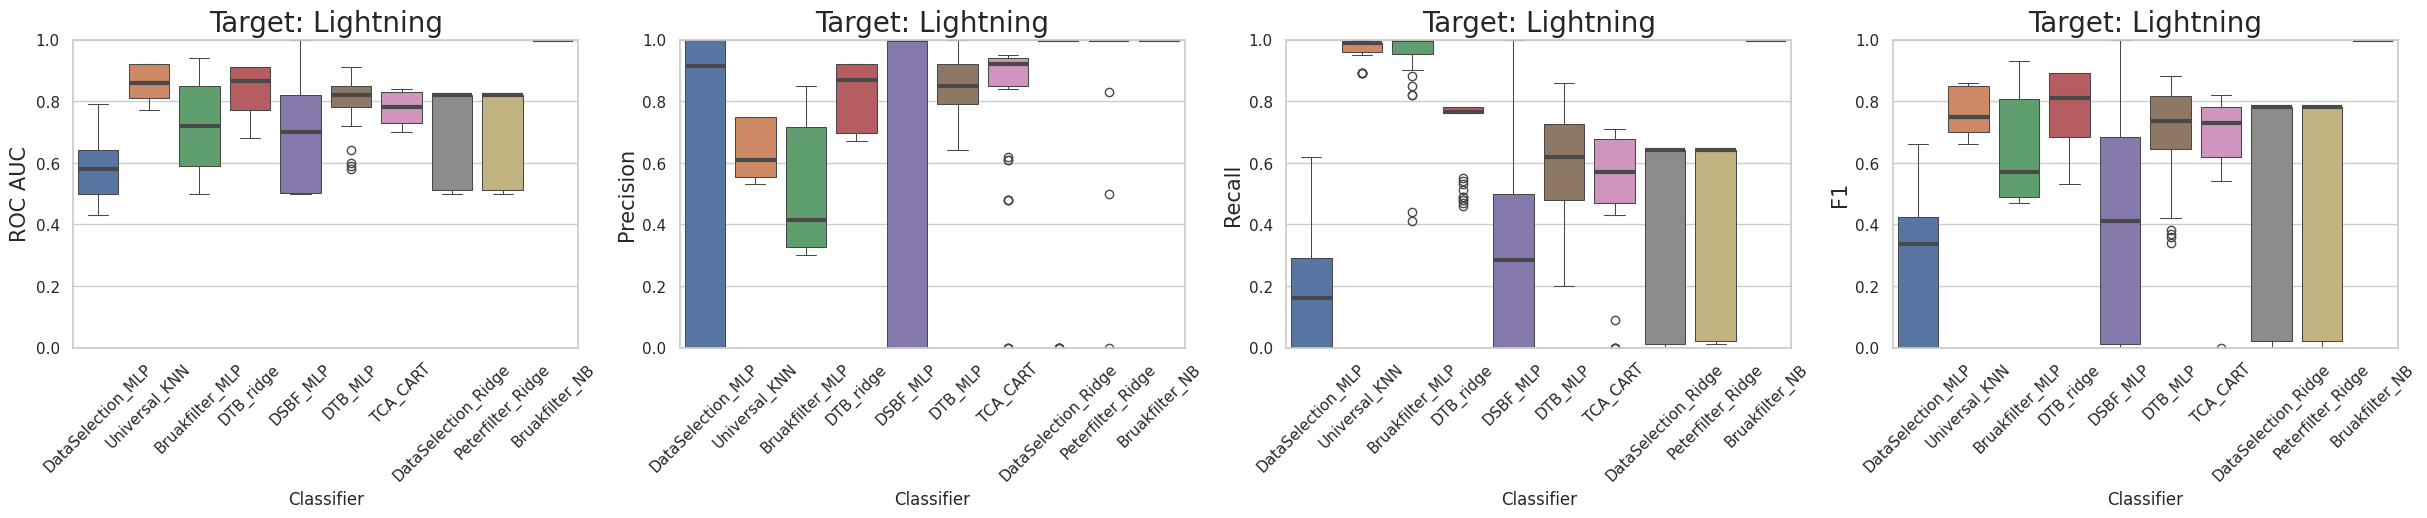

In [141]:
box_plots_lightning(data_lightning_roc, data_lightning_precision, data_lightning_recall, data_lightning_f1)

## Target Project: Ray

In [33]:
def data_loading_tr():
    # Load your dataset (replace X and y with your features and labels)
    transformers_2_0 = pd.read_csv('../Dataset/transformers_2.0.0.csv')
    transformers_3_5 = pd.read_csv('../Dataset/transformers_3.5.0.csv')
    transformers_4_13 = pd.read_csv('../Dataset/transformers_4.13.0.csv')
    transformers_4_23 = pd.read_csv('../Dataset/transformers_4.23.0.csv')
    
    
    transformers_train_data = pd.concat([transformers_2_0, transformers_3_5, transformers_4_13, transformers_4_23])
    transformers_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    
    ray_0_3 = pd.read_csv('../Dataset/ray_0.3.0.csv')
    ray_0_6 = pd.read_csv('../Dataset/ray_0.6.1.csv')
    ray_0_8 = pd.read_csv('../Dataset/ray_0.8.0.csv')
    ray_1_1 = pd.read_csv('../Dataset/ray_1.1.0.csv')
    ray_1_9 = pd.read_csv('../Dataset/ray_1.9.0.csv')
    ray_2_0 = pd.read_csv('../Dataset/ray_2.0.0.csv')
    
    ray_test_data = pd.concat([ray_0_3, ray_0_6, ray_0_8, ray_1_1, ray_1_9, ray_2_0])
    ray_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = transformers_train_data.drop(columns='Buggy')
    Y_source = transformers_train_data['Buggy']
    X_target = ray_test_data.drop(columns='Buggy')
    Y_target = ray_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

def data_loading_jr():
    # Load your dataset (replace X and y with your features and labels)
    jax_1_73 = pd.read_csv('../Dataset/jax_0.1.73.csv')
    jax_2_21 = pd.read_csv('../Dataset/jax_0.2.21.csv')
    jax_2_28 = pd.read_csv('../Dataset/jax_0.2.28.csv')
    jax_3_15 = pd.read_csv('../Dataset/jax_0.3.15.csv')
    
    
    jax_train_data = pd.concat([jax_1_73, jax_2_21, jax_2_28, jax_3_15])
    jax_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    
    ray_0_3 = pd.read_csv('../Dataset/ray_0.3.0.csv')
    ray_0_6 = pd.read_csv('../Dataset/ray_0.6.1.csv')
    ray_0_8 = pd.read_csv('../Dataset/ray_0.8.0.csv')
    ray_1_1 = pd.read_csv('../Dataset/ray_1.1.0.csv')
    ray_1_9 = pd.read_csv('../Dataset/ray_1.9.0.csv')
    ray_2_0 = pd.read_csv('../Dataset/ray_2.0.0.csv')
    
    ray_test_data = pd.concat([ray_0_3, ray_0_6, ray_0_8, ray_1_1, ray_1_9, ray_2_0])
    ray_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = jax_train_data.drop(columns='Buggy')
    Y_source = jax_train_data['Buggy']
    X_target = ray_test_data.drop(columns='Buggy')
    Y_target = ray_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

def data_loading_lr():
    # Load your dataset (replace X and y with your features and labels)
    lightning_0_5 = pd.read_csv('../Dataset/lightning_0.5.1.csv')
    lightning_1_0 = pd.read_csv('../Dataset/lightning_1.0.0.csv')
    lightning_1_5 = pd.read_csv('../Dataset/lightning_1.5.0.csv')
    lightning_1_8 = pd.read_csv('../Dataset/lightning_1.8.0.csv')
    
    
    lightning_train_data = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5, lightning_1_8])
    lightning_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    
    ray_0_3 = pd.read_csv('../Dataset/ray_0.3.0.csv')
    ray_0_6 = pd.read_csv('../Dataset/ray_0.6.1.csv')
    ray_0_8 = pd.read_csv('../Dataset/ray_0.8.0.csv')
    ray_1_1 = pd.read_csv('../Dataset/ray_1.1.0.csv')
    ray_1_9 = pd.read_csv('../Dataset/ray_1.9.0.csv')
    ray_2_0 = pd.read_csv('../Dataset/ray_2.0.0.csv')
    
    ray_test_data = pd.concat([ray_0_3, ray_0_6, ray_0_8, ray_1_1, ray_1_9, ray_2_0])
    ray_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = lightning_train_data.drop(columns='Buggy')
    Y_source = lightning_train_data['Buggy']
    X_target = ray_test_data.drop(columns='Buggy')
    Y_target = ray_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

def data_loading_yr():
    # Load your dataset (replace X and y with your features and labels)
    yolov5_4_0 = pd.read_csv('../Dataset/yolov5_4.0.csv')
    yolov5_6_0 = pd.read_csv('../Dataset/yolov5_6.0.csv')
    yolov5_7_0 = pd.read_csv('../Dataset/yolov5_7.0.csv')
    
    yolov5_train_data = pd.concat([yolov5_4_0, yolov5_6_0, yolov5_7_0])
    yolov5_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    
    ray_0_3 = pd.read_csv('../Dataset/ray_0.3.0.csv')
    ray_0_6 = pd.read_csv('../Dataset/ray_0.6.1.csv')
    ray_0_8 = pd.read_csv('../Dataset/ray_0.8.0.csv')
    ray_1_1 = pd.read_csv('../Dataset/ray_1.1.0.csv')
    ray_1_9 = pd.read_csv('../Dataset/ray_1.9.0.csv')
    ray_2_0 = pd.read_csv('../Dataset/ray_2.0.0.csv')
    
    ray_test_data = pd.concat([ray_0_3, ray_0_6, ray_0_8, ray_1_1, ray_1_9, ray_2_0])
    ray_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = yolov5_train_data.drop(columns='Buggy')
    Y_source = yolov5_train_data['Buggy']
    X_target = ray_test_data.drop(columns='Buggy')
    Y_target = ray_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

### Ray - ROC_AUC

In [34]:

def ray_roc_auc():
    # DSBF-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_yr()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
      fn=lambda search_space: objective_ridge(search_space, X_source, Y_source, X_target, Y_target),
      space=ridge_space,
      algo=algorithm,
      max_evals=50,
      trials=ridge_trials)
    print("DSBF_Ridge ROC_AUC: ", space_eval(ridge_space, best_params_ridge))
    dsbf_ridge = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    #DTB-KNN
    X_source, Y_source, X_target, Y_target = data_loading_jr()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on KNN
    knn_trials = Trials()
    best_params_knn = fmin(
        fn=lambda search_space: objective_knn(search_space, X_source, Y_source, X_target, Y_target),
        space=knn_space,
        algo=algorithm,
        max_evals=50,
        trials=knn_trials)
    
    print("DTB-KNN ROC_AUC: ", space_eval(knn_space, best_params_knn))
    dtb_knn = [format(-result['loss'], '.2f') for result in knn_trials.results]

    # TCA_AdaBoost
    X_source, Y_source, X_target, Y_target = data_loading_jr()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on AdaBoost
    ada_trials = Trials()
    best_params_ada = fmin(
      fn=lambda search_space: objective_ada(search_space, X_source, Y_source, X_target, Y_target),
      space=ada_space,
      algo=algorithm,
      max_evals=50,
      trials=ada_trials)
    print("TCA-AdaBoost ROC AUC: ", space_eval(ada_space, best_params_ada))
    tca_ada = [format(-result['loss'], '.2f') for result in ada_trials.results]

    # Bruakfilter-KNN
    X_source, Y_source, X_target, Y_target = data_loading_lr()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on KNN
    knn_trials = Trials()
    best_params_knn = fmin(
        fn=lambda search_space: objective_knn(search_space, X_source, Y_source, X_target, Y_target),
        space=knn_space,
        algo=algorithm,
        max_evals=50,
        trials=knn_trials)
    
    print("Bruakfilter-KNN ROC_AUC: ", space_eval(knn_space, best_params_knn))
    bruakfilter_knn = [format(-result['loss'], '.2f') for result in knn_trials.results]

    # TCA-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_lr()
    tca= TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("TCA-Ridge ROC_AUC: ", space_eval(ridge_space, best_params_ridge))
    tca_ridge = [format(-result['loss'], '.2f') for result in ridge_trials.results]
    
    # Peterfilter_NB
    X_source, Y_source, X_target, Y_target = data_loading_jr()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on NB
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("Peterfilter-NB ROC_AUC: ", space_eval(nb_space, best_params_nb))
    peterfilter_nb = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # TCA-MLP
    X_source, Y_source, X_target, Y_target = data_loading_jr()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("TCA-MLP ROC_AUC: ", space_eval(mlp_space, best_params_mlp))
    tca_mlp = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # Bruakfilter - MLP
    X_source, Y_source, X_target, Y_target = data_loading_yr()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("Bruakfilter-MLP ROC_AUC: ", space_eval(mlp_space, best_params_mlp))
    bruakfilter_mlp = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # DTB - MLP
    X_source, Y_source, X_target, Y_target = data_loading_lr()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DTB-MLP ROC_AUC: ", space_eval(mlp_space, best_params_mlp))
    dtb_mlp = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # DTB-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_tr()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("DTB-Ridge ROC_AUC: ", space_eval(ridge_space, best_params_ridge))
    dtb_ridge = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    return dsbf_ridge, dtb_knn, tca_ada, bruakfilter_knn, tca_ridge, peterfilter_nb, tca_mlp, bruakfilter_mlp, dtb_mlp, dtb_ridge

In [35]:
dsbf_ridge, dtb_knn, tca_ada, bruakfilter_knn, tca_ridge, peterfilter_nb, tca_mlp, bruakfilter_mlp, dtb_mlp, dtb_ridge = ray_roc_auc()
data_ray = pd.DataFrame({
      'Classifier': ['DSBF_Ridge'] * len(dsbf_ridge) +
                    ['DTB_KNN'] * len(dtb_knn) +
                    ['TCA_AdaBoost'] * len(tca_ada) +
                    ['Bruakfilter_KNN'] * len(bruakfilter_knn) +
                    ['TCA_Ridge'] * len(tca_ridge) +
                    ['Peterfilter_NB'] * len(peterfilter_nb) +
                    ['TCA_MLP'] * len(tca_mlp) +
                    ['Bruakfilter_MLP'] * len(bruakfilter_mlp) +
                    ['DTB_MLP'] * len(dtb_mlp) +
                    ['DTB_Ridge'] * len(dtb_ridge),
      'ROC AUC': dsbf_ridge + dtb_knn + tca_ada + bruakfilter_knn + tca_ridge + peterfilter_nb + tca_mlp + bruakfilter_mlp + dtb_mlp + dtb_ridge
  })

data_ray['ROC AUC'] = pd.to_numeric(data_ray['ROC AUC'])
#violin_plots(data_jax)

(103, 17)
(103,)
(6778, 17)
(6778,)
100%|████████| 50/50 [00:00<00:00, 59.27trial/s, best loss: -0.9411815180241805]
DSBF_Ridge ROC_AUC:  {'alpha': 0.9792655913370851, 'max_iter': 1598, 'solver': 'saga'}
(1266, 17)
(1266,)
(6778, 17)
(6778,)
100%|█████████| 50/50 [00:07<00:00,  6.70trial/s, best loss: -0.539631831650702]
DTB-KNN ROC_AUC:  {'algorithm': 'ball_tree', 'n_neighbors': 5}
(1266, 17)
(1266,)
(6778, 17)
(6778,)
100%|████████| 50/50 [00:03<00:00, 12.69trial/s, best loss: -0.8714567805494521]
TCA-AdaBoost ROC AUC:  {'algorithm': 'SAMME.R', 'learning_rate': 0.9982723326964253, 'n_estimators': 45}
(1820, 17)
(1820,)
(6778, 17)
(6778,)
100%|████████| 50/50 [00:07<00:00,  6.68trial/s, best loss: -0.9234311796609846]
Bruakfilter-KNN ROC_AUC:  {'algorithm': 'brute', 'n_neighbors': 5}
(1820, 17)
(1820,)
(6778, 17)
(6778,)
100%|████████| 50/50 [00:01<00:00, 47.99trial/s, best loss: -0.9070987654320988]
TCA-Ridge ROC_AUC:  {'alpha': 0.2787024827121377, 'max_iter': 9709, 'solver': 'sparse

In [36]:
%store data_ray

Stored 'data_ray' (DataFrame)


### Ray - precision

In [37]:

def ray_precision():
    # DSBF-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_yr()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
      fn=lambda search_space: objective_ridge_pre(search_space, X_source, Y_source, X_target, Y_target),
      space=ridge_space,
      algo=algorithm,
      max_evals=50,
      trials=ridge_trials)
    print("DSBF_Ridge Precision: ", space_eval(ridge_space, best_params_ridge))
    dsbf_ridge_pre = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    #DTB-KNN
    X_source, Y_source, X_target, Y_target = data_loading_jr()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on KNN
    knn_trials = Trials()
    best_params_knn = fmin(
        fn=lambda search_space: objective_knn_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=knn_space,
        algo=algorithm,
        max_evals=50,
        trials=knn_trials)
    
    print("DTB-KNN Precision: ", space_eval(knn_space, best_params_knn))
    dtb_knn_pre = [format(-result['loss'], '.2f') for result in knn_trials.results]

    # TCA_AdaBoost
    X_source, Y_source, X_target, Y_target = data_loading_jr()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on AdaBoost
    ada_trials = Trials()
    best_params_ada = fmin(
      fn=lambda search_space: objective_ada_pre(search_space, X_source, Y_source, X_target, Y_target),
      space=ada_space,
      algo=algorithm,
      max_evals=50,
      trials=ada_trials)
    print("TCA-AdaBoost Precision: ", space_eval(ada_space, best_params_ada))
    tca_ada_pre = [format(-result['loss'], '.2f') for result in ada_trials.results]

    # Bruakfilter-KNN
    X_source, Y_source, X_target, Y_target = data_loading_lr()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on KNN
    knn_trials = Trials()
    best_params_knn = fmin(
        fn=lambda search_space: objective_knn_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=knn_space,
        algo=algorithm,
        max_evals=50,
        trials=knn_trials)
    
    print("Bruakfilter-KNN Precision: ", space_eval(knn_space, best_params_knn))
    bruakfilter_knn_pre = [format(-result['loss'], '.2f') for result in knn_trials.results]

    # TCA-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_lr()
    tca= TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("TCA-Ridge Precision: ", space_eval(ridge_space, best_params_ridge))
    tca_ridge_pre = [format(-result['loss'], '.2f') for result in ridge_trials.results]
    
    # Peterfilter_NB
    X_source, Y_source, X_target, Y_target = data_loading_jr()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on NB
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("Peterfilter-NB Precision: ", space_eval(nb_space, best_params_nb))
    peterfilter_nb_pre = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # TCA-MLP
    X_source, Y_source, X_target, Y_target = data_loading_jr()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("TCA-MLP Precision: ", space_eval(mlp_space, best_params_mlp))
    tca_mlp_pre = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # Bruakfilter - MLP
    X_source, Y_source, X_target, Y_target = data_loading_yr()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("Bruakfilter-MLP Precision: ", space_eval(mlp_space, best_params_mlp))
    bruakfilter_mlp_pre = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # DTB - MLP
    X_source, Y_source, X_target, Y_target = data_loading_lr()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DTB-MLP Precision: ", space_eval(mlp_space, best_params_mlp))
    dtb_mlp_pre = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # DTB-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_tr()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("DTB-Ridge Precision: ", space_eval(ridge_space, best_params_ridge))
    dtb_ridge_pre = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    return dsbf_ridge_pre, dtb_knn_pre, tca_ada_pre, bruakfilter_knn_pre, tca_ridge_pre, peterfilter_nb_pre, tca_mlp_pre, bruakfilter_mlp_pre, dtb_mlp_pre, dtb_ridge_pre

In [38]:
dsbf_ridge_pre, dtb_knn_pre, tca_ada_pre, bruakfilter_knn_pre, tca_ridge_pre, peterfilter_nb_pre, tca_mlp_pre, bruakfilter_mlp_pre, dtb_mlp_pre, dtb_ridge_pre = ray_precision()
data_ray_pre = pd.DataFrame({
      'Classifier': ['DSBF_Ridge'] * len(dsbf_ridge_pre) +
                    ['DTB_KNN'] * len(dtb_knn_pre) +
                    ['TCA_AdaBoost'] * len(tca_ada_pre) +
                    ['Bruakfilter_KNN'] * len(bruakfilter_knn_pre) +
                    ['TCA_Ridge'] * len(tca_ridge_pre) +
                    ['Peterfilter_NB'] * len(peterfilter_nb_pre) +
                    ['TCA_MLP'] * len(tca_mlp_pre) +
                    ['Bruakfilter_MLP'] * len(bruakfilter_mlp_pre) +
                    ['DTB_MLP'] * len(dtb_mlp_pre) +
                    ['DTB_Ridge'] * len(dtb_ridge_pre),
      'Precision': dsbf_ridge_pre + dtb_knn_pre + tca_ada_pre + bruakfilter_knn_pre + tca_ridge_pre + peterfilter_nb_pre + tca_mlp_pre + bruakfilter_mlp_pre + dtb_mlp_pre + dtb_ridge_pre
  })

data_ray_pre['Precision'] = pd.to_numeric(data_ray_pre['Precision'])
#violin_plots(data_jax)

(103, 17)
(103,)
(6778, 17)
(6778,)
100%|████████| 50/50 [00:01<00:00, 49.59trial/s, best loss: -0.8910891089108911]
DSBF_Ridge Precision:  {'alpha': 0.9984173474590132, 'max_iter': 2679, 'solver': 'lsqr'}
(1266, 17)
(1266,)
(6778, 17)
(6778,)
100%|████████| 50/50 [00:07<00:00,  6.79trial/s, best loss: -0.2748292170257488]
DTB-KNN Precision:  {'algorithm': 'ball_tree', 'n_neighbors': 6}
(1266, 17)
(1266,)
(6778, 17)
(6778,)
100%|███████████████████████| 50/50 [00:03<00:00, 14.44trial/s, best loss: -1.0]
TCA-AdaBoost Precision:  {'algorithm': 'SAMME.R', 'learning_rate': 0.3872866047274045, 'n_estimators': 3}
(1820, 17)
(1820,)
(6778, 17)
(6778,)
100%|███████████████████████| 50/50 [00:07<00:00,  6.26trial/s, best loss: -1.0]
Bruakfilter-KNN Precision:  {'algorithm': 'kd_tree', 'n_neighbors': 14}
(1820, 17)
(1820,)
(6778, 17)
(6778,)
100%|███████████████████████| 50/50 [00:01<00:00, 45.85trial/s, best loss: -1.0]
TCA-Ridge Precision:  {'alpha': 0.19881521899646853, 'max_iter': 11015, 'so

In [39]:
%store data_ray_pre

Stored 'data_ray_pre' (DataFrame)


### Ray - Recall

In [40]:

def ray_recall():
    # DSBF-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_yr()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
      fn=lambda search_space: objective_ridge_re(search_space, X_source, Y_source, X_target, Y_target),
      space=ridge_space,
      algo=algorithm,
      max_evals=50,
      trials=ridge_trials)
    print("DSBF_Ridge Recall: ", space_eval(ridge_space, best_params_ridge))
    dsbf_ridge_re = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    #DTB-KNN
    X_source, Y_source, X_target, Y_target = data_loading_jr()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on KNN
    knn_trials = Trials()
    best_params_knn = fmin(
        fn=lambda search_space: objective_knn_re(search_space, X_source, Y_source, X_target, Y_target),
        space=knn_space,
        algo=algorithm,
        max_evals=50,
        trials=knn_trials)
    
    print("DTB-KNN Recall: ", space_eval(knn_space, best_params_knn))
    dtb_knn_re = [format(-result['loss'], '.2f') for result in knn_trials.results]

    # TCA_AdaBoost
    X_source, Y_source, X_target, Y_target = data_loading_jr()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on AdaBoost
    ada_trials = Trials()
    best_params_ada = fmin(
      fn=lambda search_space: objective_ada_re(search_space, X_source, Y_source, X_target, Y_target),
      space=ada_space,
      algo=algorithm,
      max_evals=50,
      trials=ada_trials)
    print("TCA-AdaBoost Recall: ", space_eval(ada_space, best_params_ada))
    tca_ada_re = [format(-result['loss'], '.2f') for result in ada_trials.results]

    # Bruakfilter-KNN
    X_source, Y_source, X_target, Y_target = data_loading_lr()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on KNN
    knn_trials = Trials()
    best_params_knn = fmin(
        fn=lambda search_space: objective_knn_re(search_space, X_source, Y_source, X_target, Y_target),
        space=knn_space,
        algo=algorithm,
        max_evals=50,
        trials=knn_trials)
    
    print("Bruakfilter-KNN Recall: ", space_eval(knn_space, best_params_knn))
    bruakfilter_knn_re = [format(-result['loss'], '.2f') for result in knn_trials.results]

    # TCA-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_lr()
    tca= TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_re(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("TCA-Ridge Recall: ", space_eval(ridge_space, best_params_ridge))
    tca_ridge_re = [format(-result['loss'], '.2f') for result in ridge_trials.results]
    
    # Peterfilter_NB
    X_source, Y_source, X_target, Y_target = data_loading_jr()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on NB
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_re(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("Peterfilter-NB Recall: ", space_eval(nb_space, best_params_nb))
    peterfilter_nb_re = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # TCA-MLP
    X_source, Y_source, X_target, Y_target = data_loading_jr()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_re(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("TCA-MLP Recall: ", space_eval(mlp_space, best_params_mlp))
    tca_mlp_re = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # Bruakfilter - MLP
    X_source, Y_source, X_target, Y_target = data_loading_yr()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_re(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("Bruakfilter-MLP Recall: ", space_eval(mlp_space, best_params_mlp))
    bruakfilter_mlp_re = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # DTB - MLP
    X_source, Y_source, X_target, Y_target = data_loading_lr()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_re(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DTB-MLP Recall: ", space_eval(mlp_space, best_params_mlp))
    dtb_mlp_re = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # DTB-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_tr()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_re(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("DTB-Ridge Recall: ", space_eval(ridge_space, best_params_ridge))
    dtb_ridge_re = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    return dsbf_ridge_re, dtb_knn_re, tca_ada_re, bruakfilter_knn_re, tca_ridge_re, peterfilter_nb_re, tca_mlp_re, bruakfilter_mlp_re, dtb_mlp_re, dtb_ridge_re

In [41]:

dsbf_ridge_re, dtb_knn_re, tca_ada_re, bruakfilter_knn_re, tca_ridge_re, peterfilter_nb_re, tca_mlp_re, bruakfilter_mlp_re, dtb_mlp_re, dtb_ridge_re = ray_recall()
data_ray_re = pd.DataFrame({
      'Classifier': ['DSBF_Ridge'] * len(dsbf_ridge_re) +
                    ['DTB_KNN'] * len(dtb_knn_re) +
                    ['TCA_AdaBoost'] * len(tca_ada_re) +
                    ['Bruakfilter_KNN'] * len(bruakfilter_knn_re) +
                    ['TCA_Ridge'] * len(tca_ridge_re) +
                    ['Peterfilter_NB'] * len(peterfilter_nb_re) +
                    ['TCA_MLP'] * len(tca_mlp_re) +
                    ['Bruakfilter_MLP'] * len(bruakfilter_mlp_re) +
                    ['DTB_MLP'] * len(dtb_mlp_re) +
                    ['DTB_Ridge'] * len(dtb_ridge_re),
      'Recall': dsbf_ridge_re + dtb_knn_re + tca_ada_re + bruakfilter_knn_re + tca_ridge_re + peterfilter_nb_re + tca_mlp_re + bruakfilter_mlp_re + dtb_mlp_re + dtb_ridge_re
  })

data_ray_re['Recall'] = pd.to_numeric(data_ray_re['Recall'])
#violin_plots(data_jax)

(103, 17)
(103,)
(6778, 17)
(6778,)
100%|████████| 50/50 [00:00<00:00, 64.69trial/s, best loss: -0.9200743494423792]
DSBF_Ridge Recall:  {'alpha': 0.7759852330643685, 'max_iter': 12039, 'solver': 'svd'}
(1266, 17)
(1266,)
(6778, 17)
(6778,)
100%|███████| 50/50 [00:08<00:00,  5.64trial/s, best loss: -0.47469135802469137]
DTB-KNN Recall:  {'algorithm': 'kd_tree', 'n_neighbors': 15}
(1266, 17)
(1266,)
(6778, 17)
(6778,)
100%|████████| 50/50 [00:03<00:00, 13.09trial/s, best loss: -0.7228395061728395]
TCA-AdaBoost Recall:  {'algorithm': 'SAMME.R', 'learning_rate': 0.9818735725256199, 'n_estimators': 49}
(1820, 17)
(1820,)
(6778, 17)
(6778,)
100%|████████| 50/50 [00:07<00:00,  6.74trial/s, best loss: -0.8493827160493828]
Bruakfilter-KNN Recall:  {'algorithm': 'brute', 'n_neighbors': 5}
(1820, 17)
(1820,)
(6778, 17)
(6778,)
100%|████████| 50/50 [00:01<00:00, 43.77trial/s, best loss: -0.8141975308641975]
TCA-Ridge Recall:  {'alpha': 0.2688123878089288, 'max_iter': 1148, 'solver': 'svd'}
(1266,

In [42]:
%store data_ray_re

Stored 'data_ray_re' (DataFrame)


### Ray - F1

In [43]:

def ray_f1():
    # DSBF-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_yr()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
      fn=lambda search_space: objective_ridge_f1(search_space, X_source, Y_source, X_target, Y_target),
      space=ridge_space,
      algo=algorithm,
      max_evals=50,
      trials=ridge_trials)
    print("DSBF_Ridge F1: ", space_eval(ridge_space, best_params_ridge))
    dsbf_ridge_f1 = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    #DTB-KNN
    X_source, Y_source, X_target, Y_target = data_loading_jr()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on KNN
    knn_trials = Trials()
    best_params_knn = fmin(
        fn=lambda search_space: objective_knn_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=knn_space,
        algo=algorithm,
        max_evals=50,
        trials=knn_trials)
    
    print("DTB-KNN F1: ", space_eval(knn_space, best_params_knn))
    dtb_knn_f1 = [format(-result['loss'], '.2f') for result in knn_trials.results]
    
    # TCA_AdaBoost
    X_source, Y_source, X_target, Y_target = data_loading_jr()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on AdaBoost
    ada_trials = Trials()
    best_params_ada = fmin(
      fn=lambda search_space: objective_ada_f1(search_space, X_source, Y_source, X_target, Y_target),
      space=ada_space,
      algo=algorithm,
      max_evals=50,
      trials=ada_trials)
    print("TCA-AdaBoost F1: ", space_eval(ada_space, best_params_ada))
    tca_ada_f1 = [format(-result['loss'], '.2f') for result in ada_trials.results]

    # Bruakfilter-KNN
    X_source, Y_source, X_target, Y_target = data_loading_lr()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on KNN
    knn_trials = Trials()
    best_params_knn = fmin(
        fn=lambda search_space: objective_knn_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=knn_space,
        algo=algorithm,
        max_evals=50,
        trials=knn_trials)
    
    print("Bruakfilter-KNN F1: ", space_eval(knn_space, best_params_knn))
    bruakfilter_knn_f1 = [format(-result['loss'], '.2f') for result in knn_trials.results]

    # TCA-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_lr()
    tca= TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("TCA-Ridge F1: ", space_eval(ridge_space, best_params_ridge))
    tca_ridge_f1 = [format(-result['loss'], '.2f') for result in ridge_trials.results]
    
    # Peterfilter_NB
    X_source, Y_source, X_target, Y_target = data_loading_jr()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on NB
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("Peterfilter-NB F1: ", space_eval(nb_space, best_params_nb))
    peterfilter_nb_f1 = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # TCA-MLP
    X_source, Y_source, X_target, Y_target = data_loading_jr()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("TCA-MLP F1: ", space_eval(mlp_space, best_params_mlp))
    tca_mlp_f1 = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # Bruakfilter - MLP
    X_source, Y_source, X_target, Y_target = data_loading_yr()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("Bruakfilter-MLP F1: ", space_eval(mlp_space, best_params_mlp))
    bruakfilter_mlp_f1 = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # DTB - MLP
    X_source, Y_source, X_target, Y_target = data_loading_lr()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DTB-MLP F1: ", space_eval(mlp_space, best_params_mlp))
    dtb_mlp_f1 = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # DTB-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_tr()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("DTB-Ridge F1: ", space_eval(ridge_space, best_params_ridge))
    dtb_ridge_f1 = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    return dsbf_ridge_f1, dtb_knn_f1, tca_ada_f1, bruakfilter_knn_f1, tca_ridge_f1, peterfilter_nb_f1, tca_mlp_f1, bruakfilter_mlp_f1, dtb_mlp_f1, dtb_ridge_f1

In [44]:

dsbf_ridge_f1, dtb_knn_f1, tca_ada_f1, bruakfilter_knn_f1, tca_ridge_f1, peterfilter_nb_f1, tca_mlp_f1, bruakfilter_mlp_f1, dtb_mlp_f1, dtb_ridge_f1 = ray_f1()
data_ray_f1 = pd.DataFrame({
      'Classifier': ['DSBF_Ridge'] * len(dsbf_ridge_f1) +
                    ['DTB_KNN'] * len(dtb_knn_f1) +
                    ['TCA_AdaBoost'] * len(tca_ada_f1) +
                    ['Bruakfilter_KNN'] * len(bruakfilter_knn_f1) +
                    ['TCA_Ridge'] * len(tca_ridge_f1) +
                    ['Peterfilter_NB'] * len(peterfilter_nb_f1) +
                    ['TCA_MLP'] * len(tca_mlp_f1) +
                    ['Bruakfilter_MLP'] * len(bruakfilter_mlp_f1) +
                    ['DTB_MLP'] * len(dtb_mlp_f1) +
                    ['DTB_Ridge'] * len(dtb_ridge_f1),
      'F1': dsbf_ridge_f1 + dtb_knn_f1 + tca_ada_f1 + bruakfilter_knn_f1 + tca_ridge_f1 + peterfilter_nb_f1 + tca_mlp_f1 + bruakfilter_mlp_f1 + dtb_mlp_f1 + dtb_ridge_f1
  })

data_ray_f1['F1'] = pd.to_numeric(data_ray_f1['F1'])
#violin_plots(data_jax)

(103, 17)
(103,)
(6778, 17)
(6778,)
100%|████████| 50/50 [00:00<00:00, 56.67trial/s, best loss: -0.9053497942386831]
DSBF_Ridge F1:  {'alpha': 0.9982812576556708, 'max_iter': 9216, 'solver': 'cholesky'}
(1266, 17)
(1266,)
(6778, 17)
(6778,)
100%|███████| 50/50 [00:07<00:00,  6.74trial/s, best loss: -0.33634085213032583]
DTB-KNN F1:  {'algorithm': 'ball_tree', 'n_neighbors': 16}
(1266, 17)
(1266,)
(6778, 17)
(6778,)
100%|████████| 50/50 [00:04<00:00, 12.16trial/s, best loss: -0.8478488982161596]
TCA-AdaBoost F1:  {'algorithm': 'SAMME.R', 'learning_rate': 0.9977152175313919, 'n_estimators': 45}
(1820, 17)
(1820,)
(6778, 17)
(6778,)
100%|████████| 50/50 [00:08<00:00,  6.02trial/s, best loss: -0.9145895646394151]
Bruakfilter-KNN F1:  {'algorithm': 'ball_tree', 'n_neighbors': 5}
(1820, 17)
(1820,)
(6778, 17)
(6778,)
100%|████████| 50/50 [00:01<00:00, 47.72trial/s, best loss: -0.8975842123171147]
TCA-Ridge F1:  {'alpha': 0.2859556730732098, 'max_iter': 14996, 'solver': 'lsqr'}
(1266, 17)
(12

In [45]:
%store data_ray_f1

Stored 'data_ray_f1' (DataFrame)


### Ray- Boxplot

In [72]:
grouped_stats = data_ray.groupby('Classifier')['ROC AUC'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_ray_pre.groupby('Classifier')['Precision'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_ray_re.groupby('Classifier')['Recall'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_ray_f1.groupby('Classifier')['F1'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')

                   mean  median       std
Classifier                               
Bruakfilter_KNN  0.8984   0.900  0.018775
Bruakfilter_MLP  0.7112   0.675  0.179314
DSBF_Ridge       0.9290   0.930  0.014178
DTB_KNN          0.5212   0.530  0.020268
DTB_MLP          0.7808   0.785  0.083833
DTB_Ridge        0.7086   0.840  0.149925
Peterfilter_NB   0.6900   0.690  0.000000
TCA_AdaBoost     0.7354   0.750  0.092719
TCA_MLP          0.7952   0.820  0.181009
TCA_Ridge        0.9090   0.910  0.003030
-------------------------------------
                   mean  median       std
Classifier                               
Bruakfilter_KNN  0.9996   1.000  0.001979
Bruakfilter_MLP  0.3926   0.290  0.197875
DSBF_Ridge       0.8420   0.860  0.051706
DTB_KNN          0.2416   0.230  0.020340
DTB_MLP          0.6408   0.655  0.162930
DTB_Ridge        0.7530   0.790  0.232750
Peterfilter_NB   0.8900   0.890  0.000000
TCA_AdaBoost     0.9992   1.000  0.003405
TCA_MLP          0.8800   1.000  0.328

In [138]:
# For target lightning
def box_plots_ray(data_ray_roc, data_ray_precision, data_ray_recall, data_ray_f1):

    classifier_order = data_ray_roc['Classifier'].unique()
    num_classifiers = len(classifier_order)
    color_palette = sns.color_palette("deep", num_classifiers)
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30, 4))
    sns.set(style='whitegrid')
    # sns.color_palette("pastel")

    

    # Plot box plots
    sns.boxplot(x='Classifier', y='ROC AUC', data=data_ray_roc, order=classifier_order, palette=color_palette, ax=axes[0], linewidth=0.75, medianprops={"linewidth": 3})
    axes[0].set_title('Target: Ray', fontsize=20)
    axes[0].set_ylim(0, 1)
    axes[0].set_ylabel('ROC AUC', fontsize=15)

    sns.boxplot(x='Classifier', y='Precision', data=data_ray_precision, order=classifier_order, palette=color_palette, ax=axes[1], linewidth=0.75, medianprops={"linewidth": 3})
    axes[1].set_title('Target:Ray', fontsize=20)
    axes[1].set_ylim(0, 1)
    axes[1].set_ylabel('Precision', fontsize=15)

    sns.boxplot(x='Classifier', y='Recall', data=data_ray_recall, order=classifier_order, palette=color_palette, ax=axes[2], linewidth=0.75, medianprops={"linewidth": 3})
    axes[2].set_title('Target: Ray', fontsize=20)
    axes[2].set_ylim(0, 1)
    axes[2].set_ylabel('Recall', fontsize=15)

    sns.boxplot(x='Classifier', y='F1', data=data_ray_f1, order=classifier_order, palette=color_palette, ax=axes[3], linewidth=0.75, medianprops={"linewidth": 3})
    axes[3].set_title('Target: Ray', fontsize=20)
    axes[3].set_ylim(0, 1)
    axes[3].set_ylabel('F1', fontsize=15)

    for ax in axes:
        for line in ax.lines:
            if np.array_equal(line.get_xdata(), [0, 1]):  # Check if the line represents the median
                line.set_linewidth(2)  # Set line width to bold


    # Tilt x-axis labels
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
        
    plt.savefig('cpdp_results_ray_boxplots.png', bbox_inches='tight')
    plt.show()

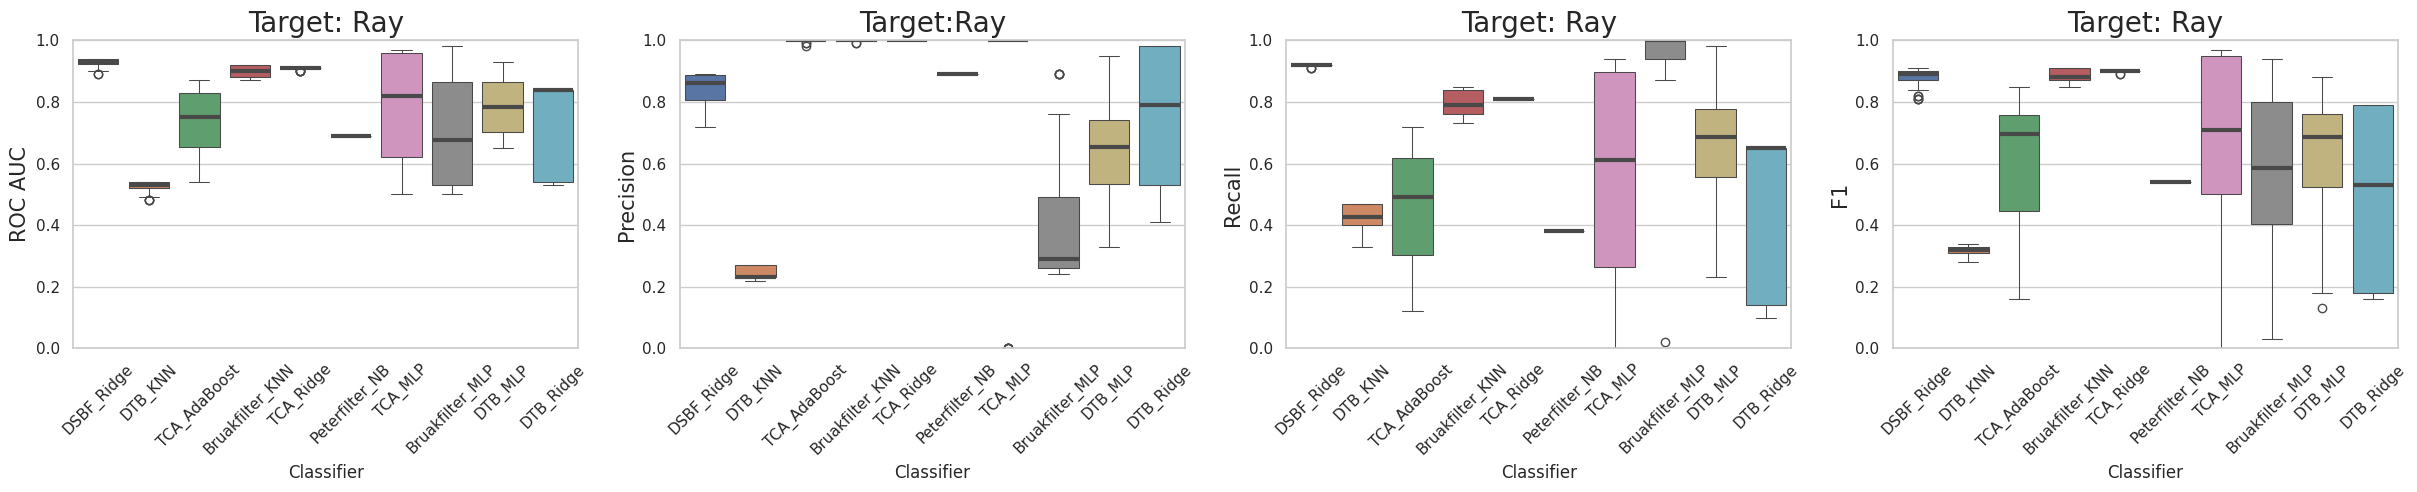

In [139]:
box_plots_ray(data_ray, data_ray_pre, data_ray_re, data_ray_f1)

## Target Project: Transformers

In [75]:
def data_loading_jt():
    # Load your dataset (replace X and y with your features and labels)

    jax_1_73 = pd.read_csv('../Dataset/jax_0.1.73.csv')
    jax_2_21 = pd.read_csv('../Dataset/jax_0.2.21.csv')
    jax_2_28 = pd.read_csv('../Dataset/jax_0.2.28.csv')
    jax_3_15 = pd.read_csv('../Dataset/jax_0.3.15.csv')
    
    
    jax_train_data = pd.concat([jax_1_73, jax_2_21, jax_2_28, jax_3_15])
    jax_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    transformers_2_0 = pd.read_csv('../Dataset/transformers_2.0.0.csv')
    transformers_3_5 = pd.read_csv('../Dataset/transformers_3.5.0.csv')
    transformers_4_13 = pd.read_csv('../Dataset/transformers_4.13.0.csv')
    transformers_4_23 = pd.read_csv('../Dataset/transformers_4.23.0.csv')
    
    
    transformers_test_data = pd.concat([transformers_2_0, transformers_3_5, transformers_4_13, transformers_4_23])
    transformers_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = jax_train_data.drop(columns='Buggy')
    Y_source = jax_train_data['Buggy']
    X_target = transformers_test_data.drop(columns='Buggy')
    Y_target = transformers_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

def data_loading_lt():
    # Load your dataset (replace X and y with your features and labels)
    lightning_0_5 = pd.read_csv('../Dataset/lightning_0.5.1.csv')
    lightning_1_0 = pd.read_csv('../Dataset/lightning_1.0.0.csv')
    lightning_1_5 = pd.read_csv('../Dataset/lightning_1.5.0.csv')
    lightning_1_8 = pd.read_csv('../Dataset/lightning_1.8.0.csv')
    
    
    lightning_train_data = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5, lightning_1_8])
    lightning_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    transformers_2_0 = pd.read_csv('../Dataset/transformers_2.0.0.csv')
    transformers_3_5 = pd.read_csv('../Dataset/transformers_3.5.0.csv')
    transformers_4_13 = pd.read_csv('../Dataset/transformers_4.13.0.csv')
    transformers_4_23 = pd.read_csv('../Dataset/transformers_4.23.0.csv')
    
    
    transformers_test_data = pd.concat([transformers_2_0, transformers_3_5, transformers_4_13, transformers_4_23])
    transformers_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = lightning_train_data.drop(columns='Buggy')
    Y_source = lightning_train_data['Buggy']
    X_target = transformers_test_data.drop(columns='Buggy')
    Y_target = transformers_test_data['Buggy']
    
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

def data_loading_rt():
    # Load your dataset (replace X and y with your features and labels)
    
    ray_0_3 = pd.read_csv('../Dataset/ray_0.3.0.csv')
    ray_0_6 = pd.read_csv('../Dataset/ray_0.6.1.csv')
    ray_0_8 = pd.read_csv('../Dataset/ray_0.8.0.csv')
    ray_1_1 = pd.read_csv('../Dataset/ray_1.1.0.csv')
    ray_1_9 = pd.read_csv('../Dataset/ray_1.9.0.csv')
    ray_2_0 = pd.read_csv('../Dataset/ray_2.0.0.csv')
    
    ray_train_data = pd.concat([ray_0_3, ray_0_6, ray_0_8, ray_1_1, ray_1_9, ray_2_0])
    ray_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    transformers_2_0 = pd.read_csv('../Dataset/transformers_2.0.0.csv')
    transformers_3_5 = pd.read_csv('../Dataset/transformers_3.5.0.csv')
    transformers_4_13 = pd.read_csv('../Dataset/transformers_4.13.0.csv')
    transformers_4_23 = pd.read_csv('../Dataset/transformers_4.23.0.csv')
    
    
    transformers_test_data = pd.concat([transformers_2_0, transformers_3_5, transformers_4_13, transformers_4_23])
    transformers_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = ray_train_data.drop(columns='Buggy')
    Y_source = ray_train_data['Buggy']
    X_target = transformers_test_data.drop(columns='Buggy')
    Y_target = transformers_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

def data_loading_yt():
    # Load your dataset (replace X and y with your features and labels)
    yolov5_4_0 = pd.read_csv('../Dataset/yolov5_4.0.csv')
    yolov5_6_0 = pd.read_csv('../Dataset/yolov5_6.0.csv')
    yolov5_7_0 = pd.read_csv('../Dataset/yolov5_7.0.csv')
    
    yolov5_train_data = pd.concat([yolov5_4_0, yolov5_6_0, yolov5_7_0])
    yolov5_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    transformers_2_0 = pd.read_csv('../Dataset/transformers_2.0.0.csv')
    transformers_3_5 = pd.read_csv('../Dataset/transformers_3.5.0.csv')
    transformers_4_13 = pd.read_csv('../Dataset/transformers_4.13.0.csv')
    transformers_4_23 = pd.read_csv('../Dataset/transformers_4.23.0.csv')
    
    
    transformers_test_data = pd.concat([transformers_2_0, transformers_3_5, transformers_4_13, transformers_4_23])
    transformers_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = yolov5_train_data.drop(columns='Buggy')
    Y_source = yolov5_train_data['Buggy']
    X_target = transformers_test_data.drop(columns='Buggy')
    Y_target = transformers_test_data['Buggy']
    
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

### Transformers - ROC_AUC

In [76]:

def transformers_roc_auc():
    # TCA-CART
    X_source, Y_source, X_target, Y_target = data_loading_lt()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on CART
    cart_trials = Trials()
    best_params_cart = fmin(
      fn=lambda search_space: objective_cart(search_space, X_source, Y_source, X_target, Y_target),
      space=cart_space,
      algo=algorithm,
      max_evals=50,
      trials=cart_trials)
    print("TCA_CART ROC: ", space_eval(cart_space, best_params_cart))
    tca_cart = [format(-result['loss'], '.2f') for result in cart_trials.results]

    #TCA-RandomForest
    X_source, Y_source, X_target, Y_target = data_loading_rt()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on RandomForest
    rf_trials = Trials()
    best_params_rf = fmin(
        fn=lambda search_space: objective_rf(search_space, X_source, Y_source, X_target, Y_target),
        space=rf_space,
        algo=algorithm,
        max_evals=50,
        trials=rf_trials)
    
    print("TCA-RandomForest ROC: ", space_eval(rf_space, best_params_rf))
    tca_rf = [format(-result['loss'], '.2f') for result in rf_trials.results]

    # Peterfilter-RandomForest
    X_source, Y_source, X_target, Y_target = data_loading_yt()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on RandomForest
    rf_trials = Trials()
    best_params_rf = fmin(
      fn=lambda search_space: objective_rf(search_space, X_source, Y_source, X_target, Y_target),
      space=rf_space,
      algo=algorithm,
      max_evals=50,
      trials=rf_trials)
    print("Peterfilter-RandomForest ROC: ", space_eval(rf_space, best_params_rf))
    peterfilter_rf = [format(-result['loss'], '.2f') for result in rf_trials.results]

    # Universal_Ridge
    X_source, Y_source, X_target, Y_target = data_loading_yt()
    universal = Universal()
    X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("Universal-Ridge ROC: ", space_eval(ridge_space, best_params_ridge))
    universal_ridge = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    # DSBF-Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_yt()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("DSBF - Naive Bayes ROC: ", space_eval(nb_space, best_params_nb))
    dsbf_nb = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # Bruakfilter- KNN
    X_source, Y_source, X_target, Y_target = data_loading_rt()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on KNN
    knn_trials = Trials()
    best_params_knn = fmin(
        fn=lambda search_space: objective_knn(search_space, X_source, Y_source, X_target, Y_target),
        space=knn_space,
        algo=algorithm,
        max_evals=50,
        trials=knn_trials)
    
    print("Bruakfilter - KNN ROC: ", space_eval(knn_space, best_params_knn))
    bruakfilter_knn = [format(-result['loss'], '.2f') for result in knn_trials.results]
    
    # DTB-MLP
    X_source, Y_source, X_target, Y_target = data_loading_rt()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DTB - MLP ROC: ", space_eval(mlp_space, best_params_mlp))
    dtb_mlp = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # Peterfilter-Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_rt()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("Peterfilter- Naive Bayes ROC: ", space_eval(nb_space, best_params_nb))
    peterfilter_nb = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # TCA - Ridge
    X_source, Y_source, X_target, Y_target = data_loading_jt()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("TCA - Ridge ROC:", space_eval(ridge_space, best_params_ridge))
    tca_ridge = [format(-result['loss'], '.2f') for result in ridge_trials.results]
    
    # DTB - Ridge
    X_source, Y_source, X_target, Y_target = data_loading_rt()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on SVM
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("DTB-Ridge ROC: ", space_eval(ridge_space, best_params_ridge))
    dtb_ridge = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    return tca_cart, tca_rf, peterfilter_rf, universal_ridge, dsbf_nb, bruakfilter_knn, dtb_mlp, peterfilter_nb, tca_ridge, dtb_ridge

In [77]:

tca_cart, tca_rf, peterfilter_rf, universal_ridge, dsbf_nb, bruakfilter_knn, dtb_mlp, peterfilter_nb, tca_ridge, dtb_ridge = transformers_roc_auc()
data_transformers = pd.DataFrame({
      'Classifier': ['TCA_CART'] * len(tca_cart) +
                    ['TCA_RF'] * len(tca_rf) +
                    ['Peterfilter_RF'] * len(peterfilter_rf) +
                    ['Universal_Ridge'] * len(universal_ridge) +
                    ['DSBF_NB'] * len(dsbf_nb) +
                    ['Bruakfilter_KNN'] * len(bruakfilter_knn) +
                    ['DTB_MLP'] * len(dtb_mlp) +
                    ['Peterfilter_NB'] * len(peterfilter_nb) +
                    ['TCA_Ridge'] * len(tca_ridge) +
                    ['DTB_Ridge'] * len(dtb_ridge),
      'ROC AUC': tca_cart + tca_rf + peterfilter_rf + universal_ridge + dsbf_nb + bruakfilter_knn + dtb_mlp + peterfilter_nb + tca_ridge + dtb_ridge
  })

data_transformers['ROC AUC'] = pd.to_numeric(data_transformers['ROC AUC'])
#violin_plots(data_jax)

(1820, 17)
(1820,)
(3839, 17)
(3839,)
100%|███████| 50/50 [00:00<00:00, 150.74trial/s, best loss: -0.9522714298989738]
TCA_CART ROC:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 8, 'splitter': 'random'}
(6778, 17)
(6778,)
(3839, 17)
(3839,)
100%|████████| 50/50 [00:04<00:00, 10.90trial/s, best loss: -0.9792394050827282]
TCA-RandomForest ROC:  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 0.4335224155279316, 'n_estimators': 10}
(103, 17)
(103,)
(3839, 17)
(3839,)
100%|███████████████████████| 50/50 [00:01<00:00, 28.16trial/s, best loss: -1.0]
Peterfilter-RandomForest ROC:  {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 0.4737057544317512, 'n_estimators': 2}
(103, 17)
(103,)
(3839, 17)
(3839,)
100%|████████| 50/50 [00:01<00:00, 32.76trial/s, best loss: -0.9335187471513092]
Universal-Ridge ROC:  {'alpha': 0.9958984858497714, 'm

In [78]:
%store data_transformers

Stored 'data_transformers' (DataFrame)


### Transformers - Precision

In [80]:

def transformers_precision():
    # TCA-CART
    X_source, Y_source, X_target, Y_target = data_loading_lt()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on CART
    cart_trials = Trials()
    best_params_cart = fmin(
      fn=lambda search_space: objective_cart_pre(search_space, X_source, Y_source, X_target, Y_target),
      space=cart_space,
      algo=algorithm,
      max_evals=50,
      trials=cart_trials)
    print("TCA_CART Precision: ", space_eval(cart_space, best_params_cart))
    tca_cart_pre = [format(-result['loss'], '.2f') for result in cart_trials.results]

    #TCA-RandomForest
    X_source, Y_source, X_target, Y_target = data_loading_rt()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on RandomForest
    rf_trials = Trials()
    best_params_rf = fmin(
        fn=lambda search_space: objective_rf_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=rf_space,
        algo=algorithm,
        max_evals=50,
        trials=rf_trials)
    
    print("TCA-RandomForest Precision: ", space_eval(rf_space, best_params_rf))
    tca_rf_pre = [format(-result['loss'], '.2f') for result in rf_trials.results]

    # Peterfilter-RandomForest
    X_source, Y_source, X_target, Y_target = data_loading_yt()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on RandomForest
    rf_trials = Trials()
    best_params_rf = fmin(
      fn=lambda search_space: objective_rf_pre(search_space, X_source, Y_source, X_target, Y_target),
      space=rf_space,
      algo=algorithm,
      max_evals=50,
      trials=rf_trials)
    print("Peterfilter-RandomForest Precision: ", space_eval(rf_space, best_params_rf))
    peterfilter_rf_pre = [format(-result['loss'], '.2f') for result in rf_trials.results]

    # Universal_Ridge
    X_source, Y_source, X_target, Y_target = data_loading_yt()
    universal = Universal()
    X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("Universal-Ridge Precision: ", space_eval(ridge_space, best_params_ridge))
    universal_ridge_pre = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    # DSBF-Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_yt()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("DSBF - Naive Bayes Precision: ", space_eval(nb_space, best_params_nb))
    dsbf_nb_pre = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # Bruakfilter- KNN
    X_source, Y_source, X_target, Y_target = data_loading_rt()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on KNN
    knn_trials = Trials()
    best_params_knn = fmin(
        fn=lambda search_space: objective_knn_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=knn_space,
        algo=algorithm,
        max_evals=50,
        trials=knn_trials)
    
    print("Bruakfilter - KNN Precision: ", space_eval(knn_space, best_params_knn))
    bruakfilter_knn_pre = [format(-result['loss'], '.2f') for result in knn_trials.results]
    
    # DTB-MLP
    X_source, Y_source, X_target, Y_target = data_loading_rt()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DTB - MLP Precision: ", space_eval(mlp_space, best_params_mlp))
    dtb_mlp_pre = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # Peterfilter-Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_rt()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("Peterfilter- Naive Bayes Precision: ", space_eval(nb_space, best_params_nb))
    peterfilter_nb_pre = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # TCA - Ridge
    X_source, Y_source, X_target, Y_target = data_loading_jt()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("TCA - Ridge Precision:", space_eval(ridge_space, best_params_ridge))
    tca_ridge_pre = [format(-result['loss'], '.2f') for result in ridge_trials.results]
    
    # DTB - Ridge
    X_source, Y_source, X_target, Y_target = data_loading_rt()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on SVM
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("DTB-Ridge Precision: ", space_eval(ridge_space, best_params_ridge))
    dtb_ridge_pre = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    return tca_cart_pre, tca_rf_pre, peterfilter_rf_pre, universal_ridge_pre, dsbf_nb_pre, bruakfilter_knn_pre, dtb_mlp_pre, peterfilter_nb_pre, tca_ridge_pre, dtb_ridge_pre

In [81]:

tca_cart_pre, tca_rf_pre, peterfilter_rf_pre, universal_ridge_pre, dsbf_nb_pre, bruakfilter_knn_pre, dtb_mlp_pre, peterfilter_nb_pre, tca_ridge_pre, dtb_ridge_pre = transformers_precision()
data_transformers_precision = pd.DataFrame({
      'Classifier': ['TCA_CART'] * len(tca_cart_pre) +
                    ['TCA_RF'] * len(tca_rf_pre) +
                    ['Peterfilter_RF'] * len(peterfilter_rf_pre) +
                    ['Universal_Ridge'] * len(universal_ridge_pre) +
                    ['DSBF_NB'] * len(dsbf_nb_pre) +
                    ['Bruakfilter_KNN'] * len(bruakfilter_knn_pre) +
                    ['DTB_MLP'] * len(dtb_mlp_pre) +
                    ['Peterfilter_NB'] * len(peterfilter_nb_pre) +
                    ['TCA_Ridge'] * len(tca_ridge_pre) +
                    ['DTB_Ridge'] * len(dtb_ridge_pre),
      'Precision': tca_cart_pre + tca_rf_pre + peterfilter_rf_pre + universal_ridge_pre + dsbf_nb_pre + bruakfilter_knn_pre + dtb_mlp_pre + peterfilter_nb_pre + tca_ridge_pre + dtb_ridge_pre
  })

data_transformers_precision['Precision'] = pd.to_numeric(data_transformers_precision['Precision'])
#violin_plots(data_jax)

(1820, 17)
(1820,)
(3839, 17)
(3839,)
100%|██████████████████████| 50/50 [00:00<00:00, 143.58trial/s, best loss: -1.0]
TCA_CART Precision:  {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_split': 3, 'splitter': 'random'}
(6778, 17)
(6778,)
(3839, 17)
(3839,)
100%|████████| 50/50 [00:05<00:00,  9.46trial/s, best loss: -0.9927007299270073]
TCA-RandomForest Precision:  {'criterion': 'gini', 'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 0.053838689779950655, 'n_estimators': 47}
(103, 17)
(103,)
(3839, 17)
(3839,)
100%|███████████████████████| 50/50 [00:01<00:00, 31.36trial/s, best loss: -1.0]
Peterfilter-RandomForest Precision:  {'criterion': 'entropy', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 0.5788887055533342, 'n_estimators': 2}
(103, 17)
(103,)
(3839, 17)
(3839,)
100%|███████| 50/50 [00:02<00:00, 22.90trial/s, best loss: -0.37349397590361444]
Universal-Ridge Precision:  {'alpha': 0

In [82]:
%store data_transformers_precision

Stored 'data_transformers_precision' (DataFrame)


### Transformers - Recall

In [83]:

def transformers_recall():
    # TCA-CART
    X_source, Y_source, X_target, Y_target = data_loading_lt()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on CART
    cart_trials = Trials()
    best_params_cart = fmin(
      fn=lambda search_space: objective_cart_re(search_space, X_source, Y_source, X_target, Y_target),
      space=cart_space,
      algo=algorithm,
      max_evals=50,
      trials=cart_trials)
    print("TCA_CART Recall: ", space_eval(cart_space, best_params_cart))
    tca_cart_re = [format(-result['loss'], '.2f') for result in cart_trials.results]

    #TCA-RandomForest
    X_source, Y_source, X_target, Y_target = data_loading_rt()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on RandomForest
    rf_trials = Trials()
    best_params_rf = fmin(
        fn=lambda search_space: objective_rf_re(search_space, X_source, Y_source, X_target, Y_target),
        space=rf_space,
        algo=algorithm,
        max_evals=50,
        trials=rf_trials)
    
    print("TCA-RandomForest Recall: ", space_eval(rf_space, best_params_rf))
    tca_rf_re = [format(-result['loss'], '.2f') for result in rf_trials.results]

    # Peterfilter-RandomForest
    X_source, Y_source, X_target, Y_target = data_loading_yt()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on RandomForest
    rf_trials = Trials()
    best_params_rf = fmin(
      fn=lambda search_space: objective_rf_re(search_space, X_source, Y_source, X_target, Y_target),
      space=rf_space,
      algo=algorithm,
      max_evals=50,
      trials=rf_trials)
    print("Peterfilter-RandomForest Recall: ", space_eval(rf_space, best_params_rf))
    peterfilter_rf_re = [format(-result['loss'], '.2f') for result in rf_trials.results]

    # Universal_Ridge
    X_source, Y_source, X_target, Y_target = data_loading_yt()
    universal = Universal()
    X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_re(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("Universal-Ridge Recall: ", space_eval(ridge_space, best_params_ridge))
    universal_ridge_re = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    # DSBF-Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_yt()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_re(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("DSBF - Naive Bayes Recall: ", space_eval(nb_space, best_params_nb))
    dsbf_nb_re = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # Bruakfilter- KNN
    X_source, Y_source, X_target, Y_target = data_loading_rt()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on KNN
    knn_trials = Trials()
    best_params_knn = fmin(
        fn=lambda search_space: objective_knn_re(search_space, X_source, Y_source, X_target, Y_target),
        space=knn_space,
        algo=algorithm,
        max_evals=50,
        trials=knn_trials)
    
    print("Bruakfilter - KNN Recall: ", space_eval(knn_space, best_params_knn))
    bruakfilter_knn_re = [format(-result['loss'], '.2f') for result in knn_trials.results]
    
    # DTB-MLP
    X_source, Y_source, X_target, Y_target = data_loading_rt()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_re(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DTB - MLP Recall: ", space_eval(mlp_space, best_params_mlp))
    dtb_mlp_re = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # Peterfilter-Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_rt()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_re(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("Peterfilter- Naive Bayes Recall: ", space_eval(nb_space, best_params_nb))
    peterfilter_nb_re = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # TCA - Ridge
    X_source, Y_source, X_target, Y_target = data_loading_jt()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_re(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("TCA - Ridge Recall:", space_eval(ridge_space, best_params_ridge))
    tca_ridge_re = [format(-result['loss'], '.2f') for result in ridge_trials.results]
    
    # DTB - Ridge
    X_source, Y_source, X_target, Y_target = data_loading_rt()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on SVM
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_re(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("DTB-Ridge Recall: ", space_eval(ridge_space, best_params_ridge))
    dtb_ridge_re = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    return tca_cart_re, tca_rf_re, peterfilter_rf_re, universal_ridge_re, dsbf_nb_re, bruakfilter_knn_re, dtb_mlp_re, peterfilter_nb_re, tca_ridge_re, dtb_ridge_re

In [85]:

tca_cart_re, tca_rf_re, peterfilter_rf_re, universal_ridge_re, dsbf_nb_re, bruakfilter_knn_re, dtb_mlp_re, peterfilter_nb_re, tca_ridge_re, dtb_ridge_re = transformers_recall()
data_transformers_recall = pd.DataFrame({
      'Classifier': ['TCA_CART'] * len(tca_cart_re) +
                    ['TCA_RF'] * len(tca_rf_re) +
                    ['Peterfilter_RF'] * len(peterfilter_rf_re) +
                    ['Universal_Ridge'] * len(universal_ridge_re) +
                    ['DSBF_NB'] * len(dsbf_nb_re) +
                    ['Bruakfilter_KNN'] * len(bruakfilter_knn_re) +
                    ['DTB_MLP'] * len(dtb_mlp_re) +
                    ['Peterfilter_NB'] * len(peterfilter_nb_re) +
                    ['TCA_Ridge'] * len(tca_ridge_re) +
                    ['DTB_Ridge'] * len(dtb_ridge_re),
      'Recall': tca_cart_re + tca_rf_re + peterfilter_rf_re + universal_ridge_re + dsbf_nb_re + bruakfilter_knn_re + dtb_mlp_re + peterfilter_nb_re + tca_ridge_re + dtb_ridge_re
  })

data_transformers_recall['Recall'] = pd.to_numeric(data_transformers_recall['Recall'])
#violin_plots(data_jax)

(1820, 17)
(1820,)
(3839, 17)
(3839,)
100%|██████████████████████| 50/50 [00:00<00:00, 118.58trial/s, best loss: -1.0]
TCA_CART Recall:  {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 9, 'splitter': 'best'}
(6778, 17)
(6778,)
(3839, 17)
(3839,)
100%|███████████████████████| 50/50 [00:06<00:00,  8.32trial/s, best loss: -1.0]
TCA-RandomForest Recall:  {'criterion': 'gini', 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 0.28044493791111835, 'n_estimators': 31}
(103, 17)
(103,)
(3839, 17)
(3839,)
100%|███████████████████████| 50/50 [00:02<00:00, 23.82trial/s, best loss: -1.0]
Peterfilter-RandomForest Recall:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 0.9871525347862071, 'n_estimators': 49}
(103, 17)
(103,)
(3839, 17)
(3839,)
100%|████████| 50/50 [00:01<00:00, 25.53trial/s, best loss: -0.9841269841269841]
Universal-Ridge Recall:  {'alpha': 0.51633791

In [86]:
%store data_transformers_recall

Stored 'data_transformers_recall' (DataFrame)


### Transformers - F1

In [89]:

def transformers_f1():
    # TCA-CART
    X_source, Y_source, X_target, Y_target = data_loading_lt()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on CART
    cart_trials = Trials()
    best_params_cart = fmin(
      fn=lambda search_space: objective_cart_f1(search_space, X_source, Y_source, X_target, Y_target),
      space=cart_space,
      algo=algorithm,
      max_evals=50,
      trials=cart_trials)
    print("TCA_CART F1: ", space_eval(cart_space, best_params_cart))
    tca_cart_f1 = [format(-result['loss'], '.2f') for result in cart_trials.results]

    #TCA-RandomForest
    X_source, Y_source, X_target, Y_target = data_loading_rt()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on RandomForest
    rf_trials = Trials()
    best_params_rf = fmin(
        fn=lambda search_space: objective_rf_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=rf_space,
        algo=algorithm,
        max_evals=50,
        trials=rf_trials)
    
    print("TCA-RandomForest f1: ", space_eval(rf_space, best_params_rf))
    tca_rf_f1 = [format(-result['loss'], '.2f') for result in rf_trials.results]

    # Peterfilter-RandomForest
    X_source, Y_source, X_target, Y_target = data_loading_yt()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on RandomForest
    rf_trials = Trials()
    best_params_rf = fmin(
      fn=lambda search_space: objective_rf_f1(search_space, X_source, Y_source, X_target, Y_target),
      space=rf_space,
      algo=algorithm,
      max_evals=50,
      trials=rf_trials)
    print("Peterfilter-RandomForest F1: ", space_eval(rf_space, best_params_rf))
    peterfilter_rf_f1 = [format(-result['loss'], '.2f') for result in rf_trials.results]

    # Universal_Ridge
    X_source, Y_source, X_target, Y_target = data_loading_yt()
    universal = Universal()
    X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("Universal-Ridge F1: ", space_eval(ridge_space, best_params_ridge))
    universal_ridge_f1 = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    # DSBF-Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_yt()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("DSBF - Naive Bayes F1: ", space_eval(nb_space, best_params_nb))
    dsbf_nb_f1 = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # Bruakfilter- KNN
    X_source, Y_source, X_target, Y_target = data_loading_rt()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on KNN
    knn_trials = Trials()
    best_params_knn = fmin(
        fn=lambda search_space: objective_knn_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=knn_space,
        algo=algorithm,
        max_evals=50,
        trials=knn_trials)
    
    print("Bruakfilter - KNN F1: ", space_eval(knn_space, best_params_knn))
    bruakfilter_knn_f1 = [format(-result['loss'], '.2f') for result in knn_trials.results]
    
    # DTB-MLP
    X_source, Y_source, X_target, Y_target = data_loading_rt()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DTB - MLP F1: ", space_eval(mlp_space, best_params_mlp))
    dtb_mlp_f1 = [format(-result['loss'], '.2f') for result in mlp_trials.results]
    
    # Peterfilter-Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_rt()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("Peterfilter- Naive Bayes F1: ", space_eval(nb_space, best_params_nb))
    peterfilter_nb_f1 = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # TCA - Ridge
    X_source, Y_source, X_target, Y_target = data_loading_jt()
    tca = TCA()
    X_source, Y_source, X_target, Y_target = tca.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("TCA - Ridge F1:", space_eval(ridge_space, best_params_ridge))
    tca_ridge_f1 = [format(-result['loss'], '.2f') for result in ridge_trials.results]
    
    # DTB - Ridge
    X_source, Y_source, X_target, Y_target = data_loading_rt()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on SVM
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("DTB-Ridge F1: ", space_eval(ridge_space, best_params_ridge))
    dtb_ridge_f1 = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    return tca_cart_f1, tca_rf_f1, peterfilter_rf_f1, universal_ridge_f1, dsbf_nb_f1, bruakfilter_knn_f1, dtb_mlp_f1, peterfilter_nb_f1, tca_ridge_f1, dtb_ridge_f1

In [90]:

tca_cart_f1, tca_rf_f1, peterfilter_rf_f1, universal_ridge_f1, dsbf_nb_f1, bruakfilter_knn_f1, dtb_mlp_f1, peterfilter_nb_f1, tca_ridge_f1, dtb_svm_f1 = transformers_f1()


(1820, 17)
(1820,)
(3839, 17)
(3839,)
100%|████████| 50/50 [00:00<00:00, 76.46trial/s, best loss: -0.9083665338645418]
TCA_CART F1:  {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_split': 2, 'splitter': 'random'}
(6778, 17)
(6778,)
(3839, 17)
(3839,)
100%|████████| 50/50 [00:05<00:00,  9.99trial/s, best loss: -0.9028571428571429]
TCA-RandomForest f1:  {'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 0.008231116418497497, 'n_estimators': 12}
(103, 17)
(103,)
(3839, 17)
(3839,)
100%|███████████████████████| 50/50 [00:01<00:00, 29.93trial/s, best loss: -1.0]
Peterfilter-RandomForest F1:  {'criterion': 'entropy', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 0.17107550897875945, 'n_estimators': 1}
(103, 17)
(103,)
(3839, 17)
(3839,)
100%|████████| 50/50 [00:01<00:00, 25.10trial/s, best loss: -0.5414847161572053]
Universal-Ridge F1:  {'alpha': 0.9912891402244214, 'max_i

KeyError: 'F1'

In [91]:
data_transformers_f1 = pd.DataFrame({
      'Classifier': ['TCA_CART'] * len(tca_cart_f1) +
                    ['TCA_RF'] * len(tca_rf_f1) +
                    ['Peterfilter_RF'] * len(peterfilter_rf_f1) +
                    ['Universal_Ridge'] * len(universal_ridge_f1) +
                    ['DSBF_NB'] * len(dsbf_nb_f1) +
                    ['Bruakfilter_KNN'] * len(bruakfilter_knn_f1) +
                    ['DTB_MLP'] * len(dtb_mlp_f1) +
                    ['Peterfilter_NB'] * len(peterfilter_nb_f1) +
                    ['TCA_Ridge'] * len(tca_ridge_f1) +
                    ['DTB_Ridge'] * len(dtb_ridge_f1),
      'F1': tca_cart_f1 + tca_rf_f1 + peterfilter_rf_f1 + universal_ridge_f1 + dsbf_nb_f1 + bruakfilter_knn_f1 + dtb_mlp_f1 + peterfilter_nb_f1 + tca_ridge_f1 + dtb_ridge_f1
  })

data_transformers_f1['F1'] = pd.to_numeric(data_transformers_f1['F1'])
#violin_plots(data_jax)

In [92]:
%store data_transformers_f1

Stored 'data_transformers_f1' (DataFrame)


### Transformers - Boxplot

In [93]:
grouped_stats = data_transformers.groupby('Classifier')['ROC AUC'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_transformers_precision.groupby('Classifier')['Precision'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_transformers_recall.groupby('Classifier')['Recall'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_transformers_f1.groupby('Classifier')['F1'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')

                   mean  median       std
Classifier                               
Bruakfilter_KNN  0.7996   0.805  0.056023
DSBF_NB          0.9300   0.930  0.000000
DTB_MLP          0.7394   0.745  0.095435
DTB_Ridge        0.6372   0.630  0.069283
Peterfilter_NB   0.8100   0.810  0.000000
Peterfilter_RF   0.7900   0.865  0.208933
TCA_CART         0.8350   0.815  0.070776
TCA_RF           0.7850   0.890  0.196855
TCA_Ridge        0.9400   0.940  0.000000
Universal_Ridge  0.9300   0.930  0.000000
-------------------------------------
                   mean  median       std
Classifier                               
Bruakfilter_KNN  0.9674   0.970  0.038535
DSBF_NB          0.3700   0.370  0.000000
DTB_MLP          0.3486   0.275  0.235545
DTB_Ridge        0.1848   0.170  0.046521
Peterfilter_NB   0.1700   0.170  0.000000
Peterfilter_RF   0.3542   0.205  0.354528
TCA_CART         0.5060   0.305  0.384846
TCA_RF           0.5590   0.465  0.369695
TCA_Ridge        1.0000   1.000  0.000

In [136]:
# For target transformers
def box_plots_transformers(data_transformers_roc, data_transformers_precision, data_transformers_recall, data_transformers_f1):

    classifier_order = data_transformers_roc['Classifier'].unique()
    num_classifiers = len(classifier_order)
    color_palette = sns.color_palette("deep", num_classifiers)
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30, 4))
    sns.set(style='whitegrid')
    # sns.color_palette("pastel")

    

    # Plot box plots
    sns.boxplot(x='Classifier', y='ROC AUC', data=data_transformers_roc, order=classifier_order, palette=color_palette, ax=axes[0], linewidth=0.75, medianprops={"linewidth": 3})
    axes[0].set_title('Target: Transformers', fontsize=20)
    axes[0].set_ylim(0, 1)
    axes[0].set_ylabel('ROC AUC', fontsize=15)

    sns.boxplot(x='Classifier', y='Precision', data=data_transformers_precision, order=classifier_order, palette=color_palette, ax=axes[1], linewidth=0.75, medianprops={"linewidth": 3})
    axes[1].set_title('Target: Transformers', fontsize=20)
    axes[1].set_ylim(0, 1)
    axes[1].set_ylabel('Precision', fontsize=15)

    sns.boxplot(x='Classifier', y='Recall', data=data_transformers_recall, order=classifier_order, palette=color_palette, ax=axes[2], linewidth=0.75, medianprops={"linewidth": 3})
    axes[2].set_title('Target: Transformers', fontsize=20)
    axes[2].set_ylim(0, 1)
    axes[2].set_ylabel('Recall', fontsize=15)

    sns.boxplot(x='Classifier', y='F1', data=data_transformers_f1, order=classifier_order, palette=color_palette, ax=axes[3], linewidth=0.75, medianprops={"linewidth": 3})
    axes[3].set_title('Target: Transformers', fontsize=20)
    axes[3].set_ylim(0, 1)
    axes[3].set_ylabel('F1', fontsize=15)

    for ax in axes:
        for line in ax.lines:
            if np.array_equal(line.get_xdata(), [0, 1]):  # Check if the line represents the median
                line.set_linewidth(2)  # Set line width to bold


    # Tilt x-axis labels
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
        
    plt.savefig('cpdp_results_transformers_boxplots.png', bbox_inches='tight')
    plt.show()

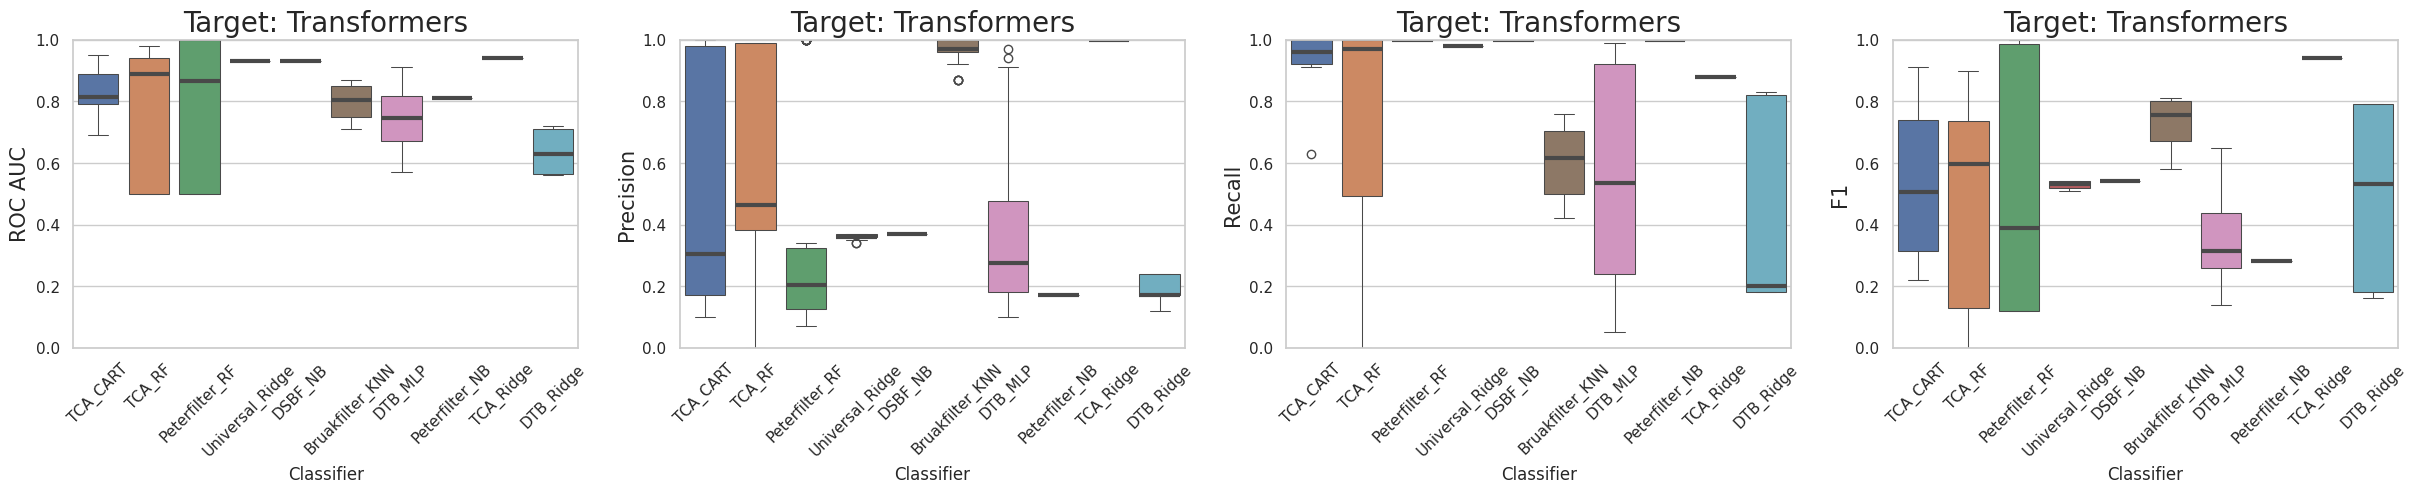

In [137]:
box_plots_transformers(data_transformers, data_transformers_precision, data_transformers_recall, data_transformers_f1)

## Target Project: Yolov5

In [96]:
def data_loading_jy():
    # Load your dataset (replace X and y with your features and labels)
    jax_1_73 = pd.read_csv('../Dataset/jax_0.1.73.csv')
    jax_2_21 = pd.read_csv('../Dataset/jax_0.2.21.csv')
    jax_2_28 = pd.read_csv('../Dataset/jax_0.2.28.csv')
    jax_3_15 = pd.read_csv('../Dataset/jax_0.3.15.csv')
    
    
    jax_train_data = pd.concat([jax_1_73, jax_2_21, jax_2_28, jax_3_15])
    jax_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    yolov5_4_0 = pd.read_csv('../Dataset/yolov5_4.0.csv')
    yolov5_6_0 = pd.read_csv('../Dataset/yolov5_6.0.csv')
    yolov5_7_0 = pd.read_csv('../Dataset/yolov5_7.0.csv')
    
    yolov5_test_data = pd.concat([yolov5_4_0, yolov5_6_0, yolov5_7_0])
    yolov5_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = jax_train_data.drop(columns='Buggy')
    Y_source = jax_train_data['Buggy']
    X_target = yolov5_test_data.drop(columns='Buggy')
    Y_target = yolov5_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

def data_loading_ly():
    # Load your dataset (replace X and y with your features and labels)
    lightning_0_5 = pd.read_csv('../Dataset/lightning_0.5.1.csv')
    lightning_1_0 = pd.read_csv('../Dataset/lightning_1.0.0.csv')
    lightning_1_5 = pd.read_csv('../Dataset/lightning_1.5.0.csv')
    lightning_1_8 = pd.read_csv('../Dataset/lightning_1.8.0.csv')
    
    
    lightning_train_data = pd.concat([lightning_0_5, lightning_1_0, lightning_1_5, lightning_1_8])
    lightning_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    yolov5_4_0 = pd.read_csv('../Dataset/yolov5_4.0.csv')
    yolov5_6_0 = pd.read_csv('../Dataset/yolov5_6.0.csv')
    yolov5_7_0 = pd.read_csv('../Dataset/yolov5_7.0.csv')
    
    yolov5_test_data = pd.concat([yolov5_4_0, yolov5_6_0, yolov5_7_0])
    yolov5_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = lightning_train_data.drop(columns='Buggy')
    Y_source = lightning_train_data['Buggy']
    X_target = yolov5_test_data.drop(columns='Buggy')
    Y_target = yolov5_test_data['Buggy']
    
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target


def data_loading_ry():
    # Load your dataset (replace X and y with your features and labels)    
    ray_0_3 = pd.read_csv('../Dataset/ray_0.3.0.csv')
    ray_0_6 = pd.read_csv('../Dataset/ray_0.6.1.csv')
    ray_0_8 = pd.read_csv('../Dataset/ray_0.8.0.csv')
    ray_1_1 = pd.read_csv('../Dataset/ray_1.1.0.csv')
    ray_1_9 = pd.read_csv('../Dataset/ray_1.9.0.csv')
    ray_2_0 = pd.read_csv('../Dataset/ray_2.0.0.csv')
    
    ray_train_data = pd.concat([ray_0_3, ray_0_6, ray_0_8, ray_1_1, ray_1_9, ray_2_0])
    ray_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)

    yolov5_4_0 = pd.read_csv('../Dataset/yolov5_4.0.csv')
    yolov5_6_0 = pd.read_csv('../Dataset/yolov5_6.0.csv')
    yolov5_7_0 = pd.read_csv('../Dataset/yolov5_7.0.csv')
    
    yolov5_test_data = pd.concat([yolov5_4_0, yolov5_6_0, yolov5_7_0])
    yolov5_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = ray_train_data.drop(columns='Buggy')
    Y_source = ray_train_data['Buggy']
    X_target = yolov5_test_data.drop(columns='Buggy')
    Y_target = yolov5_test_data['Buggy']
    
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

def data_loading_ty():
    # Load your dataset (replace X and y with your features and labels)
    transformers_2_0 = pd.read_csv('../Dataset/transformers_2.0.0.csv')
    transformers_3_5 = pd.read_csv('../Dataset/transformers_3.5.0.csv')
    transformers_4_13 = pd.read_csv('../Dataset/transformers_4.13.0.csv')
    transformers_4_23 = pd.read_csv('../Dataset/transformers_4.23.0.csv')
    
    
    transformers_train_data = pd.concat([transformers_2_0, transformers_3_5, transformers_4_13, transformers_4_23])
    transformers_train_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    
    
    yolov5_4_0 = pd.read_csv('../Dataset/yolov5_4.0.csv')
    yolov5_6_0 = pd.read_csv('../Dataset/yolov5_6.0.csv')
    yolov5_7_0 = pd.read_csv('../Dataset/yolov5_7.0.csv')
    
    yolov5_test_data = pd.concat([yolov5_4_0, yolov5_6_0, yolov5_7_0])
    yolov5_test_data.drop(['Unnamed: 0','Project', 'Files'], axis=1, inplace=True)
    
    X_source = transformers_train_data.drop(columns='Buggy')
    Y_source = transformers_train_data['Buggy']
    X_target = yolov5_test_data.drop(columns='Buggy')
    Y_target = yolov5_test_data['Buggy']
    
    print(X_source.shape)
    print(Y_source.shape)
    print(X_target.shape)
    print(Y_target.shape)
    X_source = X_source.to_numpy()
    X_target = X_target.to_numpy()
    Y_source = Y_source.to_numpy()
    Y_target = Y_target.to_numpy()
    return X_source, Y_source, X_target, Y_target

### Yolov5 - ROC_AUC

In [97]:

def yolov5_roc_auc():
    # DTB-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_ry()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
      fn=lambda search_space: objective_ridge(search_space, X_source, Y_source, X_target, Y_target),
      space=ridge_space,
      algo=algorithm,
      max_evals=50,
      trials=ridge_trials)
    print("DTB-Ridge ROC_AUC: ", space_eval(ridge_space, best_params_ridge))
    dtb_ridge = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    # Data Selection - Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_ly()
    ds = DataSelection()
    loc = [0]
    X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("DataSelection - Naive Bayes ROC_AUC: ", space_eval(nb_space, best_params_nb))
    ds_nb = [format(-result['loss'], '.2f') for result in nb_trials.results]

    # Bruakfilter - KNN
    X_source, Y_source, X_target, Y_target = data_loading_ry()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on KNN
    knn_trials = Trials()
    best_params_knn = fmin(
      fn=lambda search_space: objective_knn(search_space, X_source, Y_source, X_target, Y_target),
      space=knn_space,
      algo=algorithm,
      max_evals=50,
      trials=knn_trials)
    print("Bruakfilter - KNN ROC_AUC: ", space_eval(knn_space, best_params_knn))
    bruakfilter_knn = [format(-result['loss'], '.2f') for result in knn_trials.results]

    # DSBF - MLP
    X_source, Y_source, X_target, Y_target = data_loading_ty()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DSBF-MLP ROC_AUC: ", space_eval(mlp_space, best_params_mlp))
    dsbf_mlp = [format(-result['loss'], '.2f') for result in mlp_trials.results]

    # Peterfilter - NB
    X_source, Y_source, X_target, Y_target = data_loading_jy()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on NB
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("Peterfilter - NB ROC_AUC: ", space_eval(nb_space, best_params_nb))
    peterfilter_nb = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # DSBF - Ridge
    X_source, Y_source, X_target, Y_target = data_loading_ly()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("DSBF-Ridge ROC_AUC", space_eval(ridge_space, best_params_ridge))
    dsbf_ridge = [format(-result['loss'], '.2f') for result in ridge_trials.results]
    
    # Universal - AdaBoost
    X_source, Y_source, X_target, Y_target = data_loading_ry()
    universal = Universal()
    X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on AdaBoost
    ada_trials = Trials()
    best_params_ada = fmin(
        fn=lambda search_space: objective_ada(search_space, X_source, Y_source, X_target, Y_target),
        space=ada_space,
        algo=algorithm,
        max_evals=50,
        trials=ada_trials)
    
    print("Universal - AdaBoost ROC_AUC: ", space_eval(ada_space, best_params_ada))
    universal_ada = [format(-result['loss'], '.2f') for result in ada_trials.results]
    
    # DS - Random Forest
    X_source, Y_source, X_target, Y_target = data_loading_ty()
    ds = DataSelection()
    loc = [0]
    X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
    #implement Hyperopt on Random Forest
    rf_trials = Trials()
    best_params_rf = fmin(
        fn=lambda search_space: objective_rf(search_space, X_source, Y_source, X_target, Y_target),
        space=rf_space,
        algo=algorithm,
        max_evals=50,
        trials=rf_trials)
    
    print("DS - Random Forest ROC_AUC: ", space_eval(rf_space, best_params_rf))
    ds_rf = [format(-result['loss'], '.2f') for result in rf_trials.results]
    
    # DTB - Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_ry()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("DTB-Naive Bayes ROC_AUC: ", space_eval(nb_space, best_params_nb))
    dtb_nb = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # Peterfilter - Ridge
    X_source, Y_source, X_target, Y_target = data_loading_ly()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("Peterfilter- Ridge ROC_AUC: ", space_eval(ridge_space, best_params_ridge))
    peterfilter_ridge = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    return dtb_ridge, ds_nb, bruakfilter_knn, dsbf_mlp, peterfilter_nb, dsbf_ridge, universal_ada, ds_rf, dtb_nb, peterfilter_ridge

In [98]:

dtb_ridge, ds_nb, bruakfilter_knn, dsbf_mlp, peterfilter_nb, dsbf_ridge, universal_ada, ds_rf, dtb_nb, peterfiler_ridge = yolov5_roc_auc()
data_yolov5 = pd.DataFrame({
      'Classifier': ['DTB_Ridge'] * len(dtb_ridge) +
                    ['DS_NB'] * len(ds_nb) +
                    ['Bruakfilter_KNN'] * len(bruakfilter_knn) +
                    ['DSBF_MLP'] * len(dsbf_mlp) +
                    ['Peterfilter_NB'] * len(peterfilter_nb) +
                    ['DSBF_Ridge'] * len(dsbf_ridge) +
                    ['Universal_AdaBoost'] * len(universal_ada) +
                    ['DS_RF'] * len(ds_rf) +
                    ['DTB_NB'] * len(dtb_nb) +
                    ['Peterfilter_Ridge'] * len(peterfilter_ridge),
      'ROC AUC': dtb_ridge + ds_nb + bruakfilter_knn + dsbf_mlp + peterfilter_nb + dsbf_ridge + universal_ada + ds_rf + dtb_nb + peterfilter_ridge
  })

data_yolov5['ROC AUC'] = pd.to_numeric(data_yolov5['ROC AUC'])
#violin_plots(data_jax)

(6778, 17)
(6778,)
(103, 17)
(103,)
100%|████████| 50/50 [00:08<00:00,  5.64trial/s, best loss: -0.7854147250698975]
DTB-Ridge ROC_AUC:  {'alpha': 0.5663041059232256, 'max_iter': 4009, 'solver': 'cholesky'}
(1820, 17)
(1820,)
(103, 17)
(103,)
100%|███████| 50/50 [00:00<00:00, 358.27trial/s, best loss: -0.9175209692451072]
DataSelection - Naive Bayes ROC_AUC:  {'var_smoothing': 1e-09}
(6778, 17)
(6778,)
(103, 17)
(103,)
100%|███████| 50/50 [00:00<00:00, 117.36trial/s, best loss: -0.9256756756756757]
Bruakfilter - KNN ROC_AUC:  {'algorithm': 'brute', 'n_neighbors': 14}
(3839, 17)
(3839,)
(103, 17)
(103,)
100%|████████| 50/50 [00:04<00:00, 11.85trial/s, best loss: -0.9272727272727272]
DSBF-MLP ROC_AUC:  {'activation': 'identity', 'alpha': 0.0024593683032908564, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 86}
(1266, 17)
(1266,)
(103, 17)
(103,)
100%|███████| 50/50 [00:00<00:00, 396.33trial/s, best loss: -0.8040540540540541]
Peterfilter - NB ROC_AUC:  {'var_smoo

### Yolov5 - Precision

In [99]:

def yolov5_precision():
    # DTB-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_ry()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
      fn=lambda search_space: objective_ridge_pre(search_space, X_source, Y_source, X_target, Y_target),
      space=ridge_space,
      algo=algorithm,
      max_evals=50,
      trials=ridge_trials)
    print("DTB-Ridge Precision: ", space_eval(ridge_space, best_params_ridge))
    dtb_ridge_pre = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    # Data Selection - Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_ly()
    ds = DataSelection()
    loc = [0]
    X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("DataSelection - Naive Bayes Precision: ", space_eval(nb_space, best_params_nb))
    ds_nb_pre = [format(-result['loss'], '.2f') for result in nb_trials.results]

    # Bruakfilter - KNN
    X_source, Y_source, X_target, Y_target = data_loading_ry()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on KNN
    knn_trials = Trials()
    best_params_knn = fmin(
      fn=lambda search_space: objective_knn_pre(search_space, X_source, Y_source, X_target, Y_target),
      space=knn_space,
      algo=algorithm,
      max_evals=50,
      trials=knn_trials)
    print("Bruakfilter - KNN Precision: ", space_eval(knn_space, best_params_knn))
    bruakfilter_knn_pre = [format(-result['loss'], '.2f') for result in knn_trials.results]

    # DSBF - MLP
    X_source, Y_source, X_target, Y_target = data_loading_ty()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DSBF-MLP Precision: ", space_eval(mlp_space, best_params_mlp))
    dsbf_mlp_pre = [format(-result['loss'], '.2f') for result in mlp_trials.results]

    # Peterfilter - NB
    X_source, Y_source, X_target, Y_target = data_loading_jy()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on NB
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("Peterfilter - NB Precision: ", space_eval(nb_space, best_params_nb))
    peterfilter_nb_pre = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # DSBF - Ridge
    X_source, Y_source, X_target, Y_target = data_loading_ly()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("DSBF-Ridge Precision", space_eval(ridge_space, best_params_ridge))
    dsbf_ridge_pre = [format(-result['loss'], '.2f') for result in ridge_trials.results]
    
    # Universal - AdaBoost
    X_source, Y_source, X_target, Y_target = data_loading_ry()
    universal = Universal()
    X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on AdaBoost
    ada_trials = Trials()
    best_params_ada = fmin(
        fn=lambda search_space: objective_ada_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=ada_space,
        algo=algorithm,
        max_evals=50,
        trials=ada_trials)
    
    print("Universal - AdaBoost Precision: ", space_eval(ada_space, best_params_ada))
    universal_ada_pre = [format(-result['loss'], '.2f') for result in ada_trials.results]
    
    # DS - Random Forest
    X_source, Y_source, X_target, Y_target = data_loading_ty()
    ds = DataSelection()
    loc = [0]
    X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
    #implement Hyperopt on Random Forest
    rf_trials = Trials()
    best_params_rf = fmin(
        fn=lambda search_space: objective_rf_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=rf_space,
        algo=algorithm,
        max_evals=50,
        trials=rf_trials)
    
    print("DS - Random Forest Precision: ", space_eval(rf_space, best_params_rf))
    ds_rf_pre = [format(-result['loss'], '.2f') for result in rf_trials.results]
    
    # DTB - Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_ry()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("DTB-Naive Bayes Precision: ", space_eval(nb_space, best_params_nb))
    dtb_nb_pre = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # Peterfilter - Ridge
    X_source, Y_source, X_target, Y_target = data_loading_ly()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_pre(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("Peterfilter- Ridge Precision: ", space_eval(ridge_space, best_params_ridge))
    peterfilter_ridge_pre = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    return dtb_ridge_pre, ds_nb_pre, bruakfilter_knn_pre, dsbf_mlp_pre, peterfilter_nb_pre, dsbf_ridge_pre, universal_ada_pre, ds_rf_pre, dtb_nb_pre, peterfilter_ridge_pre

In [100]:

dtb_ridge_pre, ds_nb_pre, bruakfilter_knn_pre, dsbf_mlp_pre, peterfilter_nb_pre, dsbf_ridge_pre, universal_ada_pre, ds_rf_pre, dtb_nb_pre, peterfilter_ridge_pre = yolov5_precision()
data_yolov5_precision = pd.DataFrame({
      'Classifier': ['DTB_Ridge'] * len(dtb_ridge_pre) +
                    ['DS_NB'] * len(ds_nb_pre) +
                    ['Bruakfilter_KNN'] * len(bruakfilter_knn_pre) +
                    ['DSBF_MLP'] * len(dsbf_mlp_pre) +
                    ['Peterfilter_NB'] * len(peterfilter_nb_pre) +
                    ['DSBF_Ridge'] * len(dsbf_ridge_pre) +
                    ['Universal_AdaBoost'] * len(universal_ada_pre) +
                    ['DS_RF'] * len(ds_rf_pre) +
                    ['DTB_NB'] * len(dtb_nb_pre) +
                    ['Peterfilter_Ridge'] * len(peterfilter_ridge_pre),
      'Precision': dtb_ridge_pre + ds_nb_pre + bruakfilter_knn_pre + dsbf_mlp_pre + peterfilter_nb_pre + dsbf_ridge_pre + universal_ada_pre + ds_rf_pre + dtb_nb_pre + peterfilter_ridge_pre
  })

data_yolov5_precision['Precision'] = pd.to_numeric(data_yolov5_precision['Precision'])
#violin_plots(data_jax)

(6778, 17)
(6778,)
(103, 17)
(103,)
100%|████████| 50/50 [00:06<00:00,  7.44trial/s, best loss: -0.9166666666666666]
DTB-Ridge Precision:  {'alpha': 0.5600781496275307, 'max_iter': 2870, 'solver': 'sparse_cg'}
(1820, 17)
(1820,)
(103, 17)
(103,)
100%|███████| 50/50 [00:00<00:00, 322.21trial/s, best loss: -0.9473684210526315]
DataSelection - Naive Bayes Precision:  {'var_smoothing': 1e-09}
(6778, 17)
(6778,)
(103, 17)
(103,)
100%|██████████████████████| 50/50 [00:00<00:00, 127.70trial/s, best loss: -1.0]
Bruakfilter - KNN Precision:  {'algorithm': 'brute', 'n_neighbors': 14}
(3839, 17)
(3839,)
(103, 17)
(103,)
100%|███████████████████████| 50/50 [00:04<00:00, 12.45trial/s, best loss: -1.0]
DSBF-MLP Precision:  {'activation': 'tanh', 'alpha': 0.004436728404179873, 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'max_iter': 98}
(1266, 17)
(1266,)
(103, 17)
(103,)
100%|██████████████████████| 50/50 [00:00<00:00, 322.38trial/s, best loss: -1.0]
Peterfilter - NB Precision:  {'var

### Yolov5 - Recall

In [101]:

def yolov5_recall():
    # DTB-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_ry()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
      fn=lambda search_space: objective_ridge_re(search_space, X_source, Y_source, X_target, Y_target),
      space=ridge_space,
      algo=algorithm,
      max_evals=50,
      trials=ridge_trials)
    print("DTB-Ridge Recall: ", space_eval(ridge_space, best_params_ridge))
    dtb_ridge_re = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    # Data Selection - Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_ly()
    ds = DataSelection()
    loc = [0]
    X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_re(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("DataSelection - Naive Bayes Recall: ", space_eval(nb_space, best_params_nb))
    ds_nb_re = [format(-result['loss'], '.2f') for result in nb_trials.results]

    # Bruakfilter - KNN
    X_source, Y_source, X_target, Y_target = data_loading_ry()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on KNN
    knn_trials = Trials()
    best_params_knn = fmin(
      fn=lambda search_space: objective_knn_re(search_space, X_source, Y_source, X_target, Y_target),
      space=knn_space,
      algo=algorithm,
      max_evals=50,
      trials=knn_trials)
    print("Bruakfilter - KNN Recall: ", space_eval(knn_space, best_params_knn))
    bruakfilter_knn_re = [format(-result['loss'], '.2f') for result in knn_trials.results]

    # DSBF - MLP
    X_source, Y_source, X_target, Y_target = data_loading_ty()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_re(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DSBF-MLP Recall: ", space_eval(mlp_space, best_params_mlp))
    dsbf_mlp_re = [format(-result['loss'], '.2f') for result in mlp_trials.results]

    # Peterfilter - NB
    X_source, Y_source, X_target, Y_target = data_loading_jy()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on NB
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_re(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("Peterfilter - NB Recall: ", space_eval(nb_space, best_params_nb))
    peterfilter_nb_re = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # DSBF - Ridge
    X_source, Y_source, X_target, Y_target = data_loading_ly()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_re(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("DSBF-Ridge Recall", space_eval(ridge_space, best_params_ridge))
    dsbf_ridge_re = [format(-result['loss'], '.2f') for result in ridge_trials.results]
    
    # Universal - AdaBoost
    X_source, Y_source, X_target, Y_target = data_loading_ry()
    universal = Universal()
    X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on AdaBoost
    ada_trials = Trials()
    best_params_ada = fmin(
        fn=lambda search_space: objective_ada_re(search_space, X_source, Y_source, X_target, Y_target),
        space=ada_space,
        algo=algorithm,
        max_evals=50,
        trials=ada_trials)
    
    print("Universal - AdaBoost Recall: ", space_eval(ada_space, best_params_ada))
    universal_ada_re = [format(-result['loss'], '.2f') for result in ada_trials.results]
    
    # DS - Random Forest
    X_source, Y_source, X_target, Y_target = data_loading_ty()
    ds = DataSelection()
    loc = [0]
    X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
    #implement Hyperopt on Random Forest
    rf_trials = Trials()
    best_params_rf = fmin(
        fn=lambda search_space: objective_rf_re(search_space, X_source, Y_source, X_target, Y_target),
        space=rf_space,
        algo=algorithm,
        max_evals=50,
        trials=rf_trials)
    
    print("DS - Random Forest Recall: ", space_eval(rf_space, best_params_rf))
    ds_rf_re = [format(-result['loss'], '.2f') for result in rf_trials.results]
    
    # DTB - Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_ry()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_re(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("DTB-Naive Bayes Recall: ", space_eval(nb_space, best_params_nb))
    dtb_nb_re = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # Peterfilter - Ridge
    X_source, Y_source, X_target, Y_target = data_loading_ly()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_re(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("Peterfilter- Ridge Recall: ", space_eval(ridge_space, best_params_ridge))
    peterfilter_ridge_re = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    return dtb_ridge_re, ds_nb_re, bruakfilter_knn_re, dsbf_mlp_re, peterfilter_nb_re, dsbf_ridge_re, universal_ada_re, ds_rf_re, dtb_nb_re, peterfilter_ridge_re

In [102]:

dtb_ridge_re, ds_nb_re, bruakfilter_knn_re, dsbf_mlp_re, peterfilter_nb_re, dsbf_ridge_re, universal_ada_re, ds_rf_re, dtb_nb_re, peterfilter_ridge_re = yolov5_recall()
data_yolov5_recall = pd.DataFrame({
      'Classifier': ['DTB_Ridge'] * len(dtb_ridge_re) +
                    ['DS_NB'] * len(ds_nb_re) +
                    ['Bruakfilter_KNN'] * len(bruakfilter_knn_re) +
                    ['DSBF_MLP'] * len(dsbf_mlp_re) +
                    ['Peterfilter_NB'] * len(peterfilter_nb_re) +
                    ['DSBF_Ridge'] * len(dsbf_ridge_re) +
                    ['Universal_AdaBoost'] * len(universal_ada_re) +
                    ['DS_RF'] * len(ds_rf_re) +
                    ['DTB_NB'] * len(dtb_nb_re) +
                    ['Peterfilter_Ridge'] * len(peterfilter_ridge_re),
      'Recall': dtb_ridge_re + ds_nb_re + bruakfilter_knn_re + dsbf_mlp_re + peterfilter_nb_re + dsbf_ridge_re + universal_ada_re + ds_rf_re + dtb_nb_re + peterfilter_ridge_re
  })

data_yolov5_recall['Recall'] = pd.to_numeric(data_yolov5_recall['Recall'])
#violin_plots(data_jax)

(6778, 17)
(6778,)
(103, 17)
(103,)
100%|████████| 50/50 [00:07<00:00,  7.06trial/s, best loss: -0.7432432432432432]
DTB-Ridge Recall:  {'alpha': 0.9741197267555937, 'max_iter': 1313, 'solver': 'svd'}
(1820, 17)
(1820,)
(103, 17)
(103,)
100%|████████| 50/50 [00:00<00:00, 313.29trial/s, best loss: -0.972972972972973]
DataSelection - Naive Bayes Recall:  {'var_smoothing': 1e-09}
(6778, 17)
(6778,)
(103, 17)
(103,)
100%|███████| 50/50 [00:00<00:00, 137.07trial/s, best loss: -0.9054054054054054]
Bruakfilter - KNN Recall:  {'algorithm': 'brute', 'n_neighbors': 9}
(3839, 17)
(3839,)
(103, 17)
(103,)
100%|███████████████████████| 50/50 [00:03<00:00, 16.36trial/s, best loss: -1.0]
DSBF-MLP Recall:  {'activation': 'identity', 'alpha': 0.009272388912185018, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 15}
(1266, 17)
(1266,)
(103, 17)
(103,)
100%|███████| 50/50 [00:00<00:00, 322.76trial/s, best loss: -0.6351351351351351]
Peterfilter - NB Recall:  {'var_smoothing': 1e-09}

### Yolov5 - F1

In [103]:

def yolov5_f1():
    # DTB-Ridge
    X_source, Y_source, X_target, Y_target = data_loading_ry()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
      fn=lambda search_space: objective_ridge_f1(search_space, X_source, Y_source, X_target, Y_target),
      space=ridge_space,
      algo=algorithm,
      max_evals=50,
      trials=ridge_trials)
    print("DTB-Ridge F1: ", space_eval(ridge_space, best_params_ridge))
    dtb_ridge_f1 = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    # Data Selection - Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_ly()
    ds = DataSelection()
    loc = [0]
    X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("DataSelection - Naive Bayes F1: ", space_eval(nb_space, best_params_nb))
    ds_nb_f1 = [format(-result['loss'], '.2f') for result in nb_trials.results]

    # Bruakfilter - KNN
    X_source, Y_source, X_target, Y_target = data_loading_ry()
    bruakfilter = Bruakfilter()
    X_source, Y_source, X_target, Y_target = bruakfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on KNN
    knn_trials = Trials()
    best_params_knn = fmin(
      fn=lambda search_space: objective_knn_f1(search_space, X_source, Y_source, X_target, Y_target),
      space=knn_space,
      algo=algorithm,
      max_evals=50,
      trials=knn_trials)
    print("Bruakfilter - KNN F1: ", space_eval(knn_space, best_params_knn))
    bruakfilter_knn_f1 = [format(-result['loss'], '.2f') for result in knn_trials.results]

    # DSBF - MLP
    X_source, Y_source, X_target, Y_target = data_loading_ty()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on MLP
    mlp_trials = Trials()
    best_params_mlp = fmin(
        fn=lambda search_space: objective_mlp_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=mlp_space,
        algo=algorithm,
        max_evals=50,
        trials=mlp_trials)
    
    print("DSBF-MLP F1: ", space_eval(mlp_space, best_params_mlp))
    dsbf_mlp_f1 = [format(-result['loss'], '.2f') for result in mlp_trials.results]

    # Peterfilter - NB
    X_source, Y_source, X_target, Y_target = data_loading_jy()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on NB
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("Peterfilter - NB F1: ", space_eval(nb_space, best_params_nb))
    peterfilter_nb_f1 = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # DSBF - Ridge
    X_source, Y_source, X_target, Y_target = data_loading_ly()
    dsbf = DSBF()
    X_source, Y_source, X_target, Y_target = dsbf.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("DSBF-Ridge F1", space_eval(ridge_space, best_params_ridge))
    dsbf_ridge_f1 = [format(-result['loss'], '.2f') for result in ridge_trials.results]
    
    # Universal - AdaBoost
    X_source, Y_source, X_target, Y_target = data_loading_ry()
    universal = Universal()
    X_source, Y_source, X_target, Y_target = universal.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on AdaBoost
    ada_trials = Trials()
    best_params_ada = fmin(
        fn=lambda search_space: objective_ada_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=ada_space,
        algo=algorithm,
        max_evals=50,
        trials=ada_trials)
    
    print("Universal - AdaBoost F1: ", space_eval(ada_space, best_params_ada))
    universal_ada_f1 = [format(-result['loss'], '.2f') for result in ada_trials.results]
    
    # DS - Random Forest
    X_source, Y_source, X_target, Y_target = data_loading_ty()
    ds = DataSelection()
    loc = [0]
    X_source, Y_source, X_target, Y_target = ds.run(X_source, Y_source, X_target, Y_target, loc)
    #implement Hyperopt on Random Forest
    rf_trials = Trials()
    best_params_rf = fmin(
        fn=lambda search_space: objective_rf_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=rf_space,
        algo=algorithm,
        max_evals=50,
        trials=rf_trials)
    
    print("DS - Random Forest F1: ", space_eval(rf_space, best_params_rf))
    ds_rf_f1 = [format(-result['loss'], '.2f') for result in rf_trials.results]
    
    # DTB - Naive Bayes
    X_source, Y_source, X_target, Y_target = data_loading_ry()
    dtb = DTB()
    X_source, Y_source, X_target, Y_target = dtb.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Naive Bayes
    nb_trials = Trials()
    best_params_nb = fmin(
        fn=lambda search_space: objective_nb_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=nb_space,
        algo=algorithm,
        max_evals=50,
        trials=nb_trials)
    
    print("DTB-Naive Bayes F1: ", space_eval(nb_space, best_params_nb))
    dtb_nb_f1 = [format(-result['loss'], '.2f') for result in nb_trials.results]
    
    # Peterfilter - Ridge
    X_source, Y_source, X_target, Y_target = data_loading_ly()
    peterfilter = Peterfilter()
    X_source, Y_source, X_target, Y_target = peterfilter.run(X_source, Y_source, X_target, Y_target)
    #implement Hyperopt on Ridge
    ridge_trials = Trials()
    best_params_ridge = fmin(
        fn=lambda search_space: objective_ridge_f1(search_space, X_source, Y_source, X_target, Y_target),
        space=ridge_space,
        algo=algorithm,
        max_evals=50,
        trials=ridge_trials)
    
    print("Peterfilter- Ridge F1: ", space_eval(ridge_space, best_params_ridge))
    peterfilter_ridge_f1 = [format(-result['loss'], '.2f') for result in ridge_trials.results]

    return dtb_ridge_f1, ds_nb_f1, bruakfilter_knn_f1, dsbf_mlp_f1, peterfilter_nb_f1, dsbf_ridge_f1, universal_ada_f1, ds_rf_f1, dtb_nb_f1, peterfilter_ridge_f1

In [104]:

dtb_ridge_f1, ds_nb_f1, bruakfilter_knn_f1, dsbf_mlp_f1, peterfilter_nb_f1, dsbf_ridge_f1, universal_ada_f1, ds_rf_f1, dtb_nb_f1, peterfilter_ridge_f1 = yolov5_f1()
data_yolov5_f1 = pd.DataFrame({
      'Classifier': ['DTB_Ridge'] * len(dtb_ridge_f1) +
                    ['DS_NB'] * len(ds_nb_f1) +
                    ['Bruakfilter_KNN'] * len(bruakfilter_knn_f1) +
                    ['DSBF_MLP'] * len(dsbf_mlp_f1) +
                    ['Peterfilter_NB'] * len(peterfilter_nb_f1) +
                    ['DSBF_Ridge'] * len(dsbf_ridge_f1) +
                    ['Universal_AdaBoost'] * len(universal_ada_f1) +
                    ['DS_RF'] * len(ds_rf_f1) +
                    ['DTB_NB'] * len(dtb_nb_f1) +
                    ['Peterfilter_Ridge'] * len(peterfilter_ridge_f1),
      'F1': dtb_ridge_f1 + ds_nb_f1 + bruakfilter_knn_f1 + dsbf_mlp_f1 + peterfilter_nb_f1 + dsbf_ridge_f1 + universal_ada_f1 + ds_rf_f1 + dtb_nb_f1 + peterfilter_ridge_f1
  })

data_yolov5_f1['F1'] = pd.to_numeric(data_yolov5_f1['F1'])
#violin_plots(data_jax)

(6778, 17)
(6778,)
(103, 17)
(103,)
100%|████████| 50/50 [00:06<00:00,  7.35trial/s, best loss: -0.8030303030303031]
DTB-Ridge F1:  {'alpha': 0.686190271689991, 'max_iter': 7979, 'solver': 'svd'}
(1820, 17)
(1820,)
(103, 17)
(103,)
100%|███████| 50/50 [00:00<00:00, 325.22trial/s, best loss: -0.9664429530201343]
DataSelection - Naive Bayes F1:  {'var_smoothing': 1e-09}
(6778, 17)
(6778,)
(103, 17)
(103,)
100%|████████| 50/50 [00:00<00:00, 142.35trial/s, best loss: -0.920863309352518]
Bruakfilter - KNN F1:  {'algorithm': 'ball_tree', 'n_neighbors': 15}
(3839, 17)
(3839,)
(103, 17)
(103,)
100%|████████| 50/50 [00:04<00:00, 10.56trial/s, best loss: -0.9215686274509803]
DSBF-MLP F1:  {'activation': 'identity', 'alpha': 0.005979689259397936, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'adaptive', 'max_iter': 85}
(1266, 17)
(1266,)
(103, 17)
(103,)
100%|███████| 50/50 [00:00<00:00, 343.60trial/s, best loss: -0.8188976377952756]
Peterfilter - NB F1:  {'var_smoothing': 1e-09}
(1820, 17)
(1

### Yolov5 - BoxPlot

In [105]:
grouped_stats = data_yolov5.groupby('Classifier')['ROC AUC'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_yolov5_precision.groupby('Classifier')['Precision'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_yolov5_recall.groupby('Classifier')['Recall'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')
grouped_stats = data_yolov5_f1.groupby('Classifier')['F1'].agg(['mean', 'median', 'std'])
print(grouped_stats)
print('-------------------------------------')

                      mean  median       std
Classifier                                  
Bruakfilter_KNN     0.8094   0.760  0.084815
DSBF_MLP            0.8320   0.870  0.129536
DSBF_Ridge          0.9000   0.900  0.000000
DS_NB               0.9200   0.920  0.000000
DS_RF               0.6946   0.690  0.202477
DTB_NB              0.8600   0.860  0.000000
DTB_Ridge           0.6884   0.785  0.132177
Peterfilter_NB      0.8000   0.800  0.000000
Peterfilter_Ridge   0.7124   0.820  0.151463
Universal_AdaBoost  0.8700   0.870  0.000000
-------------------------------------
                      mean  median       std
Classifier                                  
Bruakfilter_KNN     0.9076    0.86  0.067629
DSBF_MLP            0.9352    1.00  0.197497
DSBF_Ridge          1.0000    1.00  0.000000
DS_NB               0.9500    0.95  0.000000
DS_RF               0.5400    1.00  0.503457
DTB_NB              0.9400    0.94  0.000000
DTB_Ridge           0.8802    0.91  0.072520
Peterfilter_NB   

In [134]:
# For target Yolov5
def box_plots_all(data_jax_roc, data_lightning_roc, data_ray_roc, data_transformers_roc, data_yolov5_roc,
                  data_jax_precision, data_lightning_precision, data_ray_precision, data_transformers_precision, data_yolov5_precision,
                  data_jax_recall, data_lightning_recall, data_ray_recall, data_transformers_recall, data_yolov5_recall,
                  data_jax_f1, data_lightning_f1, data_ray_f1, data_transformers_f1, data_yolov5_f1):

    classifier_order = data_jax_roc['Classifier'].unique()
    num_classifiers = len(classifier_order)
    color_palette = sns.color_palette("deep", num_classifiers)
    # Create subplots
    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(60, 16))
    # sns.set(style='darkgrid')
    sns.set_style('whitegrid')

     # Plot box plots
    sns.boxplot(x='Classifier', y='ROC AUC', data=data_jax_roc, ax=axes[0, 0], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[0,0].set_title('Target: Jax', fontsize=20)
    axes[0,0].set_ylim(0, 1)
    axes[0,0].set_ylabel('ROC AUC', fontsize=15)

    sns.boxplot(x='Classifier', y='Precision', data=data_jax_precision, ax=axes[0, 1], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[0,1].set_title('Target: Jax', fontsize=20)
    axes[0,1].set_ylim(0, 1)
    axes[0,1].set_ylabel('Precision', fontsize=15)

    sns.boxplot(x='Classifier', y='Recall', data=data_jax_recall, ax=axes[0, 2], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[0,2].set_title('Target: Jax', fontsize=20)
    axes[0,2].set_ylim(0, 1)
    axes[0,2].set_ylabel('Recall', fontsize=15)

    sns.boxplot(x='Classifier', y='F1', data=data_jax_f1, ax=axes[0, 3], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[0,3].set_title('Target: Jax', fontsize=20)
    axes[0,3].set_ylim(0, 1)
    axes[0,3].set_ylabel('F1', fontsize=15)

    # Plot box plots
    sns.boxplot(x='Classifier', y='ROC AUC', data=data_lightning_roc, ax=axes[1, 0], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[1,0].set_title('Target: Lightning', fontsize=20)
    axes[1,0].set_ylim(0, 1)
    axes[1,0].set_ylabel('ROC AUC', fontsize=15)

    sns.boxplot(x='Classifier', y='Precision', data=data_lightning_precision, ax=axes[1, 1], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[1,1].set_title('Target: Lightning', fontsize=20)
    axes[1,1].set_ylim(0, 1)
    axes[1,1].set_ylabel('Precision', fontsize=15)

    sns.boxplot(x='Classifier', y='Recall', data=data_lightning_recall, ax=axes[1, 2], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[1,2].set_title('Target: Lightning', fontsize=20)
    axes[1,2].set_ylim(0, 1)
    axes[1,2].set_ylabel('Recall', fontsize=15)

    sns.boxplot(x='Classifier', y='F1', data=data_lightning_f1, ax=axes[1, 3], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[1,3].set_title('Target: Lightning', fontsize=20)
    axes[1,3].set_ylim(0, 1)
    axes[1,3].set_ylabel('F1', fontsize=15)

    # Plot box plots
    sns.boxplot(x='Classifier', y='ROC AUC', data=data_ray_roc, ax=axes[2, 0], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[2,0].set_title('Target: Ray', fontsize=20)
    axes[2,0].set_ylim(0, 1)
    axes[2,0].set_ylabel('ROC AUC', fontsize=15)

    sns.boxplot(x='Classifier', y='Precision', data=data_ray_precision, ax=axes[2, 1], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[2,1].set_title('Target:Ray', fontsize=20)
    axes[2,1].set_ylim(0, 1)
    axes[2,1].set_ylabel('Precision', fontsize=15)

    sns.boxplot(x='Classifier', y='Recall', data=data_ray_recall, ax=axes[2, 2], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[2,2].set_title('Target: Ray', fontsize=20)
    axes[2,2].set_ylim(0, 1)
    axes[2,2].set_ylabel('Recall', fontsize=15)

    sns.boxplot(x='Classifier', y='F1', data=data_ray_f1, ax=axes[2, 3], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[2,3].set_title('Target: Ray', fontsize=20)
    axes[2,3].set_ylim(0, 1)
    axes[2,3].set_ylabel('F1', fontsize=15)

    # Plot box plots
    sns.boxplot(x='Classifier', y='ROC AUC', data=data_transformers_roc, ax=axes[3, 0], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[3,0].set_title('Target: Transformers', fontsize=20)
    axes[3,0].set_ylim(0, 1)
    axes[3,0].set_ylabel('ROC AUC', fontsize=15)

    sns.boxplot(x='Classifier', y='Precision', data=data_transformers_precision, ax=axes[3, 1], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[3,1].set_title('Target: Transformers', fontsize=20)
    axes[3,1].set_ylim(0, 1)
    axes[3,1].set_ylabel('Precision', fontsize=15)

    sns.boxplot(x='Classifier', y='Recall', data=data_transformers_recall, ax=axes[3, 2], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[3,2].set_title('Target: Transformers', fontsize=20)
    axes[3,2].set_ylim(0, 1)
    axes[3,2].set_ylabel('Recall', fontsize=15)

    sns.boxplot(x='Classifier', y='F1', data=data_transformers_f1, ax=axes[3, 3], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[3,3].set_title('Target: Transformers', fontsize=20)
    axes[3,3].set_ylim(0, 1)
    axes[3,3].set_ylabel('F1', fontsize=15)

    

    # Plot box plots
    sns.boxplot(x='Classifier', y='ROC AUC', data=data_yolov5_roc, ax=axes[4,0], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[4,0].set_title('Target: Yolov5', fontsize=20)
    axes[4,0].set_ylim(0, 1)
    axes[4,0].set_ylabel('ROC AUC', fontsize=15)

    sns.boxplot(x='Classifier', y='Precision', data=data_yolov5_precision, ax=axes[4,1], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[4,1].set_title('Target: Yolov5', fontsize=20)
    axes[4,1].set_ylim(0, 1)
    axes[4,1].set_ylabel('Precision', fontsize=15)

    sns.boxplot(x='Classifier', y='Recall', data=data_yolov5_recall, ax=axes[4,2], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[4,2].set_title('Target: Yolov5', fontsize=20)
    axes[4,2].set_ylim(0, 1)
    axes[4,2].set_ylabel('Recall', fontsize=15)

    sns.boxplot(x='Classifier', y='F1', data=data_yolov5_f1, ax=axes[4,3], order=classifier_order, palette=color_palette, linewidth=0.75, medianprops={"linewidth": 3})
    axes[4,3].set_title('Target: Yolov5', fontsize=20)
    axes[4,3].set_ylim(0, 1)
    axes[4,3].set_ylabel('F1', fontsize=15)

    plt.subplots_adjust(hspace=0.5)

    # Tilt x-axis labels
    for ax in axes.flatten():
        ax.tick_params(axis='x', rotation=45)
        
    plt.savefig('cpdp_results_yolov5_boxplots.png', bbox_inches='tight')
    plt.show()

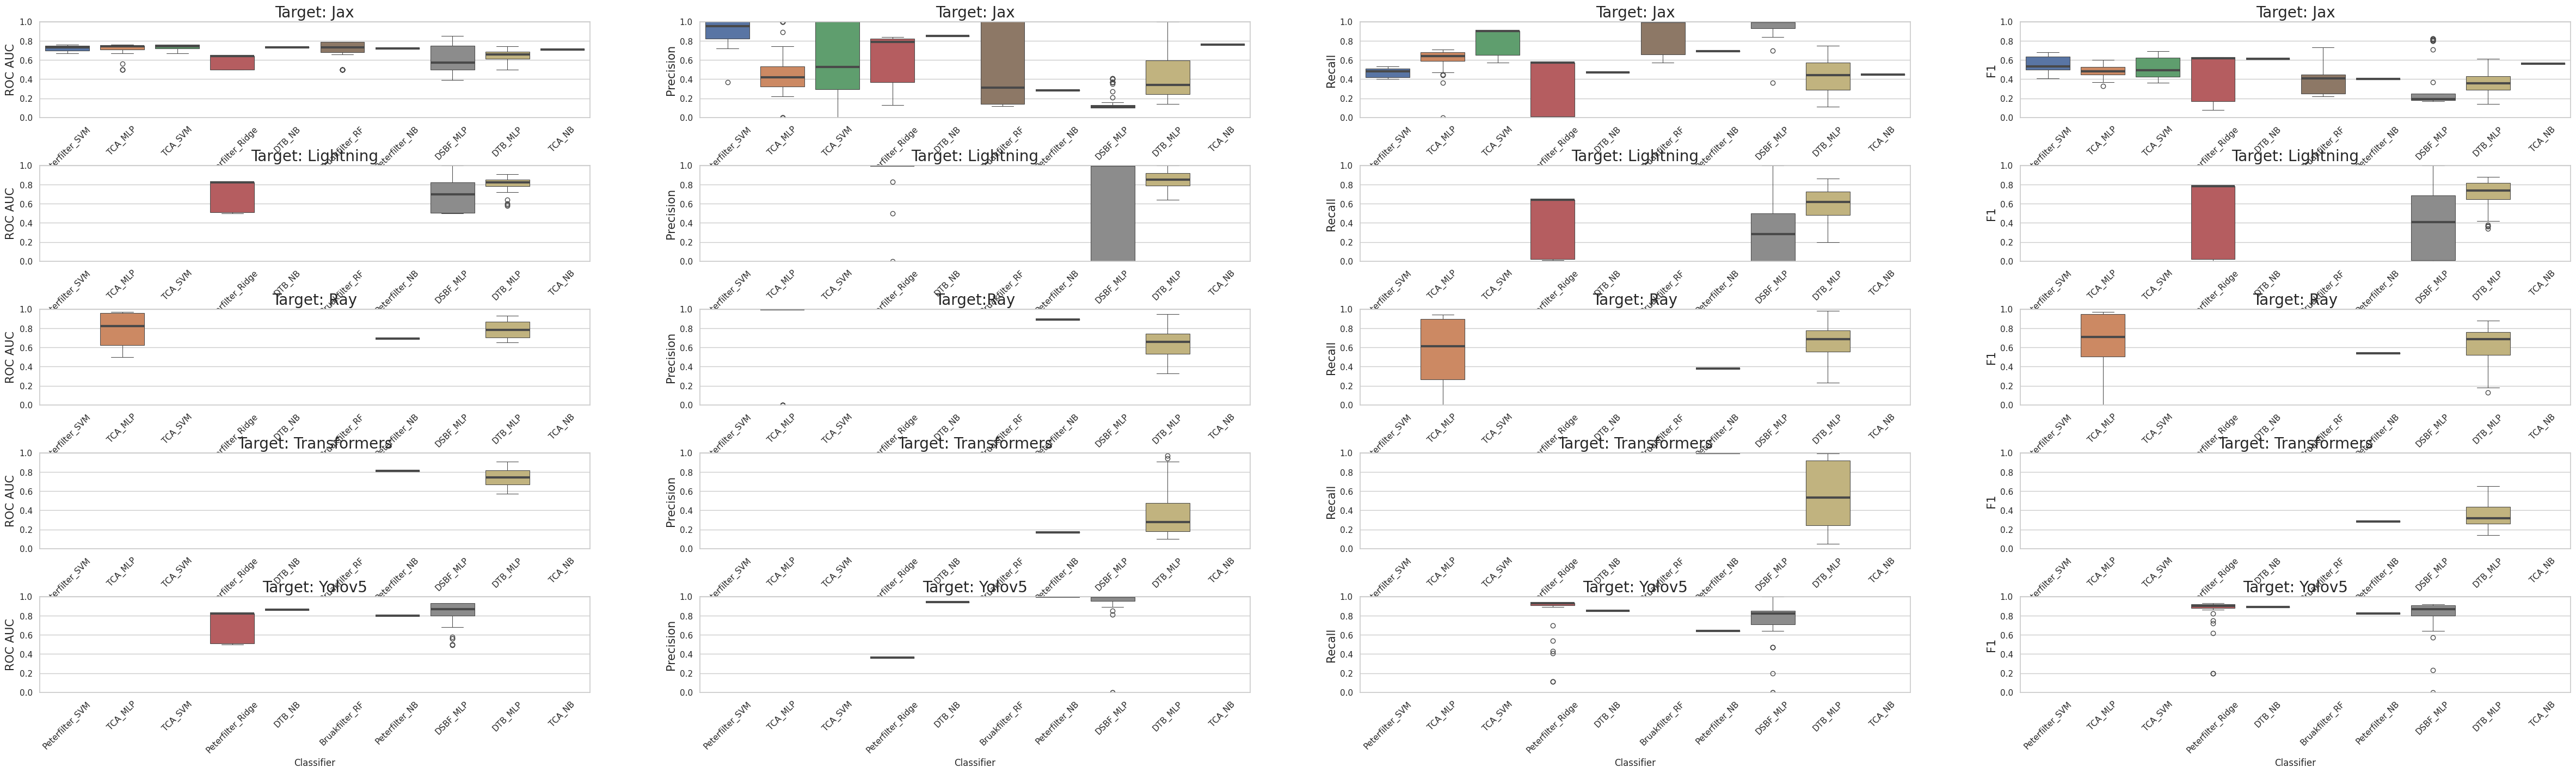

In [135]:
box_plots_all(data_jax_roc, data_lightning_roc, data_ray, data_transformers, data_yolov5, data_jax_precision, data_lightning_precision, data_ray_pre, data_transformers_precision, data_yolov5_precision, data_jax_recall, data_lightning_recall, data_ray_re, data_transformers_recall, data_yolov5_recall, data_jax_f1, data_lightning_f1, data_ray_f1, data_transformers_f1, data_yolov5_f1)


In [144]:
# For target transformers
def box_plots_yolov5(data_yolov5, data_yolov5_precision, data_yolov5_recall, data_yolov5_f1):

    classifier_order = data_yolov5['Classifier'].unique()
    num_classifiers = len(classifier_order)
    color_palette = sns.color_palette("deep", num_classifiers)
    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(30, 4))
    sns.set(style='whitegrid')
    # sns.color_palette("pastel")

    

    # Plot box plots
    sns.boxplot(x='Classifier', y='ROC AUC', data=data_yolov5, order=classifier_order, palette=color_palette, ax=axes[0], linewidth=0.75, medianprops={"linewidth": 3})
    axes[0].set_title('Target: Yolov5', fontsize=20)
    axes[0].set_ylim(0, 1)
    axes[0].set_ylabel('ROC AUC', fontsize=15)

    sns.boxplot(x='Classifier', y='Precision', data=data_yolov5_precision, order=classifier_order, palette=color_palette, ax=axes[1], linewidth=0.75, medianprops={"linewidth": 3})
    axes[1].set_title('Target: Yolov5', fontsize=20)
    axes[1].set_ylim(0, 1)
    axes[1].set_ylabel('Precision', fontsize=15)

    sns.boxplot(x='Classifier', y='Recall', data=data_yolov5_recall, order=classifier_order, palette=color_palette, ax=axes[2], linewidth=0.75, medianprops={"linewidth": 3})
    axes[2].set_title('Target: Yolov5', fontsize=20)
    axes[2].set_ylim(0, 1)
    axes[2].set_ylabel('Recall', fontsize=15)

    sns.boxplot(x='Classifier', y='F1', data=data_yolov5_f1, order=classifier_order, palette=color_palette, ax=axes[3], linewidth=0.75, medianprops={"linewidth": 3})
    axes[3].set_title('Target: Yolov5', fontsize=20)
    axes[3].set_ylim(0, 1)
    axes[3].set_ylabel('F1', fontsize=15)

    for ax in axes:
        for line in ax.lines:
            if np.array_equal(line.get_xdata(), [0, 1]):  # Check if the line represents the median
                line.set_linewidth(2)  # Set line width to bold


    # Tilt x-axis labels
    for ax in axes:
        ax.tick_params(axis='x', rotation=55)
        
    plt.savefig('cpdp_results_yolov5_boxplots.png', bbox_inches='tight')
    plt.show()

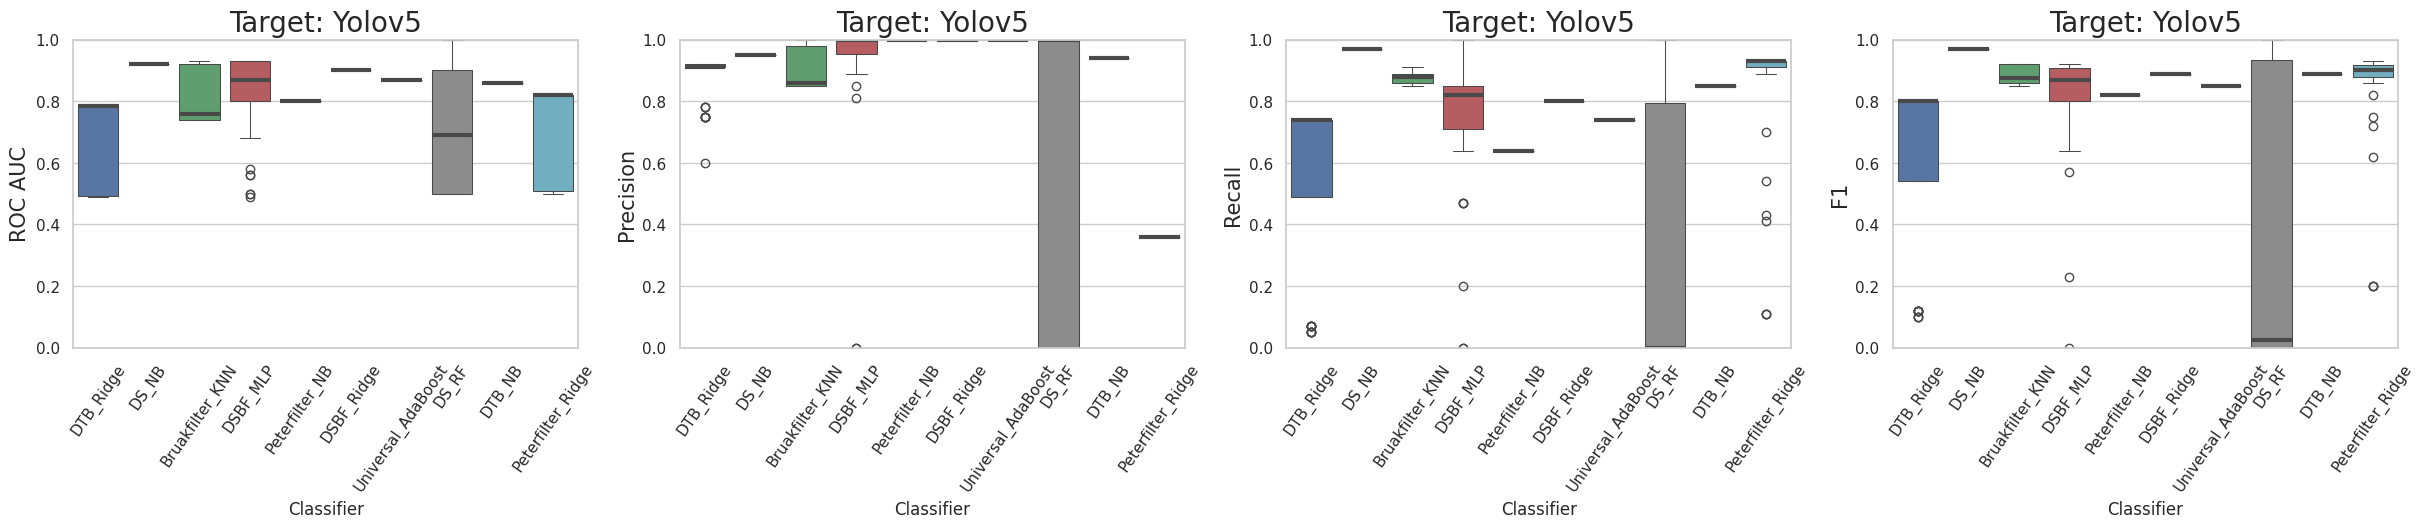

In [145]:
box_plots_yolov5(data_yolov5, data_yolov5_precision, data_yolov5_recall, data_yolov5_f1)